# Week HW 18

Last Audit: HW18

# Import


In [22]:
import gurobipy as gp
from gurobipy import GRB
import gurobipy_pandas as gppd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from gurobipy import min_, max_
from scipy.stats import multivariate_normal, norm
import pickle
import os
import glob
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from datetime import datetime
import matplotlib.pyplot as plt
import itertools
import math

params = {
    "WLSACCESSID": "73a6e3bf-2a9d-41e8-85eb-dd9b9eda802b",
    "WLSSECRET": "c394298a-96ea-4c8c-9d5e-ef2bd5032427",
    "LICENSEID": 2563044,
}

env = gp.Env(params=params)
model = gp.Model(env=env)

Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2563044
Academic license 2563044 - for non-commercial use only - registered to 11___@g.nccu.edu.tw


# Settings


In [23]:
#####################

salvage_value = 0
cost = 300
price = 1000
holding_cost = 0

model_prefix = f"med_with_holding_cost_{holding_cost}"

#####################

data_size = 100
train_size = 0.5
testing_size = 0.5
k_fold = 2

T = 10
service_level = 0.95  # 服務水準
M = 5000000

ASSIGNED_FS = np.arange(0.1, 1.0, 0.1)
ASSIGNED_TS = list(range(2, T))  # 2 到 T-1

np.random.seed(0)

# Gurobi Model Constants
THREADS = 12
TIME_LIMIT = 20000
MIPGAP = 0.01
CURRENT_TIMESTAMP = int(datetime.now().strftime("%Y%m%d%H%M"))

# Utils


## Models' Parameters

In [24]:
def save_model_parameters(
    name: str,
    alpha_values=None,
    beta_values=None,
    f_values=None,
    tau_values=None,
    data_size=data_size,
    current_timestamp=CURRENT_TIMESTAMP,
):
    os.makedirs("models", exist_ok=True)

    params = {}
    if alpha_values is not None:
        params["alpha"] = alpha_values
    if beta_values is not None:
        params["beta"] = beta_values
    if f_values is not None:
        params["f_values"] = f_values
    if tau_values is not None:
        params["tau_values"] = tau_values

    # 如果有參數才進行保存
    if params:
        with open(f"models/{name}_{data_size}_{current_timestamp}.pkl", "wb") as f:
            pickle.dump(params, f)
        print(
            f"Model parameters saved as models/{name}_{data_size}_{current_timestamp}.pkl"
        )
    else:
        print("No parameters provided to save.")

In [25]:
def delete_model_parameters(name: str, data_size: int):
    # 構建檔案的路徑
    file_path = f"models/{name}_{data_size}_{CURRENT_TIMESTAMP}.pkl"

    # 檢查檔案是否存在
    if os.path.exists(file_path):
        os.remove(file_path)
        print(f"Model parameters file '{file_path}' has been deleted.")
    else:
        print(f"File '{file_path}' does not exist.")

In [26]:
def show_models(model_prefix):
    file_paths = sorted(glob.glob(f"models/{model_prefix}_*.pkl"))

    # 逐一讀取並打印每個檔案的內容
    for file_path in file_paths:
        with open(file_path, "rb") as f:
            params = pickle.load(f)
            print(f"Contents of {file_path}:")
            print(params)
            print()  # 空行分隔每個檔案的內容

In [27]:
show_models("linear_constraint_med_with_holding_cost")

In [28]:
show_models("med_with_holding_cost")

Contents of models/med_with_holding_cost_0_s11_100_202502072315.pkl:
{'alpha': array([0.28191367, 0.2697177 , 2.74419991, 0.0961718 , 3.99513515]), 'beta': array([-1000000., -1000000., -1000000., -1000000., -1000000., -1000000.,
       -1000000., -1000000.]), 'f_values': array([ 2.79717967,  6.30796808,  3.37363359,  1.50019826, -0.84168471,
        0.1123013 ,  5.98221275,  4.15296647,  4.90384465,  8.44731869,
        9.51211469,  1.75093629,  6.05446226,  2.        , -0.53229074,
        6.23088456,  2.38602626,  3.57735328,  6.        ,  8.26013142,
        6.23463924,  8.1830838 ,  2.33467954,  7.63649689,  0.58898517,
        9.04621966,  5.31970321,  1.75914455,  8.86888303,  6.22539822,
        1.606989  ,  1.73328065,  3.86520923, -0.52627968,  1.04487218,
        3.85309974,  3.14470323,  4.16785232,  2.72581817,  5.18392252,
        8.15894478,  0.15535425,  4.57852302,  0.43433457,  7.0618086 ,
        3.50253823,  4.20396034,  1.13791139,  0.81635444,  4.73477059]), 'tau_v

## Visualization 

In [29]:
def plot_strategies_profits_scatter(save_type, dfs):

    if len(dfs) <= 1:
        print("No dataframes to plot.")
        return None

    # 生成所有兩兩配對
    pairs = list(itertools.combinations(range(len(dfs)), 2))
    num_pairs = len(pairs)

    # 計算網格大小
    grid_size = math.ceil(math.sqrt(num_pairs))
    fig, axes = plt.subplots(grid_size, grid_size, figsize=(15, 15))
    fig.suptitle("Scatter Plots of Profits (Matrix View)")

    # 繪製每個配對的散佈圖
    for idx, (i, j) in enumerate(pairs):
        row, col = divmod(idx, grid_size)

        if (dfs[i] is None or len(dfs[i]) == 0) or (dfs[j] is None or len(dfs[j]) == 0):
            continue

        profits_i = dfs[i]["profits"]
        profits_j = dfs[j]["profits"]

        if len(profits_i) != len(profits_j):
            continue

        ax = axes[row, col]
        ax.scatter(profits_i, profits_j, alpha=0.6, label=f"Profits {i} vs Profits {j}")
        ax.set_xlabel(f"Profits {i}")
        ax.set_ylabel(f"Profits {j}")

        # 繪製 45 度虛線
        max_val = max(profits_i.max(), profits_j.max())
        min_val = min(profits_i.min(), profits_j.min())
        ax.plot([min_val, max_val], [min_val, max_val], "k--", lw=1)

        ax.legend()
        ax.set_title(f"Profits {i} vs Profits {j}")

    # 隱藏未使用的子圖軸
    for idx in range(num_pairs, grid_size * grid_size):
        row, col = divmod(idx, grid_size)
        fig.delaxes(axes[row, col])

    plt.tight_layout(rect=[0, 0, 1, 0.95])

    name = "plot_strategies_profits_scatter"

    os.makedirs("plots", exist_ok=True)
    save_path = f"plots/{name}_{save_type}_{data_size}_{CURRENT_TIMESTAMP}.png"

    plt.savefig(save_path, format="png", bbox_inches="tight")
    print(f"Plot saved as {save_path}")

    # Show plot
    plt.show()
    plt.close()

In [30]:
# def plot_relative_profit_deviation(save_type, baseline_profit, max_profits):
#     """
#     繪製多個策略相對於基準的平均利潤偏差。

#     :param baseline_profit: 基準利潤值
#     :param max_profits: 各策略的最大利潤列表，包含 None 值或 -1 表示無效數據
#     """
#     print(f"Baseline is: {baseline_profit}")
#     for i, profit in enumerate(max_profits):
#         print(f"S{i+1}'s profit: {profit}")

#     # 計算相對值
#     ratios = {}
#     for idx, max_profit in enumerate(max_profits, start=1):
#         if max_profit is not None and max_profit != -1:
#             ratio = max_profit / baseline_profit
#             ratios[f"S{idx}"] = ratio - 1  # 相對偏差

#     # 設置 y 軸範圍
#     if ratios:
#         y_min = min(ratios.values()) - 0.1
#         y_max = max(ratios.values()) + 0.1
#     else:
#         y_min, y_max = -0.1, 0.1

#     # 創建圖表顯示結果
#     plt.figure(figsize=(12, 8))

#     if ratios:
#         bars = plt.bar(
#             ratios.keys(), ratios.values(), color=plt.cm.tab10(range(len(ratios)))
#         )

#         # 在每個柱狀圖上標出數值
#         for bar in bars:
#             yval = bar.get_height()
#             plt.text(
#                 bar.get_x() + bar.get_width() / 2,
#                 yval,
#                 f"{yval:.4f}",
#                 ha="center",
#                 va="bottom",
#             )

#     # 添加基準線，表示基準值（No Opt）
#     plt.axhline(y=0, color="gray", linestyle="--", label="Baseline (No Opt)")

#     # 設置圖表標題和軸標籤
#     plt.title("Relative Avg Profit Deviation from Baseline (1)")
#     plt.xlabel("Strategies")
#     plt.ylabel("Deviation from Baseline (1)")
#     plt.ylim(y_min, y_max)
#     plt.legend()

#     name = "plot_relative_profit_deviation"

#     os.makedirs("plots", exist_ok=True)
#     save_path = f"plots/{name}_{save_type}_{data_size}_{CURRENT_TIMESTAMP}.png"

#     plt.savefig(save_path, format="png", bbox_inches="tight")
#     print(f"Plot saved as {save_path}")

#     # Show plot
#     plt.show()
#     plt.close()

In [31]:
def plot_relative_profit_deviation(save_type, baseline_profit, max_profits):
    """
    繪製多個策略相對於基準的平均利潤偏差。

    :param baseline_profit: 基準利潤值
    :param max_profits: 各策略的最大利潤列表，包含 None 值或 -1 表示無效數據
    """
    print(f"Baseline is: {baseline_profit}")
    for i, profit in enumerate(max_profits):
        print(f"S{i+1}'s profit: {profit}")

    # 計算相對值
    ratios = {}
    for idx, max_profit in enumerate(max_profits, start=1):
        if max_profit is not None and max_profit != -1:
            if baseline_profit != 0:
                ratio = (max_profit - baseline_profit) / abs(baseline_profit)
                ratios[f"S{idx}"] = ratio
            else:
                # 基準利潤為零時，直接記錄增量
                ratio = max_profit
                ratios[f"S{idx}"] = ratio

    # 設置 y 軸範圍
    if ratios:
        y_min = min(ratios.values()) - 0.1
        y_max = max(ratios.values()) + 0.1
    else:
        y_min, y_max = -0.1, 0.1

    # 創建圖表顯示結果
    plt.figure(figsize=(12, 8))

    if ratios:
        bars = plt.bar(
            ratios.keys(), ratios.values(), color=plt.cm.tab10(range(len(ratios)))
        )

        # 在每個柱狀圖上標出數值
        for bar in bars:
            yval = bar.get_height()
            plt.text(
                bar.get_x() + bar.get_width() / 2,
                yval,
                f"{yval:.4f}",
                ha="center",
                va="bottom",
            )

    # 添加基準線，表示基準值（No Opt）
    plt.axhline(y=0, color="gray", linestyle="--", label="Baseline (No Opt)")

    # 設置圖表標題和軸標籤
    plt.title("Relative Avg Profit Deviation from Baseline (1)")
    plt.xlabel("Strategies")
    plt.ylabel("Deviation from Baseline (1)")
    plt.ylim(y_min, y_max)
    plt.legend()

    name = "plot_relative_profit_deviation"

    os.makedirs("plots", exist_ok=True)
    save_path = f"plots/{name}_{save_type}_{data_size}_{CURRENT_TIMESTAMP}.png"

    plt.savefig(save_path, format="png", bbox_inches="tight")
    print(f"Plot saved as {save_path}")

    # Show plot
    plt.show()
    plt.close()

In [32]:
def plot_relative_profit_comparison(
    save_type,
    train_baseline_profit,
    test_baseline_profit,
    test_max_profits,
    train_max_profits,
):

    # Calculate relative deviations from baseline for test and train data
    test_ratios, train_ratios = {}, {}
    for idx, (test_profit, train_profit) in enumerate(
        zip(test_max_profits, train_max_profits), start=1
    ):
        if test_profit is not None and test_profit != -1:
            if test_baseline_profit != 0:
                test_ratio = (test_profit - test_baseline_profit) / abs(
                    test_baseline_profit
                )  # Relative deviation
            else:
                test_ratio = test_profit  # Use profit directly if baseline is zero
            test_ratios[f"S{idx}"] = test_ratio

        if train_profit is not None and train_profit != -1:
            if train_baseline_profit != 0:
                train_ratio = (train_profit - train_baseline_profit) / abs(
                    train_baseline_profit
                )  # Relative deviation
            else:
                train_ratio = train_profit  # Use profit directly if baseline is zero
            train_ratios[f"S{idx}"] = train_ratio

    # Define the range of the y-axis
    y_min = (
        min(min(test_ratios.values(), default=0), min(train_ratios.values(), default=0))
        - 0.1
    )
    y_max = (
        max(max(test_ratios.values(), default=0), max(train_ratios.values(), default=0))
        + 0.1
    )

    # Create bar plot for relative profit deviation comparison
    plt.figure(figsize=(14, 8))
    bar_width = 0.35
    indices = np.arange(len(train_ratios))

    # Plot bars for train and test ratios, with train on the left for each pair
    train_bars = plt.bar(
        indices - bar_width / 2,
        train_ratios.values(),
        bar_width,
        label="Train Data",
        color="salmon",
    )
    test_bars = plt.bar(
        indices + bar_width / 2,
        test_ratios.values(),
        bar_width,
        label="Test Data",
        color="skyblue",
    )

    # Add baseline line
    plt.axhline(y=0, color="gray", linestyle="--", label="Baseline (No Opt)")

    # Add labels for each bar
    for bar in train_bars:
        yval = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            yval,
            f"{yval:.2f}",
            ha="center",
            va="bottom",
        )
    for bar in test_bars:
        yval = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            yval,
            f"{yval:.2f}",
            ha="center",
            va="bottom",
        )

    # Set plot labels and title
    plt.xlabel("Strategies")
    plt.ylabel("Deviation from Baseline")
    plt.title("Relative Profit Deviation Comparison between Train and Test Data")
    plt.xticks(indices, train_ratios.keys())
    plt.ylim(y_min, y_max)
    plt.legend()

    name = "plot_relative_profit_comparison"

    os.makedirs("plots", exist_ok=True)
    save_path = f"plots/{name}_{save_type}_{data_size}_{CURRENT_TIMESTAMP}.png"

    plt.savefig(save_path, format="png", bbox_inches="tight")
    print(f"Plot saved as {save_path}")

    # Show plot
    plt.show()
    plt.close()


# def plot_relative_profit_comparison(
#     save_type,
#     train_baseline_profit,
#     test_baseline_profit,
#     test_max_profits,
#     train_max_profits,
# ):

#     # Calculate relative deviations from baseline for test and train data
#     test_ratios, train_ratios = {}, {}
#     for idx, (test_profit, train_profit) in enumerate(
#         zip(test_max_profits, train_max_profits), start=1
#     ):
#         if test_profit is not None and test_profit != -1:
#             test_ratio = test_profit / test_baseline_profit - 1  # Relative deviation
#             test_ratios[f"S{idx}"] = test_ratio
#         if train_profit is not None and train_profit != -1:
#             train_ratio = train_profit / train_baseline_profit - 1  # Relative deviation
#             train_ratios[f"S{idx}"] = train_ratio

#     # Define the range of the y-axis
#     y_min = (
#         min(min(test_ratios.values(), default=0), min(train_ratios.values(), default=0))
#         - 0.1
#     )
#     y_max = (
#         max(max(test_ratios.values(), default=0), max(train_ratios.values(), default=0))
#         + 0.1
#     )

#     # Create bar plot for relative profit deviation comparison
#     plt.figure(figsize=(14, 8))
#     bar_width = 0.35
#     indices = np.arange(len(train_ratios))

#     # Plot bars for train and test ratios, with train on the left for each pair
#     train_bars = plt.bar(
#         indices - bar_width / 2,
#         train_ratios.values(),
#         bar_width,
#         label="Train Data",
#         color="salmon",
#     )
#     test_bars = plt.bar(
#         indices + bar_width / 2,
#         test_ratios.values(),
#         bar_width,
#         label="Test Data",
#         color="skyblue",
#     )

#     # Add baseline line
#     plt.axhline(y=0, color="gray", linestyle="--", label="Baseline (No Opt)")

#     # Add labels for each bar
#     for bar in train_bars:
#         yval = bar.get_height()
#         plt.text(
#             bar.get_x() + bar.get_width() / 2,
#             yval,
#             f"{yval:.2f}",
#             ha="center",
#             va="bottom",
#         )
#     for bar in test_bars:
#         yval = bar.get_height()
#         plt.text(
#             bar.get_x() + bar.get_width() / 2,
#             yval,
#             f"{yval:.2f}",
#             ha="center",
#             va="bottom",
#         )

#     # Set plot labels and title
#     plt.xlabel("Strategies")
#     plt.ylabel("Deviation from Baseline")
#     plt.title("Relative Profit Deviation Comparison between Train and Test Data")
#     plt.xticks(indices, train_ratios.keys())
#     plt.ylim(y_min, y_max)
#     plt.legend()

#     name = "plot_relative_profit_comparison"

#     os.makedirs("plots", exist_ok=True)
#     save_path = f"plots/{name}_{save_type}_{data_size}_{CURRENT_TIMESTAMP}.png"

#     plt.savefig(save_path, format="png", bbox_inches="tight")
#     print(f"Plot saved as {save_path}")

#     # Show plot
#     plt.show()
#     plt.close()

In [33]:
def plot_Q0_Q1_distribution(save_type, stimulation_results_dfs):

    for idx, df in enumerate(stimulation_results_dfs, start=1):
        if df is None or len(df) == 0:
            continue

        df["Q0"] = pd.to_numeric(df["Q0"], errors="coerce")
        df["Q1"] = pd.to_numeric(df["Q1"], errors="coerce")
        df.dropna(subset=["Q0", "Q1"], inplace=True)

        plt.figure(figsize=(10, 6))
        plt.hist(df["Q0"], bins=20, alpha=0.6, label="Q0", edgecolor="black")
        plt.hist(df["Q1"], bins=20, alpha=0.6, label="Q1", edgecolor="black")
        plt.title(f"Histogram of Q0 and Q1 for stimulation_results_df_{idx}")
        plt.xlabel("Value")
        plt.ylabel("Count")
        plt.legend()
        plt.grid(True)

        name = "plot_Q0_Q1_distribution"

        os.makedirs("plots", exist_ok=True)
        save_path = (
            f"plots/{name}_{save_type}_{data_size}_S{idx}_{CURRENT_TIMESTAMP}.png"
        )

        plt.savefig(save_path, format="png", bbox_inches="tight")
        print(f"Plot saved as {save_path}")

        plt.show()

In [34]:
import seaborn as sns


def plot_profits_deviation_box_plot(
    save_type, stimulation_results_dfs, baseline_avg_profits
):

    for idx, df in enumerate(stimulation_results_dfs, start=1):
        if df is not None and "profits" in df.columns:
            df["profits"] = pd.to_numeric(df["profits"], errors="coerce")
            df.dropna(subset=["profits"], inplace=True)

            # Calculate deviation
            df["Deviation"] = df["profits"] - baseline_avg_profits

            # Plot deviation as a boxplot
            plt.figure(figsize=(8, 6))
            sns.boxplot(y=df["Deviation"])
            plt.axhline(0, color="red", linestyle="--", label="Baseline")
            plt.title(
                f"Boxplot of Deviation of Profits from Baseline for stimulation_results_df_{idx}"
            )
            plt.ylabel("Deviation")
            plt.legend()
            plt.grid(True, axis="y")

            name = "plot_profits_deviation_box_plot"

            os.makedirs("plots", exist_ok=True)
            save_path = (
                f"plots/{name}_{save_type}_{data_size}_S{idx}_{CURRENT_TIMESTAMP}.png"
            )

            plt.savefig(save_path, format="png", bbox_inches="tight")
            print(f"Plot saved as {save_path}")

            plt.show()
        else:
            print(f"Skipping stimulation_results_df_{idx}: Missing 'profits' column.")

## Others

In [35]:
# Function to replace negative values with 0
def replace_negative_with_zero(df):
    return df.applymap(lambda x: max(x, 0))

In [36]:
def check_values(
    Q1_vars,
    Q_hat_adjusteds,
    Q0_vars,
    Sold_0s,
    total_demand_up_to_k_minus_1_vars,
    Sold_1s,
    total_demand_from_k_to_T_vars,
    Q1_plus_lefts,
    Left_0s,
    Lost_0s,
    Left_1s,
    Lost_1s,
):

    # 用於存儲每個條件的統計結果
    results = {
        "Condition": [],
        "Average_Error_Percentage": [],
        "Max_Error_Percentage": [],
        "Min_Error_Percentage": [],
        "Max_Error": [],
        "Min_Error": [],
    }

    # 定義存儲每個條件下的誤差和誤差百分比
    conditions_errors = {
        "Q1_vars": [],
        "Sold_0s": [],
        "Sold_1s": [],
        "Left_0s": [],
        "Left_1s": [],
        "Lost_0s": [],
        "Lost_1s": [],
    }

    # 存儲每個條件下的誤差百分比
    conditions_error_percentage = {
        "Q1_vars": [],
        "Sold_0s": [],
        "Sold_1s": [],
        "Left_0s": [],
        "Left_1s": [],
        "Lost_0s": [],
        "Lost_1s": [],
    }

    # 遍歷每一個變量集合
    for i in range(len(Q1_vars)):
        # 提取變量的值
        Q1 = Q1_vars[i].X
        Q_hat_adjusted = Q_hat_adjusteds[i].X
        Q0 = Q0_vars[i].X
        Sold_0 = Sold_0s[i].X
        total_demand_up_to_k_minus_1 = total_demand_up_to_k_minus_1_vars[i].X
        Sold_1 = Sold_1s[i].X
        total_demand_from_k_to_T = total_demand_from_k_to_T_vars[i].X
        Q1_plus_left = Q1_plus_lefts[i].X
        Left_0 = Left_0s[i].X
        Lost_0 = Lost_0s[i].X
        Left_1 = Left_1s[i].X
        Lost_1 = Lost_1s[i].X

        # 計算理論值
        theoretical_sold_0 = min(total_demand_up_to_k_minus_1, Q0)
        theoretical_left_0 = max(Q0 - theoretical_sold_0, 0)
        theoretical_Q1_plus_left = Q1 + theoretical_left_0  # Q1_plus_left 的理論值
        theoretical_sold_1 = min(total_demand_from_k_to_T, theoretical_Q1_plus_left)
        theoretical_left_1 = max(theoretical_Q1_plus_left - theoretical_sold_1, 0)
        theoretical_lost_0 = max(total_demand_up_to_k_minus_1 - Q0, 0)
        theoretical_lost_1 = max(total_demand_from_k_to_T - theoretical_Q1_plus_left, 0)

        # 檢查條件 2：Sold_0 一定等於理論值
        if not (Sold_0 == theoretical_sold_0):
            error = abs(Sold_0 - theoretical_sold_0)
            conditions_errors["Sold_0s"].append(error)
            # 計算誤差百分比
            conditions_error_percentage["Sold_0s"].append(
                (error / theoretical_sold_0) * 100 if theoretical_sold_0 != 0 else 0
            )

        # 檢查條件 3：Sold_1 一定等於理論值
        if not (Sold_1 == theoretical_sold_1):
            error = abs(Sold_1 - theoretical_sold_1)
            conditions_errors["Sold_1s"].append(error)
            # 計算誤差百分比
            conditions_error_percentage["Sold_1s"].append(
                (error / theoretical_sold_1) * 100 if theoretical_sold_1 != 0 else 0
            )

        # 檢查條件 4：Left_0 一定等於理論值
        if not (Left_0 == theoretical_left_0):
            error = abs(Left_0 - theoretical_left_0)
            conditions_errors["Left_0s"].append(error)
            # 計算誤差百分比
            conditions_error_percentage["Left_0s"].append(
                (error / theoretical_left_0) * 100 if theoretical_left_0 != 0 else 0
            )

        # 檢查條件 5：Left_1 一定等於理論值
        if not (Left_1 == theoretical_left_1):
            error = abs(Left_1 - theoretical_left_1)
            conditions_errors["Left_1s"].append(error)
            # 計算誤差百分比
            conditions_error_percentage["Left_1s"].append(
                (error / theoretical_left_1) * 100 if theoretical_left_1 != 0 else 0
            )

        # 檢查條件 6：Lost_0 一定等於理論值
        if not (Lost_0 == theoretical_lost_0):
            error = abs(Lost_0 - theoretical_lost_0)
            conditions_errors["Lost_0s"].append(error)
            # 計算誤差百分比
            conditions_error_percentage["Lost_0s"].append(
                (error / theoretical_lost_0) * 100 if theoretical_lost_0 != 0 else 0
            )

        # 檢查條件 7：Lost_1 一定等於理論值
        if not (Lost_1 == theoretical_lost_1):
            error = abs(Lost_1 - theoretical_lost_1)
            conditions_errors["Lost_1s"].append(error)
            # 計算誤差百分比
            conditions_error_percentage["Lost_1s"].append(
                (error / theoretical_lost_1) * 100 if theoretical_lost_1 != 0 else 0
            )

    # 計算每個條件的統計結果
    for condition, errors in conditions_errors.items():
        error_percentages = conditions_error_percentage[condition]
        if errors:
            # 統計數據，並將所有數值四捨五入至小數點后三位
            avg_error_percentage = (
                round(sum(error_percentages) / len(error_percentages), 3)
                if error_percentages
                else 0.0
            )
            max_error_percentage = (
                round(max(error_percentages), 3) if error_percentages else 0.0
            )
            min_error_percentage = (
                round(min(error_percentages), 3) if error_percentages else 0.0
            )
            max_error = round(max(errors), 3) if errors else 0.0
            min_error = round(min(errors), 3) if errors else 0.0

            # 存儲結果
            results["Condition"].append(condition)
            results["Average_Error_Percentage"].append(avg_error_percentage)
            results["Max_Error_Percentage"].append(max_error_percentage)
            results["Min_Error_Percentage"].append(min_error_percentage)
            results["Max_Error"].append(max_error)
            results["Min_Error"].append(min_error)

    # 轉換為 DataFrame
    results_df = pd.DataFrame(results)
    return results_df

In [37]:
# Calculate service level
def calculate_service_level(*, salvage_value, cost, price):

    cu = price - cost
    co = cost - salvage_value
    service_lv = cu / (co + cu)

    return service_lv

In [38]:
def make_s3_related_strtegies_result(
    *,
    all_Rs,
    losses,
    lefts,
    profits,
    operation_profits,
    alpha_values,
    beta_values,
    F_vars,
    Q0_vars,
    Q1_vars,
    f_values,
    tau_values,
    holding_costs_0s,
    holding_costs_1s,
    all_left0s,
    all_left1s,
    all_lost0s,
    all_lost1s,
    gamma_values=None
):

    results_dict = {
        "average_profits": [sum(profits) / len(profits) if profits else 0],
        "average_losses": [sum(losses) / len(losses) if losses else 0],
        "average_lefts": [sum(lefts) / len(lefts) if lefts else 0],
        "average_operation_profits": [
            sum(operation_profits) / len(operation_profits) if operation_profits else 0
        ],
        "alpha_values": [alpha_values],
        "beta_values": [beta_values],
        "tau_values": [tau_values],
        "gamma_values": [gamma_values],
    }
    stimulations_result = {
        "R(T)": all_Rs,
        "R": [x - 2 for x in all_Rs],
        "F": F_vars,
        "f_values": f_values,
        "profits": profits,
        "losses": losses,
        "lefts": lefts,
        "operation_profits": operation_profits,
        "Q0": Q0_vars,
        "Q1": Q1_vars,
        "hc0": holding_costs_0s,
        "hc1": holding_costs_1s,
        "Left0s": all_left0s,
        "Left1s": all_left1s,
        "lost0s": all_lost0s,
        "lost1s": all_lost1s,
    }

    return pd.DataFrame(results_dict).sort_values(
        by="average_profits", ascending=False
    ), pd.DataFrame(stimulations_result)

# Generate Data


## Data1: Training data for LR


### Making full data


In [39]:
np.random.seed(0)

full_df = pd.DataFrame(
    {
        "X1": np.random.uniform(10, 15, data_size),
        "X2": np.random.uniform(-30, -10, data_size),
        "X3": np.random.uniform(50, 300, data_size),
        "X4": np.random.uniform(5, 15, data_size),
    }
)

full_df

X1         X2          X3         X4
0   12.744068 -16.443669  127.948970  14.065555
1   13.575947 -24.599841  224.085872  12.740473
2   13.013817 -15.296120  144.437960   8.331452
3   12.724416 -10.756229   94.900919   5.811014
4   12.118274 -25.024937   56.169682   9.072412
..        ...        ...         ...        ...
95  10.915957 -20.190824  106.079257  14.589827
96  12.932565 -25.451707   74.461121   8.553688
97  10.100538 -24.912870  265.547879   8.567069
98  14.144700 -28.839417  293.229872   5.163285
99  10.023477 -21.311667  290.208665   6.852323

[100 rows x 4 columns]

In [40]:
features_num = full_df.shape[1]
features_num

4

### Split training and testing data


In [41]:
# import pandas as pd
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import StandardScaler


# def train_data_split_and_normalize_k_fold(data, train_size=0.8, k_fold=2):
#     folds = []
#     scalers = []

#     for i in range(k_fold):
#         # Randomly split the data into train and test sets
#         train_data, test_data = train_test_split(
#             data, train_size=train_size, random_state=i
#         )
#         test_data.reset_index(drop=True, inplace=True)
#         train_data.reset_index(drop=True, inplace=True)

#         # Normalize the train and test data
#         scaler = StandardScaler()
#         train_data_normalized = scaler.fit_transform(train_data)
#         test_data_normalized = scaler.transform(test_data)

#         # Convert normalized data back to DataFrame
#         train_data_normalized = pd.DataFrame(
#             train_data_normalized, columns=data.columns
#         )
#         test_data_normalized = pd.DataFrame(test_data_normalized, columns=data.columns)

#         # Append the fold and scaler
#         folds.append((train_data_normalized, test_data_normalized))
#         scalers.append(scaler)

#     return folds, scalers


# training_data_folds, scalers = train_data_split_and_normalize_k_fold(
#     full_df, train_size, k_fold=k_fold
# )

# # Print each fold's train and test sizes and normalized data
# for i, (train, test) in enumerate(training_data_folds):
#     print(f"Fold {i + 1}:")
#     print(f"Train size: {train.shape}, Test size: {test.shape}")
#     print("Train (normalized):")
#     print(train.head())
#     print("Test (normalized):")
#     print(test.head())
#     print()

In [42]:
train_size

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


def train_data_split_and_normalized(data, train_size=0.5):
    folds = []
    scalers = []

    # 計算訓練集的大小
    train_len = int(len(data) * train_size)

    # 將資料切分為前半部分為訓練集，後半部分為測試集
    train_data = data.iloc[:train_len].reset_index(drop=True)
    test_data = data.iloc[train_len:].reset_index(drop=True)

    # 標準化處理
    scaler = StandardScaler()
    train_data_normalized = scaler.fit_transform(train_data)
    test_data_normalized = scaler.transform(test_data)

    # 將標準化資料轉回 DataFrame
    train_data_normalized = pd.DataFrame(train_data_normalized, columns=data.columns)
    test_data_normalized = pd.DataFrame(test_data_normalized, columns=data.columns)

    # 將資料加入 folds 與 scaler
    folds.append((train_data_normalized, test_data_normalized))
    scalers.append(scaler)

    return folds, scalers


training_data_folds, scalers = train_data_split_and_normalized(full_df, train_size)

# Print each fold's train and test sizes and normalized data
for i, (train, test) in enumerate(training_data_folds):
    print(f"Fold {i + 1}:")
    print(f"Train size: {train.shape}, Test size: {test.shape}")
    print("Train (normalized):")
    print(train.head())
    print("Test (normalized):")
    print(test.head())
    print()

Fold 1:
Train size: (50, 4), Test size: (50, 4)
Train (normalized):
         X1        X2        X3        X4
0  0.039845  0.377909 -0.540097  1.778250
1  0.650924 -1.287091  0.856977  1.297298
2  0.237996  0.612170 -0.300477 -0.303001
3  0.025409  1.538942 -1.020356 -1.217819
4 -0.419848 -1.373870 -1.583203 -0.034062
Test (normalized):
         X1        X2        X3        X4
0  0.118383 -1.779311 -0.380909  0.830978
1 -0.364951  1.154904  1.743758 -1.383833
2  1.654298 -1.726053  1.107590  0.050005
3 -1.601083  0.123726  1.047058  0.338973
4 -1.208702 -1.883946  1.610382  0.433926



## Data2: demand_df


### mu of each time(t)


In [43]:
# 設定 b0, b1, b2

# b0 = 0
# b1 = 1
# b2 = 2
# b3 = -1
# b4 = 2
# bt = 0

b0 = 0
b1 = 0
b2 = 0
b3 = 1
b4 = 0
bt = 0

# b0 = 0
# b1 = 1
# b2 = 1


def cal_mu_matrix_with_random_noise(data_size, T, training_df, sigma_t):
    np.random.seed(0)

    # 初始化 mu_matrix
    mu_matrix = np.zeros((data_size, T))

    # 生成每個 t 的隨機數
    random_noises = np.random.normal(0, sigma_t, T)

    # 計算 mu_matrix
    for t in range(1, T + 1):
        mu_matrix[:, t - 1] = (
            b0 * random_noises[t - 1]
            + b1 * training_df["X1"]
            + b2 * training_df["X2"]
            + b3 * training_df["X3"]
            + b4 * training_df["X4"]
            + bt * t
        )

    return mu_matrix

In [44]:
mu_matrix = cal_mu_matrix_with_random_noise(data_size, T, full_df, sigma_t=1)

print(f"mu_matrix shape: {mu_matrix.shape}")
print(f"mu_matrix[0]: \n{mu_matrix[:3]}")

mu_matrix shape: (100, 10)
mu_matrix[0]: 
[[127.9489705  127.9489705  127.9489705  127.9489705  127.9489705
  127.9489705  127.9489705  127.9489705  127.9489705  127.9489705 ]
 [224.0858722  224.0858722  224.0858722  224.0858722  224.0858722
  224.0858722  224.0858722  224.0858722  224.0858722  224.0858722 ]
 [144.43795982 144.43795982 144.43795982 144.43795982 144.43795982
  144.43795982 144.43795982 144.43795982 144.43795982 144.43795982]]


### sigma matrix


In [45]:
X = full_df.values
feature_num = X.shape[1]
print(f"X.shape: {X.shape}")

# 生成輸入特徵矩陣 X (shape: feature_num * data_size)
np.random.seed(0)

# 隨機生成常數項 c 和係數向量 coefficients
c = np.random.uniform(0, 1)
coefficients = np.random.uniform(-1, 1, (feature_num, T))  # shape: (feature_num, T)

print(f"coefficients.shape: {coefficients.shape}")
print(f"coefficients: {coefficients}")

X.shape: (100, 4)
coefficients.shape: (4, 10)
coefficients: [[ 0.43037873  0.20552675  0.08976637 -0.1526904   0.29178823 -0.12482558
   0.783546    0.92732552 -0.23311696  0.58345008]
 [ 0.05778984  0.13608912  0.85119328 -0.85792788 -0.8257414  -0.95956321
   0.66523969  0.5563135   0.7400243   0.95723668]
 [ 0.59831713 -0.07704128  0.56105835 -0.76345115  0.27984204 -0.71329343
   0.88933783  0.04369664 -0.17067612 -0.47088878]
 [ 0.54846738 -0.08769934  0.1368679  -0.9624204   0.23527099  0.22419145
   0.23386799  0.88749616  0.3636406  -0.2809842 ]]


In [46]:
# 進行矩陣運算
# X.T 的形狀為 (data_size, feature_num)，X.T @ coefficients 的形狀為 (feature_num, T)
linear_combination = c + X @ coefficients

# 使用 sigmoid 函數將值映射到 [0, 1] 之間
sigma_matrix = 1 / (1 + np.exp(-linear_combination))  # shape: (data_size, T)
# print(f"sigma_matrix.shape: {sigma_matrix.shape}")
# print(f"sigma_matrix: {sigma_matrix}")

# 計算每個元素的最小值和最大值
min_value = np.min(sigma_matrix)
max_value = np.max(sigma_matrix)
print(f"Value range: {(min_value, max_value)}")

# 再將值縮放到 [2, 10] 的範圍
# shape: (data_size, T)
# sigma_matrix = 0 + sigma_matrix * 200
# sigma_matrix = 100 + sigma_matrix * 100
sigma_matrix = 0 + sigma_matrix * 100
# sigma_matrix = 50 + sigma_matrix * 50
# sigma_matrix = 0 + sigma_matrix * 10

# sigma_matrix = 0 + sigma_matrix * 80
# sigma_matrix = 40 + sigma_matrix * 40
# sigma_matrix = 0 + sigma_matrix * 40
# sigma_matrix = 20 + sigma_matrix * 20
# sigma_matrix = 0 + sigma_matrix * 5

# sigma_matrix = 0 + sigma_matrix * 8
# sigma_matrix = 4 + sigma_matrix * 4
# sigma_matrix = 0 + sigma_matrix * 4
# sigma_matrix = 2 + sigma_matrix * 2
# sigma_matrix = 0 + sigma_matrix * 0.3

# 計算每個元素的最小值和最大值
min_value = np.min(sigma_matrix)
max_value = np.max(sigma_matrix)
print(f"New Value range: {(min_value, max_value)}")

# 輸出 sigma_matrix 的形狀和內容
sigma_matrix_shape = sigma_matrix.shape
sigma_matrix_content = sigma_matrix

sigma_matrix_shape, sigma_matrix_content

Value range: (np.float64(1.3393951577359334e-97), np.float64(1.0))
New Value range: (np.float64(1.3393951577359334e-95), np.float64(100.0))


((100, 10),
 array([[1.00000000e+02, 3.86611793e-03, 1.00000000e+02, 1.65167941e-41,
         1.00000000e+02, 1.36030449e-30, 1.00000000e+02, 9.99999999e+01,
         2.51533175e-12, 5.61054249e-30],
        [1.00000000e+02, 1.03122904e-06, 1.00000000e+02, 7.58827801e-70,
         1.00000000e+02, 3.77777884e-57, 1.00000000e+02, 9.99999999e+01,
         2.28974094e-22, 1.17589813e-52],
        [1.00000000e+02, 2.21759086e-03, 1.00000000e+02, 5.03548705e-45,
         1.00000000e+02, 9.43061680e-37, 1.00000000e+02, 9.99999982e+01,
         4.11433356e-14, 4.18870675e-32],
        [1.00000000e+02, 2.19211412e-01, 1.00000000e+02, 3.21964107e-29,
         1.00000000e+02, 1.57927786e-23, 1.00000000e+02, 9.99999843e+01,
         2.37952606e-09, 7.48506025e-20],
        [1.00000000e+02, 4.11412227e-01, 9.99997938e+01, 2.20332953e-12,
         1.00000000e+02, 3.11347459e-05, 1.00000000e+02, 9.99768534e+01,
         1.72991405e-10, 2.04880814e-18],
        [1.00000000e+02, 6.45674214e-01, 1.00000

### corr matrix


In [47]:
# Generate correlation matrix
np.random.seed(0)

A = np.random.uniform(-1, 1, (T, T))
corr_matrix = np.dot(A, A.T)

D = np.diag(1 / np.sqrt(np.diag(corr_matrix)))
corr_matrix = D @ corr_matrix @ D

print(f"corr_matrix shape: {corr_matrix.shape}")
print(f"corr_matrix: \n{corr_matrix}")

corr_matrix shape: (10, 10)
corr_matrix: 
[[ 1.          0.35424279  0.5557836   0.58741064 -0.38777369 -0.16148427
  -0.0990728  -0.27594366 -0.48889127 -0.02092469]
 [ 0.35424279  1.          0.64567134  0.34424882 -0.53396229 -0.11871438
  -0.3666009   0.07223015  0.10995817 -0.04912633]
 [ 0.5557836   0.64567134  1.          0.259728   -0.42849166 -0.23652044
  -0.55154321  0.01056255 -0.4142461  -0.12870872]
 [ 0.58741064  0.34424882  0.259728    1.         -0.43371556 -0.07896157
   0.16623268 -0.63102156  0.08913915  0.24417687]
 [-0.38777369 -0.53396229 -0.42849166 -0.43371556  1.          0.37139904
   0.30031034  0.29401969 -0.15371929 -0.10854857]
 [-0.16148427 -0.11871438 -0.23652044 -0.07896157  0.37139904  1.
   0.65829169  0.52050763 -0.34173775  0.14741869]
 [-0.0990728  -0.3666009  -0.55154321  0.16623268  0.30031034  0.65829169
   1.          0.03894138 -0.00977194  0.48587032]
 [-0.27594366  0.07223015  0.01056255 -0.63102156  0.29401969  0.52050763
   0.03894138  1.

### cov matrix


In [48]:
# Generate covariance matrices
cov_matrices = []
for i in range(data_size):
    cov_matrix = np.zeros((T, T))  # 每一個模擬都會有 T*T 的共變異矩陣
    for j in range(T):
        for k in range(T):
            cov_matrix[j, k] = (
                corr_matrix[j, k] * sigma_matrix[i, j] * sigma_matrix[i, k]
            )
    cov_matrices.append(cov_matrix)

print(f"cov_matrices shape: {np.array(cov_matrices).shape}")
print(f"cov_matrices: \n{cov_matrices[0]}")

cov_matrices shape: (100, 10, 10)
cov_matrices: 
[[ 1.00000000e+04  1.36954441e-01  5.55783601e+03  9.70214065e-40
  -3.87773693e+03 -2.19667780e-29 -9.90728021e+02 -2.75943661e+03
  -1.22972374e-10 -1.17398890e-29]
 [ 1.36954441e-01  1.49468679e-05  2.49624155e-01  2.19823092e-44
  -2.06436117e-01 -6.24330492e-34 -1.41732232e-01  2.79250271e-02
   1.06929579e-15 -1.06560015e-33]
 [ 5.55783601e+03  2.49624155e-01  1.00000000e+04  4.28987389e-40
  -4.28491664e+03 -3.21739811e-29 -5.51543207e+03  1.05625460e+02
  -1.04196637e-10 -7.22125740e-29]
 [ 9.70214065e-40  2.19823092e-44  4.28987389e-40  2.72804487e-82
  -7.16359053e-40 -1.77409829e-72  2.74563086e-40 -1.04224531e-39
   3.70330529e-54  2.26274249e-71]
 [-3.87773693e+03 -2.06436117e-01 -4.28491664e+03 -7.16359053e-40
   1.00000000e+04  5.05215785e-29  3.00310341e+03  2.94019687e+03
  -3.86655005e-11 -6.09016362e-29]
 [-2.19667780e-29 -6.24330492e-34 -3.21739811e-29 -1.77409829e-72
   5.05215785e-29  1.85042831e-60  8.95477146e-29 

In [49]:
def is_positive_definite(matrix):
    return np.all(np.linalg.eigvals(matrix) > 0)


positive_definite_check = all(is_positive_definite(cov) for cov in cov_matrices)
print("All covariance matrices are positive definite:", positive_definite_check)

All covariance matrices are positive definite: False


### MVN stimulation for demand_df


In [50]:
def simulate_demand_data(data_size, T, cov_matrices, mu_matrix):
    np.random.seed(0)

    simulated_data = np.array(
        [
            np.random.multivariate_normal(mu_matrix[i], cov_matrices[i])
            for i in range(data_size)
        ]
    )

    demand_df = pd.DataFrame(
        simulated_data, columns=[f"demand_t{t}" for t in range(1, T + 1)]
    )
    return demand_df


demand_df = simulate_demand_data(data_size, T, cov_matrices, mu_matrix)
demand_df

demand_t1   demand_t2   demand_t3   demand_t4   demand_t5   demand_t6  \
0    42.534007  127.943454  -92.548675  127.948970  366.862468  127.948970   
1   225.614664  224.085871  130.126631  224.085872  198.718647  224.085872   
2   341.013174  144.442777  231.753697  144.437960 -124.271141  144.437960   
3   100.202696   94.972576   76.489864   94.900919   -8.157325   94.900919   
4   208.492985   56.606974  269.573883   56.169682  160.039948   56.169670   
..         ...         ...         ...         ...         ...         ...   
95  109.113900  106.081184  124.957604  106.079257  -19.962852  106.079257   
96  113.744958   74.448771   91.014361   74.461121   76.804032   74.461121   
97  401.372421  265.547879  228.542815  265.547880  274.548205  265.547879   
98  279.455060  293.229872  319.356575  293.229872  397.871895  293.229872   
99  319.102244  290.208664  256.446778  290.208665  347.142126  290.208665   

     demand_t7   demand_t8   demand_t9  demand_t10  
0   118.995864   73.267936  127.948970  127.948970  
1   258.873402   85.129200  224.085872  224.085872  
2   -51.018648   17.934353  144.437960  144.437960  
3   220.701924  159.692529   94.900919   94.900919  
4   -29.129422  137.604927   56.169682   56.169682  
..         ...         ...         ...         ...  
95  -11.865072   16.396227  106.079257  106.079257  
96   77.909944  -53.936541   74.461121   74.461121  
97  192.649849  139.333484  265.547879  265.547879  
98  321.351787  289.717083  293.229872  293.229872  
99  355.929601  319.224584  290.208665  290.208665  

[100 rows x 10 columns]

### Replace negative values to 0


In [51]:
demand_df = replace_negative_with_zero(demand_df)
demand_df

/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_46724/2799096767.py:3: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  return df.applymap(lambda x: max(x, 0))


demand_t1   demand_t2   demand_t3   demand_t4   demand_t5   demand_t6  \
0    42.534007  127.943454    0.000000  127.948970  366.862468  127.948970   
1   225.614664  224.085871  130.126631  224.085872  198.718647  224.085872   
2   341.013174  144.442777  231.753697  144.437960    0.000000  144.437960   
3   100.202696   94.972576   76.489864   94.900919    0.000000   94.900919   
4   208.492985   56.606974  269.573883   56.169682  160.039948   56.169670   
..         ...         ...         ...         ...         ...         ...   
95  109.113900  106.081184  124.957604  106.079257    0.000000  106.079257   
96  113.744958   74.448771   91.014361   74.461121   76.804032   74.461121   
97  401.372421  265.547879  228.542815  265.547880  274.548205  265.547879   
98  279.455060  293.229872  319.356575  293.229872  397.871895  293.229872   
99  319.102244  290.208664  256.446778  290.208665  347.142126  290.208665   

     demand_t7   demand_t8   demand_t9  demand_t10  
0   118.995864   73.267936  127.948970  127.948970  
1   258.873402   85.129200  224.085872  224.085872  
2     0.000000   17.934353  144.437960  144.437960  
3   220.701924  159.692529   94.900919   94.900919  
4     0.000000  137.604927   56.169682   56.169682  
..         ...         ...         ...         ...  
95    0.000000   16.396227  106.079257  106.079257  
96   77.909944    0.000000   74.461121   74.461121  
97  192.649849  139.333484  265.547879  265.547879  
98  321.351787  289.717083  293.229872  293.229872  
99  355.929601  319.224584  290.208665  290.208665  

[100 rows x 10 columns]

### Validate the mean and std of total demand


檢查生成的需求數據是否符合上述總需求的特性。例如，從生成的需求 demand_df 中計算總需求
𝐷
D，然後檢查其均值和標準差是否接近理論值（即均值為所有
𝜇
𝑡
μ
t
​
的和，標準差根據共變異數矩陣計算）。


In [52]:
def check_theoretical_vs_empirical(demand_df, cov_matrices, mu_matrix):
    results = []
    for i in range(len(demand_df)):

        demand_i = demand_df.iloc[i, :]

        # theoretical mean
        theoretical_mean = mu_matrix[i].sum()

        # theoretical std
        variance_sum = np.sum(np.diag(cov_matrices[i]))
        covariance_sum = np.sum(cov_matrices[i]) - variance_sum
        theoretical_variance = variance_sum + covariance_sum
        theoretical_std = np.sqrt(theoretical_variance)

        # empirical mean and std
        empirical_mean = demand_i.sum()
        empirical_std = demand_i.std(ddof=0)  # 指定除以 n 而非 n-1
        std_relative_error = abs(theoretical_std - empirical_std) / empirical_std * 100

        # save the results
        results.append(
            {
                "theoretical_mean": theoretical_mean,
                "empirical_mean": empirical_mean,
                "theoretical_std": theoretical_std,
                "empirical_std": empirical_std,
                "std_relative_error": std_relative_error,
            }
        )

    return pd.DataFrame(results)


results_df = check_theoretical_vs_empirical(demand_df, cov_matrices, mu_matrix)
results_df

theoretical_mean  empirical_mean  theoretical_std  empirical_std  \
0        1279.489705     1241.399610       197.828166      91.472073   
1        2240.858722     2018.891904       197.827831      50.066331   
2        1444.379598     1312.895840       197.828022     101.126092   
3         949.009194     1031.663266       197.846955      53.585391   
4         561.696821     1056.997432       197.851403      80.490638   
..               ...             ...              ...            ...   
95       1060.792572      780.865944       197.828541      48.039955   
96        744.611211      731.766552       197.832769      27.134062   
97       2655.478794     2564.186172       197.827818      63.489723   
98       2932.298723     3073.901762       197.827814      32.588867   
99       2902.086645     3048.888655       197.827828      28.674388   

    std_relative_error  
0           116.271654  
1           295.131475  
2            95.625102  
3           269.218087  
4           145.806729  
..                 ...  
95          311.800012  
96          629.093810  
97          211.590301  
98          507.041086  
99          589.911258  

[100 rows x 5 columns]

### Validate normal distribution


In [53]:
demand_df

demand_t1   demand_t2   demand_t3   demand_t4   demand_t5   demand_t6  \
0    42.534007  127.943454    0.000000  127.948970  366.862468  127.948970   
1   225.614664  224.085871  130.126631  224.085872  198.718647  224.085872   
2   341.013174  144.442777  231.753697  144.437960    0.000000  144.437960   
3   100.202696   94.972576   76.489864   94.900919    0.000000   94.900919   
4   208.492985   56.606974  269.573883   56.169682  160.039948   56.169670   
..         ...         ...         ...         ...         ...         ...   
95  109.113900  106.081184  124.957604  106.079257    0.000000  106.079257   
96  113.744958   74.448771   91.014361   74.461121   76.804032   74.461121   
97  401.372421  265.547879  228.542815  265.547880  274.548205  265.547879   
98  279.455060  293.229872  319.356575  293.229872  397.871895  293.229872   
99  319.102244  290.208664  256.446778  290.208665  347.142126  290.208665   

     demand_t7   demand_t8   demand_t9  demand_t10  
0   118.995864   73.267936  127.948970  127.948970  
1   258.873402   85.129200  224.085872  224.085872  
2     0.000000   17.934353  144.437960  144.437960  
3   220.701924  159.692529   94.900919   94.900919  
4     0.000000  137.604927   56.169682   56.169682  
..         ...         ...         ...         ...  
95    0.000000   16.396227  106.079257  106.079257  
96   77.909944    0.000000   74.461121   74.461121  
97  192.649849  139.333484  265.547879  265.547879  
98  321.351787  289.717083  293.229872  293.229872  
99  355.929601  319.224584  290.208665  290.208665  

[100 rows x 10 columns]

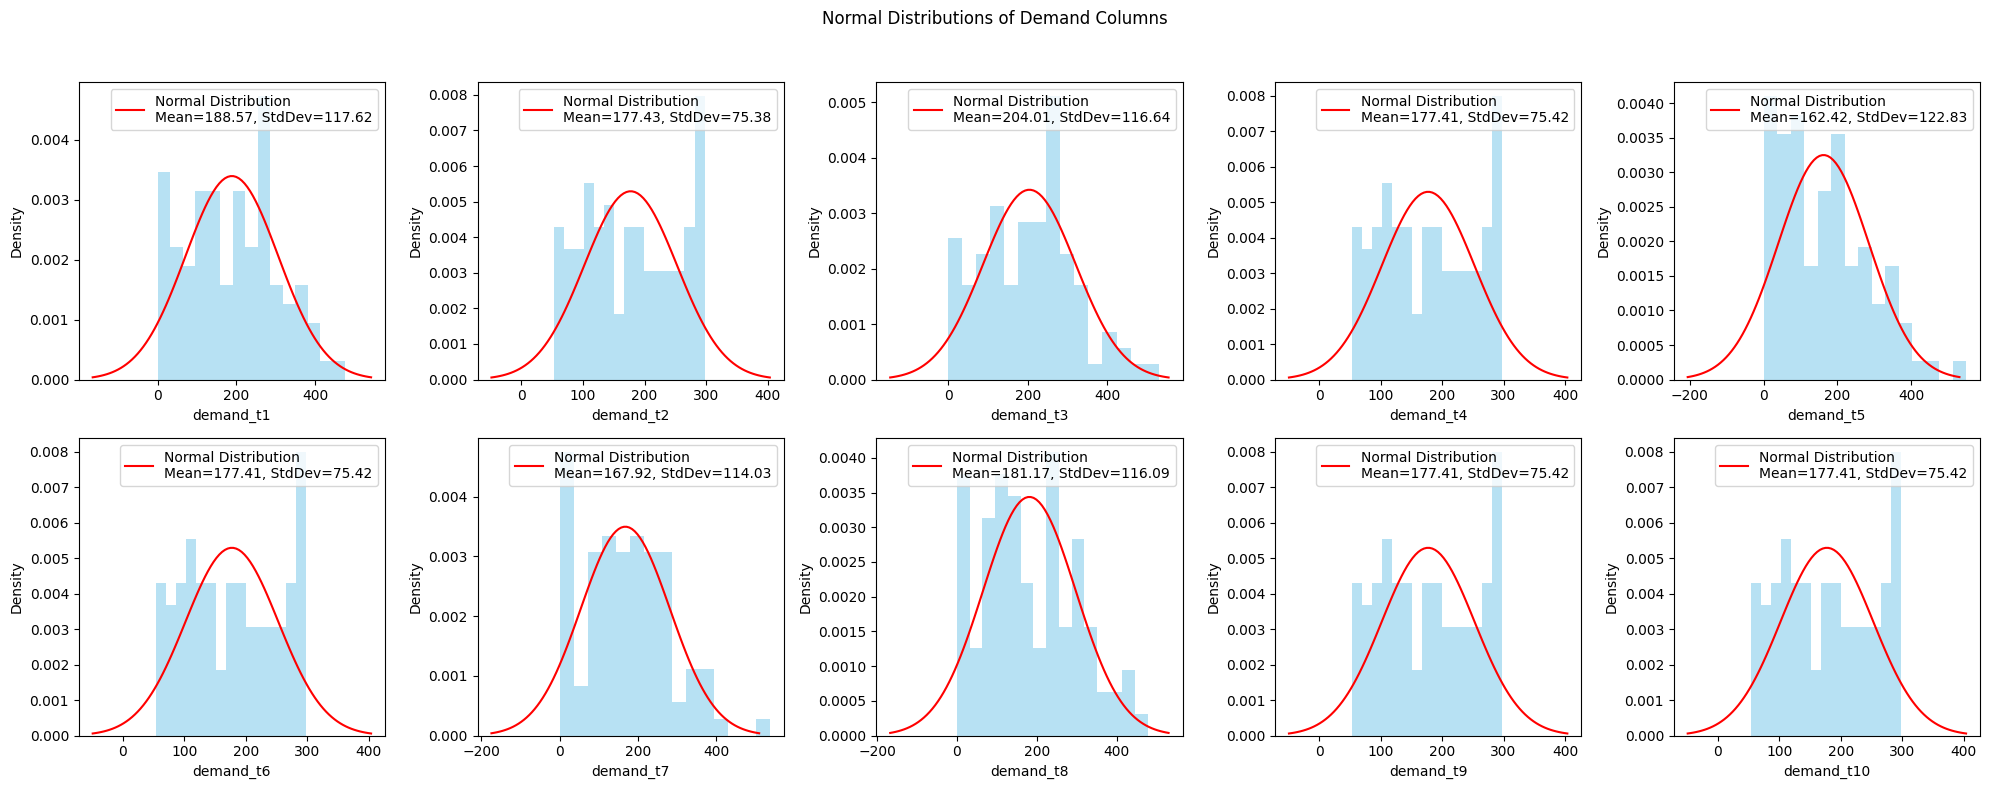

In [54]:
# 創建 2x5 的子圖網格
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
fig.suptitle("Normal Distributions of Demand Columns")

for idx, column in enumerate(demand_df.columns):
    data = demand_df[column].dropna()  # 移除缺失值
    mean, std_dev = np.mean(data), np.std(data)

    # 產生 x 值範圍
    x = np.linspace(mean - 3 * std_dev, mean + 3 * std_dev, 100)
    pdf = norm.pdf(x, mean, std_dev)

    # 確定當前的軸位置
    ax = axes[idx // 5, idx % 5]
    ax.hist(data, bins=15, density=True, alpha=0.6, color="skyblue")
    ax.plot(
        x,
        pdf,
        "r-",
        label=f"Normal Distribution\nMean={mean:.2f}, StdDev={std_dev:.2f}",
    )
    ax.set_xlabel(column)
    ax.set_ylabel("Density")
    ax.legend()

# 移除空白子圖（若有）
for idx in range(len(demand_df.columns), 10):
    fig.delaxes(axes[idx // 5, idx % 5])

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

### Validate the covariance


In [55]:
demand_df.cov()

demand_t1    demand_t2     demand_t3    demand_t4  \
demand_t1   13974.189072  5606.106059   9772.628981  5608.657755   
demand_t2    5606.106059  5739.834562   5241.796260  5742.725982   
demand_t3    9772.628981  5241.796260  13742.718874  5242.985481   
demand_t4    5608.657755  5742.725982   5242.985481  5745.661706   
demand_t5    2771.508136  6328.264035   2632.810554  6330.874600   
demand_t6    5608.657972  5742.726202   5242.985806  5745.661925   
demand_t7    3799.699775  5369.005761   -242.524951  5372.117555   
demand_t8    3059.696709  5849.019272   5589.176572  5850.755654   
demand_t9    5608.657755  5742.725983   5242.985483  5745.661707   
demand_t10   5608.657757  5742.725984   5242.985484  5745.661708   

               demand_t5    demand_t6     demand_t7     demand_t8  \
demand_t1    2771.508136  5608.657972   3799.699775   3059.696709   
demand_t2    6328.264035  5742.726202   5369.005761   5849.019272   
demand_t3    2632.810554  5242.985806   -242.524951   5589.176572   
demand_t4    6330.874600  5745.661925   5372.117555   5850.755654   
demand_t5   15239.700941  6330.874787   7777.350923   8713.737562   
demand_t6    6330.874787  5745.662144   5372.117650   5850.755964   
demand_t7    7777.350923  5372.117650  13133.900591   6489.731373   
demand_t8    8713.737562  5850.755964   6489.731373  13612.029108   
demand_t9    6330.874607  5745.661926   5372.117557   5850.755666   
demand_t10   6330.874607  5745.661926   5372.117558   5850.755667   

              demand_t9   demand_t10  
demand_t1   5608.657755  5608.657757  
demand_t2   5742.725983  5742.725984  
demand_t3   5242.985483  5242.985484  
demand_t4   5745.661707  5745.661708  
demand_t5   6330.874607  6330.874607  
demand_t6   5745.661926  5745.661926  
demand_t7   5372.117557  5372.117558  
demand_t8   5850.755666  5850.755667  
demand_t9   5745.661708  5745.661709  
demand_t10  5745.661709  5745.661709

In [56]:
empirical_covariance = demand_df.cov()
covariance_diff = np.abs(empirical_covariance - np.array(cov_matrices).mean(axis=0))
covariance_diff

demand_t1    demand_t2    demand_t3    demand_t4    demand_t5  \
demand_t1   3974.189072  5603.345076  4214.793597  5608.657755  6649.245065   
demand_t2   5603.345076  5739.764504  5236.763874  5742.725982  6332.425760   
demand_t3   4214.793597  5236.763874  3742.721122  5242.985481  6917.726707   
demand_t4   5608.657755  5742.725982  5242.985481  5745.661706  6330.874600   
demand_t5   6649.245065  6332.425760  6917.726707  6330.874600  5239.700941   
demand_t6   5608.658039  5742.726202  5242.985904  5745.661925  6330.874634   
demand_t7   4790.427796  5371.863064  5272.906497  5372.117555  4774.247517   
demand_t8   5819.112072  5848.456317  5483.551937  5850.755654  5773.563324   
demand_t9   5608.657758  5742.725983  5242.985485  5745.661707  6330.874607   
demand_t10  5608.657757  5742.725984  5242.985484  5745.661708  6330.874607   

              demand_t6    demand_t7    demand_t8    demand_t9   demand_t10  
demand_t1   5608.658039  4790.427796  5819.112072  5608.657758  5608.657757  
demand_t2   5742.726202  5371.863064  5848.456317  5742.725983  5742.725984  
demand_t3   5242.985904  5272.906497  5483.551937  5242.985485  5242.985484  
demand_t4   5745.661925  5372.117555  5850.755654  5745.661707  5745.661708  
demand_t5   6330.874634  4774.247517  5773.563324  6330.874607  6330.874607  
demand_t6   5745.662144  5372.117379  5850.755749  5745.661926  5745.661926  
demand_t7   5372.117379  3133.900591  6100.320598  5372.117558  5372.117558  
demand_t8   5850.755749  6100.320598  3612.183070  5850.755667  5850.755667  
demand_t9   5745.661926  5372.117558  5850.755667  5745.661708  5745.661709  
demand_t10  5745.661926  5372.117558  5850.755667  5745.661709  5745.661709

### Validate the corr matrix of damand_df is close to original setting


In [57]:
demand_df

demand_t1   demand_t2   demand_t3   demand_t4   demand_t5   demand_t6  \
0    42.534007  127.943454    0.000000  127.948970  366.862468  127.948970   
1   225.614664  224.085871  130.126631  224.085872  198.718647  224.085872   
2   341.013174  144.442777  231.753697  144.437960    0.000000  144.437960   
3   100.202696   94.972576   76.489864   94.900919    0.000000   94.900919   
4   208.492985   56.606974  269.573883   56.169682  160.039948   56.169670   
..         ...         ...         ...         ...         ...         ...   
95  109.113900  106.081184  124.957604  106.079257    0.000000  106.079257   
96  113.744958   74.448771   91.014361   74.461121   76.804032   74.461121   
97  401.372421  265.547879  228.542815  265.547880  274.548205  265.547879   
98  279.455060  293.229872  319.356575  293.229872  397.871895  293.229872   
99  319.102244  290.208664  256.446778  290.208665  347.142126  290.208665   

     demand_t7   demand_t8   demand_t9  demand_t10  
0   118.995864   73.267936  127.948970  127.948970  
1   258.873402   85.129200  224.085872  224.085872  
2     0.000000   17.934353  144.437960  144.437960  
3   220.701924  159.692529   94.900919   94.900919  
4     0.000000  137.604927   56.169682   56.169682  
..         ...         ...         ...         ...  
95    0.000000   16.396227  106.079257  106.079257  
96   77.909944    0.000000   74.461121   74.461121  
97  192.649849  139.333484  265.547879  265.547879  
98  321.351787  289.717083  293.229872  293.229872  
99  355.929601  319.224584  290.208665  290.208665  

[100 rows x 10 columns]

In [58]:
correlation_matrix = demand_df.corr()
print("Correlation Matrix from demand_df:")
correlation_matrix

Correlation Matrix from demand_df:


demand_t1  demand_t2  demand_t3  demand_t4  demand_t5  demand_t6  \
demand_t1    1.000000   0.625962   0.705199   0.625930   0.189917   0.625930   
demand_t2    0.625962   1.000000   0.590193   0.999996   0.676623   0.999996   
demand_t3    0.705199   0.590193   1.000000   0.590028   0.181926   0.590028   
demand_t4    0.625930   0.999996   0.590028   1.000000   0.676559   1.000000   
demand_t5    0.189917   0.676623   0.181926   0.676559   1.000000   0.676559   
demand_t6    0.625930   0.999996   0.590028   1.000000   0.676559   1.000000   
demand_t7    0.280472   0.618368  -0.018052   0.618413   0.549726   0.618413   
demand_t8    0.221847   0.661716   0.408649   0.661577   0.604999   0.661577   
demand_t9    0.625930   0.999996   0.590028   1.000000   0.676559   1.000000   
demand_t10   0.625930   0.999996   0.590028   1.000000   0.676559   1.000000   

            demand_t7  demand_t8  demand_t9  demand_t10  
demand_t1    0.280472   0.221847   0.625930    0.625930  
demand_t2    0.618368   0.661716   0.999996    0.999996  
demand_t3   -0.018052   0.408649   0.590028    0.590028  
demand_t4    0.618413   0.661577   1.000000    1.000000  
demand_t5    0.549726   0.604999   0.676559    0.676559  
demand_t6    0.618413   0.661577   1.000000    1.000000  
demand_t7    1.000000   0.485365   0.618413    0.618413  
demand_t8    0.485365   1.000000   0.661577    0.661577  
demand_t9    0.618413   0.661577   1.000000    1.000000  
demand_t10   0.618413   0.661577   1.000000    1.000000

In [59]:
print(f"Original corr_matrix shape: {corr_matrix.shape}")
corr_matrix_df = pd.DataFrame(corr_matrix)
corr_matrix_df

Original corr_matrix shape: (10, 10)


0         1         2         3         4         5         6  \
0  1.000000  0.354243  0.555784  0.587411 -0.387774 -0.161484 -0.099073   
1  0.354243  1.000000  0.645671  0.344249 -0.533962 -0.118714 -0.366601   
2  0.555784  0.645671  1.000000  0.259728 -0.428492 -0.236520 -0.551543   
3  0.587411  0.344249  0.259728  1.000000 -0.433716 -0.078962  0.166233   
4 -0.387774 -0.533962 -0.428492 -0.433716  1.000000  0.371399  0.300310   
5 -0.161484 -0.118714 -0.236520 -0.078962  0.371399  1.000000  0.658292   
6 -0.099073 -0.366601 -0.551543  0.166233  0.300310  0.658292  1.000000   
7 -0.275944  0.072230  0.010563 -0.631022  0.294020  0.520508  0.038941   
8 -0.488891  0.109958 -0.414246  0.089139 -0.153719 -0.341738 -0.009772   
9 -0.020925 -0.049126 -0.128709  0.244177 -0.108549  0.147419  0.485870   

          7         8         9  
0 -0.275944 -0.488891 -0.020925  
1  0.072230  0.109958 -0.049126  
2  0.010563 -0.414246 -0.128709  
3 -0.631022  0.089139  0.244177  
4  0.294020 -0.153719 -0.108549  
5  0.520508 -0.341738  0.147419  
6  0.038941 -0.009772  0.485870  
7  1.000000 -0.203659  0.130487  
8 -0.203659  1.000000  0.355112  
9  0.130487  0.355112  1.000000

### Split test and train demand_df


In [60]:
# def demand_data_split_data_k_fold(data, train_size, k_fold=2):
#     folds = []
#     for i in range(k_fold):
#         train_data, test_data = train_test_split(
#             data, train_size=train_size, random_state=i
#         )
#         test_data.reset_index(drop=True, inplace=True)
#         train_data.reset_index(drop=True, inplace=True)
#         folds.append((train_data, test_data))
#     return folds

In [61]:
def demand_data_split_data_k_fold(data, train_size):
    folds = []

    # 計算訓練集的大小
    train_len = int(len(data) * train_size)

    # 將資料切分為前半部分為訓練集，後半部分為測試集
    train_data = data.iloc[:train_len].reset_index(drop=True)
    test_data = data.iloc[train_len:].reset_index(drop=True)

    # 只需一個固定的切分，無需多次隨機分割
    folds.append((train_data, test_data))

    return folds

In [62]:
demand_folds = demand_data_split_data_k_fold(demand_df, train_size)

for i, (train, test) in enumerate(demand_folds):
    print(f"Fold {i + 1}:")
    print(f"Train size: {train.shape}, Test size: {test.shape}")
    print(f"train.head(): \n{train.head()}")
    print()

Fold 1:
Train size: (50, 10), Test size: (50, 10)
train.head(): 
    demand_t1   demand_t2   demand_t3   demand_t4   demand_t5   demand_t6  \
0   42.534007  127.943454    0.000000  127.948970  366.862468  127.948970   
1  225.614664  224.085871  130.126631  224.085872  198.718647  224.085872   
2  341.013174  144.442777  231.753697  144.437960    0.000000  144.437960   
3  100.202696   94.972576   76.489864   94.900919    0.000000   94.900919   
4  208.492985   56.606974  269.573883   56.169682  160.039948   56.169670   

    demand_t7   demand_t8   demand_t9  demand_t10  
0  118.995864   73.267936  127.948970  127.948970  
1  258.873402   85.129200  224.085872  224.085872  
2    0.000000   17.934353  144.437960  144.437960  
3  220.701924  159.692529   94.900919   94.900919  
4    0.000000  137.604927   56.169682   56.169682  



In [63]:
# # Only for testing
# demand_df_train = demand_df_test = demand_df

### Define the Q star(Q optimal)


In [64]:
def calculate_Q_star(demand_df, service_level=0.95):

    # 計算每一行的總和
    demand_sum = demand_df.sum(axis=1)

    # 計算總和的均值和標準差
    mean_sum = demand_sum.mean()
    std_sum = demand_sum.std()

    # 計算總和的95%百分位數值
    Q_star = norm.ppf(service_level, loc=mean_sum, scale=std_sum)

    # 打印結果
    print(f"mean of sum: {mean_sum}")
    print(f"std of sum: {std_sum}")
    print(f"{service_level*100} percentile of sum: {Q_star}")

    return Q_star

In [65]:
demand_folds

[(     demand_t1   demand_t2   demand_t3   demand_t4   demand_t5   demand_t6  \
  0    42.534007  127.943454    0.000000  127.948970  366.862468  127.948970   
  1   225.614664  224.085871  130.126631  224.085872  198.718647  224.085872   
  2   341.013174  144.442777  231.753697  144.437960    0.000000  144.437960   
  3   100.202696   94.972576   76.489864   94.900919    0.000000   94.900919   
  4   208.492985   56.606974  269.573883   56.169682  160.039948   56.169670   
  5   149.179656   67.138893  126.272490   66.812408    0.000000   66.812408   
  6   277.004556  219.848199  280.851086  219.848194   83.665747  219.848193   
  7    39.014013  163.424276   46.692366  163.424211  116.613336  163.424211   
  8   276.715260  184.144784  172.211307  184.144802    0.000000  184.144803   
  9   352.358955  274.167823  258.355160  274.167823  276.275008  274.167823   
  10  182.750445  297.584736  265.380547  297.584736  548.891814  297.584737   
  11   70.360044  104.060826    0.000000

In [66]:
# demand_df_train_1 = demand_folds[0][0]
# Q_star = calculate_Q_star(demand_df_train_1, service_level=0.95)
# print(f"Q_star: {Q_star}\n")

# demand_df_train_2 = demand_folds[1][0]
# Q_star = calculate_Q_star(demand_df_train_2, service_level=0.95)
# print(f"Q_star: {Q_star}\n")

demand_df_train_1 = demand_folds[0][0]
Q_star = calculate_Q_star(demand_df_train_1, service_level=0.95)
print(f"Q_star: {Q_star}\n")

mean of sum: 1670.7868029577896
std of sum: 681.9773100587362
95.0 percentile of sum: 2792.5396549065103
Q_star: 2792.5396549065103



## Data3: Qk hat df


### Functions


In [67]:
# 計算條件分佈的函數
def calculate_conditional_distribution(mu, covariance_matrix, x_observed, k):
    mu_1 = mu[:k]
    mu_2 = mu[k:]
    Sigma_11 = covariance_matrix[:k, :k]
    Sigma_22 = covariance_matrix[k:, k:]
    Sigma_12 = covariance_matrix[k:, :k]
    Sigma_21 = covariance_matrix[:k, k:]

    # Compute conditional mean and covariance
    Sigma_11_inv = np.linalg.pinv(Sigma_11)
    mu_cond = mu_2 + np.dot(Sigma_12, np.dot(Sigma_11_inv, (x_observed - mu_1)))
    sigma_cond = Sigma_22 - np.dot(Sigma_12, np.dot(Sigma_11_inv, Sigma_21))

    return mu_cond, sigma_cond

In [68]:
def cal_Var_Y(sigma_cond):

    # Extract the variances (diagonal elements)
    variances = np.diag(sigma_cond)

    # Calculate the sum of covariances (off-diagonal elements)
    covariances_sum = np.sum(sigma_cond) - np.sum(variances)

    # Total variance for the sum of mu_cond
    total_variance = np.sum(variances) + covariances_sum

    return total_variance

In [69]:
def cal_Qk_hat(mu_cond, sigma_cond, service_level, x_observed):
    # predict_quantity = mu_cond + norm.ppf(service_level) * np.sqrt(np.diag(sigma_cond))
    # Qk_hat = x_observed.sum() + predict_quantity.sum()

    mean_Y = np.sum(mu_cond)
    var_Y = cal_Var_Y(sigma_cond)

    sd_Y = np.sqrt(var_Y)
    if sd_Y < 0 or np.isnan(sd_Y):  # scale must be positive
        sd_Y = 1e-6

    percentile_95_Y = norm.ppf(service_level, loc=mean_Y, scale=sd_Y)

    # print(f"        mean_Y: {mean_Y}")
    # print(f"        sd_Y: {sd_Y}")
    # print(f"    percentile_95_Y: {percentile_95_Y}")

    Qk_hat = x_observed.sum() + percentile_95_Y
    return Qk_hat

In [70]:
def cal_mu_and_cov_matrix(demand_df_train):

    mu_matrix = demand_df_train.mean().values
    covariance_matrix = demand_df_train.cov().values

    # print(f"mu_matrix: {mu_matrix}")
    # print(f"covariance_matrix: \n{covariance_matrix}\n")

    return mu_matrix, covariance_matrix

In [71]:
def make_Qk_hat_df(demand_df, T, service_level, mu_matrix, covariance_matrix):
    results_df = pd.DataFrame(index=demand_df.index)

    for index, row_data in demand_df.iterrows():
        for k in range(2, T):
            # print(f"Now processing index: {index}, t={k}")

            x_observed = row_data[
                : k - 1
            ].values  # 取出前 k 個觀測值 -> Qk_hat_2(t=2): 則 observerd: T=1

            mu_cond, sigma_cond = calculate_conditional_distribution(
                mu_matrix, covariance_matrix, x_observed, len(x_observed)
            )

            Qk_hat = cal_Qk_hat(mu_cond, sigma_cond, service_level, x_observed)

            results_df.loc[index, f"Qk_hat_k{k}"] = Qk_hat

            # print(f"    x_observed: {x_observed}")
            # print(f"    mu_cond: {mu_cond}")
            # print(f"    sigma_cond: \n{sigma_cond}")
            # print(f"    Qk_hat: {Qk_hat}")
            # print("\n")

    return results_df

公式連結：https://jujueffectivelife.notion.site/Qk-eab4d89ec36345efbf3a0d4a4f488474?pvs=4


### Validate the consistency of condMVN in Python and R


#### Given mu and sigma


In [72]:
from scipy.stats import multivariate_normal

# Define the mean vector and the covariance matrix
mu = np.array([10, 20, 30, 40])
covariance_matrix = np.array([[5, 1, 0, 2], [1, 8, 1, 0], [0, 1, 10, 1], [2, 0, 1, 7]])

# Mean and covariance partitioning
mu_1 = mu[:2]
mu_2 = mu[2:]
Sigma_11 = covariance_matrix[:2, :2]
Sigma_22 = covariance_matrix[2:, 2:]
Sigma_12 = covariance_matrix[2:, :2]
Sigma_21 = covariance_matrix[:2, 2:]

print(f"Sigma_11: \n{Sigma_11}\n")
print(f"Sigma_22: \n{Sigma_22}\n")
print(f"Sigma_12: \n{Sigma_12}\n")
print(f"Sigma_21: \n{Sigma_21}\n")

Sigma_11: 
[[5 1]
 [1 8]]

Sigma_22: 
[[10  1]
 [ 1  7]]

Sigma_12: 
[[0 1]
 [2 0]]

Sigma_21: 
[[0 2]
 [1 0]]



In [73]:
# Observed values of X1 and X2
x_observed = np.array([6, 30])

mu_cond, sigma_cond = calculate_conditional_distribution(
    mu, covariance_matrix, x_observed, len(x_observed)
)
print(f"mu_cond: {mu_cond}")
print(f"sigma_cond: \n{sigma_cond}")

mu_cond: [31.38461538 37.84615385]
sigma_cond: 
[[9.87179487 1.05128205]
 [1.05128205 6.17948718]]


In [74]:
# Define the conditional distribution
conditional_dist = multivariate_normal(mean=mu_cond, cov=sigma_cond)

# Values at which to evaluate the PDF and CDF
x3, x4 = 30, 40  # These can be any values of interest

# Calculate the PDF
pdf_value = conditional_dist.pdf([x3, x4])
print(f"Conditional density at X3 = {x3}, X4 = {x4}: {pdf_value}")

# Calculate the CDF
cdf_value = conditional_dist.cdf([x3, x4])
print(f"Conditional cumulative probability up to X3 = {x3}, X4 = {x4}: {cdf_value}")

# Qk hat
Qk_hat = cal_Qk_hat(mu_cond, sigma_cond, service_level, x_observed)
print(f"Qk_hat of x_observed: {Qk_hat}")

Conditional density at X3 = 30, X4 = 40: 0.012061749355189695
Conditional cumulative probability up to X3 = 30, X4 = 40: 0.2790601403798458
Qk_hat of x_observed: 112.23905144741786


```
R 中運行的結果
```

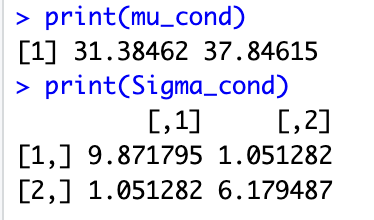
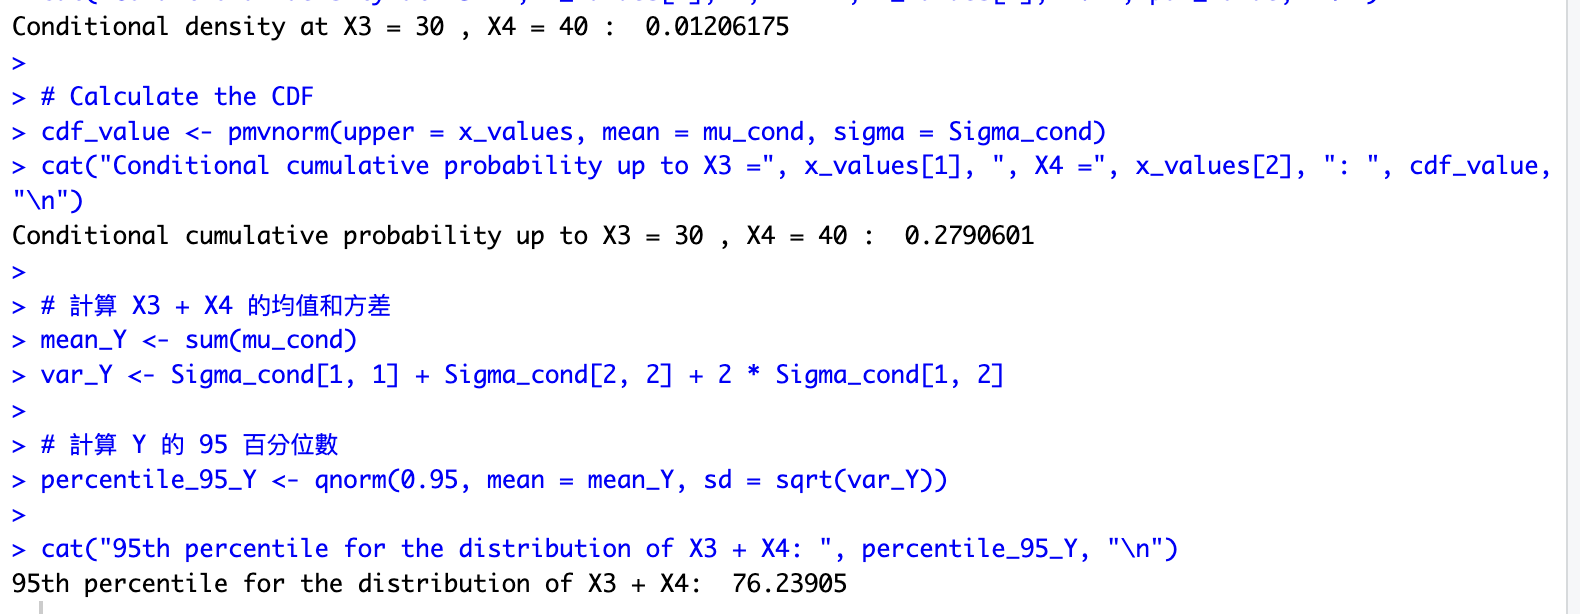


In [75]:
import matplotlib.pyplot as plt
from scipy.stats import norm

mean_Y = np.sum(mu_cond)
var_Y = cal_Var_Y(sigma_cond)

percentile_95_Y = norm.ppf(service_level, loc=mean_Y, scale=np.sqrt(var_Y))

# Generate normal distribution data
x_values = np.linspace(mean_Y - 4 * np.sqrt(var_Y), mean_Y + 4 * np.sqrt(var_Y), 1000)
y_values = norm.pdf(x_values, loc=mean_Y, scale=np.sqrt(var_Y))

# Create dataframe
data = pd.DataFrame({"x": x_values, "y": y_values})

# Plot distribution
plt.figure(figsize=(10, 6))
plt.plot(data["x"], data["y"], color="blue")
plt.axvline(x=percentile_95_Y, color="red", linestyle="dashed")
plt.fill_between(
    data["x"], data["y"], where=(data["x"] <= percentile_95_Y), color="red", alpha=0.3
)
plt.title("Distribution of X3 + X4")
plt.xlabel("Value")
plt.ylabel("Density")
plt.annotate(
    "95th Percentile",
    xy=(percentile_95_Y, max(y_values)),
    xytext=(percentile_95_Y, max(y_values) * 1.1),
    arrowprops=dict(facecolor="red", shrink=0.05),
    color="red",
    ha="center",
)
plt.show()

```
以下為 R 程式結果
```


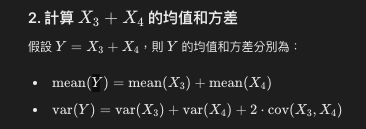


P(X3,X4∣X1=10,X2=20) 的 R 計算如下

```
install.packages("condMVNorm")
install.packages("mvtnorm")
library(condMVNorm)
library(mvtnorm)
library(ggplot2)

# Define the mean vector and covariance matrix
mu <- c(10, 20, 30, 40)
sigma <- matrix(c(
    5, 1, 0, 2,
    1, 8, 1, 0,
    0, 1, 10, 1,
    2, 0, 1, 7
), nrow = 4, byrow = TRUE)

# Observed values of X1 and X2
x_observed <- c(6, 30)

# Compute the conditional mean and covariance using condMVNorm
conditional_results <- condMVN(mean = mu, sigma = sigma, dependent.ind = c(3, 4), given.ind = c(1, 2), X.given = x_observed)

# Print the conditional mean and covariance
print(conditional_results$condMean)
print(conditional_results$condVar)

# Extract the conditional mean and covariance
mu_cond <- conditional_results$condMean
Sigma_cond <- conditional_results$condVar

# Print the conditional mean and covariance
print(mu_cond)
print(Sigma_cond)

# Values at which to evaluate the PDF and CDF
x_values <- c(30, 40)

# Calculate the PDF
pdf_value <- dmvnorm(x_values, mean = mu_cond, sigma = Sigma_cond)
cat("Conditional density at X3 =", x_values[1], ", X4 =", x_values[2], ": ", pdf_value, "\n")

# Calculate the CDF
cdf_value <- pmvnorm(upper = x_values, mean = mu_cond, sigma = Sigma_cond)
cat("Conditional cumulative probability up to X3 =", x_values[1], ", X4 =", x_values[2], ": ", cdf_value, "\n")

```


#### Conditional mean and variance


In [76]:
def cal_Var_Y(sigma_cond):
    variances = np.diag(sigma_cond)
    covariances_sum = np.sum(sigma_cond) - np.sum(variances)
    total_variance = np.sum(variances) + covariances_sum

    return total_variance


def simulate_Y(mu_cond, sigma_cond, num_samples=10000):
    samples = np.random.multivariate_normal(mu_cond, sigma_cond, num_samples)

    Y = samples[:, 0] + samples[:, 1]

    mean_Y = np.mean(Y)
    var_Y = np.var(Y)

    return mean_Y, var_Y


mu_cond = [2, 3]
sigma_cond = [[1, 0.5], [0.5, 1]]

mean_Y_formula = np.sum(mu_cond)
var_Y_formula = cal_Var_Y(sigma_cond)

mean_Y_simulated, var_Y_simulated = simulate_Y(mu_cond, sigma_cond)

print(f"公式計算的Y的均值: {mean_Y_formula}")
print(f"公式計算的Y的方差: {var_Y_formula}")
print(f"模擬計算的Y的均值: {mean_Y_simulated}")
print(f"模擬計算的Y的方差: {var_Y_simulated}")

公式計算的Y的均值: 5
公式計算的Y的方差: 3.0
模擬計算的Y的均值: 5.011044263785324
模擬計算的Y的方差: 2.971568550026781


### Calculate Qk hat for 2~T-1 of demand_df_train


In [77]:
demand_df_train = demand_folds[0][0]

In [78]:
_, _ = cal_mu_and_cov_matrix(demand_df_train)

In [79]:
mu_matrix, covariance_matrix = cal_mu_and_cov_matrix(demand_df)
Qk_hat_df = make_Qk_hat_df(demand_df, T, service_level, mu_matrix, covariance_matrix)

/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_46724/3639980328.py:8: RuntimeWarning: invalid value encountered in sqrt
  sd_Y = np.sqrt(var_Y)
/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_46724/3639980328.py:8: RuntimeWarning: invalid value encountered in sqrt
  sd_Y = np.sqrt(var_Y)
/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_46724/3639980328.py:8: RuntimeWarning: invalid value encountered in sqrt
  sd_Y = np.sqrt(var_Y)
/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_46724/3639980328.py:8: RuntimeWarning: invalid value encountered in sqrt
  sd_Y = np.sqrt(var_Y)
/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_46724/3639980328.py:8: RuntimeWarning: invalid value encountered in sqrt
  sd_Y = np.sqrt(var_Y)
/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_46724/3639980328.py:8: RuntimeWarning: invalid value encountered in sqrt
  sd_Y = np.sqrt(var_Y)
/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_46724

In [80]:
Qk_hat_df

Qk_hat_k2    Qk_hat_k3    Qk_hat_k4    Qk_hat_k5    Qk_hat_k6  \
0   2091.512884  1500.117103  1454.669200  1452.338655  1644.324688   
1   2896.177252  2515.849742  2467.898819  2468.338020  2349.757726   
2   3403.369381  1851.784828  1830.255992  1827.765727  1685.351951   
3   2344.974609  1231.777306  1208.438757  1208.540324  1034.265410   
4   2820.925143   946.882987   980.677202   997.240995  1188.565118   
..          ...          ...          ...          ...          ...   
95  2384.140560  1341.008109  1332.840669  1329.133183  1150.271054   
96  2404.494691  1049.894125  1032.286835  1027.185742  1005.164392   
97  3668.656476  3018.177565  2965.025287  2966.484261  2952.684281   
98  3132.813108  3194.661878  3198.167619  3199.036283  3266.055703   
99  3307.067870  3192.893550  3164.245061  3165.857541  3171.889158   

      Qk_hat_k7    Qk_hat_k8    Qk_hat_k9  
0   1641.969056  1435.318759  1241.604866  
1   2347.528938  2239.152389  2018.743777  
2   1682.581302  1436.817427  1312.688115  
3   1030.113799  1095.323345  1032.060616  
4   1185.480420  1136.048182  1057.539530  
..          ...          ...          ...  
95  1148.636159   939.435638   781.412790  
96  1002.759319   915.343626   731.765264  
97  2949.900812  2711.645370  2564.098163  
98  3263.035002  3257.789202  3073.016844  
99  3169.630162  3148.839121  3048.731160  

[100 rows x 8 columns]

### Plot the distribuction


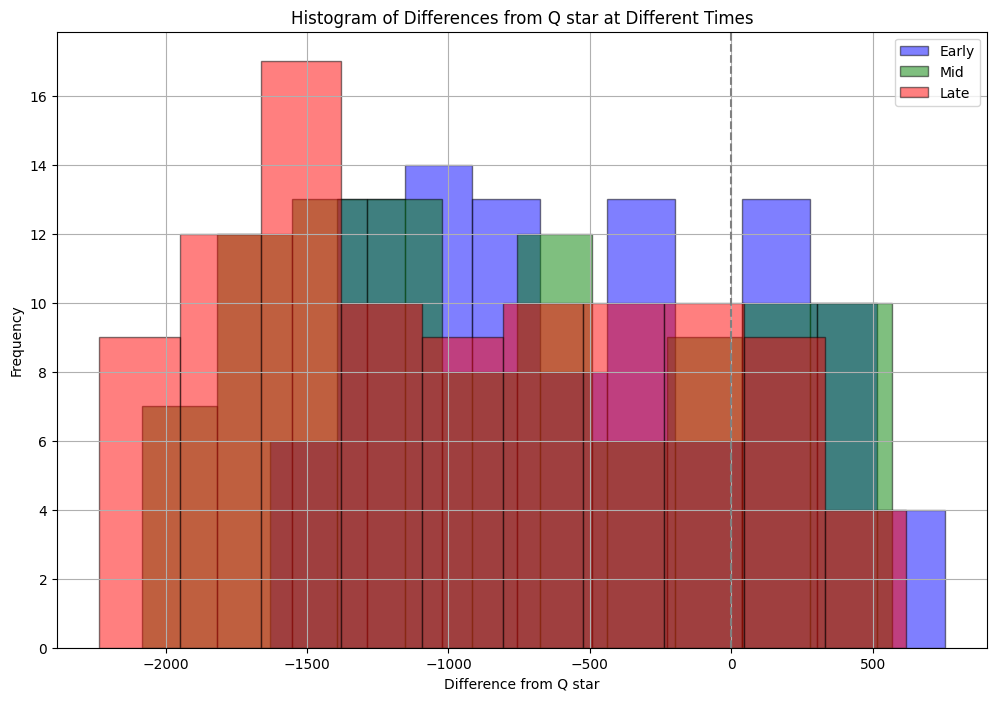

Q_star is: 2792.5396549065103
Early bias: -511.4511194355831
Mid bias: -784.9885482145872
Late bias: -940.9299091585665


In [81]:
# 將 T 個時期分成三份
early_values = Qk_hat_df.iloc[:, : T // 3].mean(axis=1)
mid_values = Qk_hat_df.iloc[:, T // 3 : 2 * T // 3].mean(axis=1)
late_values = Qk_hat_df.iloc[:, 2 * T // 3 :].mean(axis=1)

# 計算與 Q_star 的差距
early_diff = early_values - Q_star
mid_diff = mid_values - Q_star
late_diff = late_values - Q_star

# 繪製直方圖
plt.figure(figsize=(12, 8))

# 早期
plt.hist(early_diff, bins=10, alpha=0.5, label="Early", color="blue", edgecolor="black")
# 中期
plt.hist(mid_diff, bins=10, alpha=0.5, label="Mid", color="green", edgecolor="black")
# 晚期
plt.hist(late_diff, bins=10, alpha=0.5, label="Late", color="red", edgecolor="black")

plt.axvline(0, color="grey", linestyle="--")

plt.xlabel("Difference from Q star")
plt.ylabel("Frequency")
plt.title("Histogram of Differences from Q star at Different Times")
plt.legend()
plt.grid(True)
plt.show()

# 計算偏差
early_bias = np.mean(early_diff)
mid_bias = np.mean(mid_diff)
late_bias = np.mean(late_diff)

print(f"Q_star is: {Q_star}")
print(f"Early bias: {early_bias}")
print(f"Mid bias: {mid_bias}")
print(f"Late bias: {late_bias}")

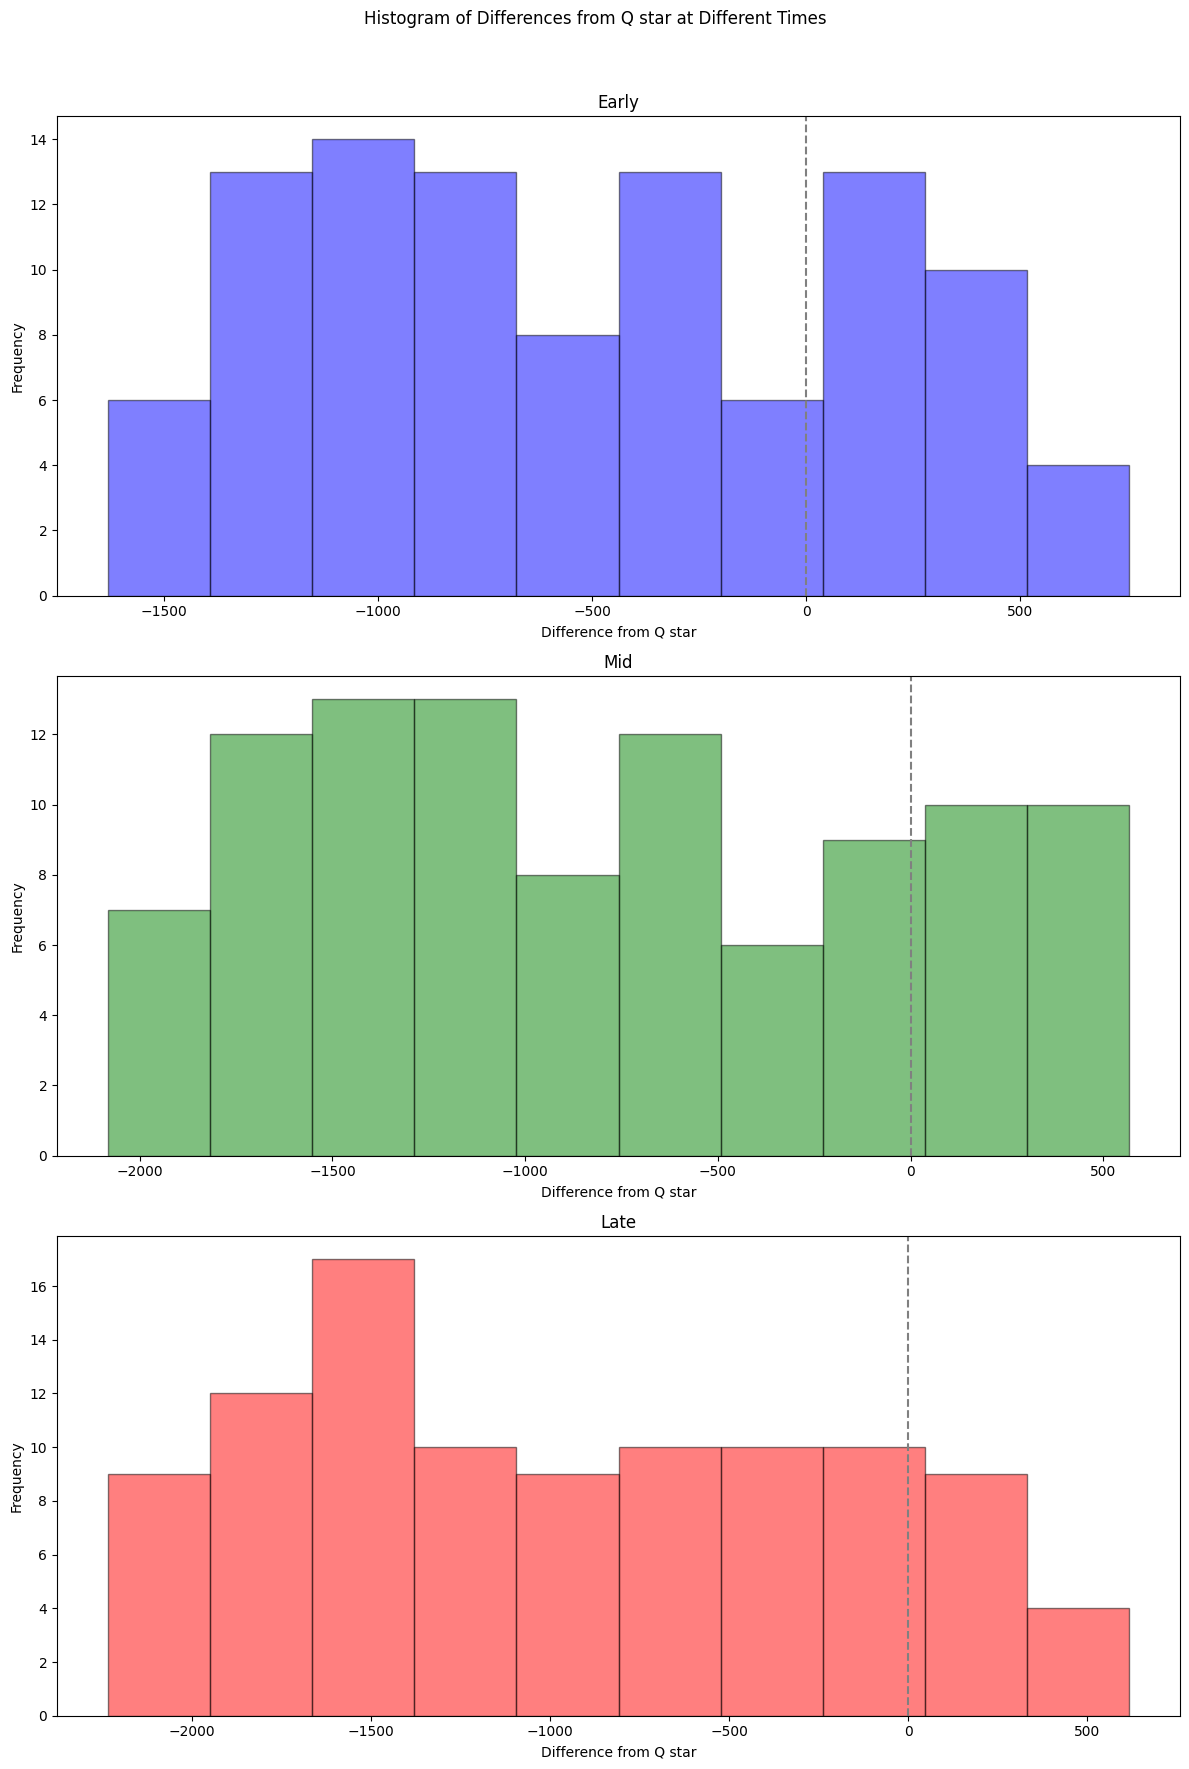

In [82]:
# 繪製直方圖
fig, axes = plt.subplots(3, 1, figsize=(12, 18))

# 早期
axes[0].hist(early_diff, bins=10, alpha=0.5, color="blue", edgecolor="black")
axes[0].axvline(0, color="grey", linestyle="--")
axes[0].set_title("Early")
axes[0].set_xlabel("Difference from Q star")
axes[0].set_ylabel("Frequency")

# 中期
axes[1].hist(mid_diff, bins=10, alpha=0.5, color="green", edgecolor="black")
axes[1].axvline(0, color="grey", linestyle="--")
axes[1].set_title("Mid")
axes[1].set_xlabel("Difference from Q star")
axes[1].set_ylabel("Frequency")

# 晚期
axes[2].hist(late_diff, bins=10, alpha=0.5, color="red", edgecolor="black")
axes[2].axvline(0, color="grey", linestyle="--")
axes[2].set_title("Late")
axes[2].set_xlabel("Difference from Q star")
axes[2].set_ylabel("Frequency")

fig.suptitle("Histogram of Differences from Q star at Different Times")
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# Strategies utils


## Validation

### Validate the r and R

In [83]:
# import gurobipy as gp
# from gurobipy import GRB

# # 初始化模型
# # model = gp.Model("Test_r_R_relationship")
# model = gp.Model(env=env)

# # 設定參數
# K = 4  # 候選數量
# i = 0  # 單個 i 的例子

# # 定義變數
# r_vars = model.addVars(K, lb=0.0, ub=1.0, name="r_vars")  # r_{i,k}
# R_vars = model.addVars(K, vtype=GRB.BINARY, name="R_vars")  # R_{i,k}
# max_r_helper = model.addVar(lb=0.0, ub=1.0, name="max_r_helper")  # 最大值輔助變數

# # 假設 exp_tau_vars 是已知的輸入數值
# exp_tau_vars = [0.1, 0.3, 0.5, 0.2]  # 例子數值

# # 限制式 1: 定義 r_vars 與 exp_tau_vars 的關係
# for k in range(K):
#     model.addConstr(
#         r_vars[k] * sum(exp_tau_vars) == exp_tau_vars[k],
#         name=f"softmax_relation_{k}",
#     )

# # 限制式 2: 確保 r_vars 的加總為 1
# model.addConstr(gp.quicksum(r_vars[k] for k in range(K)) == 1, name="sum_r_constraint")

# # 限制式 3: 找出 r_vars 中的最大值
# model.addGenConstrMax(
#     max_r_helper, [r_vars[k] for k in range(K)], name="max_r_constraint"
# )

# # 限制式 4: 確保 R_vars 對應到最大值
# for k in range(K):
#     model.addGenConstrIndicator(
#         R_vars[k], 1, r_vars[k] == max_r_helper, name=f"indicator_R_{k}"
#     )

# # 限制式 5: 確保僅有一個 R_vars[k] 為 1
# model.addConstr(
#     gp.quicksum(R_vars[k] for k in range(K)) == 1, name="unique_R_constraint"
# )

# # 設定目標函數（範例：最大化 max_r_helper）
# model.setObjective(max_r_helper, GRB.MAXIMIZE)

# # 求解模型
# model.optimize()

# # 輸出結果
# if model.Status == GRB.OPTIMAL:
#     print("Optimal solution found!")
#     print(f"max_r_helper: {max_r_helper.X}")
#     print("r_vars:")
#     for k in range(K):
#         print(f"  r_vars[{k}]: {r_vars[k].X}")
#     print("R_vars:")
#     for k in range(K):
#         print(f"  R_vars[{k}]: {R_vars[k].X}")
# else:
#     print("No optimal solution found.")

檢驗結果：目前的寫法可以成功讓 r 與 R 的關係實現



## S0 - One-time Procurement


In [84]:
def one_time_procurement(Q_star, demand_df, cost, price, salvage_value):

    all_losses = []
    all_lefts = []
    all_operation_profits = []
    all_profits = []

    for i, row in demand_df.iterrows():
        inventory = Q_star
        losses = []
        lefts = []
        daily_operation_profits = []
        daily_profits = []
        total_sold = 0  # 追蹤總售出量
        total_lost = 0  # 追蹤總丟失量

        print("=" * 50)
        print(
            f"Processing row {i+1}/{len(demand_df)} with initial inventory Q_star={Q_star}"
        )
        print("=" * 50)

        for day, demand in enumerate(row):
            sales = min(inventory, demand)
            loss = max(demand - inventory, 0)
            left = max(inventory - sales, 0)
            total_sold += sales
            total_lost += loss

            inventory -= sales

            print("-" * 50)
            print(f"Day {day+1}")
            print(f"Demand      : {demand}")
            print(f"Sales       : {sales}")
            print(f"Loss        : {loss}")
            print(f"Left        : {left}")
            print(f"Inventory   : {inventory}")
            print("-" * 50)

            if day == len(row) - 1:
                left_penalty_cost = (cost - salvage_value) * left
                lefts.append(left)
                print(f"End of period: Left Penalty Cost = {left_penalty_cost}")
                print("-" * 50)
            else:
                left_penalty_cost = 0

        operation_profit = (price - cost) * total_sold
        profit = operation_profit - left_penalty_cost - (price - cost) * total_lost

        print("=" * 50)
        print(f"Row {i+1} Summary")
        print(f"Total Sold         : {total_sold}")
        print(f"Total Lost         : {total_lost}")
        print(f"Operation Profit   : {operation_profit}")
        print(f"Profit             : {profit}")
        print("=" * 50)

        all_losses.append(total_lost)
        all_lefts.append(sum(lefts))
        all_operation_profits.append(operation_profit)
        all_profits.append(profit)

    avg_losses = np.mean(all_losses)
    avg_lefts = np.mean(all_lefts)
    avg_operation_profits = np.mean(all_operation_profits)
    avg_profits = np.mean(all_profits)

    print("=" * 50)
    print("Overall Summary")
    print(f"Average Losses           : {avg_losses}")
    print(f"Average Lefts            : {avg_lefts}")
    print(f"Average Operation Profits: {avg_operation_profits}")
    print(f"Average Profits          : {avg_profits}")
    print("=" * 50)

    stimulation_df = pd.DataFrame(
        {
            "losses": all_losses,
            "lefts": all_lefts,
            "operation_profits": all_operation_profits,
            "profits": all_profits,
        }
    )

    return avg_losses, avg_lefts, avg_profits, avg_operation_profits, stimulation_df

## S1 - Grid for Fixed F & Fixed Rk


In [85]:
def cal_fixed_F_fixed_R(
    Q_star, assigned_F, assigned_R, demand_df, cost, price, salvage_value, Qk_hat_df
):
    all_losses = []
    all_lefts = []
    all_left0s = []
    all_left1s = []
    all_operation_profits = []
    all_profits = []
    all_q0s = []
    all_q1s = []

    Q0 = assigned_F * Q_star  # 期初庫存

    print(f"\n")
    print(f"====" * 10)
    print(f"\n")

    for i, row in demand_df.iterrows():

        # 第一階段計算
        total_sold_0 = min(Q0, row[: assigned_R + 1].sum())  # 第一階段售出量
        left_0 = max(Q0 - total_sold_0, 0)  # 第一階段剩餘
        lost_0 = max(row[: assigned_R + 1].sum() - Q0, 0)

        # 第二階段開始補貨，根據指定的 R
        Qk_hat = Qk_hat_df.iloc[i, assigned_R]
        Q1 = max((Qk_hat - Q0), 0)  # 二次訂貨量
        total_sold_1 = min(Q1 + left_0, row[assigned_R + 1 :].sum())  # 第二階段售出量
        left_1 = max((Q1 + left_0) - total_sold_1, 0)  # 第二階段剩餘
        lost_1 = max(row[assigned_R + 1 :].sum() - (Q1 + left_0), 0)

        # 統計
        total_sold = total_sold_0 + total_sold_1
        total_lost = lost_0 + lost_1

        # 計算運營利潤和總利潤
        operation_profit = (price - cost) * total_sold
        left_penalty_cost = (cost - salvage_value) * left_1
        lost_penalty_cost = (price - cost) * total_lost
        profit = operation_profit - left_penalty_cost - lost_penalty_cost

        all_losses.append(total_lost)
        all_lefts.append(left_1)
        all_operation_profits.append(operation_profit)
        all_profits.append(profit)
        all_q0s.append(Q0)
        all_q1s.append(Q1)
        all_left0s.append(left_0)
        all_left1s.append(left_1)

        print(f"這是第 {i+1} 筆模擬資料\n")
        print(f"F: {assigned_F}, R: {assigned_R+2}")
        print(f"Q_star 為 {Q_star}")
        print(f"期初庫存 Q0: {Q0}")
        print(f"重新估計量 Qk_hat: {Qk_hat}")
        print(f"訂貨量 Q1 為 {Q1}\n")

        print(
            f"第一階段：期初庫存 Q0: {Q0}，需求量為 {row[:assigned_R + 1].sum()}，Sold_0 為 {total_sold_0}，Left_0 為 {left_0}，Lost_0 為 {lost_0}"
        )
        print(
            f"第二階段：期初庫存 Q1+left_0 為 {Q1+left_0}，需求量為 {row[assigned_R + 1:].sum()}，Sold_1 為 {total_sold_1}，Left_1 為 {left_1}，Lost_1 為 {lost_1}\n"
        )
        print(
            f"統計結果：Sold 為 {total_sold}, Lost 為 {total_lost} Left_Penalty_Cost 為 {left_penalty_cost}，Lost_Penalty_Cost 為 {lost_penalty_cost}，Profit 為 {profit}"
        )
        print("----" * 10)

    result_df = {
        "R(T)": assigned_R + 2,
        "F": assigned_F,
        "Q0": all_q0s,
        "Q1": all_q1s,
        "average_profits": np.mean(all_profits),
        "average_losses": np.mean(all_losses),
        "average_lefts": np.mean(all_lefts),
        "average_operation_profits": np.mean(all_operation_profits),
    }

    stimulation_result = {
        "R(T)": assigned_R + 2,
        "F": assigned_F,
        "profits": all_profits,
        "losses": all_losses,
        "lefts": all_lefts,
        "Left0s": all_left0s,
        "Left1s": all_left1s,
        "operation_profits": all_operation_profits,
        "Q0": all_q0s,
        "Q1": all_q1s,
    }

    return result_df, stimulation_result

In [86]:
def grid_fixed_F_fixed_R(
    assigned_Ts,
    assigned_Fs,
    cost,
    price,
    salvage_value,
    Qk_hat_df,
    demand_df_train,
    Q_star,
):

    results_list = []
    max_profit = None
    max_profit_stimulation_result = {}

    for assigned_T in assigned_Ts:
        for assigned_F in assigned_Fs:
            assigned_R = assigned_T - 2
            mean_result, stimulation_result = cal_fixed_F_fixed_R(
                Q_star,
                assigned_F,
                assigned_R,
                demand_df_train,
                cost,
                price,
                salvage_value,
                Qk_hat_df,
            )
            results_list.append(mean_result)

            if max_profit is None or max_profit < mean_result["average_profits"]:
                print(
                    f"max_profit is changed from {max_profit} to {mean_result['average_profits']}"
                )
                max_profit = mean_result["average_profits"]
                max_profit_stimulation_result = stimulation_result

    results_df_1 = pd.DataFrame(results_list).sort_values(
        by="average_profits", ascending=False
    )

    return results_df_1, pd.DataFrame(max_profit_stimulation_result)

## S8 - Grid for Fixed F & Fixed Rk(with holding cost)


In [87]:
def cal_fixed_F_fixed_R_with_holding_cost(
    Q_star,
    assigned_F,
    assigned_R,
    demand_df,
    cost,
    price,
    salvage_value,
    Qk_hat_df,
    holding_cost,
):
    all_losses = []
    all_lefts = []
    all_operation_profits = []
    all_profits = []
    all_q0s = []
    all_q1s = []
    all_holding_costs_0 = []
    all_holding_costs_1 = []
    all_left0s = []
    all_left1s = []
    all_lost0s = []
    all_lost1s = []

    Q0 = assigned_F * Q_star  # 期初庫存

    print(f"\n")
    print(f"====" * 10)
    print(f"\n")

    for i, row in demand_df.iterrows():

        # 第一階段計算
        total_sold_0 = min(Q0, row[: assigned_R + 1].sum())  # 第一階段售出量
        left_0 = max(Q0 - total_sold_0, 0)  # 第一階段剩餘
        lost_0 = max(row[: assigned_R + 1].sum() - Q0, 0)

        # 第二階段開始補貨，根據指定的 R
        Qk_hat = Qk_hat_df.iloc[i, assigned_R]
        Q1 = max((Qk_hat - Q0), 0)  # 二次訂貨量
        total_sold_1 = min(Q1 + left_0, row[assigned_R + 1 :].sum())  # 第二階段售出量
        left_1 = max((Q1 + left_0) - total_sold_1, 0)  # 第二階段剩餘
        lost_1 = max(row[assigned_R + 1 :].sum() - (Q1 + left_0), 0)

        # 統計
        total_sold = total_sold_0 + total_sold_1
        total_lost = lost_0 + lost_1

        # 計算 holding_cost
        """
        今天 T = 10, 假設 R = 5 (此時 assigned_R=3), 此時:
        第一階段是 T=1~4 -> 高為 R-1 = (assigned_R+2) - 1
        第二階段是 T=5~10 -> 高為 T - R = T - (assigned_R+2)
        """

        first_holding_cost = (Q0 + left_0 + Q1) * ((assigned_R + 2) - 1) / 2
        # T = 1 ~ R+1, R+1 才是代表 R(T)
        second_holding_cost = (Q1 + left_0 + left_1) * (T - (assigned_R + 2)) / 2
        # T = R+1 ~ T
        holding_penalty = holding_cost * (first_holding_cost + second_holding_cost)

        # 計算運營利潤和總利潤
        operation_profit = (price - cost) * total_sold
        left_penalty_cost = (cost - salvage_value) * left_1
        lost_penalty_cost = (price - cost) * total_lost
        profit = (
            operation_profit - left_penalty_cost - lost_penalty_cost - holding_penalty
        )

        all_losses.append(total_lost)
        all_lefts.append(left_1)
        all_operation_profits.append(operation_profit)
        all_profits.append(profit)
        all_q0s.append(Q0)
        all_q1s.append(Q1)
        all_holding_costs_0.append(first_holding_cost)
        all_holding_costs_1.append(second_holding_cost)
        all_left0s.append(left_0)
        all_left1s.append(left_1)
        all_lost0s.append(lost_0)
        all_lost1s.append(lost_1)

        # print(f"這是第 {i+1} 筆模擬資料\n")
        # print(f"F: {assigned_F}, R: {assigned_R+2}")
        # print(f"Q_star 為 {Q_star}")
        # print(f"期初庫存 Q0: {Q0}")
        # print(f"重新估計量 Qk_hat: {Qk_hat}")
        # print(f"訂貨量 Q1 為 {Q1}\n")

        # print(
        #     f"第一階段：期初庫存 Q0: {Q0}，需求量為 {row[:assigned_R + 1].sum()}，Sold_0 為 {total_sold_0}，Left_0 為 {left_0}，Lost_0 為 {lost_0}, first_holding_cost 為 {first_holding_cost}"
        # )
        # print(
        #     f"第二階段：期初庫存 Q1+left_0 為 {Q1+left_0}，需求量為 {row[assigned_R + 1:].sum()}，Sold_1 為 {total_sold_1}，Left_1 為 {left_1}，Lost_1 為 {lost_1}, second_holding_cost 為 {second_holding_cost}\n"
        # )
        # print(
        #     f"統計結果：Sold 為 {total_sold}, Lost 為 {total_lost} Left_Penalty_Cost 為 {left_penalty_cost}，Lost_Penalty_Cost 為 {lost_penalty_cost}，holding_penalty 為 {holding_penalty}，Profit 為 {profit}"
        # )
        # print("----" * 10)

    result_df = {
        "R(T)": assigned_R + 2,
        "F": assigned_F,
        "Q0": all_q0s,
        "Q1": all_q1s,
        "average_profits": np.mean(all_profits),
        "average_losses": np.mean(all_losses),
        "average_lefts": np.mean(all_lefts),
        "average_operation_profits": np.mean(all_operation_profits),
    }

    stimulation_result = {
        "R(T)": assigned_R + 2,
        "F": assigned_F,
        "profits": all_profits,
        "losses": all_losses,
        "lefts": all_lefts,
        "operation_profits": all_operation_profits,
        "Q0": all_q0s,
        "Q1": all_q1s,
        "hc0": all_holding_costs_0,
        "hc1": all_holding_costs_1,
        "Left0s": all_left0s,
        "Left1s": all_left1s,
        "lost0s": all_lost0s,
        "lost1s": all_lost1s,
    }

    return result_df, stimulation_result

In [88]:
def grid_fixed_F_fixed_R_with_holding_cost(
    assigned_Ts,
    assigned_Fs,
    cost,
    price,
    salvage_value,
    holding_cost,
    Qk_hat_df,
    demand_df_train,
    Q_star,
):

    results_list = []
    max_profit = None
    max_profit_stimulation_result = {}

    for assigned_T in assigned_Ts:
        for assigned_F in assigned_Fs:
            assigned_R = assigned_T - 2
            mean_result, stimulation_result = cal_fixed_F_fixed_R_with_holding_cost(
                Q_star,
                assigned_F,
                assigned_R,
                demand_df_train,
                cost,
                price,
                salvage_value,
                Qk_hat_df,
                holding_cost,
            )
            results_list.append(mean_result)

            if max_profit is None or max_profit < mean_result["average_profits"]:
                print(
                    f"max_profit is changed from {max_profit} to {mean_result['average_profits']}"
                )
                max_profit = mean_result["average_profits"]
                max_profit_stimulation_result = stimulation_result

    results_df_1 = pd.DataFrame(results_list).sort_values(
        by="average_profits", ascending=False
    )

    return results_df_1, pd.DataFrame(max_profit_stimulation_result)

## S2 - Grid for Fixed Rk & Flexible F


In [89]:
def cal_flexible_F_fixed_R(
    assigned_R,
    salvage_value,
    cost,
    price,
    Q_star,
    demand_df_train,
    Qk_hat_df,
    training_df,
):
    print(
        f"+++++++++++++++++++++++++++++++++++++++ THis is R={assigned_R} +++++++++++++++++++++++++++++++++++++++++++++++++"
    )
    with gp.Model("profit_maximization", env=env) as model:
        model.setParam("OutputFlag", True)
        model.setParam("Threads", THREADS)
        model.setParam("MIPGap", MIPGAP)
        model.setParam("TimeLimit", TIME_LIMIT)

        # ======================= Decision Variables =======================
        alphas = model.addVars(
            features_num + 1, lb=-GRB.INFINITY, ub=GRB.INFINITY, name="alphas"
        )
        Sold_0s = model.addVars(len(demand_df_train), lb=0.0, name="Sold_0")
        Sold_1s = model.addVars(len(demand_df_train), lb=0.0, name="Sold_1")
        Lost_0s = model.addVars(len(demand_df_train), lb=0.0, name="Lost_0")
        Lost_1s = model.addVars(len(demand_df_train), lb=0.0, name="Lost_1")
        Left_1s = model.addVars(len(demand_df_train), lb=0.0, name="Left_1")

        f_vars = model.addVars(
            len(demand_df_train), lb=-GRB.INFINITY, ub=GRB.INFINITY, name="f_var"
        )
        F_vars = model.addVars(len(demand_df_train), lb=0, ub=1, name="Fraction")

        Q0_vars = model.addVars(
            len(demand_df_train), lb=0.0, ub=(Q_star + 1), name="Q0_var"
        )
        Q1_vars = model.addVars(len(Qk_hat_df), lb=0.0, name="Q1_var")

        profits_vars = model.addVars(
            len(demand_df_train), lb=-GRB.INFINITY, name="profits_vars"
        )

        # ======================= Model Constraints =======================
        for i, row in demand_df_train.iterrows():
            demand_row = demand_df_train.iloc[i]
            Qk_hat_df_row = Qk_hat_df.iloc[i].tolist()
            X_data = training_df.iloc[i].tolist()
            X_data.append(1)

            model.addConstr(F_vars[i] >= 0, name=f"Fraction_lower_bound_{i}")
            model.addConstr(F_vars[i] <= 1, name=f"Fraction_upper_bound_{i}")

            # Calculate F using logistic regression
            model.addConstr(
                f_vars[i]
                == gp.quicksum(X_data[j] * alphas[j] for j in range(features_num + 1))
            )
            model.addGenConstrLogistic(xvar=f_vars[i], yvar=F_vars[i])

            # Calculate initial order quantity
            model.addConstr(Q0_vars[i] == F_vars[i] * Q_star)

            # Define demand variables for before and after reorder point
            total_demand_before_R = demand_row[: assigned_R + 1].sum()
            total_demand_after_R = demand_row[assigned_R + 1 :].sum()

            # Calculate first period sales and lost sales
            model.addGenConstrMin(
                Sold_0s[i],
                [total_demand_before_R, Q0_vars[i]],
                name=f"min_sales_constr_{i}",
            )

            # Calculate lost sales
            Lost_0_expr = total_demand_before_R - Q0_vars[i]
            Lost_0_var = model.addVar(lb=-GRB.INFINITY, name=f"Lost_0_expr_{i}")
            model.addConstr(Lost_0_var == Lost_0_expr)
            model.addGenConstrMax(
                Lost_0s[i], [Lost_0_var, 0], name=f"max_lost_constr_{i}"
            )

            # Calculate inventory left after first period
            left_0 = Q0_vars[i] - Sold_0s[i]

            # Calculate Q1 based on reorder point estimate
            Q_hat = Qk_hat_df_row[assigned_R]
            Q_hat_adjusted = Q_hat - Q0_vars[i]
            Q_hat_adjusted_var = model.addVar(
                lb=-GRB.INFINITY, name=f"Q_hat_adjusted_{i}"
            )
            model.addConstr(Q_hat_adjusted_var == Q_hat_adjusted)

            model.addGenConstrMax(
                Q1_vars[i], [Q_hat_adjusted_var, 0], name=f"max_Q1_constr_{i}"
            )

            # Calculate second period sales and lost sales
            total_stock_second_period = Q1_vars[i] + left_0
            total_stock_second_period_var = model.addVar(
                lb=0, name=f"total_stock_second_period_{i}"
            )
            model.addConstr(total_stock_second_period_var == total_stock_second_period)

            model.addGenConstrMin(
                Sold_1s[i],
                [total_demand_after_R, total_stock_second_period_var],
                name=f"min_sales2_constr_{i}",
            )

            # Calculate second period lost sales
            Lost_1_expr = total_demand_after_R - total_stock_second_period_var
            Lost_1_var = model.addVar(lb=-GRB.INFINITY, name=f"Lost_1_expr_{i}")
            model.addConstr(Lost_1_var == Lost_1_expr)

            model.addGenConstrMax(
                Lost_1s[i], [Lost_1_var, 0], name=f"max_lost2_constr_{i}"
            )

            model.addConstr(Left_1s[i] == total_stock_second_period_var - Sold_1s[i])

            # # Calculate holding costs directly in profit equation
            # holding_cost_1 = (
            #     (Q0_vars[i] + total_stock_second_period) * (assigned_R + 2 - 1) / 2
            # )
            # holding_cost_2 = (
            #     (total_stock_second_period + Left_1s[i]) * (T - (assigned_R + 2)) / 2
            # )

            # Calculate profit
            model.addConstr(
                profits_vars[i]
                == (
                    (price - cost) * (Sold_0s[i] + Sold_1s[i])  # Revenue
                    - (price - cost) * (Lost_0s[i] + Lost_1s[i])  # Lost sales cost
                    - (cost - salvage_value) * Left_1s[i]  # Salvage cost
                    # - holding_cost * (holding_cost_1 + holding_cost_2)  # Holding cost
                )
            )

        # Set objective
        model.setObjective(
            gp.quicksum(profits_vars[i] for i in range(len(demand_df_train))),
            GRB.MAXIMIZE,
        )

        model.write("s2_model_debug.lp")
        model.write("s2_model.mps")

        # Solve model
        try:
            model.optimize()

            if model.status == GRB.OPTIMAL or model.status == GRB.TIME_LIMIT:
                print(f"Model status: {model.status}")

                # Collect results
                alpha_values = np.array([alpha.X for alpha in alphas.values()])

                results = {
                    "losses": [],
                    "lefts": [],
                    "profits": [],
                    "operation_profits": [],
                    "Q0s": [],
                    "Q1s": [],
                    "Fs": [],
                }

                for i in range(len(demand_df_train)):
                    sold0, sold1 = Sold_0s[i].X, Sold_1s[i].X
                    lost0, lost1 = Lost_0s[i].X, Lost_1s[i].X
                    left1 = Left_1s[i].X

                    # Record results
                    results["losses"].append(lost0 + lost1)
                    results["lefts"].append(left1)
                    results["operation_profits"].append(
                        (price - cost) * (sold0 + sold1)
                    )
                    results["profits"].append(profits_vars[i].X)
                    results["Q0s"].append(Q0_vars[i].X)
                    results["Q1s"].append(Q1_vars[i].X)
                    results["Fs"].append(F_vars[i].X)

                    print(f"\nObservation {i+1}:")
                    print(f"Reorder day: {assigned_R}")
                    print(f"Profit: {profits_vars[i].X:.2f}")

                return (
                    [assigned_R] * len(demand_df_train),  # Fixed R for all observations
                    results["losses"],
                    results["lefts"],
                    results["profits"],
                    results["operation_profits"],
                    alpha_values,
                    results["Fs"],
                    results["Q0s"],
                    results["Q1s"],
                )

            else:
                print("===================== 找不到最佳解 ==================")
                print(f"Model is feasible. Status: {model.status}")
                model.computeIIS()
                model.write("model.ilp")

                for constr in model.getConstrs():
                    if constr.IISConstr:
                        print(f"導致不可行的約束： {constr.constrName}")

                for var in model.getVars():
                    if var.IISLB > 0 or var.IISUB > 0:
                        print(
                            f"導致不可行的變量： {var.VarName}, IIS下界： {var.IISLB}, IIS上界： {var.IISUB}"
                        )

                return None

        except gp.GurobiError as e:
            print(f"Error code {str(e.errno)}: {str(e)}")
            return None

In [90]:
def grid_flexible_F_fixed_R(
    assigned_Ts,
    salvage_value,
    cost,
    price,
    Q_star,
    demand_df_train,
    Qk_hat_df_train,
    training_df,
):
    results_dict = {
        "R(T)": [],
        "R": [],
        "average_profits": [],
        "average_losses": [],
        "average_lefts": [],
        "average_operation_profits": [],
        "alpha_values": [],
        "F_vars": [],
        "Q0_vars": [],
        "Q1_vars": [],
    }

    max_profit = None
    max_profit_stimulation_result = {}

    for assigned_T in assigned_Ts:
        assigned_R = assigned_T - 2
        result = cal_flexible_F_fixed_R(
            assigned_R=assigned_R,
            salvage_value=salvage_value,
            cost=cost,
            price=price,
            Q_star=Q_star,
            demand_df_train=demand_df_train,
            Qk_hat_df=Qk_hat_df_train,
            training_df=training_df,
        )

        if result is None:
            print(f"模型沒有最佳解")
            continue

        (
            all_Rs,
            losses,
            lefts,
            profits,
            operation_profits,
            alpha_values,
            F_vars,
            Q0_vars,
            Q1_vars,
        ) = result

        # 計算平均值
        average_losses = sum(losses) / len(losses) if losses else 0
        average_lefts = sum(lefts) / len(lefts) if lefts else 0
        average_profits = sum(profits) / len(profits) if profits else 0
        average_operation_profits = (
            sum(operation_profits) / len(operation_profits) if operation_profits else 0
        )

        # 將結果存儲到字典中
        results_dict["R(T)"].append(assigned_T)
        results_dict["R"].append(all_Rs)
        results_dict["average_losses"].append(average_losses)
        results_dict["average_lefts"].append(average_lefts)
        results_dict["average_profits"].append(average_profits)
        results_dict["average_operation_profits"].append(average_operation_profits)
        results_dict["alpha_values"].append(alpha_values)
        results_dict["F_vars"].append(F_vars)
        results_dict["Q0_vars"].append(Q0_vars)
        results_dict["Q1_vars"].append(Q1_vars)

        print(f"The average profits is {average_profits}")

        if max_profit is None or max_profit < average_profits:
            print(f"max_profit is changed from {max_profit} to {average_profits}")
            max_profit = average_profits
            max_profit_stimulation_result = {
                "R": all_Rs,
                "F": F_vars,
                "profits": profits,
                "losses": losses,
                "lefts": lefts,
                "operation_profits": operation_profits,
                "Q0": Q0_vars,
                "Q1": Q1_vars,
            }

    return pd.DataFrame(results_dict).sort_values(
        by="average_profits", ascending=False
    ), pd.DataFrame(max_profit_stimulation_result)

## S3 - Grid for Fixed F & Flexible Rk(with full beta)

In [91]:
def cal_fixed_F_flexible_R(
    assigned_F,
    salvage_value,
    cost,
    price,
    Q_star,
    demand_df_train,
    Qk_hat_df,
    training_df,
):

    with gp.Model("profit_maximization", env=env) as model:

        model.setParam("OutputFlag", True)
        model.setParam("Threads", THREADS)
        model.setParam("MIPGap", MIPGAP)
        model.setParam("TimeLimit", TIME_LIMIT)

        # ======================= Global Variables =======================

        # Category 1 - Some variables that is important to future work
        K = T - 2  # this is for k=2~T-1. => if T = 10(1~10), K will be 8. (0~7)

        betas = model.addVars(
            K, features_num + 1, lb=-GRB.INFINITY, ub=GRB.INFINITY, name="betas"
        )  # Beta coefficients

        # Category 2 - Variables about this stimulation
        ### 1. Variables for Model 1: Maximum Profit Model
        Sold_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Sold_0",
        )
        Left_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Left_0",
        )
        Lost_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Lost_0",
        )

        Sold_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Sold_1",
        )
        Left_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Left_1",
        )
        Lost_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Lost_1",
        )

        Holding_Cost_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Holding_Cost_0",
        )

        Holding_Cost_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Holding_Cost_1",
        )

        profits_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=-GRB.INFINITY,
            ub=GRB.INFINITY,
            name="profits_vars",
        )

        #### 1-2. 用於計算 k 時期之前與之後的需求量
        total_demand_up_to_k_minus_1_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=GRB.INFINITY,
            name="Total_Demand_Up_to_K_minus_1",
        )
        total_demand_from_k_to_T_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=GRB.INFINITY,
            name="Total_Demand_from_k_to_T",
        )
        Q1_plus_lefts = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=GRB.INFINITY,
            name=f"Q1_plus_left",
        )  # k 之前的剩餘 + 新進貨的 Q1 量

        ### 2. Variables for Model 2: Optimal Fraction Model
        F_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=1,
            name="Fraction_for_second_order_amount",
        )
        Q0_vars = model.addVars(
            len(demand_df_train), vtype=GRB.CONTINUOUS, lb=0, ub=Q_star, name="Q0_var"
        )

        ### 3. Variables for Model 3: Optimal Order Time Model
        tau_vars = model.addVars(
            len(demand_df_train), K, lb=-GRB.INFINITY, ub=GRB.INFINITY, name="tau"
        )  # Tau變量
        r_vars = model.addVars(
            len(demand_df_train), K, vtype=GRB.CONTINUOUS, lb=0.0, ub=1.0, name="r"
        )  # but t-1 is different from others
        R_vars = model.addVars(len(demand_df_train), K, vtype=GRB.BINARY, name="R")

        ### 4. Variables for Model 4: re-estimate order-up-to-level
        Q1_vars = model.addVars(
            len(Qk_hat_df),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=demand_df_train.max().max(),
            name="Q1_var",
        )  # Every stimulation will have there own Q1 vars.
        Q_hats = model.addVars(
            len(Qk_hat_df),
            vtype=GRB.CONTINUOUS,
            lb=(-demand_df_train.max().max() * 100),
            ub=demand_df_train.max().max() * 100,
            name="Q_hat",
        )
        Q_hat_adjusteds = model.addVars(
            len(Qk_hat_df),
            vtype=GRB.CONTINUOUS,
            lb=(-demand_df_train.max().max() * 100),
            ub=demand_df_train.max().max() * 100,
            name=f"Q_hat_adjusted",
        )

        # ======================= Start Stimulation! =======================

        for i, row in demand_df_train.iterrows():

            ### Data for this stimulation
            demand_row = demand_df_train.iloc[i]
            Qk_hat_df_row = Qk_hat_df.iloc[i]
            X_data = training_df.iloc[i].tolist()
            X_data.append(1)

            # =================== Model 1: Optimal Fraction Model ===================

            model.addConstr(F_vars[i] == assigned_F)
            model.addConstr(Q0_vars[i] == F_vars[i] * Q_star, f"Q0_upper_bound_{i}")

            # =================== Model 2: Optimal Order Time Model ===================

            # 用線性回歸計算確定最佳補貨時間
            exp_tau_vars = []
            for k in range(K):

                # 計算 tau_vars 作為 beta 和特徵的線性組合
                model.addConstr(
                    tau_vars[i, k]
                    == gp.quicksum(
                        X_data[j] * betas[k, j] for j in range(features_num + 1)
                    ),
                    name=f"tau_computation_{i}_{k}",
                )

                # 定義指數變數
                exp_tau_var = model.addVar(
                    vtype=GRB.CONTINUOUS, name=f"exp_tau_var_{i}_{k}"
                )
                neg_tau_var = model.addVar(
                    vtype=GRB.CONTINUOUS, name=f"neg_tau_var_{i}_{k}"
                )

                # 設定約束條件
                model.addConstr(
                    neg_tau_var == -tau_vars[i, k], name=f"neg_tau_constr_{i}_{k}"
                )
                model.addGenConstrExp(xvar=neg_tau_var, yvar=exp_tau_var)

                exp_tau_vars.append(exp_tau_var)

                model.addConstr(
                    r_vars[i, k] * gp.quicksum(exp_tau_vars) == exp_tau_vars[k],
                    name=f"softmax_{i}_{k}",
                )

            ### 找到最大 R 以及 r, R 的相關限制式 -> k: 0~7
            max_r_helpers = model.addVar(vtype=GRB.CONTINUOUS, name="max_r_helper")
            model.addGenConstrMax(
                max_r_helpers,
                [r_vars[i, k] for k in range(K)],
                name=f"MaxRConstraint_{i}",
            )

            ### 指定讓當 r_vars 中的值等於 max_r 時，R_vars 設為 1 -> k: 0~7
            for k in range(K):
                model.addConstr(
                    r_vars[i, k] - max_r_helpers >= (R_vars[i, k] - 1),
                    "link_r_R_{}".format(k),
                )
                model.addGenConstrIndicator(
                    R_vars[i, k], 1, r_vars[i, k] == max_r_helpers
                )

            ## 只會有一個 R 為 1
            model.addConstr(
                gp.quicksum(R_vars[i, k] for k in range(K)) == 1,
                name=f"Ensure_only_one_R_true_{i}",
            )  # 0~7

            # ============ Model 3: re-estimate order-up-to-level =================

            ### 計算 Q_hat -> k: 2~9 -> k-2: 0~7
            model.addConstr(
                Q_hats[i]
                == gp.quicksum(
                    R_vars[i, k - 2] * Qk_hat_df_row[k - 2] for k in range(2, T)
                ),
                name=f"Define_Q_hat_{i}",
            )

            ### 將 Q_hats(重新估計的值) 與原先 Q0 值進行比較。如果發現原先估計的比較少，則補足 Q_hat_adjusted，如果不用補充，則為 0
            model.addConstr(
                Q_hat_adjusteds[i] == Q_hats[i] - Q0_vars[i], name=f"Adjust_Q_hat_{i}"
            )
            model.addConstr(
                Q1_vars[i] == max_(Q_hat_adjusteds[i], 0),
                name=f"Max_Constraint_{i}",
            )

            # =================== Model 4: Maximum Profit Model ===================

            # ### 0~k-1 的需求量
            total_demand_up_to_k_minus_1_var = model.addVar(
                name=f"Total_Demand_Up_to_K_Minus_1_{i}"
            )
            model.addConstr(
                total_demand_up_to_k_minus_1_var
                == gp.quicksum(
                    R_vars[i, k - 2] * demand_row[: k - 1].sum() for k in range(2, T)
                ),
                name=f"Constr_Total_Demand_Up_to_K_Minus_1_{i}",
            )
            model.addConstr(
                total_demand_up_to_k_minus_1_vars[i]
                == total_demand_up_to_k_minus_1_var,
                name=f"Calculate_Total_Demand_Up_to_K_minus_1_{i}",
            )

            # ### k~T 的需求量
            total_demand_from_k_to_T_var = model.addVar(
                name=f"Total_Demand_from_K_to_T_{i}"
            )
            model.addConstr(
                total_demand_from_k_to_T_var
                == gp.quicksum(
                    R_vars[i, k - 2] * demand_row[k - 1 :].sum() for k in range(2, T)
                ),
                name=f"Constr_Total_Demand_from_K_to_T_{i}",
            )
            model.addConstr(
                total_demand_from_k_to_T_vars[i] == total_demand_from_k_to_T_var,
                name=f"Calculate_Total_Demand_from_k_to_T_{i}",
            )

            # 定義輔助變數
            Sold_0_aux = model.addVar(name=f"Sold_0_aux_{i}")
            Left_0_aux = model.addVar(name=f"Left_0_aux_{i}")
            Lost_0_aux = model.addVar(name=f"Lost_0_aux_{i}")
            Sold_1_aux = model.addVar(name=f"Sold_1_aux_{i}")
            Left_1_aux = model.addVar(name=f"Left_0_aux_{i}")
            Lost_1_aux = model.addVar(name=f"Lost_0_aux_{i}")

            # 計算 Sold_0，為 total_demand_up_to_k_minus_1_vars 和 Q0_vars 的最小值
            model.addGenConstrMin(
                Sold_0_aux,
                [total_demand_up_to_k_minus_1_vars[i], Q0_vars[i]],
                name=f"Constr_Sold_0_min_{i}",
            )
            model.addConstr(Sold_0s[i] == Sold_0_aux, name=f"Constr_Sold_0_eq_aux_{i}")

            # 計算 Left_0，為 max(Q0_vars[i] - Sold_0s[i], 0)
            model.addConstr(
                Left_0_aux == Q0_vars[i] - Sold_0s[i],
                name=f"Constr_Left_0_diff_aux_{i}",
            )
            model.addGenConstrMax(
                Left_0s[i], [Left_0_aux, 0], name=f"Constr_Left_0_max_{i}"
            )

            # 計算 Lost_0，為 max(total_demand_up_to_k_minus_1_vars[i] - Q0_vars[i], 0)
            model.addConstr(
                Lost_0_aux == total_demand_up_to_k_minus_1_vars[i] - Q0_vars[i],
                name=f"Constr_Lost_0_diff_aux_{i}",
            )
            model.addGenConstrMax(
                Lost_0s[i], [Lost_0_aux, 0], name=f"Constr_Lost_0_max_{i}"
            )

            # 計算 Q1 + left_0
            model.addConstr(
                Q1_plus_lefts[i] == Q1_vars[i] + Left_0s[i],
                name=f"Constr_Q1_plus_left_{i}",
            )

            # 計算 Sold_1，為 total_demand_from_k_to_T_vars 和 Q1_plus_lefts 的最小值
            model.addGenConstrMin(
                Sold_1_aux,
                [total_demand_from_k_to_T_vars[i], Q1_plus_lefts[i]],
                name=f"Constr_Sold_1_min_{i}",
            )
            model.addConstr(Sold_1s[i] == Sold_1_aux, name=f"Constr_Sold_1_eq_aux_{i}")

            # 計算 Left_1，為 max(Q1_plus_lefts[i] - Sold_1s[i], 0)
            model.addConstr(
                Left_1_aux == Q1_plus_lefts[i] - Sold_1s[i],
                name=f"Constr_Left_1_diff_aux_{i}",
            )
            model.addGenConstrMax(
                Left_1s[i], [Left_1_aux, 0], name=f"Constr_Left_1_max_{i}"
            )

            # 計算 Lost_1，為 max(total_demand_from_k_to_T_vars[i] - Q1_plus_lefts[i], 0)
            model.addConstr(
                Lost_1_aux == total_demand_from_k_to_T_vars[i] - Q1_plus_lefts[i],
                name=f"Constr_Lost_1_diff_aux_{i}",
            )
            model.addGenConstrMax(
                Lost_1s[i], [Lost_1_aux, 0], name=f"Constr_Lost_1_max_{i}"
            )

            # 計算 Holding_Cost_0
            assigned_R_var = model.addVar(vtype=GRB.INTEGER, name=f"assigned_R_{i}")
            model.addConstr(
                assigned_R_var == gp.quicksum(k * R_vars[i, k] for k in range(K)),
                name=f"Calc_assigned_R_{i}",
            )

            model.addConstr(
                Holding_Cost_0s[i]
                == ((Q0_vars[i] + Q1_plus_lefts[i]) * (assigned_R_var + 2 - 1) / 2),
                name=f"Constr_Holding_Cost_0_{i}",
            )

            # 計算 Holding_Cost_1
            model.addConstr(
                Holding_Cost_1s[i]
                == ((Q1_plus_lefts[i] + Left_1s[i]) * (T - (assigned_R_var + 2)) / 2),
                name=f"Constr_Holding_Cost_1_{i}",
            )

            model.addConstr(
                profits_vars[i]
                == (
                    (price - cost) * (Sold_0s[i] + Sold_1s[i])  # sold
                    - (price - cost) * (Lost_0s[i] + Lost_1s[i])  # lost sales
                    - (cost - salvage_value) * Left_1s[i]  # left cost
                    - holding_cost
                    * (Holding_Cost_0s[i] + Holding_Cost_1s[i])  # holding cost
                ),
                name=f"Profit_Constraint_{i}",
            )

        #  ======================================= Model optimize =======================================

        model.setObjective(
            gp.quicksum(profits_vars[i] for i in range(len(demand_df_train))),
            GRB.MAXIMIZE,
        )

        try:
            model.optimize()

            if model.status == GRB.OPTIMAL:
                print(f"\nmodel.status is optimal: {model.status == GRB.OPTIMAL}")
                print(f"model.status is TIME_LIMIT: {model.status == GRB.TIME_LIMIT}\n")

                print("===================== 找到最佳解 ==================")
                print(f"Q0_optimal（最佳總庫存量）: {Q_star}")

                print("Beta values:")
                for key, beta in betas.items():
                    print(f"beta{key}: {beta.X}")

                beta_values = np.array(
                    [[betas[i, j].X for j in range(1)] for i in range(K)]
                )
                tau_values = np.array(
                    [
                        [tau_vars[i, j].X for j in range(K)]
                        for i in range(len(demand_df_train))
                    ]
                )
                all_losses = []
                all_lefts = []
                all_operation_profits = []
                all_profits = []
                all_Rs = []
                all_Q0s = []
                all_Q1s = []
                all_Fs = []
                all_holding_costs_0 = []
                all_holding_costs_1 = []
                all_left0s = []
                all_left1s = []
                all_lost0s = []
                all_lost1s = []

                for i in range(len(demand_df_train)):

                    print("----------------------------------------------")
                    print(f"第 {i+1} 筆觀察資料:")

                    sold0 = Sold_0s[i].X
                    sold1 = Sold_1s[i].X
                    left0 = Left_0s[i].X
                    left1 = Left_1s[i].X
                    lost0 = Lost_0s[i].X
                    lost1 = Lost_1s[i].X
                    Holding_Cost_0 = Holding_Cost_0s[i].X
                    Holding_Cost_1 = Holding_Cost_1s[i].X

                    operation_profit = (price - cost) * (sold0 + sold1)
                    daily_profit = profits_vars[i].X

                    all_losses.append(lost0 + lost1)
                    all_lefts.append(left0 + left1)
                    all_operation_profits.append(operation_profit)
                    all_profits.append(daily_profit)
                    all_Q0s.append(Q0_vars[i].X)
                    all_Q1s.append(Q1_vars[i].X)
                    all_Fs.append(F_vars[i].X)
                    all_holding_costs_0.append(Holding_Cost_0)
                    all_holding_costs_1.append(Holding_Cost_1)
                    all_left0s.append(left0)
                    all_left1s.append(left1)
                    all_lost0s.append(lost0)
                    all_lost1s.append(lost1)

                    reorder_day = None
                    for k in range(K):
                        R_value = R_vars[i, k].X
                        print(f"第 {k+2} 天補貨策略: R_vars = {R_value}")

                        if int(R_value) == 1:
                            reorder_day = k + 2
                    print(f"*** 於第[{reorder_day}]天進貨 ***\n")
                    all_Rs.append(reorder_day)

                    demand_row = demand_df_train.iloc[i]
                    # print(f"第一階段需求量: {demand_row[: (reorder_day-1)].sum()}")
                    # print(f"第二階段需求量: {demand_row[(reorder_day-1): ].sum()}\n")

                    # print(f"Q0_optimal（最佳總庫存量）: {Q_star}")
                    # print(f"F_var（重新訂貨量佔總訂貨量比例）: {F_vars[i].X}")
                    # print(f"Q0_var（期初庫存量）: {Q0_vars[i].X}\n")
                    # print(f"Q1_var（二次訂貨量）: {Q1_vars[i].X}")
                    # print(f"Holding_Cost_0: {Holding_Cost_0}")
                    # print(f"Holding_Cost_1: {Holding_Cost_1}\n")

                    total_demand_up = total_demand_up_to_k_minus_1_vars[i].X
                    total_demand_down = total_demand_from_k_to_T_vars[i].X

                    check_results_df = check_values(
                        Q1_vars=Q1_vars,
                        Q_hat_adjusteds=Q_hat_adjusteds,
                        Q0_vars=Q0_vars,
                        Sold_0s=Sold_0s,
                        total_demand_up_to_k_minus_1_vars=total_demand_up_to_k_minus_1_vars,
                        Sold_1s=Sold_1s,
                        total_demand_from_k_to_T_vars=total_demand_from_k_to_T_vars,
                        Q1_plus_lefts=Q1_plus_lefts,
                        Left_0s=Left_0s,
                        Lost_0s=Lost_0s,
                        Left_1s=Left_1s,
                        Lost_1s=Lost_1s,
                    )
                    print(check_results_df)

                    # for t in range(2):
                    #     if t == 0:
                    #         print(
                    #             f"  第 {t+1} 階段: 本階段期初庫存 = {Q0_vars[i].X}, 第一階段總需求 = {total_demand_up}, 銷售量 = {Sold_0s[i].X}, 本階段期末剩餘庫存 = {Left_0s[i].X}, 本期損失 = {Lost_0s[i].X}, 本期 holding cost = {Holding_Cost_0}"
                    #         )
                    #     else:
                    #         print(
                    #             f"  第 {t+1} 階段: 本階段期初庫存 = {Q1_plus_lefts[i].X}, 重新預估需求 = {Q_hats[i].X}, 第二階段總需求 = {total_demand_down}, 銷售量 = {Sold_1s[i].X}, 本階段期末剩餘庫存 = {Left_1s[i].X}, 本期損失 = {Lost_1s[i].X}, 本期 holding cost = {Holding_Cost_1}"
                    #         )

                    # print(f"  本觀察資料總利潤 = {daily_profit}\n")

                print("==========================================")
                print(f"最佳化模型平均利潤 = {np.mean(all_profits)}")

                return (
                    all_Rs,
                    all_losses,
                    all_lefts,
                    all_profits,
                    all_operation_profits,
                    all_Fs,
                    all_Q0s,
                    all_Q1s,
                    beta_values,
                    tau_values,
                    all_holding_costs_0,
                    all_holding_costs_1,
                    all_left0s,
                    all_left1s,
                    all_lost0s,
                    all_lost1s,
                )

            else:
                print("===================== 找不到最佳解 ==================")
                print(f"Model is feasible. Status: {model.status}")
                model.computeIIS()
                model.write("model.ilp")

                for constr in model.getConstrs():
                    if constr.IISConstr:
                        print(f"導致不可行的約束： {constr.constrName}")

                for var in model.getVars():
                    if var.IISLB > 0 or var.IISUB > 0:
                        print(
                            f"導致不可行的變量： {var.VarName}, IIS下界： {var.IISLB}, IIS上界： {var.IISUB}"
                        )

                return None

        except gp.GurobiError as e:
            print(f"Error code {str(e.errno)}: {str(e)}")
            return None

In [92]:
def grid_fixed_F_flexible_R(
    assigned_Fs,
    salvage_value,
    cost,
    price,
    Q_star,
    demand_df_train,
    Qk_hat_df_train,
    training_df,
):
    results_dict = {
        "R(T)": [],
        "average_losses": [],
        "average_lefts": [],
        "average_operation_profits": [],
        "average_profits": [],
        "beta_values": [],
        "F_vars": [],
        "Q0_vars": [],
        "Q1_vars": [],
        "tau_values": [],
    }

    max_profit = None
    max_profit_stimulation_result = {}

    for assigned_F in assigned_Fs:
        print(
            f"+++++++++++++++++++++++++++++++++++++++ THis is F={assigned_F} +++++++++++++++++++++++++++++++++++++++++++++++++"
        )
        result = cal_fixed_F_flexible_R(
            assigned_F=assigned_F,
            salvage_value=salvage_value,
            cost=cost,
            price=price,
            Q_star=Q_star,
            demand_df_train=demand_df_train,
            Qk_hat_df=Qk_hat_df_train,
            training_df=training_df,
        )

        if result is None:
            print(f"模型沒有最佳解")

        else:
            (
                all_Rs,
                losses,
                lefts,
                profits,
                operation_profits,
                F_vars,
                Q0_vars,
                Q1_vars,
                beta_values,
                tau_values,
                holding_costs_0s,
                holding_costs_1s,
                all_left0s,
                all_left1s,
                all_lost0s,
                all_lost1s,
            ) = result

            # 计算平均值
            average_losses = sum(losses) / len(losses) if losses else 0
            average_lefts = sum(lefts) / len(lefts) if lefts else 0
            average_profits = sum(profits) / len(profits) if profits else 0
            average_operation_profits = (
                sum(operation_profits) / len(operation_profits)
                if operation_profits
                else 0
            )

            # 将结果存储到字典中
            results_dict["R(T)"].append(all_Rs)
            results_dict["average_losses"].append(average_losses)
            results_dict["average_lefts"].append(average_lefts)
            results_dict["average_profits"].append(average_profits)
            results_dict["average_operation_profits"].append(average_operation_profits)
            results_dict["beta_values"].append(beta_values)
            results_dict["tau_values"].append(tau_values)
            results_dict["F_vars"].append(F_vars)
            results_dict["Q0_vars"].append(Q0_vars)
            results_dict["Q1_vars"].append(Q1_vars)

            if max_profit is None or max_profit < average_profits:
                print(f"max_profit is changed from {max_profit} to {average_profits}")
                max_profit = average_profits
                max_profit_stimulation_result = {
                    "R(T)": all_Rs,
                    "F": F_vars,
                    "profits": profits,
                    "losses": losses,
                    "lefts": lefts,
                    "operation_profits": operation_profits,
                    "Q0": Q0_vars,
                    "Q1": Q1_vars,
                    "hc0": holding_costs_0s,
                    "hc1": holding_costs_1s,
                    "Left0s": all_left0s,
                    "Left1s": all_left1s,
                    "lost0s": all_lost0s,
                    "lost1s": all_lost1s,
                }

            print(f"beta_values: \n{beta_values}")

    print(max_profit_stimulation_result)

    return pd.DataFrame(results_dict).sort_values(
        by="average_profits", ascending=False
    ), pd.DataFrame(max_profit_stimulation_result)

## Fully flexible F & Rk


### S5 - Simple beta with softmax


In [93]:
def __fully_flexible_simple_beta_with_softmax_5(
    salvage_value, cost, price, Q_star, demand_df_train, Qk_hat_df, training_df
):

    with gp.Model("profit_maximization", env=env) as model:

        model.setParam("OutputFlag", True)
        model.setParam("Threads", THREADS)
        model.setParam("MIPGap", MIPGAP)
        model.setParam("TimeLimit", TIME_LIMIT)

        # ======================= Global Variables =======================

        # Category 1 - Some variables that is important to future work
        K = T - 2  # this is for k=2~T-1. => if T = 10(1~10), K will be 8. (0~7)

        alphas = model.addVars(
            features_num + 1, name="alphas"
        )  # alpha coefficients with intercept
        betas = model.addVars(
            K, features_num + 1, lb=-GRB.INFINITY, ub=GRB.INFINITY, name="betas"
        )  # Beta coefficients
        betas = model.addVars(
            K, 1, lb=-GRB.INFINITY, ub=GRB.INFINITY, name="betas_with_ONLY_intercept"
        )  # Beta coefficients with ONLY intercept

        # Category 2 - Variables about this stimulation
        ### 1. Variables for Model 1: Maximum Profit Model

        #### 1-1. 計算兩階段 Sold, Loss, Left 以及總合的 profit
        Sold_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Sold_0",
        )
        Left_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Left_0",
        )
        Lost_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Lost_0",
        )

        Sold_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Sold_1",
        )
        Left_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Left_1",
        )
        Lost_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Lost_1",
        )

        Holding_Cost_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Holding_Cost_0",
        )

        Holding_Cost_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Holding_Cost_1",
        )

        profits_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=-GRB.INFINITY,
            ub=GRB.INFINITY,
            name="profits_vars",
        )

        #### 1-2. 用於計算 k 時期之前與之後的需求量
        total_demand_up_to_k_minus_1_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=GRB.INFINITY,
            name="Total_Demand_Up_to_K_minus_1",
        )
        total_demand_from_k_to_T_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=GRB.INFINITY,
            name="Total_Demand_from_k_to_T",
        )
        Q1_plus_lefts = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=GRB.INFINITY,
            name=f"Q1_plus_left",
        )  # k 之前的剩餘 + 新進貨的 Q1 量

        ### 2. Variables for Model 2: Optimal Fraction Model
        f_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=-GRB.INFINITY,
            ub=GRB.INFINITY,
            name="f_var",
        )
        F_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=1,
            name="Fraction_for_second_order_amount",
        )
        Q0_vars = model.addVars(
            len(demand_df_train), vtype=GRB.CONTINUOUS, lb=0, ub=Q_star, name="Q0_var"
        )

        ### 3. Variables for Model 3: Optimal Order Time Model
        tau_vars = model.addVars(
            len(demand_df_train), K, lb=-GRB.INFINITY, ub=GRB.INFINITY, name="tau"
        )  # Tau變量
        r_vars = model.addVars(
            len(demand_df_train), K, vtype=GRB.CONTINUOUS, lb=0.0, ub=1.0, name="r"
        )  # but t-1 is different from others
        R_vars = model.addVars(len(demand_df_train), K, vtype=GRB.BINARY, name="R")

        ### 4. Variables for Model 4: re-estimate order-up-to-level
        Q1_vars = model.addVars(
            len(Qk_hat_df),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=demand_df_train.max().max(),
            name="Q1_var",
        )  # Every stimulation will have there own Q1 vars.
        Q_hats = model.addVars(
            len(Qk_hat_df),
            vtype=GRB.CONTINUOUS,
            lb=(-demand_df_train.max().max() * 100),
            ub=demand_df_train.max().max() * 100,
            name="Q_hat",
        )
        Q_hat_adjusteds = model.addVars(
            len(Qk_hat_df),
            vtype=GRB.CONTINUOUS,
            lb=(-demand_df_train.max().max() * 100),
            ub=demand_df_train.max().max() * 100,
            name=f"Q_hat_adjusted",
        )

        # ======================= Start Stimulation! =======================

        for i, row in demand_df_train.iterrows():

            ### Data for this stimulation
            demand_row = demand_df_train.iloc[i]
            Qk_hat_df_row = Qk_hat_df.iloc[i]
            X_data = training_df.iloc[i].tolist()
            X_data.append(1)

            # =================== Model 1: Optimal Fraction Model ===================

            ### 用線性回歸計算F_var
            model.addConstr(
                f_vars[i]
                == gp.quicksum(X_data[j] * alphas[j] for j in range(features_num + 1))
            )
            model.addGenConstrLogistic(
                xvar=f_vars[i], yvar=F_vars[i], name=f"logistic_constraint_{i}"
            )

            ### Q0_var = F_vars * Q_star
            model.addConstr(Q0_vars[i] == F_vars[i] * Q_star, f"Q0_upper_bound_{i}")

            # =================== Model 2: Optimal Order Time Model ===================

            # 用線性回歸計算確定最佳補貨時間

            ### 訓練 beta(使用 softmax)
            exp_tau_vars = []
            for k in range(K):
                model.addConstr(
                    tau_vars[i, k] == betas[k, 0], name=f"tau_computation_{i}_{k}"
                )  # 只使用截距項

                exp_tau_var = model.addVar(
                    vtype=GRB.CONTINUOUS, name=f"exp_tau_var_{i}_{k}"
                )
                neg_tau_var = model.addVar(
                    vtype=GRB.CONTINUOUS, name=f"neg_tau_var_{i}_{k}"
                )

                model.addConstr(
                    neg_tau_var == -tau_vars[i, k], name=f"neg_tau_constr_{i}_{k}"
                )
                model.addGenConstrExp(xvar=neg_tau_var, yvar=exp_tau_var)

                exp_tau_vars.append(exp_tau_var)

            for k in range(K):
                model.addConstr(
                    r_vars[i, k] * gp.quicksum(exp_tau_vars) == exp_tau_vars[k],
                    name=f"softmax_{i}_{k}",
                )

            ### 找到最大 R 以及 r, R 的相關限制式 -> k: 0~7
            max_r_helpers = model.addVar(vtype=GRB.CONTINUOUS, name="max_r_helper")
            model.addGenConstrMax(
                max_r_helpers,
                [r_vars[i, k] for k in range(K)],
                name=f"MaxRConstraint_{i}",
            )

            ### 指定讓當 r_vars 中的值等於 max_r 時，R_vars 設為 1 -> k: 0~7
            for k in range(K):
                model.addConstr(
                    r_vars[i, k] - max_r_helpers >= (R_vars[i, k] - 1),
                    "link_r_R_{}".format(k),
                )
                model.addGenConstrIndicator(
                    R_vars[i, k], 1, r_vars[i, k] == max_r_helpers
                )

            ## 只會有一個 R 為 1
            model.addConstr(
                gp.quicksum(R_vars[i, k] for k in range(K)) == 1,
                name=f"Ensure_only_one_R_true_{i}",
            )  # 0~7

            # ============ Model 3: re-estimate order-up-to-level =================

            ### 計算 Q_hat -> k: 2~9 -> k-2: 0~7
            model.addConstr(
                Q_hats[i]
                == gp.quicksum(
                    R_vars[i, k - 2] * Qk_hat_df_row[k - 2] for k in range(2, T)
                ),
                name=f"Define_Q_hat_{i}",
            )

            ### 將 Q_hats(重新估計的值) 與原先 Q0 值進行比較。如果發現原先估計的比較少，則補足 Q_hat_adjusted，如果不用補充，則為 0
            model.addConstr(
                Q_hat_adjusteds[i] == Q_hats[i] - Q0_vars[i], name=f"Adjust_Q_hat_{i}"
            )
            model.addConstr(
                Q1_vars[i] == max_(Q_hat_adjusteds[i], 0),
                name=f"Max_Constraint_{i}",
            )

            # =================== Model 4: Maximum Profit Model ===================

            """
            計算每一個時間點 k 為界線。Rk = 1 時，代表選到該 k 的 timeline，其他非k則是 R=0。
            因此意義上可以理解為，model 2 挑到一個最好的 timeline k 並且將其 R 設為 1, 因此只會計算到該時間線的數值。
            """
            # ### 0~k-1 的需求量
            total_demand_up_to_k_minus_1_var = model.addVar(
                name=f"Total_Demand_Up_to_K_Minus_1_{i}"
            )
            model.addConstr(
                total_demand_up_to_k_minus_1_var
                == gp.quicksum(
                    R_vars[i, k - 2] * demand_row[: k - 1].sum() for k in range(2, T)
                ),
                name=f"Constr_Total_Demand_Up_to_K_Minus_1_{i}",
            )
            model.addConstr(
                total_demand_up_to_k_minus_1_vars[i]
                == total_demand_up_to_k_minus_1_var,
                name=f"Calculate_Total_Demand_Up_to_K_minus_1_{i}",
            )

            # ### k~T 的需求量
            total_demand_from_k_to_T_var = model.addVar(
                name=f"Total_Demand_from_K_to_T_{i}"
            )
            model.addConstr(
                total_demand_from_k_to_T_var
                == gp.quicksum(
                    R_vars[i, k - 2] * demand_row[k - 1 :].sum() for k in range(2, T)
                ),
                name=f"Constr_Total_Demand_from_K_to_T_{i}",
            )
            model.addConstr(
                total_demand_from_k_to_T_vars[i] == total_demand_from_k_to_T_var,
                name=f"Calculate_Total_Demand_from_k_to_T_{i}",
            )

            # 定義輔助變數
            Sold_0_aux = model.addVar(name=f"Sold_0_aux_{i}")
            Left_0_aux = model.addVar(name=f"Left_0_aux_{i}")
            Lost_0_aux = model.addVar(name=f"Lost_0_aux_{i}")
            Sold_1_aux = model.addVar(name=f"Sold_1_aux_{i}")
            Left_1_aux = model.addVar(name=f"Left_0_aux_{i}")
            Lost_1_aux = model.addVar(name=f"Lost_0_aux_{i}")

            # 計算 Sold_0，為 total_demand_up_to_k_minus_1_vars 和 Q0_vars 的最小值
            model.addGenConstrMin(
                Sold_0_aux,
                [total_demand_up_to_k_minus_1_vars[i], Q0_vars[i]],
                name=f"Constr_Sold_0_min_{i}",
            )
            model.addConstr(Sold_0s[i] == Sold_0_aux, name=f"Constr_Sold_0_eq_aux_{i}")

            # 計算 Left_0，為 max(Q0_vars[i] - Sold_0s[i], 0)
            model.addConstr(
                Left_0_aux == Q0_vars[i] - Sold_0s[i],
                name=f"Constr_Left_0_diff_aux_{i}",
            )
            model.addGenConstrMax(
                Left_0s[i], [Left_0_aux, 0], name=f"Constr_Left_0_max_{i}"
            )

            # 計算 Lost_0，為 max(total_demand_up_to_k_minus_1_vars[i] - Q0_vars[i], 0)
            model.addConstr(
                Lost_0_aux == total_demand_up_to_k_minus_1_vars[i] - Q0_vars[i],
                name=f"Constr_Lost_0_diff_aux_{i}",
            )
            model.addGenConstrMax(
                Lost_0s[i], [Lost_0_aux, 0], name=f"Constr_Lost_0_max_{i}"
            )

            # 計算 Q1 + left_0
            model.addConstr(
                Q1_plus_lefts[i] == Q1_vars[i] + Left_0s[i],
                name=f"Constr_Q1_plus_left_{i}",
            )

            # 計算 Sold_1，為 total_demand_from_k_to_T_vars 和 Q1_plus_lefts 的最小值
            model.addGenConstrMin(
                Sold_1_aux,
                [total_demand_from_k_to_T_vars[i], Q1_plus_lefts[i]],
                name=f"Constr_Sold_1_min_{i}",
            )
            model.addConstr(Sold_1s[i] == Sold_1_aux, name=f"Constr_Sold_1_eq_aux_{i}")

            # 計算 Left_1，為 max(Q1_plus_lefts[i] - Sold_1s[i], 0)
            model.addConstr(
                Left_1_aux == Q1_plus_lefts[i] - Sold_1s[i],
                name=f"Constr_Left_1_diff_aux_{i}",
            )
            model.addGenConstrMax(
                Left_1s[i], [Left_1_aux, 0], name=f"Constr_Left_1_max_{i}"
            )

            # 計算 Lost_1，為 max(total_demand_from_k_to_T_vars[i] - Q1_plus_lefts[i], 0)
            model.addConstr(
                Lost_1_aux == total_demand_from_k_to_T_vars[i] - Q1_plus_lefts[i],
                name=f"Constr_Lost_1_diff_aux_{i}",
            )
            model.addGenConstrMax(
                Lost_1s[i], [Lost_1_aux, 0], name=f"Constr_Lost_1_max_{i}"
            )

            assigned_R_var = model.addVar(vtype=GRB.INTEGER, name=f"assigned_R_{i}")
            model.addConstr(
                assigned_R_var == gp.quicksum(k * R_vars[i, k] for k in range(K)),
                name=f"Calc_assigned_R_{i}",
            )

            # 計算 Holding_Cost_0
            model.addConstr(
                Holding_Cost_0s[i]
                == ((Q0_vars[i] + Q1_plus_lefts[i]) * (assigned_R_var + 2 - 1) / 2),
                name=f"Constr_Holding_Cost_0_{i}",
            )

            # 計算 Holding_Cost_1
            model.addConstr(
                Holding_Cost_1s[i]
                == ((Q1_plus_lefts[i] + Left_1s[i]) * (T - (assigned_R_var + 2)) / 2),
                name=f"Constr_Holding_Cost_1_{i}",
            )

            model.addConstr(
                profits_vars[i]
                == (
                    (price - cost) * (Sold_0s[i] + Sold_1s[i])  # sold
                    - (price - cost) * (Lost_0s[i] + Lost_1s[i])  # lost sales
                    - (cost - salvage_value) * Left_1s[i]  # left cost
                    - holding_cost
                    * (Holding_Cost_0s[i] + Holding_Cost_1s[i])  # holding cost
                ),
                name=f"Profit_Constraint_{i}",
            )

        #  ======================================= Model optimize =======================================

        model.setObjective(
            gp.quicksum(profits_vars[i] for i in range(len(demand_df_train))),
            GRB.MAXIMIZE,
        )

        try:
            model.optimize()

            if model.status == GRB.OPTIMAL:
                print(f"\nmodel.status is optimal: {model.status == GRB.OPTIMAL}")
                print(f"model.status is TIME_LIMIT: {model.status == GRB.TIME_LIMIT}\n")

                print("===================== 找到最佳解 ==================")
                print(f"Q0_optimal（最佳總庫存量）: {Q_star}")

                print("Alphas values:")
                for key, alpha in alphas.items():
                    print(f"alpha[{key}]: {alpha.X}")

                print("Beta values:")
                for key, beta in betas.items():
                    print(f"beta{key}: {beta.X}")

                alpha_values = np.array([alpha.X for _, alpha in alphas.items()])
                beta_values = np.array(
                    [[betas[i, j].X for j in range(1)] for i in range(K)]
                )
                f_values = np.array([f.X for _, f in f_vars.items()])
                tau_values = np.array(
                    [
                        [tau_vars[i, j].X for j in range(K)]
                        for i in range(len(demand_df_train))
                    ]
                )

                print(f"------------")
                print(f"f_values:\n{f_values}")
                print(f"tau_values:\n{tau_values}")

                all_losses = []
                all_lefts = []
                all_operation_profits = []
                all_profits = []
                all_Rs = []
                all_Q0s = []
                all_Q1s = []
                all_Fs = []
                all_holding_costs_0 = []
                all_holding_costs_1 = []
                all_left0s = []
                all_left1s = []
                all_lost0s = []
                all_lost1s = []

                for i in range(len(demand_df_train)):

                    print("----------------------------------------------")
                    print(f"第 {i+1} 筆觀察資料:")

                    sold0 = Sold_0s[i].X
                    sold1 = Sold_1s[i].X
                    left0 = Left_0s[i].X
                    left1 = Left_1s[i].X
                    lost0 = Lost_0s[i].X
                    lost1 = Lost_1s[i].X
                    Holding_Cost_0 = Holding_Cost_0s[i].X
                    Holding_Cost_1 = Holding_Cost_1s[i].X

                    operation_profit = (price - cost) * (sold0 + sold1)
                    daily_profit = profits_vars[i].X

                    all_losses.append(lost0 + lost1)
                    all_lefts.append(left0 + left1)
                    all_operation_profits.append(operation_profit)
                    all_profits.append(daily_profit)
                    all_Q0s.append(Q0_vars[i].X)
                    all_Q1s.append(Q1_vars[i].X)
                    all_Fs.append(F_vars[i].X)
                    all_holding_costs_0.append(Holding_Cost_0)
                    all_holding_costs_1.append(Holding_Cost_1)
                    all_left0s.append(left0)
                    all_left1s.append(left1)
                    all_lost0s.append(lost0)
                    all_lost1s.append(lost1)

                    reorder_day = None
                    for k in range(K):
                        R_value = R_vars[i, k].X
                        print(f"第 {k+2} 天補貨策略: R_vars = {R_value}")

                        if int(R_value) == 1:
                            reorder_day = k + 2
                    print(f"*** 於第[{reorder_day}]天進貨 ***\n")
                    all_Rs.append(reorder_day)

                    demand_row = demand_df_train.iloc[i]
                    # print(f"第一階段需求量: {demand_row[: (reorder_day-1)].sum()}")
                    # print(f"第二階段需求量: {demand_row[(reorder_day-1): ].sum()}\n")

                    # print(f"Q0_optimal（最佳總庫存量）: {Q_star}")
                    # print(f"F_var（重新訂貨量佔總訂貨量比例）: {F_vars[i].X}")
                    # print(f"Q0_var（期初庫存量）: {Q0_vars[i].X}\n")
                    # print(f"Q1_var（二次訂貨量）: {Q1_vars[i].X}")
                    # print(f"Holding_Cost_0: {Holding_Cost_0}")
                    # print(f"Holding_Cost_1: {Holding_Cost_1}\n")

                    total_demand_up = total_demand_up_to_k_minus_1_vars[i].X
                    total_demand_down = total_demand_from_k_to_T_vars[i].X

                    check_results_df = check_values(
                        Q1_vars=Q1_vars,
                        Q_hat_adjusteds=Q_hat_adjusteds,
                        Q0_vars=Q0_vars,
                        Sold_0s=Sold_0s,
                        total_demand_up_to_k_minus_1_vars=total_demand_up_to_k_minus_1_vars,
                        Sold_1s=Sold_1s,
                        total_demand_from_k_to_T_vars=total_demand_from_k_to_T_vars,
                        Q1_plus_lefts=Q1_plus_lefts,
                        Left_0s=Left_0s,
                        Lost_0s=Lost_0s,
                        Left_1s=Left_1s,
                        Lost_1s=Lost_1s,
                    )
                    print(check_results_df)

                    # for t in range(2):
                    #     if t == 0:
                    #         print(
                    #             f"  第 {t+1} 階段: 本階段期初庫存 = {Q0_vars[i].X}, 第一階段總需求 = {total_demand_up}, 銷售量 = {Sold_0s[i].X}, 本階段期末剩餘庫存 = {Left_0s[i].X}, 本期損失 = {Lost_0s[i].X}, 本期 holding cost = {Holding_Cost_0}"
                    #         )
                    #     else:
                    #         print(
                    #             f"  第 {t+1} 階段: 本階段期初庫存 = {Q1_plus_lefts[i].X}, 重新預估需求 = {Q_hats[i].X}, 第二階段總需求 = {total_demand_down}, 銷售量 = {Sold_1s[i].X}, 本階段期末剩餘庫存 = {Left_1s[i].X}, 本期損失 = {Lost_1s[i].X}, 本期 holding cost = {Holding_Cost_1}"
                    #         )

                    # print(f"  本觀察資料總利潤 = {daily_profit}\n")

                print("==========================================")
                print(f"最佳化模型平均利潤 = {np.mean(all_profits)}")

                return (
                    all_Rs,
                    all_losses,
                    all_lefts,
                    all_profits,
                    all_operation_profits,
                    alpha_values,
                    beta_values,
                    all_Fs,
                    all_Q0s,
                    all_Q1s,
                    f_values,
                    tau_values,
                    all_holding_costs_0,
                    all_holding_costs_1,
                    all_left0s,
                    all_left1s,
                    all_lost0s,
                    all_lost1s,
                )

            else:
                print("===================== 找不到最佳解 ==================")
                print(f"Model is feasible. Status: {model.status}")
                model.computeIIS()
                model.write("model.ilp")

                for constr in model.getConstrs():
                    if constr.IISConstr:
                        print(f"導致不可行的約束： {constr.constrName}")

                for var in model.getVars():
                    if var.IISLB > 0 or var.IISUB > 0:
                        print(
                            f"導致不可行的變量： {var.VarName}, IIS下界： {var.IISLB}, IIS上界： {var.IISUB}"
                        )

                return None

        except gp.GurobiError as e:
            print(f"Error code {str(e.errno)}: {str(e)}")
            return None

In [94]:
def fully_flexible_simple_beta_with_softmax_5(
    salvage_value, cost, price, Q_star, demand_df_train, Qk_hat_df, training_df
):

    result = __fully_flexible_simple_beta_with_softmax_5(
        salvage_value=salvage_value,
        cost=cost,
        price=price,
        Q_star=Q_star,
        demand_df_train=demand_df_train,
        Qk_hat_df=Qk_hat_df,
        training_df=training_df,
    )

    if result is None:
        print(f"找不到最佳解")
        return None, None
    else:
        (
            all_Rs,
            all_losses,
            all_lefts,
            all_profits,
            all_operation_profits,
            alpha_values,
            beta_values,
            all_Fs,
            all_Q0s,
            all_Q1s,
            f_values,
            tau_values,
            holding_costs_0s,
            holding_costs_1s,
            all_left0s,
            all_left1s,
            all_lost0s,
            all_lost1s,
        ) = result
        return make_s3_related_strtegies_result(
            all_Rs=all_Rs,
            losses=all_losses,
            lefts=all_lefts,
            profits=all_profits,
            operation_profits=all_operation_profits,
            alpha_values=alpha_values,
            beta_values=beta_values,
            F_vars=all_Fs,
            Q0_vars=all_Q0s,
            Q1_vars=all_Q1s,
            f_values=f_values,
            tau_values=tau_values,
            holding_costs_0s=holding_costs_0s,
            holding_costs_1s=holding_costs_1s,
            all_left0s=all_left0s,
            all_left1s=all_left1s,
            all_lost0s=all_lost0s,
            all_lost1s=all_lost1s,
        )

### S6 - Simple beta and softmax with T is 1 - sum(T-1)


In [95]:
def __fully_flexible_simple_beta_with_softmax_6(
    salvage_value, cost, price, Q_star, demand_df_train, Qk_hat_df, training_df
):

    with gp.Model("profit_maximization", env=env) as model:

        model.setParam("OutputFlag", True)
        model.setParam("Threads", THREADS)
        model.setParam("MIPGap", MIPGAP)
        model.setParam("TimeLimit", TIME_LIMIT)

        # ======================= Global Variables =======================

        # Category 1 - Some variables that is important to future work
        K = T - 2  # this is for k=2~T-1. => if T = 10(1~10), K will be 8. (0~7)

        alphas = model.addVars(features_num + 1, lb=-GRB.INFINITY, name="alphas")
        betas = model.addVars(
            K, 1, lb=-GRB.INFINITY, ub=GRB.INFINITY, name="betas_with_ONLY_intercept"
        )

        # Category 2 - Variables about this stimulation
        ### 1. Variables for Model 1: Maximum Profit Model

        #### 1-1. 計算兩階段 Sold, Loss, Left 以及總合的 profit
        Sold_0s = model.addVars(len(demand_df_train), lb=0.0, name="Sold_0")
        Left_0s = model.addVars(len(demand_df_train), lb=0.0, name="Left_0")
        Lost_0s = model.addVars(len(demand_df_train), lb=0.0, name="Lost_0")

        Sold_1s = model.addVars(len(demand_df_train), lb=0.0, name="Sold_1")
        Left_1s = model.addVars(len(demand_df_train), lb=0.0, name="Left_1")
        Lost_1s = model.addVars(len(demand_df_train), lb=0.0, name="Lost_1")
        Holding_Cost_0s = model.addVars(
            len(demand_df_train), lb=0.0, name="Holding_Cost_0"
        )

        Holding_Cost_1s = model.addVars(
            len(demand_df_train), lb=0.0, name="Holding_Cost_1"
        )

        profits_vars = model.addVars(
            len(demand_df_train), lb=-GRB.INFINITY, name="profits_vars"
        )

        #### 1-2. 用於計算 k 時期之前與之後的需求量
        total_demand_up_to_k_minus_1_vars = model.addVars(
            len(demand_df_train),
            lb=0,
            name="Total_Demand_Up_to_K_minus_1",
        )
        total_demand_from_k_to_T_vars = model.addVars(
            len(demand_df_train), lb=0, name="Total_Demand_from_k_to_T"
        )
        Q1_plus_lefts = model.addVars(
            len(demand_df_train),
            lb=0,
            name=f"Q1_plus_left",
        )  # k 之前的剩餘 + 新進貨的 Q1 量

        ### 2. Variables for Model 2: Optimal Fraction Model
        f_vars = model.addVars(len(demand_df_train), lb=-GRB.INFINITY, name="f_var")
        F_vars = model.addVars(
            len(demand_df_train), lb=0, ub=1, name="Fraction_for_second_order_amount"
        )
        Q0_vars = model.addVars(
            len(demand_df_train), lb=0, ub=(Q_star + 1), name="Q0_var"
        )
        ### 3. Variables for Model 3: Optimal Order Time Model
        tau_vars = model.addVars(len(demand_df_train), K, lb=-GRB.INFINITY, name="tau")
        r_vars = model.addVars(len(demand_df_train), K, lb=0.0, ub=1.0, name="r")
        R_vars = model.addVars(len(demand_df_train), K, vtype=GRB.BINARY, name="R")

        ### 4. Variables for Model 4: re-estimate order-up-to-level
        Q1_vars = model.addVars(len(Qk_hat_df), lb=0.0, name="Q1_var")
        Q_hats = model.addVars(
            len(Qk_hat_df),
            # lb=0.0,
            name="Q_hat",
        )
        Q_hat_adjusteds = model.addVars(
            len(Qk_hat_df), lb=-GRB.INFINITY, name=f"Q_hat_adjusted"
        )

        # ======================= Start Stimulation! =======================

        for i, row in demand_df_train.iterrows():

            ### Data for this stimulation
            demand_row = demand_df_train.iloc[i]
            Qk_hat_df_row = Qk_hat_df.iloc[i]
            X_data = training_df.iloc[i].tolist()
            X_data.append(1)

            # =================== Model 1: Optimal Fraction Model ===================

            ### 用線性回歸計算F_var
            model.addConstr(
                f_vars[i]
                == gp.quicksum(X_data[j] * alphas[j] for j in range(features_num + 1))
            )
            model.addGenConstrLogistic(
                xvar=f_vars[i], yvar=F_vars[i], name=f"logistic_constraint_{i}"
            )
            model.addConstr(Q0_vars[i] == F_vars[i] * Q_star, f"Q0_upper_bound_{i}")

            # =================== Model 2: Optimal Order Time Model ===================

            # 用線性回歸計算確定最佳補貨時間
            exp_tau_vars = []
            for p in range(K - 1):  # 一直到前一個
                model.addConstr(
                    tau_vars[i, p] == betas[p, 0], name=f"tau_computation_{i}_{p}"
                )  # 只使用截距項

                # 定義指數變數
                exp_tau_var = model.addVar(lb=0, name=f"exp_tau_var_{i}_{p}")
                neg_tau_var = model.addVar(
                    lb=-GRB.INFINITY, ub=0, name=f"neg_tau_var_{i}_{p}"
                )
                model.addConstr(
                    neg_tau_var == -tau_vars[i, p], name=f"neg_tau_constr_{i}_{p}"
                )
                model.addGenConstrExp(xvar=neg_tau_var, yvar=exp_tau_var)
                exp_tau_vars.append(exp_tau_var)

            sum_exp_tau_vars = model.addVar(lb=0, name=f"sum_exp_tau_vars_{i}")
            model.addConstr(
                sum_exp_tau_vars == gp.quicksum(exp_tau_vars),
                name=f"sum_exp_tau_vars_computation_{i}",
            )

            # 將 r_vars 的最後一個變量設為 1，其他變量根據 softmax 計算
            for p in range(K):
                if p == K - 1:  # 最後一個是特別處理
                    r_sum_without_last = gp.quicksum(r_vars[i, p] for p in range(K - 1))
                    model.addConstr(
                        r_vars[i, p] == 1 - r_sum_without_last,
                        name=f"r_var_fixed_{i}_{p}",
                    )
                else:
                    model.addConstr(
                        r_vars[i, p] * (sum_exp_tau_vars + 1) == exp_tau_vars[p],
                        name=f"softmax_{i}_{p}",
                    )

            ### 找到最大 R 以及 r, R 的相關限制式 -> k: 0~7
            max_r_helpers = model.addVar(lb=0.0, ub=1.0, name="max_r_helper")
            model.addGenConstrMax(
                max_r_helpers,
                [r_vars[i, k] for k in range(K)],
                name=f"MaxRConstraint_{i}",
            )

            ### 指定讓當 r_vars 中的值等於 max_r 時，R_vars 設為 1 -> k: 0~7
            eps = 1e-10
            for k in range(K):
                model.addGenConstrIndicator(
                    R_vars[i, k], 1, r_vars[i, k] >= max_r_helpers - eps
                )

            ## 只會有一個 R 為 1
            model.addConstr(
                gp.quicksum(R_vars[i, k] for k in range(K)) == 1,
                name=f"Ensure_only_one_R_true_{i}",
            )

            # ============ Model 3: re-estimate order-up-to-level =================

            ### 計算 Q_hat -> k: 2~9 -> k-2: 0~7
            model.addConstr(
                Q_hats[i]
                == gp.quicksum(
                    R_vars[i, k - 2] * Qk_hat_df_row[k - 2] for k in range(2, T)
                ),
                name=f"Define_Q_hat_{i}",
            )
            model.addConstr(
                Q_hat_adjusteds[i] == Q_hats[i] - Q0_vars[i], name=f"Adjust_Q_hat_{i}"
            )
            model.addConstr(
                Q1_vars[i] == max_(Q_hat_adjusteds[i], 0),
                name=f"Max_Constraint_{i}",
            )

            # =================== Model 4: Maximum Profit Model ===================

            """
            計算每一個時間點 k 為界線。Rk = 1 時，代表選到該 k 的 timeline，其他非k則是 R=0。
            因此意義上可以理解為，model 2 挑到一個最好的 timeline k 並且將其 R 設為 1, 因此只會計算到該時間線的數值。
            """
            # ### 0~k-1 的需求量
            model.addConstr(
                total_demand_up_to_k_minus_1_vars[i]
                == gp.quicksum(
                    R_vars[i, k - 2] * demand_row[: k - 1].sum() for k in range(2, T)
                ),
                name=f"Constr_Total_Demand_Up_to_K_Minus_1_{i}",
            )

            # ### k~T 的需求量
            model.addConstr(
                total_demand_from_k_to_T_vars[i]
                == gp.quicksum(
                    R_vars[i, k - 2] * demand_row[k - 1 :].sum() for k in range(2, T)
                ),
                name=f"Constr_Total_Demand_from_K_to_T_{i}",
            )

            # 定義輔助變數
            Left_0_aux = model.addVar(lb=-GRB.INFINITY, name=f"Left_0_aux_{i}")
            Lost_0_aux = model.addVar(lb=-GRB.INFINITY, name=f"Lost_0_aux_{i}")
            Left_1_aux = model.addVar(lb=-GRB.INFINITY, name=f"Left_0_aux_{i}")
            Lost_1_aux = model.addVar(lb=-GRB.INFINITY, name=f"Lost_0_aux_{i}")

            # 計算 Sold_0，為 total_demand_up_to_k_minus_1_vars 和 Q0_vars 的最小值
            model.addGenConstrMin(
                Sold_0s[i],
                [total_demand_up_to_k_minus_1_vars[i], Q0_vars[i]],
                name=f"Constr_Sold_0_min_{i}",
            )

            # 計算 Left_0，為 max(Q0_vars[i] - Sold_0s[i], 0)
            model.addConstr(
                Left_0_aux == Q0_vars[i] - Sold_0s[i],
                name=f"Constr_Left_0_diff_aux_{i}",
            )
            model.addGenConstrMax(
                Left_0s[i], [Left_0_aux, 0], name=f"Constr_Left_0_max_{i}"
            )

            # 計算 Lost_0，為 max(total_demand_up_to_k_minus_1_vars[i] - Q0_vars[i], 0)
            model.addConstr(
                Lost_0_aux == total_demand_up_to_k_minus_1_vars[i] - Q0_vars[i],
                name=f"Constr_Lost_0_diff_aux_{i}",
            )
            model.addGenConstrMax(
                Lost_0s[i], [Lost_0_aux, 0], name=f"Constr_Lost_0_max_{i}"
            )

            # 計算 Q1 + left_0
            model.addConstr(
                Q1_plus_lefts[i] == Q1_vars[i] + Left_0s[i],
                name=f"Constr_Q1_plus_left_{i}",
            )

            # 計算 Sold_1，為 total_demand_from_k_to_T_vars 和 Q1_plus_lefts 的最小值
            model.addGenConstrMin(
                Sold_1s[i],
                [total_demand_from_k_to_T_vars[i], Q1_plus_lefts[i]],
                name=f"Constr_Sold_1_min_{i}",
            )

            # 計算 Left_1，為 max(Q1_plus_lefts[i] - Sold_1s[i], 0)
            model.addConstr(
                Left_1_aux == Q1_plus_lefts[i] - Sold_1s[i],
                name=f"Constr_Left_1_diff_aux_{i}",
            )
            model.addGenConstrMax(
                Left_1s[i], [Left_1_aux, 0], name=f"Constr_Left_1_max_{i}"
            )

            # 計算 Lost_1，為 max(total_demand_from_k_to_T_vars[i] - Q1_plus_lefts[i], 0)
            model.addConstr(
                Lost_1_aux == total_demand_from_k_to_T_vars[i] - Q1_plus_lefts[i],
                name=f"Constr_Lost_1_diff_aux_{i}",
            )
            model.addGenConstrMax(
                Lost_1s[i], [Lost_1_aux, 0], name=f"Constr_Lost_1_max_{i}"
            )

            # assigned_R_var = model.addVar(vtype=GRB.INTEGER, name=f"assigned_R_{i}")
            # model.addConstr(
            #     assigned_R_var == gp.quicksum(k * R_vars[i, k] for k in range(K)),
            #     name=f"Calc_assigned_R_{i}",
            # )

            # # 計算 Holding_Cost_0
            # model.addConstr(
            #     Holding_Cost_0s[i]
            #     == ((Q0_vars[i] + Q1_plus_lefts[i]) * (assigned_R_var + 2 - 1) / 2),
            #     name=f"Constr_Holding_Cost_0_{i}",
            # )

            # # 計算 Holding_Cost_1
            # model.addConstr(
            #     Holding_Cost_1s[i]
            #     == ((Q1_plus_lefts[i] + Left_1s[i]) * (T - (assigned_R_var + 2)) / 2),
            #     name=f"Constr_Holding_Cost_1_{i}",
            # )

            # model.addConstr(
            #     profits_vars[i]
            #     == (
            #         (price - cost) * (Sold_0s[i] + Sold_1s[i])  # sold
            #         - (price - cost) * (Lost_0s[i] + Lost_1s[i])  # lost sales
            #         - (cost - salvage_value) * Left_1s[i]  # left cost
            #         # - holding_cost
            #         # * (Holding_Cost_0s[i] + Holding_Cost_1s[i])  # holding cost
            #     ),
            #     name=f"Profit_Constraint_{i}",
            # )
            model.addConstr(
                profits_vars[i]
                == (
                    (price - cost) * (Sold_0s[i] + Sold_1s[i])  # sold
                    - (price - cost) * (Lost_0s[i] + Lost_1s[i])  # lost sales
                    - (cost - salvage_value) * Left_1s[i]  # left cost
                ),
                name=f"Profit_Constraint_{i}",
            )

        #  ======================================= Model optimize =======================================

        model.setObjective(
            gp.quicksum(profits_vars[i] for i in range(len(demand_df_train))),
            GRB.MAXIMIZE,
        )

        model.write("s6_model_debug.lp")
        model.write("s6_model.mps")

        try:
            model.optimize()

            if model.status == GRB.OPTIMAL:
                print(f"\nmodel.status is optimal: {model.status == GRB.OPTIMAL}")
                print(f"model.status is TIME_LIMIT: {model.status == GRB.TIME_LIMIT}\n")

                print("===================== 找到最佳解 ==================")
                print(f"Q0_optimal（最佳總庫存量）: {Q_star}")

                print("Alphas values:")
                for key, alpha in alphas.items():
                    print(f"alpha[{key}]: {alpha.X}")

                print("Beta values:")
                for key, beta in betas.items():
                    print(f"beta{key}: {beta.X}")

                alpha_values = np.array([alpha.X for _, alpha in alphas.items()])
                beta_values = np.array(
                    [[betas[k, j].X for j in range(features_num + 1)] for k in range(K)]
                )
                print(f"beta_values:\n{beta_values}")

                f_values = np.array([f.X for _, f in f_vars.items()])
                tau_values = np.array(
                    [
                        [tau_vars[i, j].X for j in range(K)]
                        for i in range(len(demand_df_train))
                    ]
                )

                print(f"------------")
                print(f"f_values:\n{f_values}")
                print(f"tau_values:\n{tau_values}")

                all_losses = []
                all_lefts = []
                all_operation_profits = []
                all_profits = []
                all_rs = []
                all_Rs = []
                all_Q0s = []
                all_Q1s = []
                all_Fs = []
                all_holding_costs_0 = []
                all_holding_costs_1 = []
                all_left0s = []
                all_left1s = []
                all_lost0s = []
                all_lost1s = []

                for i in range(len(demand_df_train)):

                    print("----------------------------------------------")
                    print(f"第 {i+1} 筆觀察資料:")

                    sold0 = Sold_0s[i].X
                    sold1 = Sold_1s[i].X
                    left0 = Left_0s[i].X
                    left1 = Left_1s[i].X
                    lost0 = Lost_0s[i].X
                    lost1 = Lost_1s[i].X
                    Holding_Cost_0 = Holding_Cost_0s[i].X
                    Holding_Cost_1 = Holding_Cost_1s[i].X

                    operation_profit = (price - cost) * (sold0 + sold1)
                    daily_profit = profits_vars[i].X

                    all_losses.append(lost0 + lost1)
                    all_lefts.append(left0 + left1)
                    all_operation_profits.append(operation_profit)
                    all_profits.append(daily_profit)
                    all_Q0s.append(Q0_vars[i].X)
                    all_Q1s.append(Q1_vars[i].X)
                    all_Fs.append(F_vars[i].X)
                    all_holding_costs_0.append(Holding_Cost_0)
                    all_holding_costs_1.append(Holding_Cost_1)
                    all_left0s.append(left0)
                    all_left1s.append(left1)
                    all_lost0s.append(lost0)
                    all_lost1s.append(lost1)

                    reorder_day = None
                    rs = []
                    for k in range(K):
                        rs.append(r_vars[i, k].X)
                        R_value = R_vars[i, k].X
                        print(
                            f"第 {k+2} 天補貨策略: R_vars = {R_value}, r_vars = {rs[k]}"
                        )

                        if int(R_value) == 1:
                            reorder_day = k + 2
                    print(f"*** 於第[{reorder_day}]天進貨 ***\n")

                    all_Rs.append(reorder_day)
                    all_rs.append(rs)

                    demand_row = demand_df_train.iloc[i]

                    total_demand_up = total_demand_up_to_k_minus_1_vars[i].X
                    total_demand_down = total_demand_from_k_to_T_vars[i].X

                    check_results_df = check_values(
                        Q1_vars=Q1_vars,
                        Q_hat_adjusteds=Q_hat_adjusteds,
                        Q0_vars=Q0_vars,
                        Sold_0s=Sold_0s,
                        total_demand_up_to_k_minus_1_vars=total_demand_up_to_k_minus_1_vars,
                        Sold_1s=Sold_1s,
                        total_demand_from_k_to_T_vars=total_demand_from_k_to_T_vars,
                        Q1_plus_lefts=Q1_plus_lefts,
                        Left_0s=Left_0s,
                        Lost_0s=Lost_0s,
                        Left_1s=Left_1s,
                        Lost_1s=Lost_1s,
                    )
                    print(check_results_df)

                    for t in range(2):
                        if t == 0:
                            print(
                                f"  第 {t+1} 階段: 本階段期初庫存 = {Q0_vars[i].X}, 第一階段總需求 = {total_demand_up}, 銷售量 = {Sold_0s[i].X}, 本階段期末剩餘庫存 = {Left_0s[i].X}, 本期損失 = {Lost_0s[i].X}, 本期 holding cost = {Holding_Cost_0}"
                            )
                        else:
                            print(
                                f"  第 {t+1} 階段: 本階段期初庫存 = {Q1_plus_lefts[i].X}, 重新預估需求 = {Q_hats[i].X}, 第二階段總需求 = {total_demand_down}, 銷售量 = {Sold_1s[i].X}, 本階段期末剩餘庫存 = {Left_1s[i].X}, 本期損失 = {Lost_1s[i].X}, 本期 holding cost = {Holding_Cost_1}"
                            )

                    print(f"  本觀察資料總利潤 = {daily_profit}\n")

                print("==========================================")
                print(f"最佳化模型平均利潤 = {np.mean(all_profits)}")

                return (
                    all_Rs,
                    all_losses,
                    all_lefts,
                    all_profits,
                    all_operation_profits,
                    alpha_values,
                    beta_values,
                    all_Fs,
                    all_Q0s,
                    all_Q1s,
                    f_values,
                    tau_values,
                    all_holding_costs_0,
                    all_holding_costs_1,
                    all_left0s,
                    all_left1s,
                    all_lost0s,
                    all_lost1s,
                )

            else:
                print("===================== 找不到最佳解 ==================")
                print(f"Model is feasible. Status: {model.status}")
                model.computeIIS()
                model.write("model.ilp")

                for constr in model.getConstrs():
                    if constr.IISConstr:
                        print(f"導致不可行的約束： {constr.constrName}")

                for var in model.getVars():
                    if var.IISLB > 0 or var.IISUB > 0:
                        print(
                            f"導致不可行的變量： {var.VarName}, IIS下界： {var.IISLB}, IIS上界： {var.IISUB}"
                        )

                return None

        except gp.GurobiError as e:
            print(f"Error code {str(e.errno)}: {str(e)}")
            return None

In [96]:
def fully_flexible_simple_beta_with_softmax_6(
    salvage_value, cost, price, Q_star, demand_df_train, Qk_hat_df, training_df
):

    result = __fully_flexible_simple_beta_with_softmax_6(
        salvage_value=salvage_value,
        cost=cost,
        price=price,
        Q_star=Q_star,
        demand_df_train=demand_df_train,
        Qk_hat_df=Qk_hat_df,
        training_df=training_df,
    )

    if result is None:
        print(f"找不到最佳解")
        return None, None
    else:
        (
            all_Rs,
            all_losses,
            all_lefts,
            all_profits,
            all_operation_profits,
            alpha_values,
            beta_values,
            all_Fs,
            all_Q0s,
            all_Q1s,
            f_values,
            tau_values,
            holding_costs_0s,
            holding_costs_1s,
            all_left0s,
            all_left1s,
            all_lost0s,
            all_lost1s,
        ) = result
        return make_s3_related_strtegies_result(
            all_Rs=all_Rs,
            losses=all_losses,
            lefts=all_lefts,
            profits=all_profits,
            operation_profits=all_operation_profits,
            alpha_values=alpha_values,
            beta_values=beta_values,
            F_vars=all_Fs,
            Q0_vars=all_Q0s,
            Q1_vars=all_Q1s,
            f_values=f_values,
            tau_values=tau_values,
            holding_costs_0s=holding_costs_0s,
            holding_costs_1s=holding_costs_1s,
            all_left0s=all_left0s,
            all_left1s=all_left1s,
            all_lost0s=all_lost0s,
            all_lost1s=all_lost1s,
        )

### S7 - Simple beat and softmax with T is 1 - sum(T-1) & tau with f


In [97]:
def __fully_flexible_simple_beta_with_softmax_7(
    salvage_value, cost, price, Q_star, demand_df_train, Qk_hat_df, training_df
):

    with gp.Model("profit_maximization", env=env) as model:

        model.setParam("OutputFlag", True)
        model.setParam("Threads", THREADS)
        model.setParam("MIPGap", MIPGAP)
        model.setParam("TimeLimit", TIME_LIMIT)

        # ======================= Global Variables =======================

        # Category 1 - Some variables that is important to future work
        K = T - 2  # this is for k=2~T-1. => if T = 10(1~10), K will be 8. (0~7)

        alphas = model.addVars(
            features_num + 1, name="alphas"
        )  # alpha coefficients with intercept
        betas = model.addVars(
            K, 1, lb=-GRB.INFINITY, ub=GRB.INFINITY, name="betas_with_ONLY_intercept"
        )  # Beta coefficients with ONLY intercept

        # Category 2 - Variables about this stimulation
        ### 1. Variables for Model 1: Maximum Profit Model
        Sold_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Sold_0",
        )
        Left_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Left_0",
        )
        Lost_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Lost_0",
        )

        Sold_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Sold_1",
        )
        Left_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Left_1",
        )
        Lost_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Lost_1",
        )

        Holding_Cost_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Holding_Cost_0",
        )

        Holding_Cost_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Holding_Cost_1",
        )

        profits_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=-GRB.INFINITY,
            ub=GRB.INFINITY,
            name="profits_vars",
        )

        #### 1-2. 用於計算 k 時期之前與之後的需求量
        total_demand_up_to_k_minus_1_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=GRB.INFINITY,
            name="Total_Demand_Up_to_K_minus_1",
        )
        total_demand_from_k_to_T_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=GRB.INFINITY,
            name="Total_Demand_from_k_to_T",
        )
        Q1_plus_lefts = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=GRB.INFINITY,
            name=f"Q1_plus_left",
        )  # k 之前的剩餘 + 新進貨的 Q1 量

        ### 2. Variables for Model 2: Optimal Fraction Model
        f_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=-GRB.INFINITY,
            ub=GRB.INFINITY,
            name="f_var",
        )
        F_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=1,
            name="Fraction_for_second_order_amount",
        )
        Q0_vars = model.addVars(
            len(demand_df_train), vtype=GRB.CONTINUOUS, lb=0, ub=Q_star, name="Q0_var"
        )

        ### 3. Variables for Model 3: Optimal Order Time Model
        tau_vars = model.addVars(
            len(demand_df_train), K, lb=-GRB.INFINITY, ub=GRB.INFINITY, name="tau"
        )  # Tau變量
        r_vars = model.addVars(
            len(demand_df_train), K, vtype=GRB.CONTINUOUS, lb=0.0, ub=1.0, name="r"
        )  # but t-1 is different from others
        R_vars = model.addVars(len(demand_df_train), K, vtype=GRB.BINARY, name="R")

        ### 4. Variables for Model 4: re-estimate order-up-to-level
        Q1_vars = model.addVars(
            len(Qk_hat_df),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=demand_df_train.max().max(),
            name="Q1_var",
        )  # Every stimulation will have there own Q1 vars.
        Q_hats = model.addVars(
            len(Qk_hat_df),
            vtype=GRB.CONTINUOUS,
            lb=(-demand_df_train.max().max() * 100),
            ub=demand_df_train.max().max() * 100,
            name="Q_hat",
        )
        Q_hat_adjusteds = model.addVars(
            len(Qk_hat_df),
            vtype=GRB.CONTINUOUS,
            lb=(-demand_df_train.max().max() * 100),
            ub=demand_df_train.max().max() * 100,
            name=f"Q_hat_adjusted",
        )

        # ======================= Start Stimulation! =======================

        for i, row in demand_df_train.iterrows():

            ### Data for this stimulation
            demand_row = demand_df_train.iloc[i]
            Qk_hat_df_row = Qk_hat_df.iloc[i]
            X_data = training_df.iloc[i].tolist()
            X_data.append(1)

            # =================== Model 1: Optimal Fraction Model ===================

            ### 用線性回歸計算F_var
            model.addConstr(
                f_vars[i]
                == gp.quicksum(X_data[j] * alphas[j] for j in range(features_num + 1))
            )
            model.addGenConstrLogistic(
                xvar=f_vars[i], yvar=F_vars[i], name=f"logistic_constraint_{i}"
            )

            ### Q0_var = F_vars * Q_star
            model.addConstr(Q0_vars[i] == F_vars[i] * Q_star, f"Q0_upper_bound_{i}")

            # =================== Model 2: Optimal Order Time Model ===================

            # 用線性回歸計算確定最佳補貨時間
            exp_tau_vars = []
            for p in range(K - 1):  # 一直到前一個
                model.addConstr(
                    tau_vars[i, p] == betas[p, 0] + f_vars[i],
                    name=f"tau_computation_{i}_{p}",
                )  # 只使用截距項
                exp_tau_var = model.addVar(
                    vtype=GRB.CONTINUOUS, name=f"exp_tau_var_{i}_{p}"
                )

                neg_tau_var = model.addVar(
                    vtype=GRB.CONTINUOUS, name=f"neg_tau_var_{i}_{p}"
                )
                model.addConstr(
                    neg_tau_var == -tau_vars[i, p], name=f"neg_tau_constr_{i}_{p}"
                )
                model.addGenConstrExp(xvar=neg_tau_var, yvar=exp_tau_var)

                exp_tau_vars.append(exp_tau_var)

            sum_exp_tau_vars = model.addVar(
                vtype=GRB.CONTINUOUS, name=f"sum_exp_tau_vars_{i}"
            )
            model.addConstr(
                sum_exp_tau_vars == gp.quicksum(exp_tau_vars),
                name=f"sum_exp_tau_vars_computation_{i}",
            )

            # 將 r_vars 的最後一個變量設為 1，其他變量根據 softmax 計算
            for p in range(K):
                if p == K - 1:  # 最後一個是特別處理
                    r_sum_without_last = gp.quicksum(r_vars[i, p] for p in range(K - 1))
                    model.addConstr(
                        r_vars[i, p] == 1 - r_sum_without_last,
                        name=f"r_var_fixed_{i}_{p}",
                    )
                else:
                    model.addConstr(
                        r_vars[i, p] * (sum_exp_tau_vars + 1) == exp_tau_vars[p],
                        name=f"softmax_{i}_{p}",
                    )

            ### 找到最大 R 以及 r, R 的相關限制式 -> k: 0~7
            max_r_helpers = model.addVar(vtype=GRB.CONTINUOUS, name="max_r_helper")
            model.addGenConstrMax(
                max_r_helpers,
                [r_vars[i, k] for k in range(K)],
                name=f"MaxRConstraint_{i}",
            )

            ### 指定讓當 r_vars 中的值等於 max_r 時，R_vars 設為 1 -> k: 0~7
            for k in range(K):
                model.addConstr(
                    r_vars[i, k] - max_r_helpers >= (R_vars[i, k] - 1),
                    "link_r_R_{}".format(k),
                )
                model.addGenConstrIndicator(
                    R_vars[i, k], 1, r_vars[i, k] == max_r_helpers
                )

            ## 只會有一個 R 為 1
            model.addConstr(
                gp.quicksum(R_vars[i, k] for k in range(K)) == 1,
                name=f"Ensure_only_one_R_true_{i}",
            )  # 0~7

            # ============ Model 3: re-estimate order-up-to-level =================

            ### 計算 Q_hat -> k: 2~9 -> k-2: 0~7
            model.addConstr(
                Q_hats[i]
                == gp.quicksum(
                    R_vars[i, k - 2] * Qk_hat_df_row[k - 2] for k in range(2, T)
                ),
                name=f"Define_Q_hat_{i}",
            )

            ### 將 Q_hats(重新估計的值) 與原先 Q0 值進行比較。如果發現原先估計的比較少，則補足 Q_hat_adjusted，如果不用補充，則為 0
            model.addConstr(
                Q_hat_adjusteds[i] == Q_hats[i] - Q0_vars[i], name=f"Adjust_Q_hat_{i}"
            )
            model.addConstr(
                Q1_vars[i] == max_(Q_hat_adjusteds[i], 0),
                name=f"Max_Constraint_{i}",
            )

            # =================== Model 4: Maximum Profit Model ===================

            # ### 0~k-1 的需求量
            total_demand_up_to_k_minus_1_var = model.addVar(
                name=f"Total_Demand_Up_to_K_Minus_1_{i}"
            )
            model.addConstr(
                total_demand_up_to_k_minus_1_var
                == gp.quicksum(
                    R_vars[i, k - 2] * demand_row[: k - 1].sum() for k in range(2, T)
                ),
                name=f"Constr_Total_Demand_Up_to_K_Minus_1_{i}",
            )
            model.addConstr(
                total_demand_up_to_k_minus_1_vars[i]
                == total_demand_up_to_k_minus_1_var,
                name=f"Calculate_Total_Demand_Up_to_K_minus_1_{i}",
            )

            # ### k~T 的需求量
            total_demand_from_k_to_T_var = model.addVar(
                name=f"Total_Demand_from_K_to_T_{i}"
            )
            model.addConstr(
                total_demand_from_k_to_T_var
                == gp.quicksum(
                    R_vars[i, k - 2] * demand_row[k - 1 :].sum() for k in range(2, T)
                ),
                name=f"Constr_Total_Demand_from_K_to_T_{i}",
            )
            model.addConstr(
                total_demand_from_k_to_T_vars[i] == total_demand_from_k_to_T_var,
                name=f"Calculate_Total_Demand_from_k_to_T_{i}",
            )

            # 定義輔助變數
            Sold_0_aux = model.addVar(name=f"Sold_0_aux_{i}")
            Left_0_aux = model.addVar(name=f"Left_0_aux_{i}")
            Lost_0_aux = model.addVar(name=f"Lost_0_aux_{i}")
            Sold_1_aux = model.addVar(name=f"Sold_1_aux_{i}")
            Left_1_aux = model.addVar(name=f"Left_0_aux_{i}")
            Lost_1_aux = model.addVar(name=f"Lost_0_aux_{i}")

            # 計算 Sold_0，為 total_demand_up_to_k_minus_1_vars 和 Q0_vars 的最小值
            model.addGenConstrMin(
                Sold_0_aux,
                [total_demand_up_to_k_minus_1_vars[i], Q0_vars[i]],
                name=f"Constr_Sold_0_min_{i}",
            )
            model.addConstr(Sold_0s[i] == Sold_0_aux, name=f"Constr_Sold_0_eq_aux_{i}")

            # 計算 Left_0，為 max(Q0_vars[i] - Sold_0s[i], 0)
            model.addConstr(
                Left_0_aux == Q0_vars[i] - Sold_0s[i],
                name=f"Constr_Left_0_diff_aux_{i}",
            )
            model.addGenConstrMax(
                Left_0s[i], [Left_0_aux, 0], name=f"Constr_Left_0_max_{i}"
            )

            # 計算 Lost_0，為 max(total_demand_up_to_k_minus_1_vars[i] - Q0_vars[i], 0)
            model.addConstr(
                Lost_0_aux == total_demand_up_to_k_minus_1_vars[i] - Q0_vars[i],
                name=f"Constr_Lost_0_diff_aux_{i}",
            )
            model.addGenConstrMax(
                Lost_0s[i], [Lost_0_aux, 0], name=f"Constr_Lost_0_max_{i}"
            )

            # 計算 Q1 + left_0
            model.addConstr(
                Q1_plus_lefts[i] == Q1_vars[i] + Left_0s[i],
                name=f"Constr_Q1_plus_left_{i}",
            )

            # 計算 Sold_1，為 total_demand_from_k_to_T_vars 和 Q1_plus_lefts 的最小值
            model.addGenConstrMin(
                Sold_1_aux,
                [total_demand_from_k_to_T_vars[i], Q1_plus_lefts[i]],
                name=f"Constr_Sold_1_min_{i}",
            )
            model.addConstr(Sold_1s[i] == Sold_1_aux, name=f"Constr_Sold_1_eq_aux_{i}")

            # 計算 Left_1，為 max(Q1_plus_lefts[i] - Sold_1s[i], 0)
            model.addConstr(
                Left_1_aux == Q1_plus_lefts[i] - Sold_1s[i],
                name=f"Constr_Left_1_diff_aux_{i}",
            )
            model.addGenConstrMax(
                Left_1s[i], [Left_1_aux, 0], name=f"Constr_Left_1_max_{i}"
            )

            # 計算 Lost_1，為 max(total_demand_from_k_to_T_vars[i] - Q1_plus_lefts[i], 0)
            model.addConstr(
                Lost_1_aux == total_demand_from_k_to_T_vars[i] - Q1_plus_lefts[i],
                name=f"Constr_Lost_1_diff_aux_{i}",
            )
            model.addGenConstrMax(
                Lost_1s[i], [Lost_1_aux, 0], name=f"Constr_Lost_1_max_{i}"
            )

            assigned_R_var = model.addVar(vtype=GRB.INTEGER, name=f"assigned_R_{i}")
            model.addConstr(
                assigned_R_var == gp.quicksum(k * R_vars[i, k] for k in range(K)),
                name=f"Calc_assigned_R_{i}",
            )

            # 計算 Holding_Cost_0
            model.addConstr(
                Holding_Cost_0s[i]
                == ((Q0_vars[i] + Q1_plus_lefts[i]) * (assigned_R_var + 2 - 1) / 2),
                name=f"Constr_Holding_Cost_0_{i}",
            )

            # 計算 Holding_Cost_1
            model.addConstr(
                Holding_Cost_1s[i]
                == ((Q1_plus_lefts[i] + Left_1s[i]) * (T - (assigned_R_var + 2)) / 2),
                name=f"Constr_Holding_Cost_1_{i}",
            )

            model.addConstr(
                profits_vars[i]
                == (
                    (price - cost) * (Sold_0s[i] + Sold_1s[i])  # sold
                    - (price - cost) * (Lost_0s[i] + Lost_1s[i])  # lost sales
                    - (cost - salvage_value) * Left_1s[i]  # left cost
                    - holding_cost
                    * (Holding_Cost_0s[i] + Holding_Cost_1s[i])  # holding cost
                ),
                name=f"Profit_Constraint_{i}",
            )

        #  ======================================= Model optimize =======================================

        model.setObjective(
            gp.quicksum(profits_vars[i] for i in range(len(demand_df_train))),
            GRB.MAXIMIZE,
        )

        try:
            model.optimize()

            if model.status == GRB.OPTIMAL:
                print(f"\nmodel.status is optimal: {model.status == GRB.OPTIMAL}")
                print(f"model.status is TIME_LIMIT: {model.status == GRB.TIME_LIMIT}\n")

                print("===================== 找到最佳解 ==================")
                print(f"Q0_optimal（最佳總庫存量）: {Q_star}")

                print("Alphas values:")
                for key, alpha in alphas.items():
                    print(f"alpha[{key}]: {alpha.X}")

                print("Beta values:")
                for key, beta in betas.items():
                    print(f"beta{key}: {beta.X}")

                alpha_values = np.array([alpha.X for _, alpha in alphas.items()])
                beta_values = np.array(
                    [[betas[i, j].X for j in range(1)] for i in range(K)]
                )
                f_values = np.array([f.X for _, f in f_vars.items()])
                tau_values = np.array(
                    [
                        [tau_vars[i, j].X for j in range(K)]
                        for i in range(len(demand_df_train))
                    ]
                )

                print(f"------------")
                print(f"f_values:\n{f_values}")
                print(f"tau_values:\n{tau_values}")

                all_losses = []
                all_lefts = []
                all_operation_profits = []
                all_profits = []
                all_Rs = []
                all_Q0s = []
                all_Q1s = []
                all_Fs = []
                all_holding_costs_0 = []
                all_holding_costs_1 = []
                all_left0s = []
                all_left1s = []
                all_lost0s = []
                all_lost1s = []

                for i in range(len(demand_df_train)):

                    print("----------------------------------------------")
                    print(f"第 {i+1} 筆觀察資料:")

                    sold0 = Sold_0s[i].X
                    sold1 = Sold_1s[i].X
                    left0 = Left_0s[i].X
                    left1 = Left_1s[i].X
                    lost0 = Lost_0s[i].X
                    lost1 = Lost_1s[i].X
                    Holding_Cost_0 = Holding_Cost_0s[i].X
                    Holding_Cost_1 = Holding_Cost_1s[i].X

                    operation_profit = (price - cost) * (sold0 + sold1)
                    daily_profit = profits_vars[i].X

                    all_losses.append(lost0 + lost1)
                    all_lefts.append(left0 + left1)
                    all_operation_profits.append(operation_profit)
                    all_profits.append(daily_profit)
                    all_Q0s.append(Q0_vars[i].X)
                    all_Q1s.append(Q1_vars[i].X)
                    all_Fs.append(F_vars[i].X)
                    all_holding_costs_0.append(Holding_Cost_0)
                    all_holding_costs_1.append(Holding_Cost_1)
                    all_left0s.append(left0)
                    all_left1s.append(left1)
                    all_lost0s.append(lost0)
                    all_lost1s.append(lost1)

                    reorder_day = None
                    for k in range(K):
                        R_value = R_vars[i, k].X
                        print(f"第 {k+2} 天補貨策略: R_vars = {R_value}")

                        if int(R_value) == 1:
                            reorder_day = k + 2
                    print(f"*** 於第[{reorder_day}]天進貨 ***\n")
                    all_Rs.append(reorder_day)

                    demand_row = demand_df_train.iloc[i]
                    # print(f"第一階段需求量: {demand_row[: (reorder_day-1)].sum()}")
                    # print(f"第二階段需求量: {demand_row[(reorder_day-1): ].sum()}\n")

                    # print(f"Q0_optimal（最佳總庫存量）: {Q_star}")
                    # print(f"F_var（重新訂貨量佔總訂貨量比例）: {F_vars[i].X}")
                    # print(f"Q0_var（期初庫存量）: {Q0_vars[i].X}\n")
                    # print(f"Q1_var（二次訂貨量）: {Q1_vars[i].X}")
                    # print(f"Holding_Cost_0: {Holding_Cost_0}")
                    # print(f"Holding_Cost_1: {Holding_Cost_1}\n")

                    total_demand_up = total_demand_up_to_k_minus_1_vars[i].X
                    total_demand_down = total_demand_from_k_to_T_vars[i].X

                    check_results_df = check_values(
                        Q1_vars=Q1_vars,
                        Q_hat_adjusteds=Q_hat_adjusteds,
                        Q0_vars=Q0_vars,
                        Sold_0s=Sold_0s,
                        total_demand_up_to_k_minus_1_vars=total_demand_up_to_k_minus_1_vars,
                        Sold_1s=Sold_1s,
                        total_demand_from_k_to_T_vars=total_demand_from_k_to_T_vars,
                        Q1_plus_lefts=Q1_plus_lefts,
                        Left_0s=Left_0s,
                        Lost_0s=Lost_0s,
                        Left_1s=Left_1s,
                        Lost_1s=Lost_1s,
                    )
                    print(check_results_df)

                    # for t in range(2):
                    #     if t == 0:
                    #         print(
                    #             f"  第 {t+1} 階段: 本階段期初庫存 = {Q0_vars[i].X}, 第一階段總需求 = {total_demand_up}, 銷售量 = {Sold_0s[i].X}, 本階段期末剩餘庫存 = {Left_0s[i].X}, 本期損失 = {Lost_0s[i].X}, 本期 holding cost = {Holding_Cost_0}"
                    #         )
                    #     else:
                    #         print(
                    #             f"  第 {t+1} 階段: 本階段期初庫存 = {Q1_plus_lefts[i].X}, 重新預估需求 = {Q_hats[i].X}, 第二階段總需求 = {total_demand_down}, 銷售量 = {Sold_1s[i].X}, 本階段期末剩餘庫存 = {Left_1s[i].X}, 本期損失 = {Lost_1s[i].X}, 本期 holding cost = {Holding_Cost_1}"
                    #         )

                    # print(f"  本觀察資料總利潤 = {daily_profit}\n")

                print("==========================================")
                print(f"最佳化模型平均利潤 = {np.mean(all_profits)}")

                return (
                    all_Rs,
                    all_losses,
                    all_lefts,
                    all_profits,
                    all_operation_profits,
                    alpha_values,
                    beta_values,
                    all_Fs,
                    all_Q0s,
                    all_Q1s,
                    f_values,
                    tau_values,
                    all_holding_costs_0,
                    all_holding_costs_1,
                    all_left0s,
                    all_left1s,
                    all_lost0s,
                    all_lost1s,
                )

            else:
                print("===================== 找不到最佳解 ==================")
                print(f"Model is feasible. Status: {model.status}")
                model.computeIIS()
                model.write("model.ilp")

                for constr in model.getConstrs():
                    if constr.IISConstr:
                        print(f"導致不可行的約束： {constr.constrName}")

                for var in model.getVars():
                    if var.IISLB > 0 or var.IISUB > 0:
                        print(
                            f"導致不可行的變量： {var.VarName}, IIS下界： {var.IISLB}, IIS上界： {var.IISUB}"
                        )

                return None

        except gp.GurobiError as e:
            print(f"Error code {str(e.errno)}: {str(e)}")
            return None

In [98]:
def fully_flexible_simple_beta_with_softmax_7(
    salvage_value, cost, price, Q_star, demand_df_train, Qk_hat_df, training_df
):
    result = __fully_flexible_simple_beta_with_softmax_7(
        salvage_value=salvage_value,
        cost=cost,
        price=price,
        Q_star=Q_star,
        demand_df_train=demand_df_train,
        Qk_hat_df=Qk_hat_df,
        training_df=training_df,
    )

    if result is None:
        print(f"找不到最佳解")
        return None, None
    else:
        (
            all_Rs,
            all_losses,
            all_lefts,
            all_profits,
            all_operation_profits,
            alpha_values,
            beta_values,
            all_Fs,
            all_Q0s,
            all_Q1s,
            f_values,
            tau_values,
            holding_costs_0s,
            holding_costs_1s,
            all_left0s,
            all_left1s,
            all_lost0s,
            all_lost1s,
        ) = result
        return make_s3_related_strtegies_result(
            all_Rs=all_Rs,
            losses=all_losses,
            lefts=all_lefts,
            profits=all_profits,
            operation_profits=all_operation_profits,
            alpha_values=alpha_values,
            beta_values=beta_values,
            F_vars=all_Fs,
            Q0_vars=all_Q0s,
            Q1_vars=all_Q1s,
            f_values=f_values,
            tau_values=tau_values,
            holding_costs_0s=holding_costs_0s,
            holding_costs_1s=holding_costs_1s,
            all_left0s=all_left0s,
            all_left1s=all_left1s,
            all_lost0s=all_lost0s,
            all_lost1s=all_lost1s,
        )

### S4 - Beta with softmax


In [99]:
def __fully_flexible_beta_with_softmax_4(
    salvage_value, cost, price, Q_star, demand_df_train, Qk_hat_df, training_df
):

    with gp.Model("profit_maximization", env=env) as model:

        model.setParam("OutputFlag", True)
        model.setParam("Threads", THREADS)
        model.setParam("MIPGap", MIPGAP)
        model.setParam("TimeLimit", TIME_LIMIT)
        model.setParam("IntFeasTol", 1e-9)

        # ======================= Global Variables =======================

        # Category 1 - Some variables that is important to future work
        K = T - 2  # this is for k=2~T-1. => if T = 10(1~10), K will be 8. (0~7)

        alphas = model.addVars(features_num + 1, lb=-GRB.INFINITY, name="alphas")
        betas = model.addVars(K, features_num + 1, lb=-GRB.INFINITY, name="betas")

        # Category 2 - Variables about this stimulation
        ### 1. Variables for Model 1: Maximum Profit Model
        Sold_0s = model.addVars(len(demand_df_train), lb=0.0, name="Sold_0")
        Left_0s = model.addVars(len(demand_df_train), lb=0.0, name="Left_0")
        Lost_0s = model.addVars(len(demand_df_train), lb=0.0, name="Lost_0")

        Sold_1s = model.addVars(len(demand_df_train), lb=0.0, name="Sold_1")
        Left_1s = model.addVars(len(demand_df_train), lb=0.0, name="Left_1")
        Lost_1s = model.addVars(len(demand_df_train), lb=0.0, name="Lost_1")

        Holding_Cost_0s = model.addVars(
            len(demand_df_train), lb=0.0, name="Holding_Cost_0"
        )

        Holding_Cost_1s = model.addVars(
            len(demand_df_train), lb=0.0, name="Holding_Cost_1"
        )

        profits_vars = model.addVars(
            len(demand_df_train), lb=-GRB.INFINITY, name="profits_vars"
        )

        #### 1-2. 用於計算 k 時期之前與之後的需求量
        total_demand_up_to_k_minus_1_vars = model.addVars(
            len(demand_df_train),
            lb=0,
            name="Total_Demand_Up_to_K_minus_1",
        )
        total_demand_from_k_to_T_vars = model.addVars(
            len(demand_df_train), lb=0, name="Total_Demand_from_k_to_T"
        )
        Q1_plus_lefts = model.addVars(
            len(demand_df_train),
            lb=0,
            name=f"Q1_plus_left",
        )  # k 之前的剩餘 + 新進貨的 Q1 量

        ### 2. Variables for Model 2: Optimal Fraction Model
        f_vars = model.addVars(len(demand_df_train), lb=-GRB.INFINITY, name="f_var")
        F_vars = model.addVars(
            len(demand_df_train), lb=0, ub=1, name="Fraction_for_second_order_amount"
        )
        Q0_vars = model.addVars(
            len(demand_df_train), lb=0, ub=(Q_star + 1), name="Q0_var"
        )

        ### 3. Variables for Model 3: Optimal Order Time Model
        # tau_vars = model.addVars(len(demand_df_train), K, lb=-GRB.INFINITY, name="tau")
        tau_vars = model.addVars(len(demand_df_train), K, lb=-GRB.INFINITY, name="tau")
        r_vars = model.addVars(len(demand_df_train), K, lb=0.0, ub=1.0, name="r")
        R_vars = model.addVars(len(demand_df_train), K, vtype=GRB.BINARY, name="R")

        ### 4. Variables for Model 4: re-estimate order-up-to-level
        Q1_vars = model.addVars(len(Qk_hat_df), lb=0.0, name="Q1_var")
        Q_hats = model.addVars(
            len(Qk_hat_df),
            lb=0.0,
            name="Q_hat",
        )
        Q_hat_adjusteds = model.addVars(
            len(Qk_hat_df), lb=-GRB.INFINITY, name=f"Q_hat_adjusted"
        )

        # ======================= Start Stimulation! =======================

        for i, _ in demand_df_train.iterrows():

            ### Data for this stimulation
            demand_row = demand_df_train.iloc[i]
            Qk_hat_df_row = Qk_hat_df.iloc[i]
            X_data = training_df.iloc[i].tolist()
            X_data.append(1)

            # =================== Model 1: Optimal Fraction Model ===================

            ### 用線性回歸計算F_var
            model.addConstr(
                f_vars[i]
                == gp.quicksum(X_data[j] * alphas[j] for j in range(features_num + 1))
            )
            model.addGenConstrLogistic(
                xvar=f_vars[i], yvar=F_vars[i], name=f"logistic_constraint_{i}"
            )
            model.addConstr(Q0_vars[i] == F_vars[i] * Q_star, f"Q0_upper_bound_{i}")

            # =================== Model 2: Optimal Order Time Model ===================

            # 用線性回歸計算確定最佳補貨時間
            exp_tau_vars = []
            for k in range(K):

                # 計算 tau_vars 作為 beta 和特徵的線性組合
                model.addConstr(
                    tau_vars[i, k]
                    == gp.quicksum(
                        X_data[j] * betas[k, j] for j in range(features_num + 1)
                    ),
                    name=f"tau_computation_{i}_{k}",
                )
                # model.addConstr(tau_vars[i, k] >= -5, name=f"tau_lb_{i}_{k}")

                # exp_tau_var = model.addVar(lb=1e-6, name=f"exp_tau_var_{i}_{k}")
                exp_tau_var = model.addVar(
                    lb=-GRB.INFINITY, name=f"exp_tau_var_{i}_{k}"
                )

                # neg_tau_var = model.addVar(
                #     lb=-GRB.INFINITY, ub=0, name=f"neg_tau_var_{i}_{k}"
                # )

                # model.addConstr(
                #     neg_tau_var == -tau_vars[i, k], name=f"neg_tau_constr_{i}_{k}"
                # )
                # model.addGenConstrExp(xvar=neg_tau_var, yvar=exp_tau_var)
                model.addGenConstrExp(xvar=tau_vars[i, k], yvar=exp_tau_var)

                exp_tau_vars.append(exp_tau_var)

            ### 找到最大 R 以及 r, R 的相關限制式 -> k: 0~7
            for k in range(K):
                model.addConstr(
                    r_vars[i, k] * gp.quicksum(exp_tau_vars) == exp_tau_vars[k],
                    name=f"softmax_{i}_{k}",
                )

            # model.addConstr(
            #     gp.quicksum(r_vars[i, k] for k in range(K)) == 1,
            #     name=f"sum_r_{i}",
            # )

            max_r_helpers = model.addVar(lb=0.0, ub=1.0, name="max_r_helper")
            model.addGenConstrMax(
                max_r_helpers,
                [r_vars[i, k] for k in range(K)],
                name=f"MaxRConstraint_{i}",
            )

            # 確保 R_vars 的邏輯行為
            for k in range(K):
                model.addGenConstrIndicator(
                    R_vars[i, k], True, r_vars[i, k] == max_r_helpers
                )

            # epsilon = 1e-3  # 可調整的小正數
            # for k in range(K):
            #     for k2 in range(K):
            #         if k != k2:
            #             model.addGenConstrIndicator(
            #                 R_vars[i, k],
            #                 True,
            #                 tau_vars[i, k] >= tau_vars[i, k2] + epsilon,
            #                 name=f"tau_diff_{i}_{k}_{k2}",
            #             )

            model.addConstr(
                gp.quicksum(R_vars[i, k] for k in range(K)) == 1,
                name=f"Ensure_only_one_R_true_{i}",
            )

            # ============ Model 3: re-estimate order-up-to-level =================

            ### 計算 Q_hat -> k: 2~9 -> k-2: 0~7
            model.addConstr(
                Q_hats[i]
                == gp.quicksum(
                    R_vars[i, k - 2] * Qk_hat_df_row[k - 2] for k in range(2, T)
                ),
                name=f"Define_Q_hat_{i}",
            )
            model.addConstr(
                Q_hat_adjusteds[i] == Q_hats[i] - Q0_vars[i], name=f"Adjust_Q_hat_{i}"
            )
            model.addConstr(
                Q1_vars[i] == max_(Q_hat_adjusteds[i], 0),
                name=f"Max_Constraint_{i}",
            )

            # =================== Model 4: Maximum Profit Model ===================

            # ### 0~k-1 的需求量
            model.addConstr(
                total_demand_up_to_k_minus_1_vars[i]
                == gp.quicksum(
                    R_vars[i, k - 2] * demand_row[: k - 1].sum() for k in range(2, T)
                ),
                name=f"Constr_Total_Demand_Up_to_K_Minus_1_{i}",
            )

            # ### k~T 的需求量
            model.addConstr(
                total_demand_from_k_to_T_vars[i]
                == gp.quicksum(
                    R_vars[i, k - 2] * demand_row[k - 1 :].sum() for k in range(2, T)
                ),
                name=f"Constr_Total_Demand_from_K_to_T_{i}",
            )

            # 定義輔助變數
            Left_0_aux = model.addVar(lb=-GRB.INFINITY, name=f"Left_0_aux_{i}")
            Lost_0_aux = model.addVar(lb=-GRB.INFINITY, name=f"Lost_0_aux_{i}")
            Left_1_aux = model.addVar(lb=-GRB.INFINITY, name=f"Left_0_aux_{i}")
            Lost_1_aux = model.addVar(lb=-GRB.INFINITY, name=f"Lost_0_aux_{i}")

            # 計算 Sold_0，為 total_demand_up_to_k_minus_1_vars 和 Q0_vars 的最小值
            model.addGenConstrMin(
                Sold_0s[i],
                [total_demand_up_to_k_minus_1_vars[i], Q0_vars[i]],
                name=f"Constr_Sold_0_min_{i}",
            )

            # 計算 Left_0，為 max(Q0_vars[i] - Sold_0s[i], 0)
            model.addConstr(
                Left_0_aux == Q0_vars[i] - Sold_0s[i],
                name=f"Constr_Left_0_diff_aux_{i}",
            )
            model.addGenConstrMax(
                Left_0s[i], [Left_0_aux, 0], name=f"Constr_Left_0_max_{i}"
            )

            # 計算 Lost_0，為 max(total_demand_up_to_k_minus_1_vars[i] - Q0_vars[i], 0)
            model.addConstr(
                Lost_0_aux == total_demand_up_to_k_minus_1_vars[i] - Q0_vars[i],
                name=f"Constr_Lost_0_diff_aux_{i}",
            )
            model.addGenConstrMax(
                Lost_0s[i], [Lost_0_aux, 0], name=f"Constr_Lost_0_max_{i}"
            )

            # 計算 Q1 + left_0
            model.addConstr(
                Q1_plus_lefts[i] == Q1_vars[i] + Left_0s[i],
                name=f"Constr_Q1_plus_left_{i}",
            )

            # 計算 Sold_1，為 total_demand_from_k_to_T_vars 和 Q1_plus_lefts 的最小值
            model.addGenConstrMin(
                Sold_1s[i],
                [total_demand_from_k_to_T_vars[i], Q1_plus_lefts[i]],
                name=f"Constr_Sold_1_min_{i}",
            )

            # 計算 Left_1，為 max(Q1_plus_lefts[i] - Sold_1s[i], 0)
            model.addConstr(
                Left_1_aux == Q1_plus_lefts[i] - Sold_1s[i],
                name=f"Constr_Left_1_diff_aux_{i}",
            )
            model.addGenConstrMax(
                Left_1s[i], [Left_1_aux, 0], name=f"Constr_Left_1_max_{i}"
            )

            # 計算 Lost_1，為 max(total_demand_from_k_to_T_vars[i] - Q1_plus_lefts[i], 0)
            model.addConstr(
                Lost_1_aux == total_demand_from_k_to_T_vars[i] - Q1_plus_lefts[i],
                name=f"Constr_Lost_1_diff_aux_{i}",
            )
            model.addGenConstrMax(
                Lost_1s[i], [Lost_1_aux, 0], name=f"Constr_Lost_1_max_{i}"
            )

            model.addConstr(
                profits_vars[i]
                == (
                    (price - cost) * (Sold_0s[i] + Sold_1s[i])  # sold
                    - (price - cost) * (Lost_0s[i] + Lost_1s[i])  # lost sales
                    - (cost - salvage_value) * Left_1s[i]  # left cost
                ),
                name=f"Profit_Constraint_{i}",
            )

        #  ======================================= Model optimize =======================================

        model.setObjective(
            gp.quicksum(profits_vars[i] for i in range(len(demand_df_train))),
            GRB.MAXIMIZE,
        )
        model.write("s4_model_debug.lp")
        model.write("s4_model.mps")
        try:
            model.optimize()

            if model.status == GRB.OPTIMAL:
                print(f"\nmodel.status is optimal: {model.status == GRB.OPTIMAL}")
                print(f"model.status is TIME_LIMIT: {model.status == GRB.TIME_LIMIT}\n")

                print("===================== 找到最佳解 ==================")
                print(f"Q0_optimal（最佳總庫存量）: {Q_star}")

                print("Alphas values:")
                for key, alpha in alphas.items():
                    print(f"alpha[{key}]: {alpha.X}")

                alpha_values = np.array([alpha.X for _, alpha in alphas.items()])
                beta_values = np.array(
                    [[betas[k, j].X for j in range(features_num + 1)] for k in range(K)]
                )
                print(f"beta_values:\n{beta_values}")

                f_values = np.array([f.X for _, f in f_vars.items()])
                tau_values = np.array(
                    [
                        [tau_vars[i, j].X for j in range(K)]
                        for i in range(len(demand_df_train))
                    ]
                )

                print(f"------------")
                print(f"f_values:\n{f_values}")
                print(f"tau_values:\n{tau_values}")

                all_losses = []
                all_lefts = []
                all_operation_profits = []
                all_profits = []
                all_rs = []
                all_Rs = []
                all_Q0s = []
                all_Q1s = []
                all_Fs = []
                all_holding_costs_0 = []
                all_holding_costs_1 = []
                all_left0s = []
                all_left1s = []
                all_lost0s = []
                all_lost1s = []

                for i in range(len(demand_df_train)):

                    print("----------------------------------------------")
                    print(f"第 {i+1} 筆觀察資料:")

                    sold0 = Sold_0s[i].X
                    sold1 = Sold_1s[i].X
                    left0 = Left_0s[i].X
                    left1 = Left_1s[i].X
                    lost0 = Lost_0s[i].X
                    lost1 = Lost_1s[i].X
                    Holding_Cost_0 = Holding_Cost_0s[i].X
                    Holding_Cost_1 = Holding_Cost_1s[i].X

                    operation_profit = (price - cost) * (sold0 + sold1)
                    daily_profit = profits_vars[i].X

                    all_losses.append(lost0 + lost1)
                    all_lefts.append(left0 + left1)
                    all_operation_profits.append(operation_profit)
                    all_profits.append(daily_profit)
                    all_Q0s.append(Q0_vars[i].X)
                    all_Q1s.append(Q1_vars[i].X)
                    all_Fs.append(F_vars[i].X)
                    all_holding_costs_0.append(Holding_Cost_0)
                    all_holding_costs_1.append(Holding_Cost_1)
                    all_left0s.append(left0)
                    all_left1s.append(left1)
                    all_lost0s.append(lost0)
                    all_lost1s.append(lost1)

                    reorder_day = None
                    rs = []
                    for k in range(K):
                        rs.append(r_vars[i, k].X)
                        R_value = R_vars[i, k].X
                        print(
                            f"第 {k+2} 天補貨策略: R_vars = {R_value}, r_vars = {rs[k]}"
                        )

                        if int(R_value) == 1:
                            reorder_day = k + 2
                    print(f"*** 於第[{reorder_day}]天進貨 ***\n")

                    all_Rs.append(reorder_day)
                    all_rs.append(rs)

                    demand_row = demand_df_train.iloc[i]

                    total_demand_up = total_demand_up_to_k_minus_1_vars[i].X
                    total_demand_down = total_demand_from_k_to_T_vars[i].X

                    check_results_df = check_values(
                        Q1_vars=Q1_vars,
                        Q_hat_adjusteds=Q_hat_adjusteds,
                        Q0_vars=Q0_vars,
                        Sold_0s=Sold_0s,
                        total_demand_up_to_k_minus_1_vars=total_demand_up_to_k_minus_1_vars,
                        Sold_1s=Sold_1s,
                        total_demand_from_k_to_T_vars=total_demand_from_k_to_T_vars,
                        Q1_plus_lefts=Q1_plus_lefts,
                        Left_0s=Left_0s,
                        Lost_0s=Lost_0s,
                        Left_1s=Left_1s,
                        Lost_1s=Lost_1s,
                    )
                    print(check_results_df)

                    for t in range(2):
                        if t == 0:
                            print(
                                f"  第 {t+1} 階段: 本階段期初庫存 = {Q0_vars[i].X}, 第一階段總需求 = {total_demand_up}, 銷售量 = {Sold_0s[i].X}, 本階段期末剩餘庫存 = {Left_0s[i].X}, 本期損失 = {Lost_0s[i].X}, 本期 holding cost = {Holding_Cost_0}"
                            )
                        else:
                            print(
                                f"  第 {t+1} 階段: 本階段期初庫存 = {Q1_plus_lefts[i].X}, 重新預估需求 = {Q_hats[i].X}, 第二階段總需求 = {total_demand_down}, 銷售量 = {Sold_1s[i].X}, 本階段期末剩餘庫存 = {Left_1s[i].X}, 本期損失 = {Lost_1s[i].X}, 本期 holding cost = {Holding_Cost_1}"
                            )

                    print(f"  本觀察資料總利潤 = {daily_profit}\n")

                print("==========================================")
                print(f"最佳化模型平均利潤 = {np.mean(all_profits)}")

                return (
                    all_Rs,
                    all_losses,
                    all_lefts,
                    all_profits,
                    all_operation_profits,
                    alpha_values,
                    beta_values,
                    all_Fs,
                    all_Q0s,
                    all_Q1s,
                    f_values,
                    tau_values,
                    all_holding_costs_0,
                    all_holding_costs_1,
                    all_left0s,
                    all_left1s,
                    all_lost0s,
                    all_lost1s,
                )

            else:
                print("===================== 找不到最佳解 ==================")
                print(f"Model is feasible. Status: {model.status}")
                model.computeIIS()
                model.write("model.ilp")

                for constr in model.getConstrs():
                    if constr.IISConstr:
                        print(f"導致不可行的約束： {constr.constrName}")

                for var in model.getVars():
                    if var.IISLB > 0 or var.IISUB > 0:
                        print(
                            f"導致不可行的變量： {var.VarName}, IIS下界： {var.IISLB}, IIS上界： {var.IISUB}"
                        )

                return None

        except gp.GurobiError as e:
            print(f"Error code {str(e.errno)}: {str(e)}")
            return None

In [100]:
def fully_flexible_beta_with_softmax_4(
    salvage_value, cost, price, Q_star, demand_df_train, Qk_hat_df, training_df
):

    result = __fully_flexible_beta_with_softmax_4(
        salvage_value=salvage_value,
        cost=cost,
        price=price,
        Q_star=Q_star,
        demand_df_train=demand_df_train,
        Qk_hat_df=Qk_hat_df,
        training_df=training_df,
    )
    if result is None:
        print(f"找不到最佳解")
        return None, None
    else:
        (
            all_Rs,
            all_losses,
            all_lefts,
            all_profits,
            all_operation_profits,
            alpha_values,
            beta_values,
            all_Fs,
            all_Q0s,
            all_Q1s,
            f_values,
            tau_values,
            holding_costs_0s,
            holding_costs_1s,
            all_left0s,
            all_left1s,
            all_lost0s,
            all_lost1s,
        ) = result

        print(f"all_Rs: {all_Rs}")

        return make_s3_related_strtegies_result(
            all_Rs=all_Rs,
            losses=all_losses,
            lefts=all_lefts,
            profits=all_profits,
            operation_profits=all_operation_profits,
            alpha_values=alpha_values,
            beta_values=beta_values,
            F_vars=all_Fs,
            Q0_vars=all_Q0s,
            Q1_vars=all_Q1s,
            f_values=f_values,
            tau_values=tau_values,
            holding_costs_0s=holding_costs_0s,
            holding_costs_1s=holding_costs_1s,
            all_left0s=all_left0s,
            all_left1s=all_left1s,
            all_lost0s=all_lost0s,
            all_lost1s=all_lost1s,
        )

### S9 - Without beta

In [101]:
def __fully_flexible_beta_with_softmax_9(
    salvage_value, cost, price, Q_star, demand_df_train, Qk_hat_df, training_df
):

    with gp.Model("profit_maximization", env=env) as model:

        model.setParam("OutputFlag", True)
        model.setParam("Threads", THREADS)
        model.setParam("MIPGap", MIPGAP)
        model.setParam("TimeLimit", TIME_LIMIT)
        model.setParam("IntFeasTol", 1e-9)

        # ======================= Global Variables =======================

        # Category 1 - Some variables that is important to future work
        K = T - 2  # this is for k=2~T-1. => if T = 10(1~10), K will be 8. (0~7)

        alphas = model.addVars(features_num + 1, lb=-GRB.INFINITY, name="alphas")
        # betas = model.addVars(K, features_num + 1, lb=-GRB.INFINITY, name="betas")

        # Category 2 - Variables about this stimulation
        ### 1. Variables for Model 1: Maximum Profit Model
        Sold_0s = model.addVars(len(demand_df_train), lb=0.0, name="Sold_0")
        Left_0s = model.addVars(len(demand_df_train), lb=0.0, name="Left_0")
        Lost_0s = model.addVars(len(demand_df_train), lb=0.0, name="Lost_0")

        Sold_1s = model.addVars(len(demand_df_train), lb=0.0, name="Sold_1")
        Left_1s = model.addVars(len(demand_df_train), lb=0.0, name="Left_1")
        Lost_1s = model.addVars(len(demand_df_train), lb=0.0, name="Lost_1")

        Holding_Cost_0s = model.addVars(
            len(demand_df_train), lb=0.0, name="Holding_Cost_0"
        )

        Holding_Cost_1s = model.addVars(
            len(demand_df_train), lb=0.0, name="Holding_Cost_1"
        )

        profits_vars = model.addVars(
            len(demand_df_train), lb=-GRB.INFINITY, name="profits_vars"
        )

        #### 1-2. 用於計算 k 時期之前與之後的需求量
        total_demand_up_to_k_minus_1_vars = model.addVars(
            len(demand_df_train),
            lb=0,
            name="Total_Demand_Up_to_K_minus_1",
        )
        total_demand_from_k_to_T_vars = model.addVars(
            len(demand_df_train), lb=0, name="Total_Demand_from_k_to_T"
        )
        Q1_plus_lefts = model.addVars(
            len(demand_df_train),
            lb=0,
            name=f"Q1_plus_left",
        )  # k 之前的剩餘 + 新進貨的 Q1 量

        ### 2. Variables for Model 2: Optimal Fraction Model
        f_vars = model.addVars(len(demand_df_train), lb=-GRB.INFINITY, name="f_var")
        F_vars = model.addVars(
            len(demand_df_train), lb=0, ub=1, name="Fraction_for_second_order_amount"
        )
        Q0_vars = model.addVars(
            len(demand_df_train), lb=0, ub=(Q_star + 1), name="Q0_var"
        )

        ### 3. Variables for Model 3: Optimal Order Time Model
        # tau_vars = model.addVars(len(demand_df_train), K, lb=-GRB.INFINITY, name="tau")
        # r_vars = model.addVars(len(demand_df_train), K, lb=0.0, ub=1.0, name="r")
        R_vars = model.addVars(len(demand_df_train), K, vtype=GRB.BINARY, name="R")

        ### 4. Variables for Model 4: re-estimate order-up-to-level
        Q1_vars = model.addVars(len(Qk_hat_df), lb=0.0, name="Q1_var")
        Q_hats = model.addVars(
            len(Qk_hat_df),
            lb=0.0,
            name="Q_hat",
        )
        Q_hat_adjusteds = model.addVars(
            len(Qk_hat_df), lb=-GRB.INFINITY, name=f"Q_hat_adjusted"
        )

        # ======================= Start Stimulation! =======================

        for i, _ in demand_df_train.iterrows():

            ### Data for this stimulation
            demand_row = demand_df_train.iloc[i]
            Qk_hat_df_row = Qk_hat_df.iloc[i]
            X_data = training_df.iloc[i].tolist()
            X_data.append(1)

            # =================== Model 1: Optimal Fraction Model ===================

            ### 用線性回歸計算F_var
            model.addConstr(
                f_vars[i]
                == gp.quicksum(X_data[j] * alphas[j] for j in range(features_num + 1))
            )
            model.addGenConstrLogistic(
                xvar=f_vars[i], yvar=F_vars[i], name=f"logistic_constraint_{i}"
            )
            model.addConstr(Q0_vars[i] == F_vars[i] * Q_star, f"Q0_upper_bound_{i}")

            # =================== Model 2: Optimal Order Time Model ===================

            # # 用線性回歸計算確定最佳補貨時間
            # exp_tau_vars = []
            # for k in range(K):

            #     # 計算 tau_vars 作為 beta 和特徵的線性組合
            #     model.addConstr(
            #         tau_vars[i, k]
            #         == gp.quicksum(
            #             X_data[j] * betas[k, j] for j in range(features_num + 1)
            #         ),
            #         name=f"tau_computation_{i}_{k}",
            #     )

            # model.addConstr(
            #     tau_vars[i, k]
            #     == gp.quicksum(
            #         X_data[j] * betas[k, j] for j in range(features_num)
            #     ),
            #     # + f_vars[i],
            #     name=f"tau_computation_with_f_{i}_{k}",
            # )

            # exp_tau_var = model.addVar(lb=0, name=f"exp_tau_var_{i}_{k}")
            # neg_tau_var = model.addVar(
            #     lb=-GRB.INFINITY, ub=0, name=f"neg_tau_var_{i}_{k}"
            # )

            # model.addConstr(
            #     neg_tau_var == -tau_vars[i, k], name=f"neg_tau_constr_{i}_{k}"
            # )
            # model.addGenConstrExp(xvar=neg_tau_var, yvar=exp_tau_var)
            # model.addGenConstrExp(xvar=tau_vars[i, k], yvar=exp_tau_var)

            # exp_tau_vars.append(exp_tau_var)

            ### 找到最大 R 以及 r, R 的相關限制式 -> k: 0~7
            # for k in range(K):
            #     model.addConstr(
            #         r_vars[i, k] * gp.quicksum(exp_tau_vars) == exp_tau_vars[k],
            #         name=f"softmax_{i}_{k}",
            #     )

            # model.addConstr(
            #     gp.quicksum(r_vars[i, k] for k in range(K)) == 1,
            #     name=f"sum_r_{i}",
            # )

            # max_r_helpers = model.addVar(lb=0.0, ub=1.0, name="max_r_helper")
            # model.addGenConstrMax(
            #     max_r_helpers,
            #     [r_vars[i, k] for k in range(K)],
            #     name=f"MaxRConstraint_{i}",
            # )

            # # 確保 R_vars 的邏輯行為
            # for k in range(K):
            #     model.addGenConstrIndicator(
            #         R_vars[i, k], 1, r_vars[i, k] == max_r_helpers
            #     )

            model.addConstr(
                gp.quicksum(R_vars[i, k] for k in range(K)) == 1,
                name=f"Ensure_only_one_R_true_{i}",
            )

            # ============ Model 3: re-estimate order-up-to-level =================

            ### 計算 Q_hat -> k: 2~9 -> k-2: 0~7
            model.addConstr(
                Q_hats[i]
                == gp.quicksum(
                    R_vars[i, k - 2] * Qk_hat_df_row[k - 2] for k in range(2, T)
                ),
                name=f"Define_Q_hat_{i}",
            )
            model.addConstr(
                Q_hat_adjusteds[i] == Q_hats[i] - Q0_vars[i], name=f"Adjust_Q_hat_{i}"
            )
            model.addConstr(
                Q1_vars[i] == max_(Q_hat_adjusteds[i], 0),
                name=f"Max_Constraint_{i}",
            )

            # =================== Model 4: Maximum Profit Model ===================

            # ### 0~k-1 的需求量
            model.addConstr(
                total_demand_up_to_k_minus_1_vars[i]
                == gp.quicksum(
                    R_vars[i, k - 2] * demand_row[: k - 1].sum() for k in range(2, T)
                ),
                name=f"Constr_Total_Demand_Up_to_K_Minus_1_{i}",
            )

            # ### k~T 的需求量
            model.addConstr(
                total_demand_from_k_to_T_vars[i]
                == gp.quicksum(
                    R_vars[i, k - 2] * demand_row[k - 1 :].sum() for k in range(2, T)
                ),
                name=f"Constr_Total_Demand_from_K_to_T_{i}",
            )

            # 定義輔助變數
            Left_0_aux = model.addVar(lb=-GRB.INFINITY, name=f"Left_0_aux_{i}")
            Lost_0_aux = model.addVar(lb=-GRB.INFINITY, name=f"Lost_0_aux_{i}")
            Left_1_aux = model.addVar(lb=-GRB.INFINITY, name=f"Left_0_aux_{i}")
            Lost_1_aux = model.addVar(lb=-GRB.INFINITY, name=f"Lost_0_aux_{i}")

            # 計算 Sold_0，為 total_demand_up_to_k_minus_1_vars 和 Q0_vars 的最小值
            model.addGenConstrMin(
                Sold_0s[i],
                [total_demand_up_to_k_minus_1_vars[i], Q0_vars[i]],
                name=f"Constr_Sold_0_min_{i}",
            )

            # 計算 Left_0，為 max(Q0_vars[i] - Sold_0s[i], 0)
            model.addConstr(
                Left_0_aux == Q0_vars[i] - Sold_0s[i],
                name=f"Constr_Left_0_diff_aux_{i}",
            )
            model.addGenConstrMax(
                Left_0s[i], [Left_0_aux, 0], name=f"Constr_Left_0_max_{i}"
            )

            # 計算 Lost_0，為 max(total_demand_up_to_k_minus_1_vars[i] - Q0_vars[i], 0)
            model.addConstr(
                Lost_0_aux == total_demand_up_to_k_minus_1_vars[i] - Q0_vars[i],
                name=f"Constr_Lost_0_diff_aux_{i}",
            )
            model.addGenConstrMax(
                Lost_0s[i], [Lost_0_aux, 0], name=f"Constr_Lost_0_max_{i}"
            )

            # 計算 Q1 + left_0
            model.addConstr(
                Q1_plus_lefts[i] == Q1_vars[i] + Left_0s[i],
                name=f"Constr_Q1_plus_left_{i}",
            )

            # 計算 Sold_1，為 total_demand_from_k_to_T_vars 和 Q1_plus_lefts 的最小值
            model.addGenConstrMin(
                Sold_1s[i],
                [total_demand_from_k_to_T_vars[i], Q1_plus_lefts[i]],
                name=f"Constr_Sold_1_min_{i}",
            )

            # 計算 Left_1，為 max(Q1_plus_lefts[i] - Sold_1s[i], 0)
            model.addConstr(
                Left_1_aux == Q1_plus_lefts[i] - Sold_1s[i],
                name=f"Constr_Left_1_diff_aux_{i}",
            )
            model.addGenConstrMax(
                Left_1s[i], [Left_1_aux, 0], name=f"Constr_Left_1_max_{i}"
            )

            # 計算 Lost_1，為 max(total_demand_from_k_to_T_vars[i] - Q1_plus_lefts[i], 0)
            model.addConstr(
                Lost_1_aux == total_demand_from_k_to_T_vars[i] - Q1_plus_lefts[i],
                name=f"Constr_Lost_1_diff_aux_{i}",
            )
            model.addGenConstrMax(
                Lost_1s[i], [Lost_1_aux, 0], name=f"Constr_Lost_1_max_{i}"
            )

            model.addConstr(
                profits_vars[i]
                == (
                    (price - cost) * (Sold_0s[i] + Sold_1s[i])  # sold
                    - (price - cost) * (Lost_0s[i] + Lost_1s[i])  # lost sales
                    - (cost - salvage_value) * Left_1s[i]  # left cost
                ),
                name=f"Profit_Constraint_{i}",
            )

        #  ======================================= Model optimize =======================================

        model.setObjective(
            gp.quicksum(profits_vars[i] for i in range(len(demand_df_train))),
            GRB.MAXIMIZE,
        )
        model.write("s4_model_debug.lp")
        model.write("s4_model.mps")
        try:
            model.optimize()

            if model.status == GRB.OPTIMAL:
                print(f"\nmodel.status is optimal: {model.status == GRB.OPTIMAL}")
                print(f"model.status is TIME_LIMIT: {model.status == GRB.TIME_LIMIT}\n")

                print("===================== 找到最佳解 ==================")
                print(f"Q0_optimal（最佳總庫存量）: {Q_star}")

                print("Alphas values:")
                for key, alpha in alphas.items():
                    print(f"alpha[{key}]: {alpha.X}")

                # print("Beta values:")
                # for key, beta in betas.items():
                #     print(f"beta{key}: {beta.X}")

                alpha_values = np.array([alpha.X for _, alpha in alphas.items()])
                # beta_values = np.array(
                #     [[betas[k, j].X for j in range(features_num + 1)] for k in range(K)]
                # )
                # print(f"beta_values:\n{beta_values}")

                f_values = np.array([f.X for _, f in f_vars.items()])
                # tau_values = np.array(
                #     [
                #         [tau_vars[i, j].X for j in range(K)]
                #         for i in range(len(demand_df_train))
                #     ]
                # )

                print(f"------------")
                print(f"f_values:\n{f_values}")
                # print(f"tau_values:\n{tau_values}")

                all_losses = []
                all_lefts = []
                all_operation_profits = []
                all_profits = []
                # all_rs = []
                all_Rs = []
                all_Q0s = []
                all_Q1s = []
                all_Fs = []
                all_holding_costs_0 = []
                all_holding_costs_1 = []
                all_left0s = []
                all_left1s = []
                all_lost0s = []
                all_lost1s = []

                for i in range(len(demand_df_train)):

                    print("----------------------------------------------")
                    print(f"第 {i+1} 筆觀察資料:")

                    sold0 = Sold_0s[i].X
                    sold1 = Sold_1s[i].X
                    left0 = Left_0s[i].X
                    left1 = Left_1s[i].X
                    lost0 = Lost_0s[i].X
                    lost1 = Lost_1s[i].X
                    Holding_Cost_0 = Holding_Cost_0s[i].X
                    Holding_Cost_1 = Holding_Cost_1s[i].X

                    operation_profit = (price - cost) * (sold0 + sold1)
                    daily_profit = profits_vars[i].X

                    all_losses.append(lost0 + lost1)
                    all_lefts.append(left0 + left1)
                    all_operation_profits.append(operation_profit)
                    all_profits.append(daily_profit)
                    all_Q0s.append(Q0_vars[i].X)
                    all_Q1s.append(Q1_vars[i].X)
                    all_Fs.append(F_vars[i].X)
                    all_holding_costs_0.append(Holding_Cost_0)
                    all_holding_costs_1.append(Holding_Cost_1)
                    all_left0s.append(left0)
                    all_left1s.append(left1)
                    all_lost0s.append(lost0)
                    all_lost1s.append(lost1)

                    reorder_day = None
                    rs = []
                    for k in range(K):
                        # rs.append(r_vars[i, k].X)
                        R_value = R_vars[i, k].X
                        # print(
                        #     f"第 {k+2} 天補貨策略: R_vars = {R_value}, r_vars = {rs[k]}"
                        # )
                        print(f"第 {k+2} 天補貨策略: R_vars = {R_value}")

                        if int(R_value) == 1:
                            reorder_day = k + 2
                    print(f"*** 於第[{reorder_day}]天進貨 ***\n")

                    all_Rs.append(reorder_day)
                    # all_rs.append(rs)

                    demand_row = demand_df_train.iloc[i]

                    total_demand_up = total_demand_up_to_k_minus_1_vars[i].X
                    total_demand_down = total_demand_from_k_to_T_vars[i].X

                    check_results_df = check_values(
                        Q1_vars=Q1_vars,
                        Q_hat_adjusteds=Q_hat_adjusteds,
                        Q0_vars=Q0_vars,
                        Sold_0s=Sold_0s,
                        total_demand_up_to_k_minus_1_vars=total_demand_up_to_k_minus_1_vars,
                        Sold_1s=Sold_1s,
                        total_demand_from_k_to_T_vars=total_demand_from_k_to_T_vars,
                        Q1_plus_lefts=Q1_plus_lefts,
                        Left_0s=Left_0s,
                        Lost_0s=Lost_0s,
                        Left_1s=Left_1s,
                        Lost_1s=Lost_1s,
                    )
                    print(check_results_df)

                    for t in range(2):
                        if t == 0:
                            print(
                                f"  第 {t+1} 階段: 本階段期初庫存 = {Q0_vars[i].X}, 第一階段總需求 = {total_demand_up}, 銷售量 = {Sold_0s[i].X}, 本階段期末剩餘庫存 = {Left_0s[i].X}, 本期損失 = {Lost_0s[i].X}, 本期 holding cost = {Holding_Cost_0}"
                            )
                        else:
                            print(
                                f"  第 {t+1} 階段: 本階段期初庫存 = {Q1_plus_lefts[i].X}, 重新預估需求 = {Q_hats[i].X}, 第二階段總需求 = {total_demand_down}, 銷售量 = {Sold_1s[i].X}, 本階段期末剩餘庫存 = {Left_1s[i].X}, 本期損失 = {Lost_1s[i].X}, 本期 holding cost = {Holding_Cost_1}"
                            )

                    print(f"  本觀察資料總利潤 = {daily_profit}\n")

                print("==========================================")
                print(f"最佳化模型平均利潤 = {np.mean(all_profits)}")

                return (
                    all_Rs,
                    all_losses,
                    all_lefts,
                    all_profits,
                    all_operation_profits,
                    alpha_values,
                    None,
                    all_Fs,
                    all_Q0s,
                    all_Q1s,
                    f_values,
                    None,
                    all_holding_costs_0,
                    all_holding_costs_1,
                    all_left0s,
                    all_left1s,
                    all_lost0s,
                    all_lost1s,
                )

            else:
                print("===================== 找不到最佳解 ==================")
                print(f"Model is feasible. Status: {model.status}")
                model.computeIIS()
                model.write("model.ilp")

                for constr in model.getConstrs():
                    if constr.IISConstr:
                        print(f"導致不可行的約束： {constr.constrName}")

                for var in model.getVars():
                    if var.IISLB > 0 or var.IISUB > 0:
                        print(
                            f"導致不可行的變量： {var.VarName}, IIS下界： {var.IISLB}, IIS上界： {var.IISUB}"
                        )

                return None

        except gp.GurobiError as e:
            print(f"Error code {str(e.errno)}: {str(e)}")
            return None

In [102]:
def fully_flexible_beta_with_softmax_9(
    salvage_value, cost, price, Q_star, demand_df_train, Qk_hat_df, training_df
):

    result = __fully_flexible_beta_with_softmax_9(
        salvage_value=salvage_value,
        cost=cost,
        price=price,
        Q_star=Q_star,
        demand_df_train=demand_df_train,
        Qk_hat_df=Qk_hat_df,
        training_df=training_df,
    )
    if result is None:
        print(f"找不到最佳解")
        return None, None
    else:
        (
            all_Rs,
            all_losses,
            all_lefts,
            all_profits,
            all_operation_profits,
            alpha_values,
            beta_values,
            all_Fs,
            all_Q0s,
            all_Q1s,
            f_values,
            tau_values,
            holding_costs_0s,
            holding_costs_1s,
            all_left0s,
            all_left1s,
            all_lost0s,
            all_lost1s,
        ) = result

        print(f"all_Rs: {all_Rs}")

        return make_s3_related_strtegies_result(
            all_Rs=all_Rs,
            losses=all_losses,
            lefts=all_lefts,
            profits=all_profits,
            operation_profits=all_operation_profits,
            alpha_values=alpha_values,
            beta_values=beta_values,
            F_vars=all_Fs,
            Q0_vars=all_Q0s,
            Q1_vars=all_Q1s,
            f_values=f_values,
            tau_values=tau_values,
            holding_costs_0s=holding_costs_0s,
            holding_costs_1s=holding_costs_1s,
            all_left0s=all_left0s,
            all_left1s=all_left1s,
            all_lost0s=all_lost0s,
            all_lost1s=all_lost1s,
        )

### S11 - Beta(Beta+Gamma)

將 Beta 拆成兩部分：
- Gamma: 學習 X 的係數（feature_num * 1）
- Beta: 學習 intercept 使每一個 k 有差異（T-2(k) * 1）

In [103]:
def __fully_flexible_beta_with_softmax_11(
    salvage_value, cost, price, Q_star, demand_df_train, Qk_hat_df, training_df
):

    with gp.Model("profit_maximization", env=env) as model:

        model.setParam("OutputFlag", True)
        model.setParam("Threads", THREADS)
        model.setParam("MIPGap", MIPGAP)
        model.setParam("TimeLimit", TIME_LIMIT)
        model.setParam("IntFeasTol", 1e-9)

        # ======================= Global Variables =======================

        # Category 1 - Some variables that is important to future work
        K = T - 2  # this is for k=2~T-1. => if T = 10(1~10), K will be 8. (0~7)

        alphas = model.addVars(features_num + 1, lb=-GRB.INFINITY, name="alphas")
        betas = model.addVars(K, lb=-GRB.INFINITY, name="betas")
        gammas = model.addVars(features_num, lb=-GRB.INFINITY, name="gammas")

        # Category 2 - Variables about this stimulation
        ### 1. Variables for Model 1: Maximum Profit Model
        Sold_0s = model.addVars(len(demand_df_train), lb=0.0, name="Sold_0")
        Left_0s = model.addVars(len(demand_df_train), lb=0.0, name="Left_0")
        Lost_0s = model.addVars(len(demand_df_train), lb=0.0, name="Lost_0")

        Sold_1s = model.addVars(len(demand_df_train), lb=0.0, name="Sold_1")
        Left_1s = model.addVars(len(demand_df_train), lb=0.0, name="Left_1")
        Lost_1s = model.addVars(len(demand_df_train), lb=0.0, name="Lost_1")

        # Holding_Cost_0s = model.addVars(
        #     len(demand_df_train), lb=0.0, name="Holding_Cost_0"
        # )

        # Holding_Cost_1s = model.addVars(
        #     len(demand_df_train), lb=0.0, name="Holding_Cost_1"
        # )

        profits_vars = model.addVars(
            len(demand_df_train), lb=-GRB.INFINITY, name="profits_vars"
        )

        #### 1-2. 用於計算 k 時期之前與之後的需求量
        total_demand_up_to_k_minus_1_vars = model.addVars(
            len(demand_df_train),
            lb=0,
            name="Total_Demand_Up_to_K_minus_1",
        )
        total_demand_from_k_to_T_vars = model.addVars(
            len(demand_df_train), lb=0, name="Total_Demand_from_k_to_T"
        )
        Q1_plus_lefts = model.addVars(
            len(demand_df_train),
            lb=0,
            name=f"Q1_plus_left",
        )  # k 之前的剩餘 + 新進貨的 Q1 量

        ### 2. Variables for Model 2: Optimal Fraction Model
        f_vars = model.addVars(len(demand_df_train), lb=-GRB.INFINITY, name="f_var")
        F_vars = model.addVars(
            len(demand_df_train), lb=0, ub=1, name="Fraction_for_second_order_amount"
        )
        Q0_vars = model.addVars(
            len(demand_df_train), lb=0, ub=(Q_star + 1), name="Q0_var"
        )

        ### 3. Variables for Model 3: Optimal Order Time Model
        tau_vars = model.addVars(len(demand_df_train), K, lb=-GRB.INFINITY, name="tau")
        r_vars = model.addVars(len(demand_df_train), K, lb=0.0, ub=1.0, name="r")
        R_vars = model.addVars(len(demand_df_train), K, vtype=GRB.BINARY, name="R")

        ### 4. Variables for Model 4: re-estimate order-up-to-level
        Q1_vars = model.addVars(len(Qk_hat_df), lb=0.0, name="Q1_var")
        Q_hats = model.addVars(
            len(Qk_hat_df),
            lb=0.0,
            name="Q_hat",
        )
        Q_hat_adjusteds = model.addVars(
            len(Qk_hat_df), lb=-GRB.INFINITY, name=f"Q_hat_adjusted"
        )

        # ======================= Start Stimulation! =======================

        for i, _ in demand_df_train.iterrows():

            ### Data for this stimulation
            demand_row = demand_df_train.iloc[i]
            Qk_hat_df_row = Qk_hat_df.iloc[i]
            X_data = training_df.iloc[i].tolist()
            X_data.append(1)

            # =================== Model 1: Optimal Fraction Model ===================

            ### 用線性回歸計算F_var
            model.addConstr(
                f_vars[i]
                == gp.quicksum(X_data[j] * alphas[j] for j in range(features_num + 1))
            )
            model.addGenConstrLogistic(
                xvar=f_vars[i], yvar=F_vars[i], name=f"logistic_constraint_{i}"
            )
            model.addConstr(Q0_vars[i] == F_vars[i] * Q_star, f"Q0_upper_bound_{i}")

            # =================== Model 2: Optimal Order Time Model ===================

            # 用線性回歸計算確定最佳補貨時間
            exp_tau_vars = []
            for k in range(K):

                # 計算 tau_vars 作為 beta 和特徵的線性組合
                # model.addConstr(
                #     tau_vars[i, k]
                #     == gp.quicksum(
                #         X_data[j] * betas[k, j] for j in range(features_num + 1)
                #     ),
                #     name=f"tau_computation_{i}_{k}",
                # )

                model.addConstr(
                    tau_vars[i, k]
                    == gp.quicksum(
                        X_data[j] * gammas[j] for j in range(features_num)  # features
                    )
                    + betas[k],  # coefficient
                    name=f"tau_computation_{i}_{k}",
                )

                exp_tau_var = model.addVar(lb=0, name=f"exp_tau_var_{i}_{k}")
                # neg_tau_var = model.addVar(
                #     lb=-GRB.INFINITY, ub=0, name=f"neg_tau_var_{i}_{k}"
                # )

                # model.addConstr(
                #     neg_tau_var == -tau_vars[i, k], name=f"neg_tau_constr_{i}_{k}"
                # )
                # model.addGenConstrExp(xvar=neg_tau_var, yvar=exp_tau_var)
                model.addGenConstrExp(xvar=tau_vars[i, k], yvar=exp_tau_var)

                exp_tau_vars.append(exp_tau_var)

            ### 找到最大 R 以及 r, R 的相關限制式 -> k: 0~7
            for k in range(K):
                model.addConstr(
                    r_vars[i, k] * gp.quicksum(exp_tau_vars) == exp_tau_vars[k],
                    name=f"softmax_{i}_{k}",
                )

            # model.addConstr(
            #     gp.quicksum(r_vars[i, k] for k in range(K)) == 1,
            #     name=f"sum_r_{i}",
            # )

            max_r_helpers = model.addVar(lb=0.0, ub=1.0, name="max_r_helper")
            model.addGenConstrMax(
                max_r_helpers,
                [r_vars[i, k] for k in range(K)],
                name=f"MaxRConstraint_{i}",
            )

            # 確保 R_vars 的邏輯行為
            for k in range(K):
                model.addGenConstrIndicator(
                    R_vars[i, k], 1, r_vars[i, k] == max_r_helpers
                )

            model.addConstr(
                gp.quicksum(R_vars[i, k] for k in range(K)) == 1,
                name=f"Ensure_only_one_R_true_{i}",
            )

            # ============ Model 3: re-estimate order-up-to-level =================

            ### 計算 Q_hat -> k: 2~9 -> k-2: 0~7
            model.addConstr(
                Q_hats[i]
                == gp.quicksum(
                    R_vars[i, k - 2] * Qk_hat_df_row[k - 2] for k in range(2, T)
                ),
                name=f"Define_Q_hat_{i}",
            )
            model.addConstr(
                Q_hat_adjusteds[i] == Q_hats[i] - Q0_vars[i], name=f"Adjust_Q_hat_{i}"
            )
            model.addConstr(
                Q1_vars[i] == max_(Q_hat_adjusteds[i], 0),
                name=f"Max_Constraint_{i}",
            )

            # =================== Model 4: Maximum Profit Model ===================

            # ### 0~k-1 的需求量
            model.addConstr(
                total_demand_up_to_k_minus_1_vars[i]
                == gp.quicksum(
                    R_vars[i, k - 2] * demand_row[: k - 1].sum() for k in range(2, T)
                ),
                name=f"Constr_Total_Demand_Up_to_K_Minus_1_{i}",
            )

            # ### k~T 的需求量
            model.addConstr(
                total_demand_from_k_to_T_vars[i]
                == gp.quicksum(
                    R_vars[i, k - 2] * demand_row[k - 1 :].sum() for k in range(2, T)
                ),
                name=f"Constr_Total_Demand_from_K_to_T_{i}",
            )

            # 定義輔助變數
            Left_0_aux = model.addVar(lb=-GRB.INFINITY, name=f"Left_0_aux_{i}")
            Lost_0_aux = model.addVar(lb=-GRB.INFINITY, name=f"Lost_0_aux_{i}")
            Left_1_aux = model.addVar(lb=-GRB.INFINITY, name=f"Left_0_aux_{i}")
            Lost_1_aux = model.addVar(lb=-GRB.INFINITY, name=f"Lost_0_aux_{i}")

            # 計算 Sold_0，為 total_demand_up_to_k_minus_1_vars 和 Q0_vars 的最小值
            model.addGenConstrMin(
                Sold_0s[i],
                [total_demand_up_to_k_minus_1_vars[i], Q0_vars[i]],
                name=f"Constr_Sold_0_min_{i}",
            )

            # 計算 Left_0，為 max(Q0_vars[i] - Sold_0s[i], 0)
            model.addConstr(
                Left_0_aux == Q0_vars[i] - Sold_0s[i],
                name=f"Constr_Left_0_diff_aux_{i}",
            )
            model.addGenConstrMax(
                Left_0s[i], [Left_0_aux, 0], name=f"Constr_Left_0_max_{i}"
            )

            # 計算 Lost_0，為 max(total_demand_up_to_k_minus_1_vars[i] - Q0_vars[i], 0)
            model.addConstr(
                Lost_0_aux == total_demand_up_to_k_minus_1_vars[i] - Q0_vars[i],
                name=f"Constr_Lost_0_diff_aux_{i}",
            )
            model.addGenConstrMax(
                Lost_0s[i], [Lost_0_aux, 0], name=f"Constr_Lost_0_max_{i}"
            )

            # 計算 Q1 + left_0
            model.addConstr(
                Q1_plus_lefts[i] == Q1_vars[i] + Left_0s[i],
                name=f"Constr_Q1_plus_left_{i}",
            )

            # 計算 Sold_1，為 total_demand_from_k_to_T_vars 和 Q1_plus_lefts 的最小值
            model.addGenConstrMin(
                Sold_1s[i],
                [total_demand_from_k_to_T_vars[i], Q1_plus_lefts[i]],
                name=f"Constr_Sold_1_min_{i}",
            )

            # 計算 Left_1，為 max(Q1_plus_lefts[i] - Sold_1s[i], 0)
            model.addConstr(
                Left_1_aux == Q1_plus_lefts[i] - Sold_1s[i],
                name=f"Constr_Left_1_diff_aux_{i}",
            )
            model.addGenConstrMax(
                Left_1s[i], [Left_1_aux, 0], name=f"Constr_Left_1_max_{i}"
            )

            # 計算 Lost_1，為 max(total_demand_from_k_to_T_vars[i] - Q1_plus_lefts[i], 0)
            model.addConstr(
                Lost_1_aux == total_demand_from_k_to_T_vars[i] - Q1_plus_lefts[i],
                name=f"Constr_Lost_1_diff_aux_{i}",
            )
            model.addGenConstrMax(
                Lost_1s[i], [Lost_1_aux, 0], name=f"Constr_Lost_1_max_{i}"
            )

            model.addConstr(
                profits_vars[i]
                == (
                    (price - cost) * (Sold_0s[i] + Sold_1s[i])  # sold
                    - (price - cost) * (Lost_0s[i] + Lost_1s[i])  # lost sales
                    - (cost - salvage_value) * Left_1s[i]  # left cost
                ),
                name=f"Profit_Constraint_{i}",
            )

        #  ======================================= Model optimize =======================================

        model.setObjective(
            gp.quicksum(profits_vars[i] for i in range(len(demand_df_train))),
            GRB.MAXIMIZE,
        )
        model.write("s4_model_debug.lp")
        model.write("s4_model.mps")
        try:
            model.optimize()

            if model.status == GRB.OPTIMAL:
                print(f"\nmodel.status is optimal: {model.status == GRB.OPTIMAL}")
                print(f"model.status is TIME_LIMIT: {model.status == GRB.TIME_LIMIT}\n")

                print("===================== 找到最佳解 ==================")
                print(f"Q0_optimal（最佳總庫存量）: {Q_star}")

                print("Alphas values:")
                for key, alpha in alphas.items():
                    print(f"alpha[{key}]: {alpha.X}")

                # print("Beta values:")
                # for key, beta in betas.items():
                #     print(f"beta{key}: {beta.X}")

                alpha_values = np.array([alpha.X for _, alpha in alphas.items()])
                beta_values = np.array([betas[k].X for k in range(K)])
                print(f"beta_values:\n{beta_values}")

                gamma_values = np.array([gammas[j].X for j in range(features_num)])
                print(f"gamma_values:\n{gamma_values}")

                f_values = np.array([f.X for _, f in f_vars.items()])
                tau_values = np.array(
                    [
                        [tau_vars[i, j].X for j in range(K)]
                        for i in range(len(demand_df_train))
                    ]
                )

                print(f"------------")
                print(f"f_values:\n{f_values}")
                print(f"tau_values:\n{tau_values}")

                all_losses = []
                all_lefts = []
                all_operation_profits = []
                all_profits = []
                all_rs = []
                all_Rs = []
                all_Q0s = []
                all_Q1s = []
                all_Fs = []
                # all_holding_costs_0 = []
                # all_holding_costs_1 = []
                all_left0s = []
                all_left1s = []
                all_lost0s = []
                all_lost1s = []

                for i in range(len(demand_df_train)):

                    print("----------------------------------------------")
                    print(f"第 {i+1} 筆觀察資料:")

                    sold0 = Sold_0s[i].X
                    sold1 = Sold_1s[i].X
                    left0 = Left_0s[i].X
                    left1 = Left_1s[i].X
                    lost0 = Lost_0s[i].X
                    lost1 = Lost_1s[i].X
                    # Holding_Cost_0 = Holding_Cost_0s[i].X
                    # Holding_Cost_1 = Holding_Cost_1s[i].X

                    operation_profit = (price - cost) * (sold0 + sold1)
                    daily_profit = profits_vars[i].X

                    all_losses.append(lost0 + lost1)
                    all_lefts.append(left0 + left1)
                    all_operation_profits.append(operation_profit)
                    all_profits.append(daily_profit)
                    all_Q0s.append(Q0_vars[i].X)
                    all_Q1s.append(Q1_vars[i].X)
                    all_Fs.append(F_vars[i].X)
                    # all_holding_costs_0.append(Holding_Cost_0)
                    # all_holding_costs_1.append(Holding_Cost_1)
                    all_left0s.append(left0)
                    all_left1s.append(left1)
                    all_lost0s.append(lost0)
                    all_lost1s.append(lost1)

                    reorder_day = None
                    rs = []
                    for k in range(K):
                        rs.append(r_vars[i, k].X)
                        R_value = R_vars[i, k].X
                        print(
                            f"第 {k+2} 天補貨策略: R_vars = {R_value}, r_vars = {rs[k]}"
                        )

                        if int(R_value) == 1:
                            reorder_day = k + 2
                    print(f"*** 於第[{reorder_day}]天進貨 ***\n")

                    all_Rs.append(reorder_day)
                    all_rs.append(rs)

                    demand_row = demand_df_train.iloc[i]

                    total_demand_up = total_demand_up_to_k_minus_1_vars[i].X
                    total_demand_down = total_demand_from_k_to_T_vars[i].X

                    check_results_df = check_values(
                        Q1_vars=Q1_vars,
                        Q_hat_adjusteds=Q_hat_adjusteds,
                        Q0_vars=Q0_vars,
                        Sold_0s=Sold_0s,
                        total_demand_up_to_k_minus_1_vars=total_demand_up_to_k_minus_1_vars,
                        Sold_1s=Sold_1s,
                        total_demand_from_k_to_T_vars=total_demand_from_k_to_T_vars,
                        Q1_plus_lefts=Q1_plus_lefts,
                        Left_0s=Left_0s,
                        Lost_0s=Lost_0s,
                        Left_1s=Left_1s,
                        Lost_1s=Lost_1s,
                    )
                    print(check_results_df)

                    # for t in range(2):
                    #     if t == 0:
                    #         print(
                    #             f"  第 {t+1} 階段: 本階段期初庫存 = {Q0_vars[i].X}, 第一階段總需求 = {total_demand_up}, 銷售量 = {Sold_0s[i].X}, 本階段期末剩餘庫存 = {Left_0s[i].X}, 本期損失 = {Lost_0s[i].X}, 本期 holding cost = {Holding_Cost_0}"
                    #         )
                    #     else:
                    #         print(
                    #             f"  第 {t+1} 階段: 本階段期初庫存 = {Q1_plus_lefts[i].X}, 重新預估需求 = {Q_hats[i].X}, 第二階段總需求 = {total_demand_down}, 銷售量 = {Sold_1s[i].X}, 本階段期末剩餘庫存 = {Left_1s[i].X}, 本期損失 = {Lost_1s[i].X}, 本期 holding cost = {Holding_Cost_1}"
                    #         )

                    # print(f"  本觀察資料總利潤 = {daily_profit}\n")

                print("==========================================")
                print(f"最佳化模型平均利潤 = {np.mean(all_profits)}")

                return (
                    all_Rs,
                    all_losses,
                    all_lefts,
                    all_profits,
                    all_operation_profits,
                    alpha_values,
                    beta_values,
                    all_Fs,
                    all_Q0s,
                    all_Q1s,
                    f_values,
                    tau_values,
                    None,
                    None,
                    all_left0s,
                    all_left1s,
                    all_lost0s,
                    all_lost1s,
                    gamma_values,
                )

            else:
                print("===================== 找不到最佳解 ==================")
                print(f"Model is feasible. Status: {model.status}")
                model.computeIIS()
                model.write("model.ilp")

                for constr in model.getConstrs():
                    if constr.IISConstr:
                        print(f"導致不可行的約束： {constr.constrName}")

                for var in model.getVars():
                    if var.IISLB > 0 or var.IISUB > 0:
                        print(
                            f"導致不可行的變量： {var.VarName}, IIS下界： {var.IISLB}, IIS上界： {var.IISUB}"
                        )

                return None

        except gp.GurobiError as e:
            print(f"Error code {str(e.errno)}: {str(e)}")
            return None

In [104]:
def fully_flexible_beta_with_softmax_11(
    salvage_value, cost, price, Q_star, demand_df_train, Qk_hat_df, training_df
):

    result = __fully_flexible_beta_with_softmax_11(
        salvage_value=salvage_value,
        cost=cost,
        price=price,
        Q_star=Q_star,
        demand_df_train=demand_df_train,
        Qk_hat_df=Qk_hat_df,
        training_df=training_df,
    )
    if result is None:
        print(f"找不到最佳解")
        return None, None
    else:
        (
            all_Rs,
            all_losses,
            all_lefts,
            all_profits,
            all_operation_profits,
            alpha_values,
            beta_values,
            all_Fs,
            all_Q0s,
            all_Q1s,
            f_values,
            tau_values,
            holding_costs_0s,
            holding_costs_1s,
            all_left0s,
            all_left1s,
            all_lost0s,
            all_lost1s,
            gamma_values,
        ) = result

        print(f"all_Rs: {all_Rs}")

        return make_s3_related_strtegies_result(
            all_Rs=all_Rs,
            losses=all_losses,
            lefts=all_lefts,
            profits=all_profits,
            operation_profits=all_operation_profits,
            alpha_values=alpha_values,
            beta_values=beta_values,
            F_vars=all_Fs,
            Q0_vars=all_Q0s,
            Q1_vars=all_Q1s,
            f_values=f_values,
            tau_values=tau_values,
            holding_costs_0s=holding_costs_0s,
            holding_costs_1s=holding_costs_1s,
            all_left0s=all_left0s,
            all_left1s=all_left1s,
            all_lost0s=all_lost0s,
            all_lost1s=all_lost1s,
            gamma_values=gamma_values,
        )

# Testing Utils


## S1 - Grid for Fixed F & Fixed Rk


In [105]:
def cal_test_fixed_F_fixed_R(
    assigned_T,
    assigned_F,
    cost,
    price,
    salvage_value,
    Qk_hat_df_test,
    demand_df_test,
    Q_star,
):

    assigned_R = assigned_T - 2
    result, stimulation_result = cal_fixed_F_fixed_R(
        Q_star,
        assigned_F,
        assigned_R,
        demand_df_test,
        cost,
        price,
        salvage_value,
        Qk_hat_df_test,
    )

    results_df_1 = pd.DataFrame([result]).sort_values(
        by="average_profits", ascending=False
    )

    return results_df_1, pd.DataFrame(stimulation_result)

## S8 - Grid for Fixed F & Fixed Rk(with holding cost)


In [106]:
def cal_test_fixed_F_fixed_R_with_holding_cost(
    assigned_T,
    assigned_F,
    cost,
    price,
    salvage_value,
    Qk_hat_df_test,
    demand_df_test,
    Q_star,
    holding_cost,
):

    assigned_R = assigned_T - 2
    result, stimulation_result = cal_fixed_F_fixed_R_with_holding_cost(
        Q_star,
        assigned_F,
        assigned_R,
        demand_df_test,
        cost,
        price,
        salvage_value,
        Qk_hat_df_test,
        holding_cost,
    )

    results_df_1 = pd.DataFrame([result]).sort_values(
        by="average_profits", ascending=False
    )

    return results_df_1, pd.DataFrame(stimulation_result)

## S2 - Grid for Fixed Rk & Flexible F


In [107]:
def cal_test_flexible_F_fixed_R(
    assigned_R,
    alphas,
    salvage_value,
    cost,
    price,
    Q_star,
    demand_df_test,
    Qk_hat_df_test,
    testing_df,
):

    # ======================= Global Variables =======================

    # Category 1 - Some variables that is important to future work
    K = T - 2  # this is for k=2~T-1. => if T = 10(1~10), K will be 8. (0~7)
    n = len(demand_df_test)

    # Initialize lists or numpy arrays to replace Gurobi variables
    Sold_0s = np.zeros(n)
    Left_0s = np.zeros(n)
    Lost_0s = np.zeros(n)
    Sold_1s = np.zeros(n)
    Left_1s = np.zeros(n)
    Lost_1s = np.zeros(n)
    all_holding_costs_0 = np.zeros(n)
    all_holding_costs_1 = np.zeros(n)
    profits_vars = np.zeros(n)

    # 1-2. Arrays for demand calculation up to certain periods
    total_demand_up_to_k_minus_1_vars = np.zeros(n)
    total_demand_from_k_to_T_vars = np.zeros(n)
    Q1_plus_lefts = np.zeros(n)

    # 2. Variables for Model 2: Optimal Fraction Model
    f_vars = np.zeros(n)
    F_vars = np.zeros(n)  # Assuming values will be between 0 and 1
    Q0_vars = np.zeros(n)  # Replace Q_star with a specific value as needed

    # 3. Variables for Model 3: Optimal Order Time Model (2D array for binary values)
    R_vars = np.zeros((n, K), dtype=int)  # Use dtype=int to represent binary 0/1 values

    # 4. Variables for Model 4: Re-estimate order-up-to-level
    Q1_vars = np.zeros(n)
    Q_hats = np.zeros(n)
    Q_hat_adjusteds = np.zeros(n)

    # ======================= Start Stimulation! =======================

    for i, row in demand_df_test.iterrows():

        ### Data for this stimulation
        demand_row = demand_df_test.iloc[i]
        Qk_hat_df_test_row = Qk_hat_df_test.iloc[i]
        X_data = testing_df.iloc[i].tolist()
        X_data.append(1)

        # =================== Model 1: Optimal Fraction Model ===================

        ### 用線性回歸計算F_var
        f_vars[i] = sum(X_data[j] * alphas[j] for j in range(features_num + 1))
        F_vars[i] = 1 / (1 + np.exp(-(f_vars[i])))
        Q0_vars[i] = F_vars[i] * Q_star

        # =================== Model 2: Optimal Order Time Model ===================

        # Ensure only one `R` is set to 1 in each row by setting `assigned_R` to 1 and all others to 0
        R_vars[i, assigned_R] = 1

        # ============ Model 3: re-estimate order-up-to-level =================

        Q_hats[i] = sum(
            R_vars[i, k - 2] * Qk_hat_df_test_row[k - 2] for k in range(2, T)
        )
        Q_hat_adjusteds[i] = Q_hats[i] - Q0_vars[i]
        Q1_vars[i] = max(Q_hat_adjusteds[i], 0)

        # =================== Model 4: Maximum Profit Model ===================

        # Calculate the demand up to k-1
        total_demand_up_to_k_minus_1 = sum(
            R_vars[i, k - 2] * demand_row[: k - 1].sum() for k in range(2, T)
        )
        total_demand_up_to_k_minus_1_vars[i] = total_demand_up_to_k_minus_1

        # Calculate the demand from k to T
        total_demand_from_k_to_T = sum(
            R_vars[i, k - 2] * demand_row[k - 1 :].sum() for k in range(2, T)
        )
        total_demand_from_k_to_T_vars[i] = total_demand_from_k_to_T

        Sold_0s[i] = min(total_demand_up_to_k_minus_1_vars[i], Q0_vars[i])
        Left_0s[i] = max(Q0_vars[i] - Sold_0s[i], 0)
        Lost_0s[i] = max(total_demand_up_to_k_minus_1_vars[i] - Q0_vars[i], 0)
        Q1_plus_lefts[i] = Q1_vars[i] + Left_0s[i]

        Sold_1s[i] = min(total_demand_from_k_to_T_vars[i], Q1_plus_lefts[i])
        Left_1s[i] = max(Q1_plus_lefts[i] - Sold_1s[i], 0)
        Lost_1s[i] = max(total_demand_from_k_to_T_vars[i] - Q1_plus_lefts[i], 0)

        # all_holding_costs_0[i] = (
        #     (Q0_vars[i] + Left_0s[i] + Q1_vars[i]) * ((assigned_R + 2) - 1) / 2
        # )
        # all_holding_costs_1[i] = (
        #     (Q1_vars[i] + Left_0s[i] + Left_1s[i]) * (T - (assigned_R + 2)) / 2
        # )

        profits_vars[i] = (
            (price - cost) * (Sold_0s[i] + Sold_1s[i])  # Revenue from sales
            - (price - cost) * (Lost_0s[i] + Lost_1s[i])  # Lost sales cost
            - (cost - salvage_value) * Left_1s[i]
            # - holding_cost * (all_holding_costs_0[i] + all_holding_costs_1[i])
        )

    # Calculate the average profit
    print(f"assigned_R: {assigned_R}")
    results_df = pd.DataFrame(
        {
            "average_profits": [np.mean(profits_vars)],
            "average_loss": [np.mean((price - cost) * (Lost_0s[i] + Lost_1s[i]))],
            "average_left": [np.mean((price - cost) * (Lost_0s[i] + Lost_1s[i]))],
            "alpha_values": [alphas],
            "R(T)": assigned_R + 2,
        }
    )

    stimulation_result = pd.DataFrame(
        {
            "F": F_vars,
            "R(T)": assigned_R + 2,
            "Sold_0": Sold_0s,
            "Left_0": Left_0s,
            "Lost_0": Lost_0s,
            "Sold_1": Sold_1s,
            "Left_1": Left_1s,
            "Lost_1": Lost_1s,
            "profits": profits_vars,
            "Q0": Q0_vars,
            "Q1": Q1_vars,
            "hc0": all_holding_costs_0,
            "hc1": all_holding_costs_1,
        }
    )

    return results_df, stimulation_result

## S3 - Grid for Fixed F & Flexible Rk(原s6)


In [108]:
def cal_test_fixed_F_flexible_R(
    assigned_F,
    betas,
    salvage_value,
    cost,
    price,
    Q_star,
    demand_df_test,
    Qk_hat_df_test,
    testing_df,
):

    # ======================= Global Variables =======================

    # Category 1 - Some variables that is important to future work
    K = T - 2  # this is for k=2~T-1. => if T = 10(1~10), K will be 8. (0~7)
    n = len(demand_df_test)

    # Initialize lists or numpy arrays to replace Gurobi variables
    Sold_0s = np.zeros(n)
    Left_0s = np.zeros(n)
    Lost_0s = np.zeros(n)
    Sold_1s = np.zeros(n)
    Left_1s = np.zeros(n)
    Lost_1s = np.zeros(n)
    all_holding_costs_0 = np.zeros(n)
    all_holding_costs_1 = np.zeros(n)
    profits_vars = np.zeros(n)

    # 1-2. Arrays for demand calculation up to certain periods
    total_demand_up_to_k_minus_1_vars = np.zeros(n)
    total_demand_from_k_to_T_vars = np.zeros(n)
    Q1_plus_lefts = np.zeros(n)

    # 2. Variables for Model 2: Optimal Fraction Model
    f_vars = np.zeros(n)
    F_vars = np.zeros(n)  # Assuming values will be between 0 and 1
    Q0_vars = np.zeros(n)  # Replace Q_star with a specific value as needed

    # 3. Variables for Model 3: Optimal Order Time Model (2D array for binary values)
    tau_vars = np.zeros((n, K))
    exp_tau_vars = np.zeros((n, K))
    r_vars = np.zeros((n, K))
    max_r_index = np.zeros(n, dtype=int)
    R_vars = np.zeros(
        (n, K), dtype=int
    )  # Binary array to select one optimal replenishment time

    # 4. Variables for Model 4: Re-estimate order-up-to-level
    Q1_vars = np.zeros(n)
    Q_hats = np.zeros(n)
    Q_hat_adjusteds = np.zeros(n)

    # ======================= Start Stimulation! =======================

    for i, row in demand_df_test.iterrows():

        ### Data for this stimulation
        demand_row = demand_df_test.iloc[i]
        Qk_hat_df_test_row = Qk_hat_df_test.iloc[i]
        X_data = testing_df.iloc[i].tolist()
        X_data.append(1)

        # =================== Model 1: Optimal Fraction Model ===================

        F_vars[i] = assigned_F
        Q0_vars[i] = F_vars[i] * Q_star

        # =================== Model 2: Optimal Order Time Model ===================

        for k in range(K):
            tau_vars[i, k] = betas[k, 0]
            exp_tau_vars[i, k] = np.exp(-tau_vars[i, k])  # Calculate exp(-tau_vars)

        sum_exp_tau_vars = np.sum(
            exp_tau_vars[i]
        )  # Sum of all exp_tau_vars for normalization

        for k in range(K):
            r_vars[i, k] = exp_tau_vars[i, k] / sum_exp_tau_vars

        max_r_index[i] = np.argmax(
            r_vars[i]
        )  # Find index of the maximum value in r_vars
        R_vars[i, max_r_index[i]] = (
            1  # Set only this R_vars element to 1, ensuring only one is set
        )

        # ============ Model 3: re-estimate order-up-to-level =================

        Q_hats[i] = sum(
            R_vars[i, k - 2] * Qk_hat_df_test_row[k - 2] for k in range(2, T)
        )
        Q_hat_adjusteds[i] = Q_hats[i] - Q0_vars[i]
        Q1_vars[i] = max(Q_hat_adjusteds[i], 0)

        # =================== Model 4: Maximum Profit Model ===================

        # Calculate the demand up to k-1
        total_demand_up_to_k_minus_1 = sum(
            R_vars[i, k - 2] * demand_row[: k - 1].sum() for k in range(2, T)
        )
        total_demand_up_to_k_minus_1_vars[i] = total_demand_up_to_k_minus_1

        # Calculate the demand from k to T
        total_demand_from_k_to_T = sum(
            R_vars[i, k - 2] * demand_row[k - 1 :].sum() for k in range(2, T)
        )
        total_demand_from_k_to_T_vars[i] = total_demand_from_k_to_T

        Sold_0s[i] = min(total_demand_up_to_k_minus_1_vars[i], Q0_vars[i])
        Left_0s[i] = max(Q0_vars[i] - Sold_0s[i], 0)
        Lost_0s[i] = max(total_demand_up_to_k_minus_1_vars[i] - Q0_vars[i], 0)
        Q1_plus_lefts[i] = Q1_vars[i] + Left_0s[i]

        Sold_1s[i] = min(total_demand_from_k_to_T_vars[i], Q1_plus_lefts[i])
        Left_1s[i] = max(Q1_plus_lefts[i] - Sold_1s[i], 0)
        Lost_1s[i] = max(total_demand_from_k_to_T_vars[i] - Q1_plus_lefts[i], 0)

        assigned_R = max_r_index[i]

        all_holding_costs_0[i] = (
            (Q0_vars[i] + Left_0s[i] + Q1_vars[i]) * ((assigned_R + 2) - 1) / 2
        )
        all_holding_costs_1[i] = (
            (Q1_vars[i] + Left_0s[i] + Left_1s[i]) * (T - (assigned_R + 2)) / 2
        )

        profits_vars[i] = (
            (price - cost) * (Sold_0s[i] + Sold_1s[i])  # Revenue from sales
            - (price - cost) * (Lost_0s[i] + Lost_1s[i])  # Lost sales cost
            - (cost - salvage_value) * Left_1s[i]
            - holding_cost * (all_holding_costs_0[i] + all_holding_costs_1[i])
        )

    # Calculate the average profit
    results_df = pd.DataFrame(
        {
            "average_profits": [np.mean(profits_vars)],
            "average_loss": [np.mean((price - cost) * (Lost_0s[i] + Lost_1s[i]))],
            "average_left": [np.mean((price - cost) * (Lost_0s[i] + Lost_1s[i]))],
            "beta_balues": [betas],
            "F": [assigned_F],
        }
    )

    stimulation_result = pd.DataFrame(
        {
            "F": F_vars,
            "R(T)": [x + 2 for x in max_r_index],
            "Sold_0": Sold_0s,
            "Left_0": Left_0s,
            "Lost_0": Lost_0s,
            "Sold_1": Sold_1s,
            "Left_1": Left_1s,
            "Lost_1": Lost_1s,
            "profits": profits_vars,
            "Q0": Q0_vars,
            "Q1": Q1_vars,
            "hc0": all_holding_costs_0,
            "hc1": all_holding_costs_1,
        }
    )

    return results_df, stimulation_result

## Fully flexible F & Rk


### S5 - Simple beta with softmax


In [109]:
def cal_test_fully_flexible_simple_beta_with_softmax_5(
    alphas,
    betas,
    salvage_value,
    cost,
    price,
    Q_star,
    demand_df_test,
    Qk_hat_df_test,
    testing_df,
):

    # ======================= Global Variables =======================

    # Category 1 - Some variables that is important to future work
    K = T - 2  # this is for k=2~T-1. => if T = 10(1~10), K will be 8. (0~7)
    n = len(demand_df_test)

    # Initialize lists or numpy arrays to replace Gurobi variables
    Sold_0s = np.zeros(n)
    Left_0s = np.zeros(n)
    Lost_0s = np.zeros(n)
    Sold_1s = np.zeros(n)
    Left_1s = np.zeros(n)
    Lost_1s = np.zeros(n)
    all_holding_costs_0 = np.zeros(n)
    all_holding_costs_1 = np.zeros(n)
    profits_vars = np.zeros(n)

    # 1-2. Arrays for demand calculation up to certain periods
    total_demand_up_to_k_minus_1_vars = np.zeros(n)
    total_demand_from_k_to_T_vars = np.zeros(n)
    Q1_plus_lefts = np.zeros(n)

    # 2. Variables for Model 2: Optimal Fraction Model
    f_vars = np.zeros(n)
    F_vars = np.zeros(n)  # Assuming values will be between 0 and 1
    Q0_vars = np.zeros(n)  # Replace Q_star with a specific value as needed

    # 3. Variables for Model 3: Optimal Order Time Model (2D array for binary values)
    tau_vars = np.zeros((n, K))
    exp_tau_vars = np.zeros((n, K))
    r_vars = np.zeros((n, K))
    max_r_index = np.zeros(n, dtype=int)
    R_vars = np.zeros(
        (n, K), dtype=int
    )  # Binary array to select one optimal replenishment time

    # 4. Variables for Model 4: Re-estimate order-up-to-level
    Q1_vars = np.zeros(n)
    Q_hats = np.zeros(n)
    Q_hat_adjusteds = np.zeros(n)

    # ======================= Start Stimulation! =======================

    for i, row in demand_df_test.iterrows():

        ### Data for this stimulation
        demand_row = demand_df_test.iloc[i]
        Qk_hat_df_test_row = Qk_hat_df_test.iloc[i]
        X_data = testing_df.iloc[i].tolist()
        X_data.append(1)

        # =================== Model 1: Optimal Fraction Model ===================

        ### 用線性回歸計算F_var
        f_vars[i] = sum(X_data[j] * alphas[j] for j in range(features_num + 1))
        F_vars[i] = 1 / (1 + np.exp(-(f_vars[i])))
        Q0_vars[i] = F_vars[i] * Q_star

        # =================== Model 2: Optimal Order Time Model ===================

        for k in range(K):
            tau_vars[i, k] = betas[k, 0]
            exp_tau_vars[i, k] = np.exp(-tau_vars[i, k])  # Calculate exp(-tau_vars)

        sum_exp_tau_vars = np.sum(
            exp_tau_vars[i]
        )  # Sum of all exp_tau_vars for normalization

        for k in range(K):
            r_vars[i, k] = exp_tau_vars[i, k] / sum_exp_tau_vars

        max_r_index[i] = np.argmax(
            r_vars[i]
        )  # Find index of the maximum value in r_vars
        R_vars[i, max_r_index[i]] = (
            1  # Set only this R_vars element to 1, ensuring only one is set
        )

        # ============ Model 3: re-estimate order-up-to-level =================

        Q_hats[i] = sum(
            R_vars[i, k - 2] * Qk_hat_df_test_row[k - 2] for k in range(2, T)
        )
        Q_hat_adjusteds[i] = Q_hats[i] - Q0_vars[i]
        Q1_vars[i] = max(Q_hat_adjusteds[i], 0)

        # =================== Model 4: Maximum Profit Model ===================

        # Calculate the demand up to k-1
        total_demand_up_to_k_minus_1 = sum(
            R_vars[i, k - 2] * demand_row[: k - 1].sum() for k in range(2, T)
        )
        total_demand_up_to_k_minus_1_vars[i] = total_demand_up_to_k_minus_1

        # Calculate the demand from k to T
        total_demand_from_k_to_T = sum(
            R_vars[i, k - 2] * demand_row[k - 1 :].sum() for k in range(2, T)
        )
        total_demand_from_k_to_T_vars[i] = total_demand_from_k_to_T

        Sold_0s[i] = min(total_demand_up_to_k_minus_1_vars[i], Q0_vars[i])
        Left_0s[i] = max(Q0_vars[i] - Sold_0s[i], 0)
        Lost_0s[i] = max(total_demand_up_to_k_minus_1_vars[i] - Q0_vars[i], 0)
        Q1_plus_lefts[i] = Q1_vars[i] + Left_0s[i]

        Sold_1s[i] = min(total_demand_from_k_to_T_vars[i], Q1_plus_lefts[i])
        Left_1s[i] = max(Q1_plus_lefts[i] - Sold_1s[i], 0)
        Lost_1s[i] = max(total_demand_from_k_to_T_vars[i] - Q1_plus_lefts[i], 0)

        assigned_R = max_r_index[i]

        all_holding_costs_0[i] = (
            (Q0_vars[i] + Left_0s[i] + Q1_vars[i]) * ((assigned_R + 2) - 1) / 2
        )
        all_holding_costs_1[i] = (
            (Q1_vars[i] + Left_0s[i] + Left_1s[i]) * (T - (assigned_R + 2)) / 2
        )

        profits_vars[i] = (
            (price - cost) * (Sold_0s[i] + Sold_1s[i])  # Revenue from sales
            - (price - cost) * (Lost_0s[i] + Lost_1s[i])  # Lost sales cost
            - (cost - salvage_value) * Left_1s[i]
            - holding_cost * (all_holding_costs_0[i] + all_holding_costs_1[i])
        )

    # Calculate the average profit
    results_df = pd.DataFrame(
        {
            "average_profits": [np.mean(profits_vars)],
            "average_loss": [np.mean((price - cost) * (Lost_0s[i] + Lost_1s[i]))],
            "average_left": [np.mean((price - cost) * (Lost_0s[i] + Lost_1s[i]))],
            "alpha_values": [alphas],
            "beta_balues": [betas],
        }
    )

    stimulation_result = pd.DataFrame(
        {
            "F": F_vars,
            "R(T)": [x + 2 for x in max_r_index],
            "Sold_0": Sold_0s,
            "Left_0": Left_0s,
            "Lost_0": Lost_0s,
            "Sold_1": Sold_1s,
            "Left_1": Left_1s,
            "Lost_1": Lost_1s,
            "profits": profits_vars,
            "Q0": Q0_vars,
            "Q1": Q1_vars,
            "hc0": all_holding_costs_0,
            "hc1": all_holding_costs_1,
        }
    )

    return results_df, stimulation_result

### S6 - Simple beta and softmax with T is 1 - sum(T-1)


In [110]:
def cal_test_fully_flexible_simple_beta_with_softmax_6(
    alphas,
    betas,
    salvage_value,
    cost,
    price,
    Q_star,
    demand_df_test,
    Qk_hat_df_test,
    testing_df,
):

    # ======================= Global Variables =======================

    # Category 1 - Some variables that is important to future work
    K = T - 2  # this is for k=2~T-1. => if T = 10(1~10), K will be 8. (0~7)
    n = len(demand_df_test)

    # Initialize lists or numpy arrays to replace Gurobi variables
    Sold_0s = np.zeros(n)
    Left_0s = np.zeros(n)
    Lost_0s = np.zeros(n)
    Sold_1s = np.zeros(n)
    Left_1s = np.zeros(n)
    Lost_1s = np.zeros(n)
    all_holding_costs_0 = np.zeros(n)
    all_holding_costs_1 = np.zeros(n)
    profits_vars = np.zeros(n)

    # 1-2. Arrays for demand calculation up to certain periods
    total_demand_up_to_k_minus_1_vars = np.zeros(n)
    total_demand_from_k_to_T_vars = np.zeros(n)
    Q1_plus_lefts = np.zeros(n)

    # 2. Variables for Model 2: Optimal Fraction Model
    f_vars = np.zeros(n)
    F_vars = np.zeros(n)  # Assuming values will be between 0 and 1
    Q0_vars = np.zeros(n)  # Replace Q_star with a specific value as needed

    # 3. Variables for Model 3: Optimal Order Time Model (2D array for binary values)
    tau_vars = np.zeros((n, K - 1))
    exp_tau_vars = np.zeros((n, K - 1))
    r_vars = np.zeros((n, K))
    max_r_index = np.zeros(n, dtype=int)
    R_vars = np.zeros(
        (n, K), dtype=int
    )  # Binary array to select one optimal replenishment time

    # 4. Variables for Model 4: Re-estimate order-up-to-level
    Q1_vars = np.zeros(n)
    Q_hats = np.zeros(n)
    Q_hat_adjusteds = np.zeros(n)

    # ======================= Start Stimulation! =======================

    for i, row in demand_df_test.iterrows():

        ### Data for this stimulation
        demand_row = demand_df_test.iloc[i]
        Qk_hat_df_test_row = Qk_hat_df_test.iloc[i]
        X_data = testing_df.iloc[i].tolist()
        X_data.append(1)

        # =================== Model 1: Optimal Fraction Model ===================

        ### 用線性回歸計算F_var
        f_vars[i] = sum(X_data[j] * alphas[j] for j in range(features_num + 1))
        F_vars[i] = 1 / (1 + np.exp(-(f_vars[i])))
        Q0_vars[i] = F_vars[i] * Q_star

        # =================== Model 2: Optimal Order Time Model ===================

        # Step 1: Calculate tau_vars based on betas
        for p in range(K - 1):
            tau_vars[i, p] = betas[p, 0]  # Only intercept term is used
            exp_tau_vars[i, p] = np.exp(-tau_vars[i, p])  # Calculate exp(-tau_vars)

        # Step 2: Calculate softmax-normalized r_vars
        sum_exp_tau_vars = (
            np.sum(exp_tau_vars[i]) + 1
        )  # Adding 1 as in the softmax denominator for the last element

        for p in range(K):
            if p == K - 1:
                # Set the last r_vars element to ensure the sum of all r_vars elements is 1
                r_vars[i, p] = 1 - np.sum(r_vars[i, : K - 1])
            else:
                r_vars[i, p] = exp_tau_vars[i, p] / sum_exp_tau_vars

        # Step 3: Find the maximum r_vars element and set corresponding R_vars to 1
        max_r_index[i] = np.argmax(
            r_vars[i]
        )  # Find index of the maximum value in r_vars
        R_vars[i, max_r_index[i]] = (
            1  # Set only this R_vars element to 1, ensuring only one is set
        )

        # ============ Model 3: re-estimate order-up-to-level =================

        Q_hats[i] = sum(
            R_vars[i, k - 2] * Qk_hat_df_test_row[k - 2] for k in range(2, T)
        )
        Q_hat_adjusteds[i] = Q_hats[i] - Q0_vars[i]
        Q1_vars[i] = max(Q_hat_adjusteds[i], 0)

        # =================== Model 4: Maximum Profit Model ===================

        # Calculate the demand up to k-1
        total_demand_up_to_k_minus_1 = sum(
            R_vars[i, k - 2] * demand_row[: k - 1].sum() for k in range(2, T)
        )
        total_demand_up_to_k_minus_1_vars[i] = total_demand_up_to_k_minus_1

        # Calculate the demand from k to T
        total_demand_from_k_to_T = sum(
            R_vars[i, k - 2] * demand_row[k - 1 :].sum() for k in range(2, T)
        )
        total_demand_from_k_to_T_vars[i] = total_demand_from_k_to_T

        Sold_0s[i] = min(total_demand_up_to_k_minus_1_vars[i], Q0_vars[i])
        Left_0s[i] = max(Q0_vars[i] - Sold_0s[i], 0)
        Lost_0s[i] = max(total_demand_up_to_k_minus_1_vars[i] - Q0_vars[i], 0)
        Q1_plus_lefts[i] = Q1_vars[i] + Left_0s[i]

        Sold_1s[i] = min(total_demand_from_k_to_T_vars[i], Q1_plus_lefts[i])
        Left_1s[i] = max(Q1_plus_lefts[i] - Sold_1s[i], 0)
        Lost_1s[i] = max(total_demand_from_k_to_T_vars[i] - Q1_plus_lefts[i], 0)

        assigned_R = max_r_index[i]

        # all_holding_costs_0[i] = (
        #     (Q0_vars[i] + Left_0s[i] + Q1_vars[i]) * ((assigned_R + 2) - 1) / 2
        # )
        # all_holding_costs_1[i] = (
        #     (Q1_vars[i] + Left_0s[i] + Left_1s[i]) * (T - (assigned_R + 2)) / 2
        # )

        profits_vars[i] = (
            (price - cost) * (Sold_0s[i] + Sold_1s[i])  # Revenue from sales
            - (price - cost) * (Lost_0s[i] + Lost_1s[i])  # Lost sales cost
            - (cost - salvage_value) * Left_1s[i]
            # - holding_cost * (all_holding_costs_0[i] + all_holding_costs_1[i])
        )

    # Calculate the average profit
    results_df = pd.DataFrame(
        {
            "average_profits": [np.mean(profits_vars)],
            "average_loss": [np.mean((price - cost) * (Lost_0s[i] + Lost_1s[i]))],
            "average_left": [np.mean((price - cost) * (Lost_0s[i] + Lost_1s[i]))],
            "alpha_values": [alphas],
            "beta_balues": [betas],
        }
    )

    stimulation_result = pd.DataFrame(
        {
            "F": F_vars,
            "R(T)": [x + 2 for x in max_r_index],
            "Sold_0": Sold_0s,
            "Left_0": Left_0s,
            "Lost_0": Lost_0s,
            "Sold_1": Sold_1s,
            "Left_1": Left_1s,
            "Lost_1": Lost_1s,
            "profits": profits_vars,
            "Q0": Q0_vars,
            "Q1": Q1_vars,
            "hc0": all_holding_costs_0,
            "hc1": all_holding_costs_1,
        }
    )

    return results_df, stimulation_result

### S7 - Simple beat and softmax with T is 1 - sum(T-1) & tau with f


In [111]:
def cal_test_fully_flexible_simple_beta_with_softmax_7(
    alphas,
    betas,
    salvage_value,
    cost,
    price,
    Q_star,
    demand_df_test,
    Qk_hat_df_test,
    testing_df,
):

    # ======================= Global Variables =======================

    # Category 1 - Some variables that is important to future work
    K = T - 2  # this is for k=2~T-1. => if T = 10(1~10), K will be 8. (0~7)
    n = len(demand_df_test)

    # Initialize lists or numpy arrays to replace Gurobi variables
    Sold_0s = np.zeros(n)
    Left_0s = np.zeros(n)
    Lost_0s = np.zeros(n)
    Sold_1s = np.zeros(n)
    Left_1s = np.zeros(n)
    Lost_1s = np.zeros(n)
    all_holding_costs_0 = np.zeros(n)
    all_holding_costs_1 = np.zeros(n)
    profits_vars = np.zeros(n)

    # 1-2. Arrays for demand calculation up to certain periods
    total_demand_up_to_k_minus_1_vars = np.zeros(n)
    total_demand_from_k_to_T_vars = np.zeros(n)
    Q1_plus_lefts = np.zeros(n)

    # 2. Variables for Model 2: Optimal Fraction Model
    f_vars = np.zeros(n)
    F_vars = np.zeros(n)  # Assuming values will be between 0 and 1
    Q0_vars = np.zeros(n)  # Replace Q_star with a specific value as needed

    # 3. Variables for Model 3: Optimal Order Time Model (2D array for binary values)
    tau_vars = np.zeros((n, K - 1))
    exp_tau_vars = np.zeros((n, K - 1))
    r_vars = np.zeros((n, K))
    max_r_index = np.zeros(n, dtype=int)
    R_vars = np.zeros(
        (n, K), dtype=int
    )  # Binary array to select one optimal replenishment time

    # 4. Variables for Model 4: Re-estimate order-up-to-level
    Q1_vars = np.zeros(n)
    Q_hats = np.zeros(n)
    Q_hat_adjusteds = np.zeros(n)

    # ======================= Start Stimulation! =======================

    for i, row in demand_df_test.iterrows():

        ### Data for this stimulation
        demand_row = demand_df_test.iloc[i]
        Qk_hat_df_test_row = Qk_hat_df_test.iloc[i]
        X_data = testing_df.iloc[i].tolist()
        X_data.append(1)

        # =================== Model 1: Optimal Fraction Model ===================

        ### 用線性回歸計算F_var
        f_vars[i] = sum(X_data[j] * alphas[j] for j in range(features_num + 1))
        F_vars[i] = 1 / (1 + np.exp(-(f_vars[i])))
        Q0_vars[i] = F_vars[i] * Q_star

        # =================== Model 2: Optimal Order Time Model ===================

        # Step 1: Calculate tau_vars based on betas and f_vars
        for p in range(K - 1):
            tau_vars[i, p] = betas[p, 0] + f_vars[i]
            exp_tau_vars[i, p] = np.exp(-tau_vars[i, p])  # Calculate exp(-tau_vars)

        # Step 2: Calculate the sum of exp_tau_vars for softmax normalization
        sum_exp_tau_vars = np.sum(exp_tau_vars[i]) + 1  # Adding 1 for the last r_var

        # Step 3: Calculate r_vars with softmax normalization
        for p in range(K):
            if p == K - 1:
                # Last r_var element ensures all r_vars sum to 1
                r_vars[i, p] = 1 - np.sum(r_vars[i, : K - 1])
            else:
                r_vars[i, p] = exp_tau_vars[i, p] / sum_exp_tau_vars

        # Step 4: Find the index of the maximum r_vars and set corresponding R_vars to 1
        max_r_index[i] = np.argmax(
            r_vars[i]
        )  # Find index of the maximum value in r_vars
        R_vars[i, max_r_index[i]] = (
            1  # Set only this R_vars element to 1, ensuring only one is set
        )

        # ============ Model 3: re-estimate order-up-to-level =================

        Q_hats[i] = sum(
            R_vars[i, k - 2] * Qk_hat_df_test_row[k - 2] for k in range(2, T)
        )
        Q_hat_adjusteds[i] = Q_hats[i] - Q0_vars[i]
        Q1_vars[i] = max(Q_hat_adjusteds[i], 0)

        # =================== Model 4: Maximum Profit Model ===================

        # Calculate the demand up to k-1
        total_demand_up_to_k_minus_1 = sum(
            R_vars[i, k - 2] * demand_row[: k - 1].sum() for k in range(2, T)
        )
        total_demand_up_to_k_minus_1_vars[i] = total_demand_up_to_k_minus_1

        # Calculate the demand from k to T
        total_demand_from_k_to_T = sum(
            R_vars[i, k - 2] * demand_row[k - 1 :].sum() for k in range(2, T)
        )
        total_demand_from_k_to_T_vars[i] = total_demand_from_k_to_T

        Sold_0s[i] = min(total_demand_up_to_k_minus_1_vars[i], Q0_vars[i])
        Left_0s[i] = max(Q0_vars[i] - Sold_0s[i], 0)
        Lost_0s[i] = max(total_demand_up_to_k_minus_1_vars[i] - Q0_vars[i], 0)
        Q1_plus_lefts[i] = Q1_vars[i] + Left_0s[i]

        Sold_1s[i] = min(total_demand_from_k_to_T_vars[i], Q1_plus_lefts[i])
        Left_1s[i] = max(Q1_plus_lefts[i] - Sold_1s[i], 0)
        Lost_1s[i] = max(total_demand_from_k_to_T_vars[i] - Q1_plus_lefts[i], 0)

        assigned_R = max_r_index[i]

        all_holding_costs_0[i] = (
            (Q0_vars[i] + Left_0s[i] + Q1_vars[i]) * ((assigned_R + 2) - 1) / 2
        )
        all_holding_costs_1[i] = (
            (Q1_vars[i] + Left_0s[i] + Left_1s[i]) * (T - (assigned_R + 2)) / 2
        )

        profits_vars[i] = (
            (price - cost) * (Sold_0s[i] + Sold_1s[i])  # Revenue from sales
            - (price - cost) * (Lost_0s[i] + Lost_1s[i])  # Lost sales cost
            - (cost - salvage_value) * Left_1s[i]
            - holding_cost * (all_holding_costs_0[i] + all_holding_costs_1[i])
        )

    # Calculate the average profit
    results_df = pd.DataFrame(
        {
            "average_profits": [np.mean(profits_vars)],
            "average_loss": [np.mean((price - cost) * (Lost_0s[i] + Lost_1s[i]))],
            "average_left": [np.mean((price - cost) * (Lost_0s[i] + Lost_1s[i]))],
            "alpha_values": [alphas],
            "beta_balues": [betas],
        }
    )

    stimulation_result = pd.DataFrame(
        {
            "F": F_vars,
            "R(T)": [x + 2 for x in max_r_index],
            "Sold_0": Sold_0s,
            "Left_0": Left_0s,
            "Lost_0": Lost_0s,
            "Sold_1": Sold_1s,
            "Left_1": Left_1s,
            "Lost_1": Lost_1s,
            "profits": profits_vars,
            "Q0": Q0_vars,
            "Q1": Q1_vars,
            "hc0": all_holding_costs_0,
            "hc1": all_holding_costs_1,
        }
    )

    return results_df, stimulation_result

### S4 - Beta with softmax


In [112]:
def cal_test_fully_flexible_beta_with_softmax_4(
    alphas,
    betas,
    salvage_value,
    cost,
    price,
    Q_star,
    demand_df_test,
    Qk_hat_df_test,
    testing_df,
):

    # ======================= Global Variables =======================

    # Category 1 - Some variables that is important to future work
    K = T - 2  # this is for k=2~T-1. => if T = 10(1~10), K will be 8. (0~7)
    n = len(demand_df_test)

    # Initialize lists or numpy arrays to replace Gurobi variables
    Sold_0s = np.zeros(n)
    Left_0s = np.zeros(n)
    Lost_0s = np.zeros(n)
    Sold_1s = np.zeros(n)
    Left_1s = np.zeros(n)
    Lost_1s = np.zeros(n)
    all_holding_costs_0 = np.zeros(n)
    all_holding_costs_1 = np.zeros(n)
    profits_vars = np.zeros(n)

    # 1-2. Arrays for demand calculation up to certain periods
    total_demand_up_to_k_minus_1_vars = np.zeros(n)
    total_demand_from_k_to_T_vars = np.zeros(n)
    Q1_plus_lefts = np.zeros(n)

    # 2. Variables for Model 2: Optimal Fraction Model
    f_vars = np.zeros(n)
    F_vars = np.zeros(n)  # Assuming values will be between 0 and 1
    Q0_vars = np.zeros(n)  # Replace Q_star with a specific value as needed

    # 3. Variables for Model 3: Optimal Order Time Model (2D array for binary values)
    tau_vars = np.zeros((n, K))
    exp_tau_vars = np.zeros((n, K))
    r_vars = np.zeros((n, K))
    max_r_index = np.zeros(n, dtype=int)
    R_vars = np.zeros(
        (n, K), dtype=int
    )  # Binary array to select one optimal replenishment time

    # 4. Variables for Model 4: Re-estimate order-up-to-level
    Q1_vars = np.zeros(n)
    Q_hats = np.zeros(n)
    Q_hat_adjusteds = np.zeros(n)

    # ======================= Start Stimulation! =======================

    for i, row in demand_df_test.iterrows():

        ### Data for this stimulation
        demand_row = demand_df_test.iloc[i]
        Qk_hat_df_test_row = Qk_hat_df_test.iloc[i]
        X_data = testing_df.iloc[i].tolist()
        X_data.append(1)

        # =================== Model 1: Optimal Fraction Model ===================

        ### 用線性回歸計算F_var
        f_vars[i] = sum(X_data[j] * alphas[j] for j in range(features_num + 1))
        F_vars[i] = 1 / (1 + np.exp(-(f_vars[i])))
        Q0_vars[i] = F_vars[i] * Q_star

        # =================== Model 2: Optimal Order Time Model ===================

        # Step 1: Calculate tau_vars as a linear combination of X_data and betas
        for k in range(K):
            tau_vars[i, k] = sum(
                X_data[j] * betas[k, j] for j in range(features_num + 1)
            )

        # Step 2: Calculate the exponentials of -tau_vars
        exp_tau_vars[i] = np.exp(-tau_vars[i])

        # Step 3: Softmax normalization
        sum_exp_tau = np.sum(exp_tau_vars[i])  # Sum of exponentials for normalization
        r_vars[i] = exp_tau_vars[i] / sum_exp_tau  # Normalize to get softmax

        max_r_index[i] = np.argmax(r_vars[i])
        R_vars[i, max_r_index[i]] = 1

        # ============ Model 3: re-estimate order-up-to-level =================

        Q_hats[i] = sum(
            R_vars[i, k - 2] * Qk_hat_df_test_row[k - 2] for k in range(2, T)
        )
        Q_hat_adjusteds[i] = Q_hats[i] - Q0_vars[i]
        Q1_vars[i] = max(Q_hat_adjusteds[i], 0)

        # =================== Model 4: Maximum Profit Model ===================

        # Calculate the demand up to k-1
        total_demand_up_to_k_minus_1 = sum(
            R_vars[i, k - 2] * demand_row[: k - 1].sum() for k in range(2, T)
        )
        total_demand_up_to_k_minus_1_vars[i] = total_demand_up_to_k_minus_1

        # Calculate the demand from k to T
        total_demand_from_k_to_T = sum(
            R_vars[i, k - 2] * demand_row[k - 1 :].sum() for k in range(2, T)
        )
        total_demand_from_k_to_T_vars[i] = total_demand_from_k_to_T

        Sold_0s[i] = min(total_demand_up_to_k_minus_1_vars[i], Q0_vars[i])
        Left_0s[i] = max(Q0_vars[i] - Sold_0s[i], 0)
        Lost_0s[i] = max(total_demand_up_to_k_minus_1_vars[i] - Q0_vars[i], 0)
        Q1_plus_lefts[i] = Q1_vars[i] + Left_0s[i]

        Sold_1s[i] = min(total_demand_from_k_to_T_vars[i], Q1_plus_lefts[i])
        Left_1s[i] = max(Q1_plus_lefts[i] - Sold_1s[i], 0)
        Lost_1s[i] = max(total_demand_from_k_to_T_vars[i] - Q1_plus_lefts[i], 0)

        # assigned_R = max_r_index[i]

        # all_holding_costs_0[i] = (
        #     (Q0_vars[i] + Left_0s[i] + Q1_vars[i]) * ((assigned_R + 2) - 1) / 2
        # )
        # all_holding_costs_1[i] = (
        #     (Q1_vars[i] + Left_0s[i] + Left_1s[i]) * (T - (assigned_R + 2)) / 2
        # )

        profits_vars[i] = (
            (price - cost) * (Sold_0s[i] + Sold_1s[i])  # Revenue from sales
            - (price - cost) * (Lost_0s[i] + Lost_1s[i])  # Lost sales cost
            - (cost - salvage_value) * Left_1s[i]
            # - holding_cost * (all_holding_costs_0[i] + all_holding_costs_1[i])
        )

    # Calculate the average profit
    results_df = pd.DataFrame(
        {
            "average_profits": [np.mean(profits_vars)],
            "average_loss": [np.mean((price - cost) * (Lost_0s[i] + Lost_1s[i]))],
            "average_left": [np.mean((price - cost) * (Lost_0s[i] + Lost_1s[i]))],
            "alpha_values": [alphas],
            "beta_balues": [betas],
        }
    )

    stimulation_result = pd.DataFrame(
        {
            "F": F_vars,
            "R(T)": [x + 2 for x in max_r_index],
            "Sold_0": Sold_0s,
            "Left_0": Left_0s,
            "Lost_0": Lost_0s,
            "Sold_1": Sold_1s,
            "Left_1": Left_1s,
            "Lost_1": Lost_1s,
            "profits": profits_vars,
            "Q0": Q0_vars,
            "Q1": Q1_vars,
            "hc0": all_holding_costs_0,
            "hc1": all_holding_costs_1,
        }
    )

    return results_df, stimulation_result

# Med Margin(P-C Med)


## Setting reasonable parameters


In [113]:
CURRENT_TIMESTAMP = int(datetime.now().strftime("%Y%m%d%H%M"))
CURRENT_TIMESTAMP

202502121653

In [114]:
status = "train"

service_lv = calculate_service_level(
    salvage_value=salvage_value, cost=cost, price=price
)
print(f"service_lv: {service_lv}")

service_lv: 0.7


In [115]:
training_df, testing_df = training_data_folds[0]
demand_df_train, demand_df_test = demand_folds[0]

In [116]:
training_df

X1        X2        X3        X4
0   0.039845  0.377909 -0.540097  1.778250
1   0.650924 -1.287091  0.856977  1.297298
2   0.237996  0.612170 -0.300477 -0.303001
3   0.025409  1.538942 -1.020356 -1.217819
4  -0.419848 -1.373870 -1.583203 -0.034062
5   0.396410 -0.037145 -1.428542 -0.669267
6  -0.368676  0.027709  0.795395 -1.031307
7   1.299494 -0.053090 -0.024566 -1.318265
8   1.563537 -1.478681  0.276548  1.121433
9  -0.567547  1.500402  1.584775 -1.470707
10  0.932030 -0.563956  1.925072  1.284716
11 -0.033314  1.066236 -0.884868 -0.978827
12  0.110478  0.466354  0.736123 -1.223551
13  1.423724 -1.175104 -0.716203 -1.186961
14 -1.714975  0.933093 -1.597836  0.927081
15 -1.655866 -0.770626  1.082353 -0.621599
16 -1.901622  1.207887 -0.510229  0.014206
17  1.082232 -0.016259 -0.279725  0.510842
18  0.882195  1.210468  0.464514  1.611272
19  1.219569  0.437988  1.346365  1.126696
20  1.618467  0.571588  0.612250 -0.531002
21  0.959332 -0.342673  1.497507 -1.034954
22 -0.280923  1.514017 -0.679075 -1.311197
23  0.890909  0.239803  1.226469 -0.417502
24 -1.541474 -0.658964 -0.998440 -0.560800
25  0.374472  0.086302  1.788662  0.143424
26 -1.449362 -2.311116  0.824806  0.967854
27  1.493775 -1.158210 -0.889915  1.012658
28 -0.059195  0.305876  1.768967 -0.483124
29 -0.452878 -1.205150  0.982361 -0.133201
30 -1.004201  0.133753 -0.750283 -0.854679
31  0.867786 -0.638903 -0.897892  1.349921
32 -0.300496 -1.836365  0.209778 -1.305848
33  0.111908 -1.171652 -1.579628  1.017637
34 -1.906869 -0.062427 -0.919116  1.314169
35  0.292620  0.022935 -0.129966  1.309494
36  0.272273 -0.044625 -0.313490 -0.570584
37  0.290043  0.277408  0.011323 -0.155392
38  1.490393  0.272927 -0.664228  0.620567
39  0.528363 -0.628084  0.458945 -0.521950
40 -0.655452  1.270939  1.465554 -0.166137
41 -0.370716 -0.888798 -1.245865 -0.796956
42  0.586435 -0.609930  0.206794  0.156909
43 -1.754681  1.252064 -1.193054 -1.350259
44  0.473073  0.902048  0.931513  1.390755
45  0.487291  0.484356 -0.233964 -1.232863
46 -1.203172 -1.980272  0.381332  0.370980
47 -1.502351  1.364582 -1.007000 -0.398586
48 -0.817351  0.526624 -1.146625  0.584066
49 -0.640016  1.688611  0.100263  1.970175

In [117]:
demand_df_train

demand_t1   demand_t2   demand_t3   demand_t4   demand_t5   demand_t6  \
0    42.534007  127.943454    0.000000  127.948970  366.862468  127.948970   
1   225.614664  224.085871  130.126631  224.085872  198.718647  224.085872   
2   341.013174  144.442777  231.753697  144.437960    0.000000  144.437960   
3   100.202696   94.972576   76.489864   94.900919    0.000000   94.900919   
4   208.492985   56.606974  269.573883   56.169682  160.039948   56.169670   
5   149.179656   67.138893  126.272490   66.812408    0.000000   66.812408   
6   277.004556  219.848199  280.851086  219.848194   83.665747  219.848193   
7    39.014013  163.424276   46.692366  163.424211  116.613336  163.424211   
8   276.715260  184.144784  172.211307  184.144802    0.000000  184.144803   
9   352.358955  274.167823  258.355160  274.167823  276.275008  274.167823   
10  182.750445  297.584736  265.380547  297.584736  548.891814  297.584737   
11   70.360044  104.060826    0.000000  104.224246  358.243634  104.224246   
12  147.548956  215.769550  255.859230  215.769551  344.837594  215.769551   
13  209.353121  115.830959  196.679037  115.830594   63.977993  115.830594   
14  234.929306   54.755331   87.395222   55.162750    0.000000   55.162750   
15  317.486018  239.594664  193.184288  239.594664  162.148057  239.594663   
16  139.942761  130.000860  124.621757  130.004288   47.360605  130.004288   
17    4.305485  145.864766   67.062131  145.865973  154.817529  145.865974   
18  195.012504  197.079372  243.870565  197.079279   69.384660  197.079278   
19  352.788300  257.762114  326.521434  257.762114   83.734842  257.762114   
20  193.139053  207.245488  209.563621  207.245461  204.691830  207.245461   
21  136.691186  268.162664  190.804031  268.162664  288.820135  268.162664   
22  174.589808  118.411625  277.836520  118.385509   97.478074  118.385509   
23  347.866039  249.511709  441.412398  249.511709  193.291196  249.511708   
24  125.762122   96.453031  173.957537   96.408986   42.106805   96.408986   
25  237.411543  288.197914  235.517190  288.197914  313.661953  288.197914   
26  278.655638  221.872070  416.771803  221.872069  157.235859  221.872069   
27    0.000000  103.884773  155.997248  103.876919  180.750196  103.876919   
28  396.394546  286.842647  281.187400  286.842647  365.230241  286.842648   
29  114.372131  232.713951  247.384188  232.713951   90.430949  232.713952   
30  265.494194  113.496749  135.489029  113.485411    0.000000  113.485411   
31  183.884596  103.329961  103.997405  103.327994   47.187517  103.327994   
32  149.371667  179.550217  292.467814  179.550179   85.941911  179.550178   
33    0.000000   56.419147   97.094078   56.415679   55.665630   56.415677   
34   17.858570  101.868518   44.472622  101.867519  127.158269  101.867519   
35   66.732595  156.171908  257.835966  156.171368   63.880508  156.171367   
36   47.137282  143.541313   69.834283  143.542495  199.870285  143.542495   
37   67.487878  165.893754  156.235733  165.893856  176.034662  165.893856   
38  361.029487  119.442580  281.909893  119.407176    0.000000  119.407177   
39  133.318146  196.696100  156.459163  196.696086  149.200888  196.696087   
40  198.472689  265.963901  403.905858  265.963902  258.184201  265.963901   
41  261.463893   79.389957  117.048968   79.382964    0.000000   79.382964   
42  244.137291  179.344739  129.984250  179.344777  280.608895  179.344777   
43    9.657795   83.130004  190.877355   83.017026   81.901776   83.017027   
44  254.221693  229.214921  278.520335  229.214920  234.326195  229.214920   
45  235.865016  149.012810  189.740037  149.014926   63.400145  149.014926   
46  216.363441  191.355322  298.083615  191.355327  193.203608  191.355328   
47  270.829302   95.881210  223.262219   95.819959    0.000000   95.819959   
48  123.553473   86.342735    0.000000   86.211940  109.291326   86.211940   
49  263.554399  172.014057  171.445236  172.014070  157.101930  172.014070   

     demand_t7   demand_t8

In [118]:
training_df.shape

(50, 4)

In [119]:
Q_star = calculate_Q_star(demand_df_train, service_level=service_lv)
print(f"Q_star: {Q_star}")

mean of sum: 1670.7868029577896
std of sum: 681.9773100587362
70.0 percentile of sum: 2028.4160540078412
Q_star: 2028.4160540078412


In [120]:
mu_matrix, covariance_matrix = cal_mu_and_cov_matrix(demand_df_train)
Qk_hat_df_train = make_Qk_hat_df(
    demand_df_train, T, service_lv, mu_matrix, covariance_matrix
)
Qk_hat_df_train

Qk_hat_k2    Qk_hat_k3    Qk_hat_k4    Qk_hat_k5    Qk_hat_k6  \
0   1541.976735  1340.921900  1281.756482  1285.329554  1498.220605   
1   2109.413864  2318.485693  2259.873392  2270.351244  2191.524363   
2   2467.078074  1656.667576  1650.456480  1645.080832  1551.157594   
3   1720.714106  1072.423894  1050.211680  1063.756047   905.174689   
4   2056.347216   782.815788   847.571448   935.741030  1146.870251   
5   1872.512475   845.923295   847.470512   920.488343   832.005238   
6   2268.690834  2308.345160  2316.279963  2312.802784  2169.013855   
7   1531.066923  1662.296977  1616.415786  1621.407625  1448.499036   
8   2267.794194  1982.830873  1947.375645  1949.940927  1727.167080   
9   2502.243000  2845.097991  2810.866782  2819.150739  2841.892886   
10  1976.561219  2964.505902  2959.514833  2964.986220  3231.864874   
11  1628.220290  1138.705922  1081.358833  1041.347932  1318.333048   
12  1867.458313  2199.444095  2221.167617  2215.645499  2361.103359   
13  2059.013107  1322.981942  1333.349233  1322.445456  1303.404940   
14  2138.283509   780.591175   749.893443   635.947966   665.975867   
15  2394.158400  2510.719964  2461.133904  2470.232433  2373.628564   
16  1843.883799  1413.646297  1397.208930  1392.216943  1267.153740   
17  1423.491891  1483.050081  1459.335788  1458.572515  1364.926719   
18  2014.566038  2055.426768  2067.624929  2062.299850  1897.892526   
19  2503.573705  2695.835838  2700.478726  2699.826093  2527.996156   
20  2008.759496  2147.029278  2139.407700  2138.765593  2118.323752   
21  1833.805921  2670.869576  2646.440843  2654.000592  2590.723281   
22  1951.268278  1327.235780  1384.040991  1371.076137  1404.548633   
23  2488.317730  2617.924977  2683.332459  2670.017417  2700.376182   
24  1799.932562  1100.077743  1121.110216  1118.736300  1062.614414   
25  2145.976912  2909.255418  2881.624535  2890.500588  2877.933546   
26  2273.808172  2327.702949  2402.527773  2385.863278  2386.720870   
27  1410.147544  1098.113876  1132.260169  1119.325865  1175.544074   
28  2638.726174  2985.000569  2949.827548  2958.880310  3099.965874   
29  1764.630616  2335.469233  2354.271450  2350.818551  2110.007700   
30  2233.015813  1332.819773  1302.504621  1301.967456  1202.504166   
31  1980.076387  1194.951727  1167.766439  1164.047689  1102.594729   
32  1873.107594  1870.398711  1920.952748  1907.053744  1799.316179   
33  1410.147544   665.574566   684.636738   670.110853   635.855329   
34  1465.498097  1089.636124  1065.290757  1061.928460  1017.733480   
35  1616.977434  1611.567783  1667.865873  1651.893117  1515.097889   
36  1556.244050  1485.611032  1455.698991  1455.677156  1444.837791   
37  1619.318346  1700.578418  1703.105642  1698.373477  1651.764814   
38  2529.116301  1439.940044  1462.420102  1457.354559  1438.136135   
39  1823.351578  2017.748213  1998.375137  1999.764793  1882.829277   
40  2025.290480  2685.067158  2755.685772  2743.681298  2750.281270   
41  2220.524364  1019.782047   991.325151   986.834952   948.180785   
42  2166.822582  1921.037548  1872.258116  1877.374257  2004.517804   
43  1440.080754   914.333751   970.272178   978.892137   953.625920   
44  2198.078009  2381.076770  2389.430369  2386.725109  2412.115157   
45  2141.183634  1640.048411  1631.826377  1626.182550  1547.870700   
46  2080.740777  2015.096231  2051.941822  2041.102052  2080.603912   
47  2249.551355  1175.251183  1193.009381  1194.623758  1161.098475   
48  1793.087113  1006.721944   944.430554   980.606023   958.450083   
49  2227.003645  1864.994706  1835.358048  1835.985948  1838.928535   

      Qk_hat_k7    Qk_hat_k8    Qk_hat_k9  
0   1498.220542  1316.293666  1241.399889  
1   2191.524403  2136.410426  2018.892181  
2   1551.157568  1369.359070  1312.896118  
3    905.174621  1024.555513  1031.663543  
4   1146.870714  1071.835586  1056.997705  
5    832.004946   806.151347   755.163818  
6   2169.013929  2225.456717  2286.926352  
7   1448.499097  1386.385511  13

## Training


### S0 - One-time procurement strategy


In [121]:
(
    baseline_avg_losses,
    baseline_avg_lefts,
    baseline_avg_profits,
    baseline_avg_operation_profits,
    baseline_stimulation_df,
) = one_time_procurement(
    Q_star=Q_star,
    demand_df=demand_df_train,
    cost=cost,
    price=price,
    salvage_value=salvage_value,
)

print(f"baseline_profit: {baseline_avg_profits}")

Processing row 1/50 with initial inventory Q_star=2028.4160540078412
--------------------------------------------------
Day 1
Demand      : 42.53400712928162
Sales       : 42.53400712928162
Loss        : 0
Left        : 1985.8820468785595
Inventory   : 1985.8820468785595
--------------------------------------------------
--------------------------------------------------
Day 2
Demand      : 127.94345394834389
Sales       : 127.94345394834389
Loss        : 0
Left        : 1857.9385929302157
Inventory   : 1857.9385929302157
--------------------------------------------------
--------------------------------------------------
Day 3
Demand      : 0.0
Sales       : 0.0
Loss        : 0
Left        : 1857.9385929302157
Inventory   : 1857.9385929302157
--------------------------------------------------
--------------------------------------------------
Day 4
Demand      : 127.9489701262135
Sales       : 127.9489701262135
Loss        : 0
Left        : 1729.9896228040022
Inventory   : 1729.989622

In [122]:
baseline_stimulation_df

losses        lefts  operation_profits       profits
0      0.000000   787.016444       8.689797e+05  6.328748e+05
1      0.000000     9.524150       1.413224e+06  1.410367e+06
2      0.000000   715.520214       9.190271e+05  7.043710e+05
3      0.000000   996.752788       7.221643e+05  4.231384e+05
4      0.000000   971.418622       7.398982e+05  4.484726e+05
5      0.000000  1273.252517       5.286145e+05  1.466387e+05
6    258.510020     0.000000       1.419891e+06  1.238934e+06
7      0.000000   659.185848       9.584611e+05  7.607054e+05
8      0.000000   402.222918       1.138335e+06  1.017668e+06
9    634.276736     0.000000       1.419891e+06  9.758975e+05
10  1343.154082     0.000000       1.419891e+06  4.796834e+05
11     0.000000   734.186870       9.059604e+05  6.857044e+05
12   206.250943     0.000000       1.419891e+06  1.275516e+06
13     0.000000   770.109511       8.808146e+05  6.497817e+05
14     0.000000  1430.685196       4.184116e+05 -1.079396e+04
15   380.602818     0.000000       1.419891e+06  1.153469e+06
16     0.000000   890.739471       7.963736e+05  5.291518e+05
17     0.000000   736.294335       9.044852e+05  6.835969e+05
18    29.409817     0.000000       1.419891e+06  1.399304e+06
19   467.464252     0.000000       1.419891e+06  1.092666e+06
20     0.000000   138.530046       1.322920e+06  1.281361e+06
21   504.976438     0.000000       1.419891e+06  1.066408e+06
22     0.000000   700.567909       9.294937e+05  7.193233e+05
23   616.205195     0.000000       1.419891e+06  9.885476e+05
24     0.000000  1031.759026       6.976599e+05  3.881322e+05
25   837.860927     0.000000       1.419891e+06  8.333886e+05
26   351.808859     0.000000       1.419891e+06  1.173625e+06
27     0.000000   932.010189       7.674841e+05  4.878810e+05
28   965.490697     0.000000       1.419891e+06  7.440478e+05
29     0.000000   147.291839       1.316787e+06  1.272599e+06
30     0.000000   931.683466       7.677128e+05  4.882078e+05
31     0.000000   868.076594       8.122376e+05  5.518146e+05
32     0.000000   259.214514       1.238441e+06  1.160677e+06
33     0.000000  1362.463591       4.661667e+05  5.742765e+04
34     0.000000   882.788441       8.019393e+05  5.371028e+05
35     0.000000   656.906908       9.600564e+05  7.629843e+05
36     0.000000   742.039056       9.004639e+05  6.778522e+05
37     0.000000   478.122014       1.085206e+06  9.417692e+05
38     0.000000   465.184611       1.094262e+06  9.547066e+05
39     0.000000    34.391794       1.395817e+06  1.385499e+06
40   594.714901     0.000000       1.419891e+06  1.003591e+06
41     0.000000  1229.349580       5.593465e+05  1.905417e+05
42   139.653751     0.000000       1.419891e+06  1.322134e+06
43     0.000000  1205.309057       5.761749e+05  2.145822e+05
44   325.932291     0.000000       1.419891e+06  1.191739e+06
45     0.000000   678.250058       9.451162e+05  7.416412e+05
46    30.352264     0.000000       1.419891e+06  1.398645e+06
47     0.000000   934.593722       7.656756e+05  4.852975e+05
48     0.000000  1049.294767       6.853849e+05  3.705965e+05
49     0.000000   463.390477       1.095518e+06  9.565008e+05

### S1 - Grid for Fixed F & Fixed Rk


In [123]:
results_df_1, stimulation_results_df_1 = None, None

results_df_1, stimulation_results_df_1 = grid_fixed_F_fixed_R(
    assigned_Ts=ASSIGNED_TS,
    assigned_Fs=ASSIGNED_FS,
    cost=cost,
    price=price,
    salvage_value=salvage_value,
    Qk_hat_df=Qk_hat_df_train,
    demand_df_train=demand_df_train,
    Q_star=Q_star,
)
results_df_1





這是第 1 筆模擬資料

F: 0.1, R: 2
Q_star 為 2028.4160540078412
期初庫存 Q0: 202.84160540078415
重新估計量 Qk_hat: 1541.976734981009
訂貨量 Q1 為 1339.1351295802249

第一階段：期初庫存 Q0: 202.84160540078415，需求量為 42.53400712928162，Sold_0 為 42.53400712928162，Left_0 為 160.3075982715025，Lost_0 為 0
第二階段：期初庫存 Q1+left_0 為 1499.4427278517273，需求量為 1198.8656030888621，Sold_1 為 1198.8656030888621，Left_1 為 300.5771247628652，Lost_1 為 0

統計結果：Sold 為 1241.3996102181438, Lost 為 0 Left_Penalty_Cost 為 90173.13742885955，Lost_Penalty_Cost 為 0，Profit 為 778806.589723841
----------------------------------------
這是第 2 筆模擬資料

F: 0.1, R: 2
Q_star 為 2028.4160540078412
期初庫存 Q0: 202.84160540078415
重新估計量 Qk_hat: 2109.413863932218
訂貨量 Q1 為 1906.572258531434

第一階段：期初庫存 Q0: 202.84160540078415，需求量為 225.614664394751，Sold_0 為 202.84160540078415，Left_0 為 0.0，Lost_0 為 22.773058993966856
第二階段：期初庫存 Q1+left_0 為 1906.572258531434，需求量為 1793.2772393313278，Sold_1 為 1793.2772393313278，Left_1 為 113.29501920010625，Lost_1 為 0

統計結果：Sold 為 1996.118844732112, Los

R(T)    F                                                 Q0  \
13     3  0.5  [1014.2080270039206, 1014.2080270039206, 1014....   
22     4  0.5  [1014.2080270039206, 1014.2080270039206, 1014....   
12     3  0.4  [811.3664216031366, 811.3664216031366, 811.366...   
23     4  0.6  [1217.0496324047049, 1217.0496324047049, 1217....   
11     3  0.3  [608.5248162023524, 608.5248162023524, 608.524...   
..   ...  ...                                                ...   
55     8  0.2  [405.6832108015683, 405.6832108015683, 405.683...   
45     7  0.1  [202.84160540078415, 202.84160540078415, 202.8...   
64     9  0.2  [405.6832108015683, 405.6832108015683, 405.683...   
54     8  0.1  [202.84160540078415, 202.84160540078415, 202.8...   
63     9  0.1  [202.84160540078415, 202.84160540078415, 202.8...   

                                                   Q1  average_profits  \
13  [326.71387347108623, 1304.2776656226342, 642.4...     1.095803e+06   
22  [267.54845452712345, 1245.6653652386995, 636.2...     1.095549e+06   
12  [529.5554788718703, 1507.1192710234182, 845.30...     1.094211e+06   
23  [64.7068491263392, 1042.823759837915, 433.4068...     1.092415e+06   
11  [732.3970842726544, 1709.9608764242023, 1048.1...     1.091540e+06   
..                                                ...              ...   
55  [910.6104553034952, 1730.7272148804918, 963.67...    -1.461689e+05   
45  [1295.3789363675198, 1988.682797259448, 1348.3...    -2.320616e+05   
64  [835.7166782630366, 1613.2089700060285, 907.21...    -4.197355e+05   
54  [1113.4520607042793, 1933.568820281276, 1166.5...    -4.909097e+05   
63  [1038.5582836638207, 1816.0505754068126, 1110....    -7.645662e+05   

    average_losses  average_lefts  average_operation_profits  
13       24.034458     133.666062               1.152727e+06  
22       24.673243     131.530421               1.152279e+06  
12       28.091291     120.039496               1.149887e+06  
23       19.005259     168.427062               1.156247e+06  
11       30.386536     118.232387               1.148280e+06  
..             ...            ...                        ...  
55      768.099054     801.270120               6.318814e+05  
45      814.039378     873.190699               5.997232e+05  
64      934.874214     934.874492               5.151388e+05  
54      970.887711    1004.058777               4.899294e+05  
63     1137.715820    1137.716098               3.731497e+05  

[72 rows x 8 columns]

In [124]:
stimulation_results_df_1

R(T)    F       profits      losses       lefts      Left0s      Left1s  \
0      3  0.5  8.391230e+05    0.000000   99.522290  843.730566   99.522290   
1      3  0.5  1.323346e+06    0.000000  299.593789  564.507491  299.593789   
2      3  0.5  8.158956e+05    0.000000  343.771736  528.752077  343.771736   
3      3  0.5  7.099361e+05    0.000000   40.760629  819.032755   40.760629   
4      3  0.5  6.799930e+05   42.789405    0.000000  749.108068    0.000000   
5      3  0.5  4.509011e+05    0.000000  259.044490  797.889479  259.044490   
6      3  0.5  1.594423e+06    0.000000   21.419086  517.355272   21.419086   
7      3  0.5  8.705411e+05    0.000000  293.066770  811.769738  293.066770   
8      3  0.5  1.031344e+06    0.000000  356.637737  553.347983  356.637737   
9      3  0.5  1.809163e+06    0.000000  182.405201  387.681249  182.405201   
10     3  0.5  1.790209e+06  407.064233    0.000000  533.872846    0.000000   
11     3  0.5  6.882279e+05  155.523262    0.000000  839.787157    0.000000   
12     3  0.5  1.514955e+06   35.222902    0.000000  650.889521    0.000000   
13     3  0.5  8.614120e+05    0.000000   64.675400  689.023947   64.675400   
14     3  0.5  2.934685e+05    0.000000  416.477169  724.523390  416.477169   
15     3  0.5  1.655803e+06    0.000000  101.701092  457.127346  101.701092   
16     3  0.5  7.135827e+05    0.000000  275.969714  744.264405  275.969714   
17     3  0.5  8.472067e+05    0.000000  190.928361  864.037777  190.928361   
18     3  0.5  1.437119e+06    2.399103    0.000000  622.116152    0.000000   
19     3  0.5  1.687130e+06    0.000000  199.955532  403.657613  199.955532   
20     3  0.5  1.245777e+06    0.000000  257.143271  613.823486  257.143271   
21     3  0.5  1.732132e+06    0.000000  137.477084  609.354177  137.477084   
22     3  0.5  9.286364e+05    0.612365    0.000000  721.206593    0.000000   
23     3  0.5  1.813860e+06   26.696272    0.000000  416.830280    0.000000   
24     3  0.5  6.666337e+05    0.000000  103.420714  791.992875  103.420714   
25     3  0.5  1.993500e+06    0.000000   42.978437  488.598570   42.978437   
26     3  0.5  1.592627e+06   52.521964    0.000000  513.680319    0.000000   
27     3  0.5  7.669717e+05    0.000000    1.708011  910.323254    1.708011   
28     3  0.5  2.083266e+06    8.906182    0.000000  330.970834    0.000000   
29     3  0.5  1.180483e+06    0.000000  454.345018  667.121945  454.345018   
30     3  0.5  6.968867e+05    0.000000  236.087184  635.217084  236.087184   
31     3  0.5  8.018539e+05    0.000000   34.612268  726.993470   34.612268   
32     3  0.5  1.208082e+06    0.000000  101.197171  685.286143  101.197171   
33     3  0.5  3.616901e+05    0.000000  348.255564  957.788880  348.255564   
34     3  0.5  7.235512e+05   55.991489    0.000000  894.480939    0.000000   
35     3  0.5  8.880388e+05    0.000000  240.058637  791.303524  240.058637   
36     3  0.5  8.406937e+05    0.000000  199.234034  823.529432  199.234034   
37     3  0.5  1.040121e+06    0.000000  150.284378  780.826395  150.284378   
38     3  0.5  9.216541e+05  123.291399    0.000000  533.735960    0.000000   
39     3  0.5  1.388700e+06    0.000000   23.723953  684.193780   23.723953   
40     3  0.5  1.817611e+06    0.000000   61.936203  549.771436   61.936203   
41     3  0.5  4.931319e+05    0.000000  220.715573  673.354177  220.715573   
42     3  0.5  1.171804e+06  247.032257    0.000000  590.725997    0.000000   
43     3  0.5  5.188446e+05    0.000000  191.101030  921.420227  191.101030   
44     3  0.5  1.640025e+06    0.000000   26.728425  530.771413   26.728425   
45     3  0.5  8.581515e+05    0.000000  289.882414  629.330201  289.882414   
46     3  0.5  1.379997e+06   43.672088    0.000000  606.489264    0.000000   
47     3  0.5  7.412470e+05    0.000000   81.428851  647.497516   81.428851   
48     3  0.5  6.748589e+05    0.000000   35.086740  804.311820   35.086740   
49     3  0.5  1.005527e+06    0.000000  299.969129  5

In [125]:
# 比較結果
max_profit = results_df_1["average_profits"].max()

print("\n============ Below is the comparison results =================")
print(f"Q_star: {Q_star}")
print(f"Maximum Profit: {max_profit}")


============ Below is the comparison results =================
Q_star: 2028.4160540078412
Maximum Profit: 1095802.7017632981


In [126]:
# 找出 average_profits 前三名的資料
top_three_results = results_df_1.head(3)

# 提取 R (T), F 和 average_profits
top_three_info = top_three_results[["R(T)", "F", "average_profits"]]
top_three_info

R(T)    F  average_profits
13     3  0.5     1.095803e+06
22     4  0.5     1.095549e+06
12     3  0.4     1.094211e+06

In [127]:
# 找到 'average_profits' 的最大值
max_profit = results_df_1["average_profits"].max()

# 画出散点图
plt.figure(figsize=(20, 12))
sc = plt.scatter(
    results_df_1["R(T)"],
    results_df_1["F"],
    c=results_df_1["average_profits"],
    cmap="viridis",
    s=100,
)
plt.colorbar(label="Average Profits")
plt.xlabel("R")
plt.ylabel("F")
plt.title("Scatter Plot of Average Profits with R and F")
plt.grid(True)

# 在每个数据点上标注数值
for i in range(len(results_df_1)):
    avg_profit = results_df_1["average_profits"].iloc[i]
    # 判断是否等于 max_profit 的整數部分
    if int(avg_profit) == int(max_profit):
        plt.text(
            results_df_1["R(T)"].iloc[i],
            results_df_1["F"].iloc[i],
            f"{avg_profit:.2f}",
            fontsize=15,
            ha="center",
            va="center",
            color="red",
        )
    else:
        plt.text(
            results_df_1["R(T)"].iloc[i],
            results_df_1["F"].iloc[i],
            f"{avg_profit:.2f}",
            fontsize=15,
            ha="center",
            va="center",
            color="black",
        )

name = "grid_fixed_F_fixed_R_metrics"

os.makedirs("plots", exist_ok=True)
save_path = f"plots/{name}_{status}_{model_prefix}_{data_size}_{CURRENT_TIMESTAMP}.png"

plt.savefig(save_path, format="png", bbox_inches="tight")
print(f"Plot saved as {save_path}")

# Show plot
plt.show()
plt.close()

Plot saved as plots/grid_fixed_F_fixed_R_metrics_train_med_with_holding_cost_0_100_202502121653.png


In [128]:
results_df_1["baseline_profit"] = baseline_avg_profits

# Calculate percentage difference from baseline profit
results_df_1["profit_diff_percent"] = (
    (results_df_1["average_profits"] - baseline_avg_profits) / baseline_avg_profits
) * 100

# Plot subplots for different values of F
plt.figure(figsize=(15, 20))

for idx, F in enumerate(ASSIGNED_FS):
    plt.subplot(len(ASSIGNED_FS), 1, idx + 1)
    subset = results_df_1[results_df_1["F"] == F].sort_values(by="R(T)").dropna()
    plt.plot(
        subset["R(T)"],
        subset["profit_diff_percent"],
        marker="o",
        linestyle="-",
        label=f"F = {F}",
    )
    plt.xlabel("R(T)")
    plt.ylabel("Profit Difference (%)")
    plt.title(f"Profit Difference from Baseline for F = {F:.2f}")
    plt.grid(True)
    plt.legend()

plt.tight_layout()

name = "grid_fixed_F_fixed_R_trend"

os.makedirs("plots", exist_ok=True)
save_path = f"plots/{name}_{status}_{model_prefix}_{data_size}_{CURRENT_TIMESTAMP}.png"

plt.savefig(save_path, format="png", bbox_inches="tight")
print(f"Plot saved as {save_path}")

# Show plot
plt.show()
plt.close()

Plot saved as plots/grid_fixed_F_fixed_R_trend_train_med_with_holding_cost_0_100_202502121653.png


### S8 - Grid for Fixed F & Fixed Rk


In [129]:
results_df_8, stimulation_results_df_8 = None, None

# results_df_8, stimulation_results_df_8 = grid_fixed_F_fixed_R_with_holding_cost(
#     assigned_Ts=ASSIGNED_TS,
#     assigned_Fs=ASSIGNED_FS,
#     cost=cost,
#     price=price,
#     salvage_value=salvage_value,
#     Qk_hat_df=Qk_hat_df_train,
#     demand_df_train=demand_df_train,
#     Q_star=Q_star,
#     holding_cost=holding_cost,
# )
# results_df_8

In [130]:
stimulation_results_df_8

In [131]:
# # 比較結果
# max_profit = results_df_8["average_profits"].max()

# print("\n============ Below is the comparison results =================")
# print(f"Q_star: {Q_star}")
# print(f"Maximum Profit: {max_profit}")

In [132]:
# # 找出 average_profits 前三名的資料
# top_three_results = results_df_8.head(3)

# # 提取 R (T), F 和 average_profits
# top_three_info = top_three_results[["R(T)", "F", "average_profits"]]
# top_three_info

In [133]:
# # 找到 'average_profits' 的最大值
# max_profit = results_df_8["average_profits"].max()

# # 画出散点图
# plt.figure(figsize=(20, 12))
# sc = plt.scatter(
#     results_df_8["R(T)"],
#     results_df_8["F"],
#     c=results_df_8["average_profits"],
#     cmap="viridis",
#     s=100,
# )
# plt.colorbar(label="Average Profits")
# plt.xlabel("R")
# plt.ylabel("F")
# plt.title("Scatter Plot of Average Profits with R and F")
# plt.grid(True)

# # 在每个数据点上标注数值
# for i in range(len(results_df_8)):
#     avg_profit = results_df_8["average_profits"].iloc[i]
#     # 判断是否等于 max_profit 的整數部分
#     if int(avg_profit) == int(max_profit):
#         plt.text(
#             results_df_8["R(T)"].iloc[i],
#             results_df_8["F"].iloc[i],
#             f"{avg_profit:.2f}",
#             fontsize=15,
#             ha="center",
#             va="center",
#             color="red",
#         )
#     else:
#         plt.text(
#             results_df_8["R(T)"].iloc[i],
#             results_df_8["F"].iloc[i],
#             f"{avg_profit:.2f}",
#             fontsize=15,
#             ha="center",
#             va="center",
#             color="black",
#         )

# name = "grid_fixed_F_fixed_R_metrics_s8"

# os.makedirs("plots", exist_ok=True)
# save_path = f"plots/{name}_{status}_{model_prefix}_{data_size}_{CURRENT_TIMESTAMP}.png"

# plt.savefig(save_path, format="png", bbox_inches="tight")
# print(f"Plot saved as {save_path}")

# # Show plot
# plt.show()
# plt.close()

In [134]:
# results_df_8["baseline_profit"] = baseline_avg_profits

# # Calculate percentage difference from baseline profit
# results_df_8["profit_diff_percent"] = (
#     (results_df_8["average_profits"] - baseline_avg_profits) / baseline_avg_profits
# ) * 100

# # Plot subplots for different values of F
# plt.figure(figsize=(15, 20))

# for idx, F in enumerate(ASSIGNED_FS):
#     plt.subplot(len(ASSIGNED_FS), 1, idx + 1)
#     subset = results_df_8[results_df_8["F"] == F].sort_values(by="R(T)").dropna()
#     plt.plot(
#         subset["R(T)"],
#         subset["profit_diff_percent"],
#         marker="o",
#         linestyle="-",
#         label=f"F = {F}",
#     )
#     plt.xlabel("R(T)")
#     plt.ylabel("Profit Difference (%)")
#     plt.title(f"Profit Difference from Baseline for F = {F:.2f}")
#     plt.grid(True)
#     plt.legend()

# plt.tight_layout()

# name = "grid_fixed_F_fixed_R_trend_s8"

# os.makedirs("plots", exist_ok=True)
# save_path = f"plots/{name}_{status}_{model_prefix}_{data_size}_{CURRENT_TIMESTAMP}.png"

# plt.savefig(save_path, format="png", bbox_inches="tight")
# print(f"Plot saved as {save_path}")

# # Show plot
# plt.show()
# plt.close()

### S2 - Grid for Fixed Rk & Flexible F


In [135]:
results_df_2, stimulation_results_df_2 = None, None
results_df_2, stimulation_results_df_2 = grid_flexible_F_fixed_R(
    assigned_Ts=ASSIGNED_TS,
    salvage_value=salvage_value,
    cost=cost,
    price=price,
    Q_star=Q_star,
    demand_df_train=demand_df_train,
    Qk_hat_df_train=Qk_hat_df_train,
    training_df=training_df,
)

+++++++++++++++++++++++++++++++++++++++ THis is R=0 +++++++++++++++++++++++++++++++++++++++++++++++++
Set parameter Threads to value 12
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 20000
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (mac64[arm] - Darwin 24.2.0 24C101)

CPU model: Apple M2 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Academic license 2563044 - for non-commercial use only - registered to 11___@g.nccu.edu.tw
Optimize a model with 500 rows, 705 columns and 1450 nonzeros
Model fingerprint: 0x3620353b
Model has 300 general constraints
Variable types: 705 continuous, 0 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e-02, 2e+03]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 2e+03]
  RHS range        [1e+00, 3e+03]
  GenCon const rng [4e+00, 3e+03]
Presolve added 14 rows and 264 columns
Presolve time: 0.01s
Presolved: 514 rows, 969 columns, 2765 nonzeros
Presolved model has 50 SOS c

In [136]:
print(f"Feasible R: {results_df_2['R(T)'].unique()}")
results_df_2

Feasible R: [8 7 6 5 4 3 9 2]


R(T)                                                  R  average_profits  \
6     8  [6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, ...     1.126707e+06   
5     7  [5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ...     1.121558e+06   
4     6  [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, ...     1.119999e+06   
3     5  [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ...     1.113540e+06   
2     4  [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...     1.108235e+06   
1     3  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...     1.104091e+06   
7     9  [7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, ...     1.091544e+06   
0     2  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...     9.170386e+05   

   average_losses  average_lefts  average_operation_profits  \
6       15.055457      72.553812               1.159012e+06   
5       14.808156      90.871828               1.159185e+06   
4       14.703490      96.556210               1.159258e+06   
3       12.907586     126.465690               1.160515e+06   
2       13.942889     139.319321               1.159791e+06   
1       19.925146     125.213604               1.155603e+06   
7       35.500287      94.355659               1.144701e+06   
0       90.354453     420.052997               1.106303e+06   

                                        alpha_values  \
6  [-0.13952048870072226, -0.2636298477323858, 1....   
5  [-0.01002366842482426, -0.06764564359001146, 1...   
4  [-0.16067851216552134, -0.419506937730288, 1.9...   
3  [0.5363426238372977, 0.3319101608878175, 0.111...   
2  [0.5589691493488032, 0.03941409455270623, 0.47...   
1  [-0.24095356384991737, -0.6831426571254321, 1....   
7  [-0.11527319941831457, -0.5064063642853575, 1....   
0  [-0.4190692846100111, -0.9701649017821081, 2.5...   

                                              F_vars  \
6  [0.5000003835173218, 0.9518420892245276, 0.500...   
5  [0.5000003826568544, 0.9082291875032418, 0.500...   
4  [0.5, 0.999660645606632, 0.5, 0.50860535421700...   
3  [0.5, 0.5, 0.5, 0.5, 0.5079156089796654, 0.453...   
2  [0.5407991501335545, 0.5, 0.7427817317552523, ...   
1  [0.5, 0.5000012574007742, 0.5, 0.5, 0.52109498...   
7  [0.6470301125479487, 0.9846896372326714, 0.752...   
0  [0.5, 0.5000024826655806, 0.5, 0.0981016262794...   

                                             Q0_vars  \
6  [1014.2088049366131, 1930.7317746633958, 1014....   
5  [1014.2088031912273, 1842.2666646500734, 1014....   
4  [1014.2084695616676, 2027.7277021083355, 1014....   
3  [1014.2098270133196, 1014.2095441383, 1014.209...   
2  [1096.9656781246988, 1014.2093934352982, 1506....   
1  [1014.2080270039206, 1014.2105775358372, 1014....   
7  [1312.4462677187596, 1997.360268377908, 1525.7...   
0  [1014.2080270039206, 1014.2130628826409, 1014....   

                                             Q1_vars  
6  [302.0848611684495, 205.67865101866437, 355.14...  
5  [484.0117385770758, 349.25773801015885, 536.94...  
4  [484.01213551063813, 163.79666130003352, 536.9...  
3  [271.1197270278707, 1256.141700328019, 630.871...  
2  [184.79080340634528, 1245.6639988073216, 143.7...  
1  [326.71387347108623, 1304.2751150907175, 642.4...  
7  [0.0, 21.53191242968885, 0.0, 189.802116592034...  
0  [527.7687079770875, 1095.2008010495774, 1452.8...

In [137]:
stimulation_results_df_2

R         F       profits      losses       lefts  operation_profits  \
0   6  0.500000  8.465115e+05    0.000000   74.894056       8.689797e+05   
1   6  0.951842  1.377969e+06    0.000000  117.518522       1.413224e+06   
2   6  0.500001  9.020881e+05    0.000000   56.463230       9.190271e+05   
3   6  0.416291  7.122134e+05    7.107753    0.000000       7.171889e+05   
4   6  0.397874  7.354468e+05    0.000000   14.838154       7.398982e+05   
5   6  0.346332  5.133181e+05    0.000000   50.987811       5.286145e+05   
6   6  0.880797  1.514791e+06   61.469358    0.000000       1.557820e+06   
7   6  0.788369  8.894883e+05    0.000000  229.909336       9.584611e+05   
8   6  0.899737  1.078681e+06    0.000000  198.846992       1.138335e+06   
9   6  0.982014  1.828948e+06    0.000000  116.455900       1.863885e+06   
10  6  0.999662  1.919151e+06  270.831325  205.949019       2.170517e+06   
11  6  0.500000  8.781921e+05    0.000000   92.561261       9.059604e+05   
12  6  0.920810  1.553079e+06    0.000000   37.291463       1.564267e+06   
13  6  0.500000  8.532143e+05    0.000000   92.000973       8.808146e+05   
14  6  0.294679  4.184116e+05    0.000000    0.000000       4.184116e+05   
15  6  0.978831  1.662264e+06    0.000000   80.164121       1.686313e+06   
16  6  0.661493  7.351419e+05    0.000000  204.105717       7.963736e+05   
17  6  0.500001  8.741025e+05    0.000000  101.275720       9.044852e+05   
18  6  0.999659  1.398335e+06   30.102063    0.000000       1.419407e+06   
19  6  0.965284  1.743579e+06    0.000000   11.792293       1.747116e+06   
20  6  0.898883  1.307579e+06    0.000000   51.137912       1.322920e+06   
21  6  0.999661  1.747053e+06    0.000000   87.738044       1.773375e+06   
22  6  0.547574  8.960020e+05    0.000000  111.639009       9.294937e+05   
23  6  0.959431  1.828098e+06    0.000000   77.123405       1.851235e+06   
24  6  0.508680  6.871129e+05    0.000000   35.156866       6.976599e+05   
25  6  0.999661  1.922046e+06   60.248199    0.000000       1.964220e+06   
26  6  0.977480  1.636448e+06    0.000000   99.032677       1.666157e+06   
27  6  0.573781  7.472460e+05    0.000000   67.460293       7.674841e+05   
28  6  0.999661  1.724572e+06  204.317317  283.729218       1.952713e+06   
29  6  0.968123  1.291487e+06    0.000000   84.331531       1.316787e+06   
30  6  0.500000  7.434357e+05    0.000000   80.923770       7.677128e+05   
31  6  0.500000  7.943115e+05    0.000000   59.753852       8.122376e+05   
32  6  0.880797  1.223879e+06    0.000000   48.539691       1.238441e+06   
33  6  0.372156  4.394862e+05    0.000000   88.935110       4.661667e+05   
34  6  0.564789  8.019393e+05    0.000000    0.000000       8.019393e+05   
35  6  0.500001  9.479055e+05    0.000000   40.502951       9.600564e+05   
36  6  0.500001  8.809561e+05    0.000000   65.026122       9.004639e+05   
37  6  0.812279  1.056002e+06    0.000000   97.346153       1.085206e+06   
38  6  0.571584  1.074170e+06   14.351345    0.000000       1.084216e+06   
39  6  0.982012  1.392885e+06    2.094562    0.000000       1.394351e+06   
40  6  0.999661  1.805518e+06    0.000000  102.246235       1.836192e+06   
41  6  0.493721  4.986253e+05    0.000000  202.404181       5.593465e+05   
42  6  0.888713  1.477129e+06   28.942635    0.000000       1.497389e+06   
43  6  0.444690  5.525022e+05    0.000000   78.909152       5.761749e+05   
44  6  0.930123  1.546381e+06   72.616491    0.000000       1.597212e+06   
45  6  0.717842  9.112117e+05    0.000000  113.014928       9.451162e+05   
46  6  0.934224  1.440169e+06    0.691783    0.000000       1.440654e+06   
47  6  0.539249  7.656756e+05    0.000000    0.000000       7.656756e+05   
48  6  0.462635  6.814441e+05    0.000000   13.135939       6.853849e+05   
49  6  0.798443  1.079153e+06    0.000000   54.549014       1.095518e+06   

             Q0           Q1  
0   1014.208805   302.084861  
1   1930.731775   205.678651  
2   1014.209089   355.149981  
3  

In [138]:
if stimulation_results_df_2 is not None and len(stimulation_results_df_2) > 0:
    stimulation_results_df_2["Qk_hat"] = Qk_hat_df_train.iloc[
        :, stimulation_results_df_2.iloc[0, 0]
    ]
    stimulation_results_df_2["Qk_hat-Q0"] = (
        stimulation_results_df_2["Qk_hat"] - stimulation_results_df_2["Q0"]
    )
    stimulation_results_df_2["Q_star"] = Q_star
    stimulation_results_df_2[["R", "F", "Q_star", "Q0", "Qk_hat", "Qk_hat-Q0", "Q1"]]

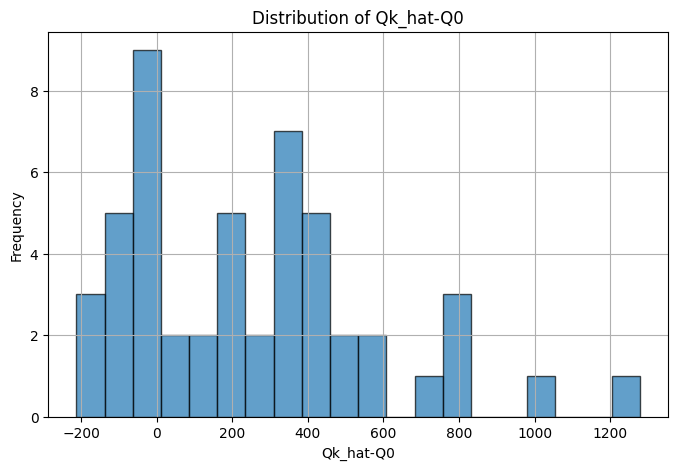

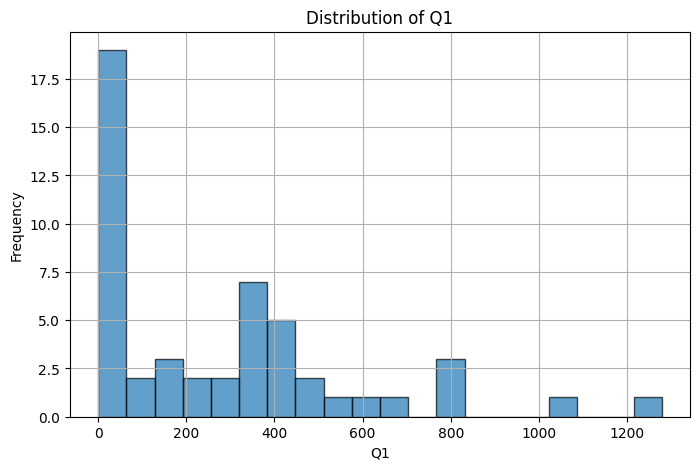

In [139]:
if stimulation_results_df_2 is not None and len(stimulation_results_df_2) > 0:
    # Plotting the distribution of "Qk_hat-Q0"
    plt.figure(figsize=(8, 5))
    plt.hist(
        stimulation_results_df_2["Qk_hat-Q0"], bins=20, alpha=0.7, edgecolor="black"
    )
    plt.title("Distribution of Qk_hat-Q0")
    plt.xlabel("Qk_hat-Q0")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()

    # Plotting the distribution of "Q1"
    plt.figure(figsize=(8, 5))
    plt.hist(stimulation_results_df_2["Q1"], bins=20, alpha=0.7, edgecolor="black")
    plt.title("Distribution of Q1")
    plt.xlabel("Q1")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()

In [140]:
if results_df_2 is not None and len(results_df_2) > 0:
    save_model_parameters(
        f"{model_prefix}_s2", alpha_values=results_df_2.iloc[0]["alpha_values"]
    )

Model parameters saved as models/med_with_holding_cost_0_s2_100_202502121653.pkl


In [141]:
# 找出 average_profits 前三名的資料
top_three_results = results_df_2.head(3)

# 提取 R (T), F 和 average_profits
top_three_info = top_three_results[["R(T)", "average_profits"]]
top_three_info

R(T)  average_profits
6     8     1.126707e+06
5     7     1.121558e+06
4     6     1.119999e+06

### S3 - Grid for Fixed F & Flexible Rk


In [142]:
results_df_3, stimulation_results_df_3 = None, None
# results_df_3, stimulation_results_df_3 = grid_fixed_F_flexible_R(
#     assigned_Fs=ASSIGNED_FS,
#     salvage_value=salvage_value,
#     cost=cost,
#     price=price,
#     Q_star=Q_star,
#     demand_df_train=demand_df_train,
#     Qk_hat_df_train=Qk_hat_df_train,
#     training_df=training_df,
# )

# results_df_3 = grid_fixed_F_flexible_R(
#     assigned_Fs=ASSIGNED_FS,
#     salvage_value=salvage_value,
#     cost=cost,
#     price=price,
#     Q_star=Q_star,
#     demand_df_train=demand_df_train,
#     Qk_hat_df_train=Qk_hat_df_train,
#     training_df=training_df,
# )


# results_df_3

In [143]:
if results_df_3 is not None and len(results_df_3) > 0:
    save_model_parameters(
        f"{model_prefix}_s3",
        beta_values=results_df_3.iloc[0]["beta_values"],
        tau_values=results_df_3.iloc[0]["tau_values"],
    )

In [144]:
stimulation_results_df_3

In [145]:
if results_df_3 is not None and len(results_df_3) > 0:

    r_values = results_df_3["R(T)"].explode().values
    f_values = results_df_3["F_vars"].explode().values

    plt.figure(figsize=(10, 6))
    plt.plot(f_values, r_values, marker="o", linestyle="-", color="b")

    plt.title("R(T) vs F_vars Visualization")
    plt.xlabel("F_vars")
    plt.ylabel("R(T)")

    plt.grid(True)

    name = "result_3_metrics"

    os.makedirs("plots", exist_ok=True)
    save_path = (
        f"plots/{name}_{status}_{model_prefix}_{data_size}_{CURRENT_TIMESTAMP}.png"
    )

    plt.savefig(save_path, format="png", bbox_inches="tight")
    print(f"Plot saved as {save_path}")

    # Show plot
    plt.show()
    plt.close()

else:
    print("results_df_3 is None")

results_df_3 is None


### Fully flexible F & Rk


#### S5 - Simple beta with softmax


In [146]:
results_df_5, stimulation_results_df_5 = None, None
# results_df_5, stimulation_results_df_5 = fully_flexible_simple_beta_with_softmax_5(
#     salvage_value=salvage_value,
#     cost=cost,
#     price=price,
#     Q_star=Q_star,
#     demand_df_train=demand_df_train,
#     Qk_hat_df=Qk_hat_df_train,
#     training_df=training_df,
# )
# results_df_5

In [147]:
if results_df_5 is not None:
    save_model_parameters(
        f"{model_prefix}_s5",
        alpha_values=results_df_5.iloc[0]["alpha_values"],
        beta_values=results_df_5.iloc[0]["beta_values"],
        tau_values=results_df_5.iloc[0]["tau_values"],
        f_values=stimulation_results_df_5["f_values"].values,
    )

In [148]:
stimulation_results_df_5

#### S6 - Simple beta and softmax with T is 1 - sum(T-1)


In [149]:
results_df_6, stimulation_results_df_6 = None, None
# results_df_6, stimulation_results_df_6 = fully_flexible_simple_beta_with_softmax_6(
#     salvage_value=salvage_value,
#     cost=cost,
#     price=price,
#     Q_star=Q_star,
#     demand_df_train=demand_df_train,
#     Qk_hat_df=Qk_hat_df_train,
#     training_df=training_df,
# )
results_df_6

In [150]:
if results_df_6 is not None:
    save_model_parameters(
        f"{model_prefix}_s6",
        alpha_values=results_df_6.iloc[0]["alpha_values"],
        beta_values=results_df_6.iloc[0]["beta_values"],
        tau_values=results_df_6.iloc[0]["tau_values"],
        f_values=stimulation_results_df_6["f_values"].values,
    )

In [151]:
stimulation_results_df_6

#### S7 - Simple beat and softmax with T is 1 - sum(T-1) & tau with f


In [152]:
results_df_7, stimulation_results_df_7 = None, None
# results_df_7, stimulation_results_df_7 = fully_flexible_simple_beta_with_softmax_7(
#     salvage_value=salvage_value,
#     cost=cost,
#     price=price,
#     Q_star=Q_star,
#     demand_df_train=demand_df_train,
#     Qk_hat_df=Qk_hat_df_train,
#     training_df=training_df,
# )
# results_df_7

In [153]:
if results_df_7 is not None:
    save_model_parameters(
        f"{model_prefix}_s7",
        alpha_values=results_df_7.iloc[0]["alpha_values"],
        beta_values=results_df_7.iloc[0]["beta_values"],
        tau_values=results_df_7.iloc[0]["tau_values"],
        f_values=stimulation_results_df_7["f_values"].values,
    )

In [154]:
stimulation_results_df_7

#### S4 - Beta with softmax


In [155]:
results_df_4, stimulation_results_df_4 = None, None
results_df_4, stimulation_results_df_4 = fully_flexible_beta_with_softmax_4(
    salvage_value=salvage_value,
    cost=cost,
    price=price,
    Q_star=Q_star,
    demand_df_train=demand_df_train,
    Qk_hat_df=Qk_hat_df_train,
    training_df=training_df,
)
results_df_4

Set parameter Threads to value 12
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 20000
Set parameter IntFeasTol to value 1e-09
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (mac64[arm] - Darwin 24.2.0 24C101)

CPU model: Apple M2 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Academic license 2563044 - for non-commercial use only - registered to 11___@g.nccu.edu.tw
Optimize a model with 1050 rows, 2795 columns and 5748 nonzeros
Model fingerprint: 0x4e3545f4
Model has 400 quadratic constraints
Model has 1250 general constraints
Variable types: 2395 continuous, 400 integer (400 binary)
Coefficient statistics:
  Matrix range     [1e-02, 3e+03]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 2e+03]
  RHS range        [1e+00, 1e+00]
  GenCon coe range [1e+00, 1e+00]
Presolve added 2682 rows and 10182 columns
Presolve time: 0.06s
Presolved: 18932 rows,

/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_46724/1740452989.py:186: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  R_vars[i, k - 2] * Qk_hat_df_row[k - 2] for k in range(2, T)


     0     0 5.8337e+07    0   96          - 5.8337e+07      -     -    0s
     0     0 5.8309e+07    0   98          - 5.8309e+07      -     -    0s
     0     0 5.8309e+07    0   98          - 5.8309e+07      -     -    0s
     0     0 5.8309e+07    0   87          - 5.8309e+07      -     -    0s
     0     0 5.8307e+07    0   87          - 5.8307e+07      -     -    0s
     0     0 5.8307e+07    0   87          - 5.8307e+07      -     -    0s
     0     0 5.8307e+07    0   87          - 5.8307e+07      -     -    0s
     0     2 5.8307e+07    0   81          - 5.8307e+07      -     -    0s
  2817  1899 5.8205e+07   22  145          - 5.8205e+07      -  12.1    5s
H 2844  1821                    -1285847.897 5.8205e+07  4627%  17.3   10s
H 2844  1730                    2801027.7707 5.8205e+07  1978%  17.3   10s
H 2845  1646                    2822910.6021 5.8205e+07  1962%  19.6   10s
H 2971  1656                    2844793.9963 5.8205e+07  1946%  21.7   11s
H 2974  1576             

In [449]:
import math

# Calculate exp(-100000)
result = math.exp(-13.81551056)
result

9.999999979642742e-07

In [450]:
if results_df_4 is not None:
    save_model_parameters(
        f"{model_prefix}_s4",
        alpha_values=results_df_4.iloc[0]["alpha_values"],
        beta_values=results_df_4.iloc[0]["beta_values"],
        tau_values=results_df_4.iloc[0]["tau_values"],
        f_values=stimulation_results_df_4["f_values"].values,
    )

Model parameters saved as models/med_with_holding_cost_0_s4_100_202502072315.pkl


#### S9 - Without beta

In [156]:
results_df_9, stimulation_results_df_9 = None, None
results_df_9, stimulation_results_df_9 = fully_flexible_beta_with_softmax_9(
    salvage_value=salvage_value,
    cost=cost,
    price=price,
    Q_star=Q_star,
    demand_df_train=demand_df_train,
    Qk_hat_df=Qk_hat_df_train,
    training_df=training_df,
)
results_df_9

Set parameter Threads to value 12
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 20000
Set parameter IntFeasTol to value 1e-09
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (mac64[arm] - Darwin 24.2.0 24C101)

CPU model: Apple M2 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Academic license 2563044 - for non-commercial use only - registered to 11___@g.nccu.edu.tw
Optimize a model with 650 rows, 1505 columns and 3348 nonzeros
Model fingerprint: 0xc6f31726
Model has 400 general constraints
Variable types: 1105 continuous, 400 integer (400 binary)
Coefficient statistics:
  Matrix range     [1e-02, 3e+03]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 2e+03]
  RHS range        [1e+00, 1e+00]
Presolve added 232 rows and 182 columns
Presolve time: 0.01s
Presolved: 882 rows, 1687 columns, 5232 nonzeros
Presolved model has 50 SOS constraint(s)
Variable types: 1146 continuous, 541 integer (541 binary)

Root relaxation:

/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_46724/1450609238.py:178: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  R_vars[i, k - 2] * Qk_hat_df_row[k - 2] for k in range(2, T)


     0     2 5.8211e+07    0   90          - 5.8211e+07      -     -    0s
* 3643  2457             215    5.486542e+07 5.8205e+07  6.09%  13.3    0s
* 3644  2456             214    5.486733e+07 5.8205e+07  6.08%  13.3    0s
H 4191  2589                    5.556579e+07 5.8205e+07  4.75%  12.7    0s
H 4211  2459                    5.572447e+07 5.8205e+07  4.45%  12.7    0s
H 4286  2409                    5.577917e+07 5.8205e+07  4.35%  15.3    1s
H 4359  2325                    5.587858e+07 5.8205e+07  4.16%  16.7    1s
H 4360  2214                    5.589422e+07 5.8205e+07  4.13%  16.7    1s
H 4366  2106                    5.590956e+07 5.8205e+07  4.11%  16.6    1s
H 4437  2061                    5.619332e+07 5.8205e+07  3.58%  17.9    1s
H 4519  2018                    5.649264e+07 5.8205e+07  3.03%  18.6    1s
H 4815  2129                    5.649350e+07 5.8205e+07  3.03%  20.5    2s
H 6525  2471                    5.677713e+07 5.8205e+07  2.51%  21.9    3s
H 6526  2366             

average_profits  average_losses  average_lefts  average_operation_profits  \
0     1.153749e+06         7.55683     339.403602               1.164261e+06   

                                        alpha_values beta_values tau_values  \
0  [-0.48541357920445394, -0.34833307833333554, 1...        None       None   

  gamma_values  
0         None

In [157]:
if results_df_9 is not None:
    save_model_parameters(
        f"{model_prefix}_s9",
        alpha_values=results_df_9.iloc[0]["alpha_values"],
        beta_values=results_df_9.iloc[0]["beta_values"],
        tau_values=results_df_9.iloc[0]["tau_values"],
        f_values=stimulation_results_df_9["f_values"].values,
    )

Model parameters saved as models/med_with_holding_cost_0_s9_100_202502121653.pkl


#### S11 - Beta(Beta+Gamma)

In [158]:
results_df_11, stimulation_results_df_11 = None, None
results_df_11, stimulation_results_df_11 = fully_flexible_beta_with_softmax_11(
    salvage_value=salvage_value,
    cost=cost,
    price=price,
    Q_star=Q_star,
    demand_df_train=demand_df_train,
    Qk_hat_df=Qk_hat_df_train,
    training_df=training_df,
)
results_df_11

Set parameter Threads to value 12
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 20000
Set parameter IntFeasTol to value 1e-09
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (mac64[arm] - Darwin 24.2.0 24C101)

CPU model: Apple M2 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Academic license 2563044 - for non-commercial use only - registered to 11___@g.nccu.edu.tw
Optimize a model with 1050 rows, 2667 columns and 5748 nonzeros
Model fingerprint: 0x7d90ed4c
Model has 400 quadratic constraints
Model has 1250 general constraints
Variable types: 2267 continuous, 400 integer (400 binary)
Coefficient statistics:
  Matrix range     [1e-02, 3e+03]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 2e+03]
  RHS range        [1e+00, 1e+00]
  GenCon coe range [1e+00, 1e+00]
Presolve added 2682 rows and 10282 columns
Presolve time: 0.06s
Presolved: 18932 rows,

/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_46724/3921244383.py:179: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  R_vars[i, k - 2] * Qk_hat_df_row[k - 2] for k in range(2, T)


     0     0 5.8350e+07    0  103          - 5.8350e+07      -     -    0s
     0     0 5.8311e+07    0   93          - 5.8311e+07      -     -    0s
     0     0 5.8302e+07    0   95          - 5.8302e+07      -     -    0s
     0     0 5.8288e+07    0   86          - 5.8288e+07      -     -    0s
     0     0 5.8285e+07    0   86          - 5.8285e+07      -     -    0s
     0     0 5.8285e+07    0   88          - 5.8285e+07      -     -    0s
     0     0 5.8285e+07    0   86          - 5.8285e+07      -     -    0s
     0     0 5.8285e+07    0   85          - 5.8285e+07      -     -    0s
     0     0 5.8211e+07    0   83          - 5.8211e+07      -     -    0s
     0     0 5.8211e+07    0   85          - 5.8211e+07      -     -    0s
     0     2 5.8211e+07    0   85          - 5.8211e+07      -     -    1s
* 4119  2480             220    5.331167e+07 5.8205e+07  9.18%  10.1    3s
* 4157  2471             218    5.333102e+07 5.8205e+07  9.14%  10.1    3s
H 4338  2526             

average_profits  average_losses  average_lefts  average_operation_profits  \
0     1.152894e+06        9.360122     364.047834               1.162999e+06   

                                        alpha_values  \
0  [-0.15322050691606964, 0.030952380952380953, 1...   

                                         beta_values  \
0  [-1000000.0, -1000000.0, -1000000.0, -1000000....   

                                          tau_values          gamma_values  
0  [[-1000000.0, -1000000.0, -1000000.0, -1000000...  [0.0, 0.0, 0.0, 0.0]

In [159]:
if results_df_11 is not None:
    save_model_parameters(
        f"{model_prefix}_s11",
        alpha_values=results_df_11.iloc[0]["alpha_values"],
        beta_values=results_df_11.iloc[0]["beta_values"],
        tau_values=results_df_11.iloc[0]["tau_values"],
        f_values=stimulation_results_df_11["f_values"].values,
    )

Model parameters saved as models/med_with_holding_cost_0_s11_100_202502121653.pkl


### Analysis


#### Baseline


In [160]:
print(f"The Average profit of One-time procurement: {baseline_avg_profits}")

The Average profit of One-time procurement: 800915.4111061394


#### S1


In [161]:
# 策略一
results_df_1

R(T)    F                                                 Q0  \
13     3  0.5  [1014.2080270039206, 1014.2080270039206, 1014....   
22     4  0.5  [1014.2080270039206, 1014.2080270039206, 1014....   
12     3  0.4  [811.3664216031366, 811.3664216031366, 811.366...   
23     4  0.6  [1217.0496324047049, 1217.0496324047049, 1217....   
11     3  0.3  [608.5248162023524, 608.5248162023524, 608.524...   
..   ...  ...                                                ...   
55     8  0.2  [405.6832108015683, 405.6832108015683, 405.683...   
45     7  0.1  [202.84160540078415, 202.84160540078415, 202.8...   
64     9  0.2  [405.6832108015683, 405.6832108015683, 405.683...   
54     8  0.1  [202.84160540078415, 202.84160540078415, 202.8...   
63     9  0.1  [202.84160540078415, 202.84160540078415, 202.8...   

                                                   Q1  average_profits  \
13  [326.71387347108623, 1304.2776656226342, 642.4...     1.095803e+06   
22  [267.54845452712345, 1245.6653652386995, 636.2...     1.095549e+06   
12  [529.5554788718703, 1507.1192710234182, 845.30...     1.094211e+06   
23  [64.7068491263392, 1042.823759837915, 433.4068...     1.092415e+06   
11  [732.3970842726544, 1709.9608764242023, 1048.1...     1.091540e+06   
..                                                ...              ...   
55  [910.6104553034952, 1730.7272148804918, 963.67...    -1.461689e+05   
45  [1295.3789363675198, 1988.682797259448, 1348.3...    -2.320616e+05   
64  [835.7166782630366, 1613.2089700060285, 907.21...    -4.197355e+05   
54  [1113.4520607042793, 1933.568820281276, 1166.5...    -4.909097e+05   
63  [1038.5582836638207, 1816.0505754068126, 1110....    -7.645662e+05   

    average_losses  average_lefts  average_operation_profits  baseline_profit  \
13       24.034458     133.666062               1.152727e+06    800915.411106   
22       24.673243     131.530421               1.152279e+06    800915.411106   
12       28.091291     120.039496               1.149887e+06    800915.411106   
23       19.005259     168.427062               1.156247e+06    800915.411106   
11       30.386536     118.232387               1.148280e+06    800915.411106   
..             ...            ...                        ...              ...   
55      768.099054     801.270120               6.318814e+05    800915.411106   
45      814.039378     873.190699               5.997232e+05    800915.411106   
64      934.874214     934.874492               5.151388e+05    800915.411106   
54      970.887711    1004.058777               4.899294e+05    800915.411106   
63     1137.715820    1137.716098               3.731497e+05    800915.411106   

    profit_diff_percent  
13            36.818781  
22            36.787116  
12            36.620059  
23            36.395837  
11            36.286539  
..                  ...  
55          -118.250236  
45          -128.974543  
64          -152.406968  
54          -161.293572  
63          -195.461544  

[72 rows x 10 columns]

In [162]:
if results_df_1 is None or len(results_df_1) == 0:
    print(f"Model didn't find optimized result.")
    max_profit_for_s1 = -1
else:
    max_profit_row = results_df_1.loc[results_df_1["average_profits"].idxmax()]
    max_profit_for_s1 = max_profit_row["average_profits"]
    avg_profit_for_s1 = results_df_1["average_profits"].mean()

    print(f"策略1平均利潤為：{avg_profit_for_s1}")
    print(f"策略1最佳策略在：R={max_profit_row['R(T)']}, F={max_profit_row['F']}")
    print(f"策略1最佳策略之下最大利潤為：{max_profit_for_s1}")

策略1平均利潤為：753632.0378909183
策略1最佳策略在：R=3, F=0.5
策略1最佳策略之下最大利潤為：1095802.7017632981


#### S2


In [163]:
if results_df_2 is None or len(results_df_2) == 0:
    print(f"Model didn't find optimized result.")
    max_profit_for_s2 = -1
else:
    max_profit_row = results_df_2.loc[results_df_2["average_profits"].idxmax()]
    max_profit_for_s2 = max_profit_row["average_profits"]
    avg_profit_for_s2 = results_df_2["average_profits"].mean()

    print(f"策略2平均利潤為：{avg_profit_for_s2}")
    print(f"策略2最佳策略在：R={max_profit_row['R(T)']}, F為彈性")
    print(f"策略2最佳策略之下最大利潤為：{max_profit_for_s2}")

策略2平均利潤為：1087839.1138492539
策略2最佳策略在：R=8, F為彈性
策略2最佳策略之下最大利潤為：1126706.9790746302


#### S3


In [164]:
# 策略三
results_df_3

In [165]:
if results_df_3 is None or len(results_df_3) == 0:
    print(f"Model didn't find optimized result.")
    max_profit_for_s3 = -1
else:
    max_profit_row = stimulation_results_df_3.loc[
        stimulation_results_df_3["profits"].idxmax()
    ]
    max_profit_for_s3 = max_profit_row["profits"]

    print(f"策略3最佳策略在：\nR={max_profit_row['R(T)']}, \nF={max_profit_row['F']}")
    print(f"策略3最佳策略之下最大利潤(Avg profit)為：{max_profit_for_s3}")

Model didn't find optimized result.


#### S4


In [166]:
results_df_4

In [167]:
if results_df_4 is None or len(results_df_4) == 0:
    print(f"Model didn't find optimized result.")
    max_profit_for_s4 = -1
else:
    max_profit_row = results_df_4.loc[results_df_4["average_profits"].idxmax()]
    max_profit_for_s4 = max_profit_row["average_profits"]

    # print(f"策略4最佳策略在：\nR為彈性, F={max_profit_row['F'][0]}")
    print(f"策略4最佳策略之下最大利潤(Avg profit)為：{max_profit_for_s4}")

Model didn't find optimized result.


#### S5


In [168]:
if results_df_5 is None or len(results_df_5) == 0:
    print(f"Model didn't find optimized result.")
    max_profit_for_s5 = -1
else:
    max_profit_row = stimulation_results_df_5.loc[
        stimulation_results_df_5["profits"].idxmax()
    ]
    max_profit_for_s5 = max_profit_row["profits"]

    print(f"策略5最佳策略在：\nR={max_profit_row['R(T)']}, \nF={max_profit_row['F']}")
    print(f"策略5最佳策略之下最大利潤(Avg profit)為：{max_profit_for_s5}")

Model didn't find optimized result.


#### S6


In [169]:
if results_df_6 is None or len(results_df_6) == 0:
    print(f"Model didn't find optimized result.")
    max_profit_for_s6 = -1
else:
    max_profit_row = stimulation_results_df_6.loc[
        stimulation_results_df_6["profits"].idxmax()
    ]
    max_profit_for_s6 = max_profit_row["profits"]

    print(f"策略6最佳策略在：\nR={max_profit_row['R(T)']}, \nF={max_profit_row['F']}")
    print(f"策略6最佳策略之下最大利潤(Avg profit)為：{max_profit_for_s6}")

Model didn't find optimized result.


#### S7


In [170]:
if results_df_7 is None or len(results_df_7) == 0:
    print(f"Model didn't find optimized result.")
    max_profit_for_s7 = -1
else:
    max_profit_row = stimulation_results_df_7.loc[
        stimulation_results_df_7["profits"].idxmax()
    ]
    max_profit_for_s7 = max_profit_row["profits"]

    print(f"策略7最佳策略在：\nR={max_profit_row['R(T)']}, \nF={max_profit_row['F']}")
    print(f"策略7最佳策略之下最大利潤(Avg profit)為：{max_profit_for_s7}")

Model didn't find optimized result.


#### S8

In [171]:
if results_df_8 is None or len(results_df_8) == 0:
    print(f"Model didn't find optimized result.")
    max_profit_for_s8 = -1
else:
    max_profit_row = stimulation_results_df_8.loc[
        stimulation_results_df_8["profits"].idxmax()
    ]
    max_profit_for_s8 = max_profit_row["profits"]

    print(f"策略8最佳策略在：\nR={max_profit_row['R(T)']}, \nF={max_profit_row['F']}")
    print(f"策略8最佳策略之下最大利潤(Avg profit)為：{max_profit_for_s8}")

Model didn't find optimized result.


#### 比較&分析


##### 不同策略 Scatter

In [172]:
dfs = [
    baseline_stimulation_df,
    stimulation_results_df_1,
    stimulation_results_df_2,
    stimulation_results_df_3,
    stimulation_results_df_4,
    stimulation_results_df_5,
    stimulation_results_df_6,
    stimulation_results_df_7,
    stimulation_results_df_8,
]
plot_strategies_profits_scatter(save_type=f"{status}_{model_prefix}", dfs=dfs)

Plot saved as plots/plot_strategies_profits_scatter_train_med_with_holding_cost_0_100_202502121653.png


##### 二次補貨量

Plot saved as plots/plot_Q0_Q1_distribution_train_med_with_holding_cost_0_100_S1_202502121653.png


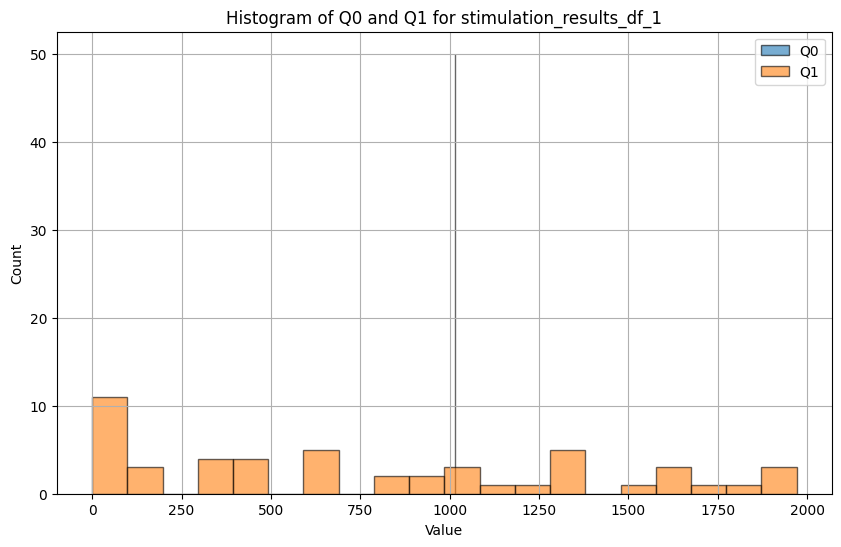

Plot saved as plots/plot_Q0_Q1_distribution_train_med_with_holding_cost_0_100_S2_202502121653.png


In [173]:
plot_Q0_Q1_distribution(f"{status}_{model_prefix}", dfs[1:])

##### 每一個 profits 對 Baseline 的 Deviation

Plot saved as plots/plot_profits_deviation_box_plot_train_med_with_holding_cost_0_100_S1_202502121653.png


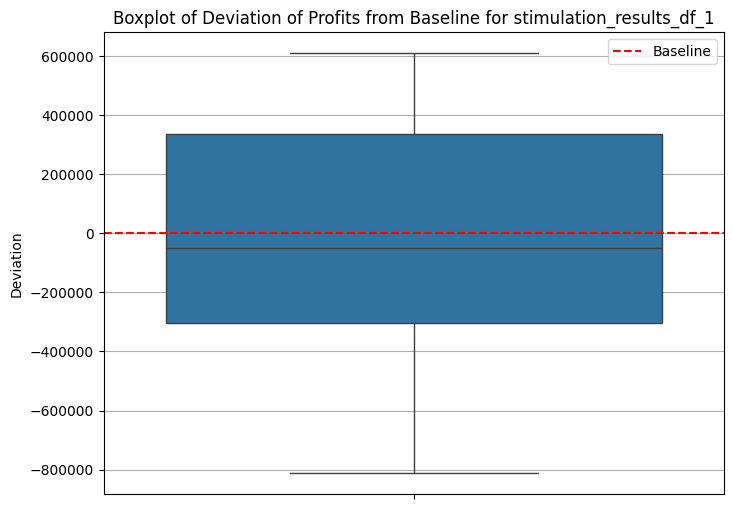

Plot saved as plots/plot_profits_deviation_box_plot_train_med_with_holding_cost_0_100_S2_202502121653.png


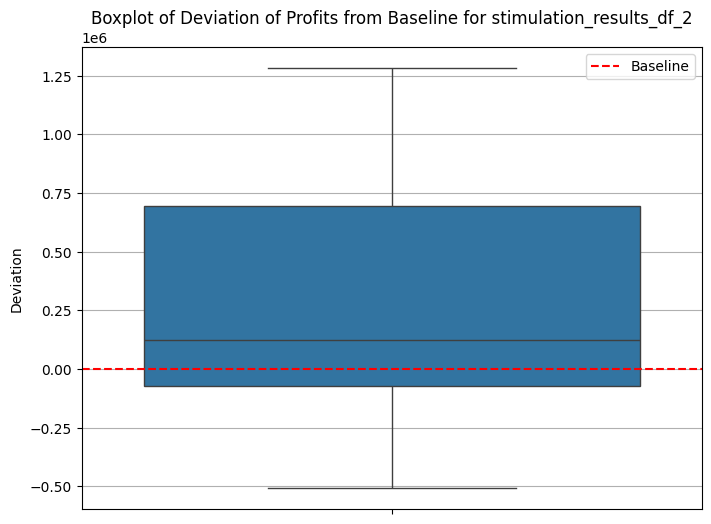

Plot saved as plots/plot_profits_deviation_box_plot_train_med_with_holding_cost_0_100_S3_202502121653.png


Skipping stimulation_results_df_4: Missing 'profits' column.
Skipping stimulation_results_df_5: Missing 'profits' column.
Skipping stimulation_results_df_6: Missing 'profits' column.
Skipping stimulation_results_df_7: Missing 'profits' column.
Skipping stimulation_results_df_8: Missing 'profits' column.
Skipping stimulation_results_df_9: Missing 'profits' column.


In [174]:
plot_profits_deviation_box_plot(
    f"{status}_{model_prefix}",
    dfs,
    baseline_avg_profits,
)

##### 最大利潤比較


In [175]:
train_max_profits = [
    max_profit_for_s1,
    max_profit_for_s2,
    max_profit_for_s3,
    max_profit_for_s4,
    max_profit_for_s5,
    max_profit_for_s6,
    max_profit_for_s7,
    max_profit_for_s8,
]

plot_relative_profit_deviation(
    f"{status}_{model_prefix}", float(baseline_avg_profits), train_max_profits
)

Baseline is: 800915.4111061394
S1's profit: 1095802.7017632981
S2's profit: 1126706.9790746302
S3's profit: -1
S4's profit: -1
S5's profit: -1
S6's profit: -1
S7's profit: -1
S8's profit: -1
Plot saved as plots/plot_relative_profit_deviation_train_med_with_holding_cost_0_100_202502121653.png


#### Preparation


In [176]:
# overview
low_results_df_1 = results_df_1
low_results_df_2 = results_df_2
low_results_df_3 = results_df_3
low_results_df_4 = results_df_4
low_results_df_5 = results_df_5
low_results_df_6 = results_df_6
low_results_df_7 = results_df_7
low_results_df_8 = results_df_8

# max stimulation result
low_stimulation_results_df_1 = stimulation_results_df_1
low_stimulation_results_df_2 = stimulation_results_df_2
low_stimulation_results_df_3 = stimulation_results_df_3
low_stimulation_results_df_4 = stimulation_results_df_4
low_stimulation_results_df_5 = stimulation_results_df_5
low_stimulation_results_df_6 = stimulation_results_df_6
low_stimulation_results_df_7 = stimulation_results_df_7
low_stimulation_results_df_8 = stimulation_results_df_8

# max value
low_baseline_profit = baseline_avg_profits
low_max_profit_for_s1 = max_profit_for_s1
low_max_profit_for_s2 = max_profit_for_s2
low_max_profit_for_s3 = max_profit_for_s3
low_max_profit_for_s4 = max_profit_for_s4
low_max_profit_for_s5 = max_profit_for_s5
low_max_profit_for_s6 = max_profit_for_s6
low_max_profit_for_s7 = max_profit_for_s7
low_max_profit_for_s8 = max_profit_for_s8

## Testing


### Setting reasonable parameters


In [177]:
status = "test"

In [178]:
# Q star have to from demand_df_train
Q_star = calculate_Q_star(demand_df_train, service_level=service_lv)
print(f"Q_star: {Q_star}")

mean of sum: 1670.7868029577896
std of sum: 681.9773100587362
70.0 percentile of sum: 2028.4160540078412
Q_star: 2028.4160540078412


In [179]:
# compute Qk_hat_test with demand_df_test
mu_matrix, covariance_matrix = cal_mu_and_cov_matrix(demand_df_test)
Qk_hat_df_test = make_Qk_hat_df(
    demand_df_test, T, service_lv, mu_matrix, covariance_matrix
)
Qk_hat_df_test = Qk_hat_df_test.reset_index(drop=True)

print(f"Qk_hat_df_test shape: {Qk_hat_df_test.shape}")
Qk_hat_df_test.head()

Qk_hat_df_test shape: (50, 8)


Qk_hat_k2    Qk_hat_k3    Qk_hat_k4    Qk_hat_k5    Qk_hat_k6  \
0  1361.760076  1402.502346  1402.508694  1400.354388  1351.962053   
1  2649.687610  2955.676749  2922.610471  2923.571238  2800.470307   
2  2818.949431  2567.005909  2564.293679  2563.719166  2553.017951   
3  2805.891218  2526.008974  2563.898858  2563.501151  2377.246105   
4  2516.838636  2851.018033  2874.727940  2875.974472  3021.375729   

     Qk_hat_k7    Qk_hat_k8    Qk_hat_k9  
0  1352.008084  1264.708979  1195.706928  
1  2800.543537  3034.672217  2974.119259  
2  2553.563186  2629.981905  2732.977569  
3  2376.096405  2281.698424  2128.317307  
4  3020.292031  3004.727233  2944.338507

### Run all the strategies


Baseline

In [180]:
(
    test_baseline_avg_loss,
    test_baseline_avg_lefts,
    test_baseline_avg_profits,
    test_baseline_avg_operation_profits,
    test_stimulation_df_baseline,
) = one_time_procurement(
    Q_star=Q_star,
    demand_df=demand_df_test,
    cost=cost,
    price=price,
    salvage_value=salvage_value,
)

print(f"baseline_profit: {test_baseline_avg_profits}")

Processing row 1/50 with initial inventory Q_star=2028.4160540078412
--------------------------------------------------
Day 1
Demand      : 36.86764149600387
Sales       : 36.86764149600387
Loss        : 0
Left        : 1991.5484125118373
Inventory   : 1991.5484125118373
--------------------------------------------------
--------------------------------------------------
Day 2
Demand      : 138.9032703053814
Sales       : 138.9032703053814
Loss        : 0
Left        : 1852.645142206456
Inventory   : 1852.645142206456
--------------------------------------------------
--------------------------------------------------
Day 3
Demand      : 94.35638881839637
Sales       : 94.35638881839637
Loss        : 0
Left        : 1758.2887533880596
Inventory   : 1758.2887533880596
--------------------------------------------------
--------------------------------------------------
Day 4
Demand      : 138.90318503569156
Sales       : 138.90318503569156
Loss        : 0
Left        : 1619.385568352368


In [181]:
test_stimulation_df_baseline.head()

losses       lefts  operation_profits       profits
0    0.000000  836.401877       8.344099e+05  5.834894e+05
1  942.018246    0.000000       1.419891e+06  7.604785e+05
2  701.020892    0.000000       1.419891e+06  9.291766e+05
3   96.383047    0.000000       1.419891e+06  1.352423e+06
4  912.132948    0.000000       1.419891e+06  7.813982e+05

S1

In [182]:
test_results_df_1, test_stimulation_results_df_1 = None, None

if results_df_1 is not None:
    assigned_T = results_df_1.iloc[0]["R(T)"]
    assigned_F = results_df_1.iloc[0]["F"]

    test_results_df_1, test_stimulation_results_df_1 = cal_test_fixed_F_fixed_R(
        assigned_T=int(assigned_T),
        assigned_F=assigned_F,
        salvage_value=salvage_value,
        cost=cost,
        price=price,
        Q_star=Q_star,
        demand_df_test=demand_df_test,
        Qk_hat_df_test=Qk_hat_df_test,
    )

test_results_df_1





這是第 1 筆模擬資料

F: 0.5, R: 3
Q_star 為 2028.4160540078412
期初庫存 Q0: 1014.2080270039206
重新估計量 Qk_hat: 1402.5023460861664
訂貨量 Q1 為 388.2943190822458

第一階段：期初庫存 Q0: 1014.2080270039206，需求量為 175.77091180138527，Sold_0 為 175.77091180138527，Left_0 為 838.4371152025353，Lost_0 為 0
第二階段：期初庫存 Q1+left_0 為 1226.7314342847812，需求量為 1016.2432653639622，Sold_1 為 1016.2432653639622，Left_1 為 210.48816892081902，Lost_1 為 0

統計結果：Sold 為 1192.0141771653475, Lost 為 0 Left_Penalty_Cost 為 63146.45067624571，Lost_Penalty_Cost 為 0，Profit 為 771263.4733394976
----------------------------------------
這是第 2 筆模擬資料

F: 0.5, R: 3
Q_star 為 2028.4160540078412
期初庫存 Q0: 1014.2080270039206
重新估計量 Qk_hat: 2955.676749185167
訂貨量 Q1 為 1941.4687221812464

第一階段：期初庫存 Q0: 1014.2080270039206，需求量為 567.7268404700224，Sold_0 為 567.7268404700224，Left_0 為 446.48118653389827，Lost_0 為 0
第二階段：期初庫存 Q1+left_0 為 2387.949908715145，需求量為 2402.707459857201，Sold_1 為 2387.949908715145，Left_1 為 0.0，Lost_1 為 14.757551142055945

統計結果：Sold 為 2955.676749185167, 

R(T)    F                                                 Q0  \
0     3  0.5  [1014.2080270039206, 1014.2080270039206, 1014....   

                                                  Q1  average_profits  \
0  [388.2943190822458, 1941.4687221812464, 1552.7...     1.263637e+06   

   average_losses  average_lefts  average_operation_profits  
0       22.925351     141.141367               1.322027e+06

S2

In [183]:
results_df_2

R(T)                                                  R  average_profits  \
6     8  [6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, ...     1.126707e+06   
5     7  [5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ...     1.121558e+06   
4     6  [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, ...     1.119999e+06   
3     5  [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ...     1.113540e+06   
2     4  [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...     1.108235e+06   
1     3  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...     1.104091e+06   
7     9  [7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, ...     1.091544e+06   
0     2  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...     9.170386e+05   

   average_losses  average_lefts  average_operation_profits  \
6       15.055457      72.553812               1.159012e+06   
5       14.808156      90.871828               1.159185e+06   
4       14.703490      96.556210               1.159258e+06   
3       12.907586     126.465690               1.160515e+06   
2       13.942889     139.319321               1.159791e+06   
1       19.925146     125.213604               1.155603e+06   
7       35.500287      94.355659               1.144701e+06   
0       90.354453     420.052997               1.106303e+06   

                                        alpha_values  \
6  [-0.13952048870072226, -0.2636298477323858, 1....   
5  [-0.01002366842482426, -0.06764564359001146, 1...   
4  [-0.16067851216552134, -0.419506937730288, 1.9...   
3  [0.5363426238372977, 0.3319101608878175, 0.111...   
2  [0.5589691493488032, 0.03941409455270623, 0.47...   
1  [-0.24095356384991737, -0.6831426571254321, 1....   
7  [-0.11527319941831457, -0.5064063642853575, 1....   
0  [-0.4190692846100111, -0.9701649017821081, 2.5...   

                                              F_vars  \
6  [0.5000003835173218, 0.9518420892245276, 0.500...   
5  [0.5000003826568544, 0.9082291875032418, 0.500...   
4  [0.5, 0.999660645606632, 0.5, 0.50860535421700...   
3  [0.5, 0.5, 0.5, 0.5, 0.5079156089796654, 0.453...   
2  [0.5407991501335545, 0.5, 0.7427817317552523, ...   
1  [0.5, 0.5000012574007742, 0.5, 0.5, 0.52109498...   
7  [0.6470301125479487, 0.9846896372326714, 0.752...   
0  [0.5, 0.5000024826655806, 0.5, 0.0981016262794...   

                                             Q0_vars  \
6  [1014.2088049366131, 1930.7317746633958, 1014....   
5  [1014.2088031912273, 1842.2666646500734, 1014....   
4  [1014.2084695616676, 2027.7277021083355, 1014....   
3  [1014.2098270133196, 1014.2095441383, 1014.209...   
2  [1096.9656781246988, 1014.2093934352982, 1506....   
1  [1014.2080270039206, 1014.2105775358372, 1014....   
7  [1312.4462677187596, 1997.360268377908, 1525.7...   
0  [1014.2080270039206, 1014.2130628826409, 1014....   

                                             Q1_vars  
6  [302.0848611684495, 205.67865101866437, 355.14...  
5  [484.0117385770758, 349.25773801015885, 536.94...  
4  [484.01213551063813, 163.79666130003352, 536.9...  
3  [271.1197270278707, 1256.141700328019, 630.871...  
2  [184.79080340634528, 1245.6639988073216, 143.7...  
1  [326.71387347108623, 1304.2751150907175, 642.4...  
7  [0.0, 21.53191242968885, 0.0, 189.802116592034...  
0  [527.7687079770875, 1095.2008010495774, 1452.8...

In [184]:
alphas = results_df_2.iloc[0]["alpha_values"]
alphas

array([-0.13952049, -0.26362985,  1.63807371,  0.01125035,  1.73693488])

In [185]:
test_results_df_2, test_stimulation_results_df_2 = None, None

if results_df_2 is not None and len(results_df_2) > 0:
    assigned_R = results_df_2.iloc[0]["R"]
    alphas = results_df_2.iloc[0]["alpha_values"]

    test_results_df_2, test_stimulation_results_df_2 = cal_test_flexible_F_fixed_R(
        assigned_R=assigned_R[0],
        alphas=alphas,
        salvage_value=salvage_value,
        cost=cost,
        price=price,
        Q_star=Q_star,
        demand_df_test=demand_df_test,
        Qk_hat_df_test=Qk_hat_df_test,
        testing_df=testing_df,
    )

test_results_df_2

assigned_R: 6


/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_46724/1454959989.py:73: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  R_vars[i, k - 2] * Qk_hat_df_test_row[k - 2] for k in range(2, T)


average_profits  average_loss  average_left  \
0     1.246760e+06  92842.639366  92842.639366   

                                        alpha_values  R(T)  
0  [-0.13952048870072226, -0.2636298477323858, 1....     8

S3

In [186]:
test_results_df_3, test_stimulation_results_df_3 = None, None

if results_df_3 is not None and len(results_df_3) > 0:
    assigned_F = results_df_3.iloc[0]["F_vars"]
    betas = results_df_3.iloc[0]["beta_values"]
    test_results_df_3, test_stimulation_results_df_3 = cal_test_fixed_F_flexible_R(
        assigned_F=assigned_F[0],
        betas=betas,
        salvage_value=salvage_value,
        cost=cost,
        price=price,
        Q_star=Q_star,
        demand_df_test=demand_df_test,
        Qk_hat_df_test=Qk_hat_df_test,
        testing_df=testing_df,
    )

test_results_df_3

S4

In [187]:
test_results_df_4, test_stimulation_results_df_4 = None, None

if results_df_4 is not None:
    alphas = results_df_4.iloc[0]["alpha_values"]
    betas = results_df_4.iloc[0]["beta_values"]

    test_results_df_4, test_stimulation_results_df_4 = (
        cal_test_fully_flexible_beta_with_softmax_4(
            alphas=alphas,
            betas=betas,
            salvage_value=salvage_value,
            cost=cost,
            price=price,
            Q_star=Q_star,
            demand_df_test=demand_df_test,
            Qk_hat_df_test=Qk_hat_df_test,
            testing_df=testing_df,
        )
    )

test_results_df_4

S5

In [188]:
test_results_df_5, test_stimulation_results_df_5 = None, None

if results_df_5 is not None:
    alphas = results_df_5.iloc[0]["alpha_values"]
    betas = results_df_5.iloc[0]["beta_values"]

    test_results_df_5, test_stimulation_results_df_5 = (
        cal_test_fully_flexible_simple_beta_with_softmax_5(
            alphas=alphas,
            betas=betas,
            salvage_value=salvage_value,
            cost=cost,
            price=price,
            Q_star=Q_star,
            demand_df_test=demand_df_test,
            Qk_hat_df_test=Qk_hat_df_test,
            testing_df=testing_df,
        )
    )

test_results_df_5

In [189]:
test_stimulation_results_df_5

S6

In [190]:
test_results_df_6, test_stimulation_results_df_6 = None, None

if results_df_6 is not None:
    alphas = results_df_6.iloc[0]["alpha_values"]
    betas = results_df_6.iloc[0]["beta_values"]

    test_results_df_6, test_stimulation_results_df_6 = (
        cal_test_fully_flexible_simple_beta_with_softmax_6(
            alphas=alphas,
            betas=betas,
            salvage_value=salvage_value,
            cost=cost,
            price=price,
            Q_star=Q_star,
            demand_df_test=demand_df_test,
            Qk_hat_df_test=Qk_hat_df_test,
            testing_df=testing_df,
        )
    )

test_results_df_6

In [191]:
test_stimulation_results_df_6

S7

In [192]:
test_results_df_7, test_stimulation_results_df_7 = None, None

if results_df_7 is not None:
    alphas = results_df_7.iloc[0]["alpha_values"]
    betas = results_df_7.iloc[0]["beta_values"]

    print(f"alphas: {alphas}")
    print(f"betas: {betas}")

    test_results_df_7, test_stimulation_results_df_7 = (
        cal_test_fully_flexible_simple_beta_with_softmax_7(
            alphas=alphas,
            betas=betas,
            salvage_value=salvage_value,
            cost=cost,
            price=price,
            Q_star=Q_star,
            demand_df_test=demand_df_test,
            Qk_hat_df_test=Qk_hat_df_test,
            testing_df=testing_df,
        )
    )

test_results_df_7

S8

In [193]:
test_results_df_8, test_stimulation_results_df_8 = None, None

if results_df_8 is not None:
    assigned_T = results_df_8.iloc[0]["R(T)"]
    assigned_F = results_df_8.iloc[0]["F"]

    test_results_df_8, test_stimulation_results_df_8 = (
        cal_test_fixed_F_fixed_R_with_holding_cost(
            assigned_T=int(assigned_T),
            assigned_F=assigned_F,
            salvage_value=salvage_value,
            cost=cost,
            price=price,
            Q_star=Q_star,
            demand_df_test=demand_df_test,
            Qk_hat_df_test=Qk_hat_df_test,
            holding_cost=holding_cost,
        )
    )

test_results_df_8

### Analysis

#### 組內比較

##### Profits Scatter

Plot saved as plots/plot_strategies_profits_scatter_test_med_with_holding_cost_0_100_202502121653.png


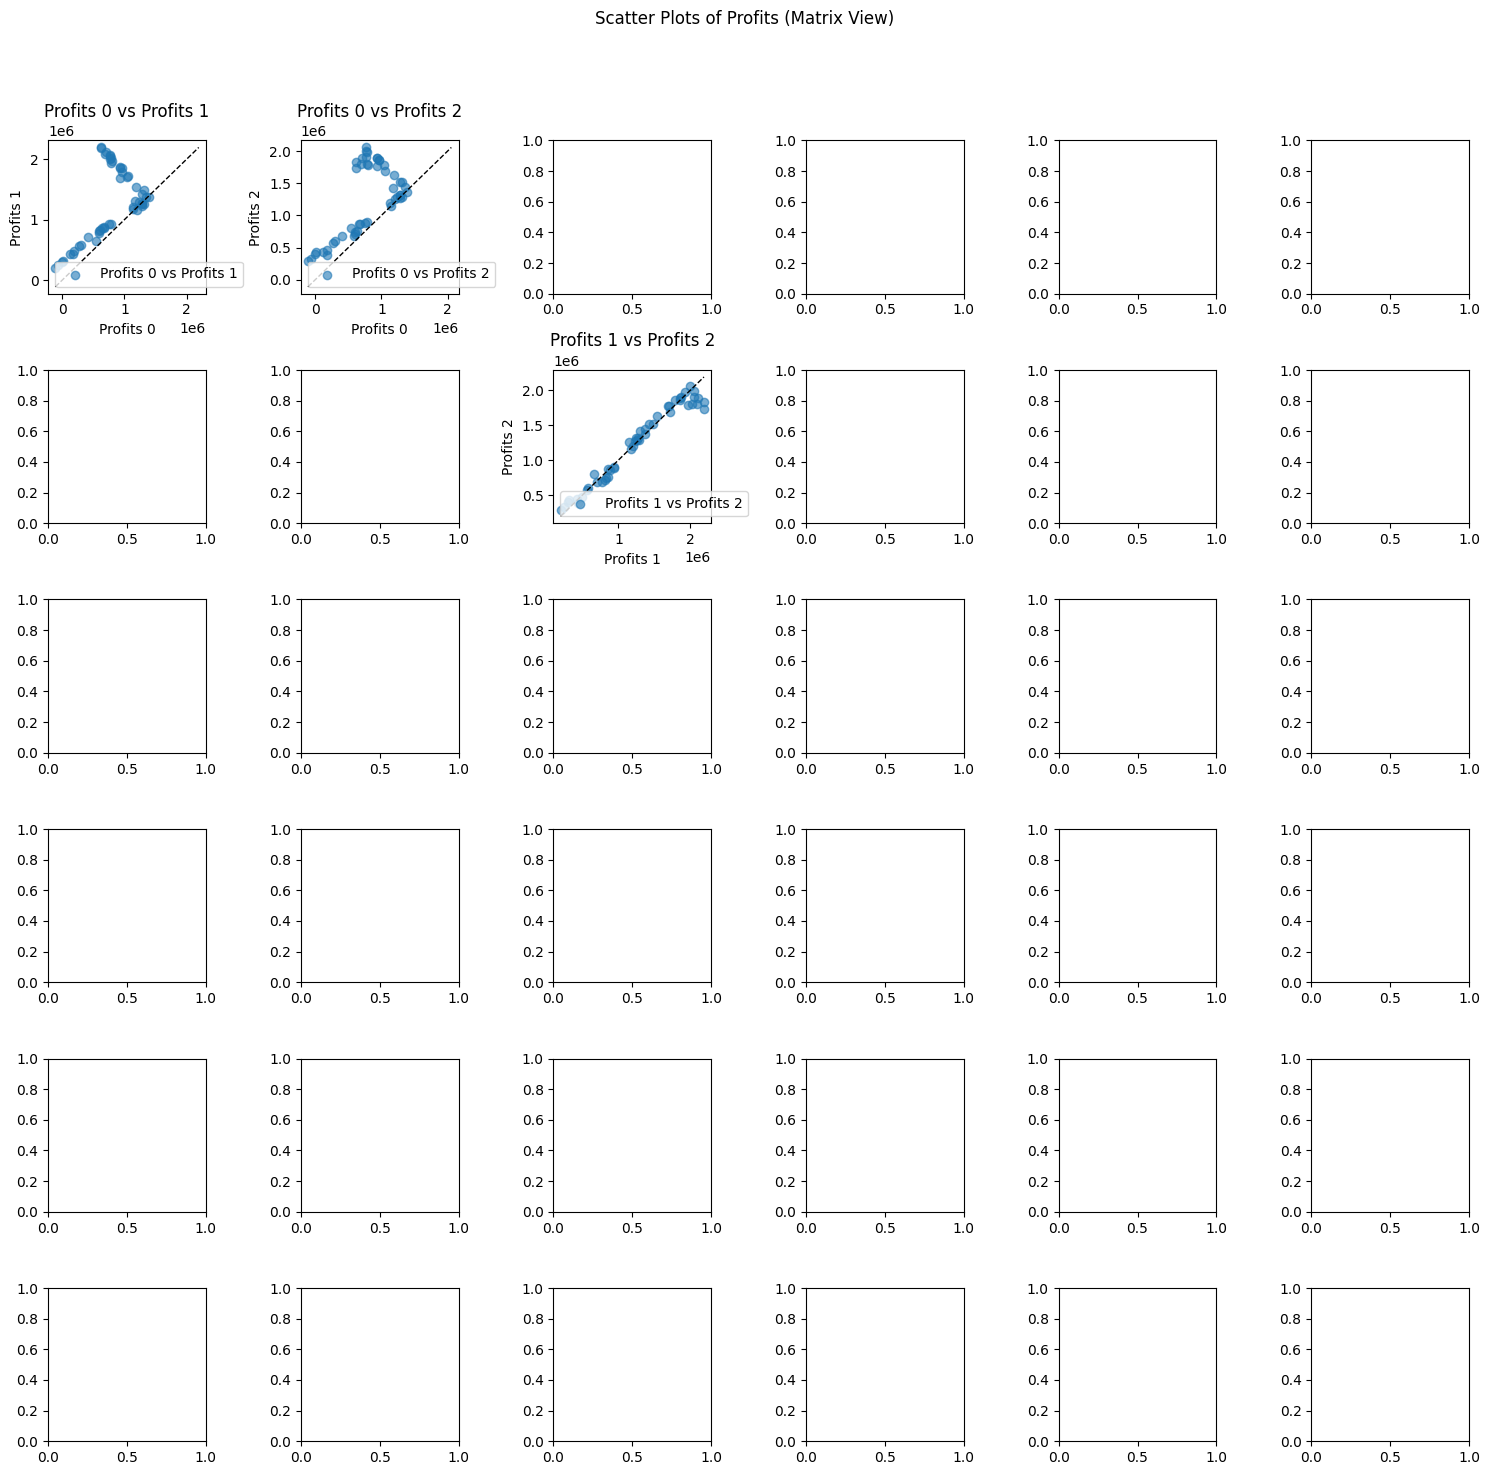

In [194]:
dfs = [
    test_stimulation_df_baseline,
    test_stimulation_results_df_1,
    test_stimulation_results_df_2,
    test_stimulation_results_df_3,
    test_stimulation_results_df_4,
    test_stimulation_results_df_5,
    test_stimulation_results_df_6,
    test_stimulation_results_df_7,
    test_stimulation_results_df_8,
]

plot_strategies_profits_scatter(f"{status}_{model_prefix}", dfs)

##### Profit Deviation

Baseline is: 775433.5933493589
S1's profit: 1263637.0093184505
S2's profit: 1246760.4273890015
S3's profit: -1
S4's profit: -1
S5's profit: -1
S6's profit: -1
S7's profit: -1
S8's profit: -1
Plot saved as plots/plot_relative_profit_deviation_test_med_with_holding_cost_0_100_202502121653.png


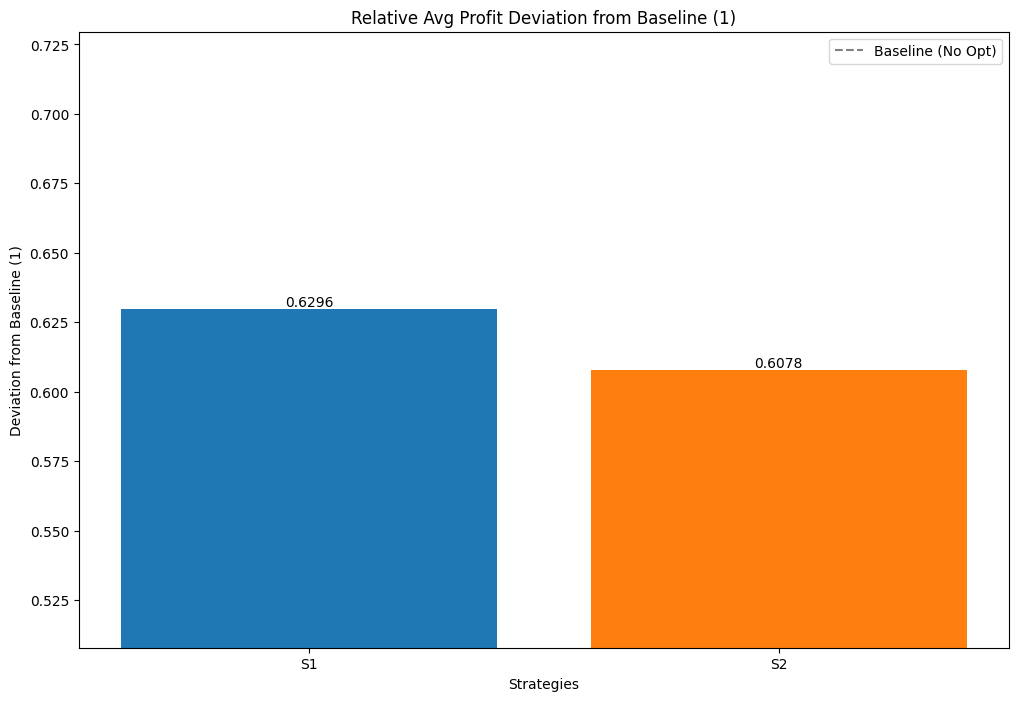

In [195]:
test_max_profits = [
    (
        test_results_df_1.iloc[0]["average_profits"]
        if test_results_df_1 is not None
        else -1
    ),
    (
        test_results_df_2.iloc[0]["average_profits"]
        if test_results_df_2 is not None
        else -1
    ),
    (
        test_results_df_3.iloc[0]["average_profits"]
        if test_results_df_3 is not None
        else -1
    ),
    (
        test_results_df_4.iloc[0]["average_profits"]
        if test_results_df_4 is not None
        else -1
    ),
    (
        test_results_df_5.iloc[0]["average_profits"]
        if test_results_df_5 is not None
        else -1
    ),
    (
        test_results_df_6.iloc[0]["average_profits"]
        if test_results_df_6 is not None
        else -1
    ),
    (
        test_results_df_7.iloc[0]["average_profits"]
        if test_results_df_7 is not None
        else -1
    ),
    (
        test_results_df_8.iloc[0]["average_profits"]
        if test_results_df_8 is not None
        else -1
    ),
]
plot_relative_profit_deviation(
    f"{status}_{model_prefix}", test_baseline_avg_profits, test_max_profits
)

##### 二次補貨量

Plot saved as plots/plot_Q0_Q1_distribution_test_med_with_holding_cost_0_100_S1_202502121653.png


Plot saved as plots/plot_Q0_Q1_distribution_test_med_with_holding_cost_0_100_S2_202502121653.png


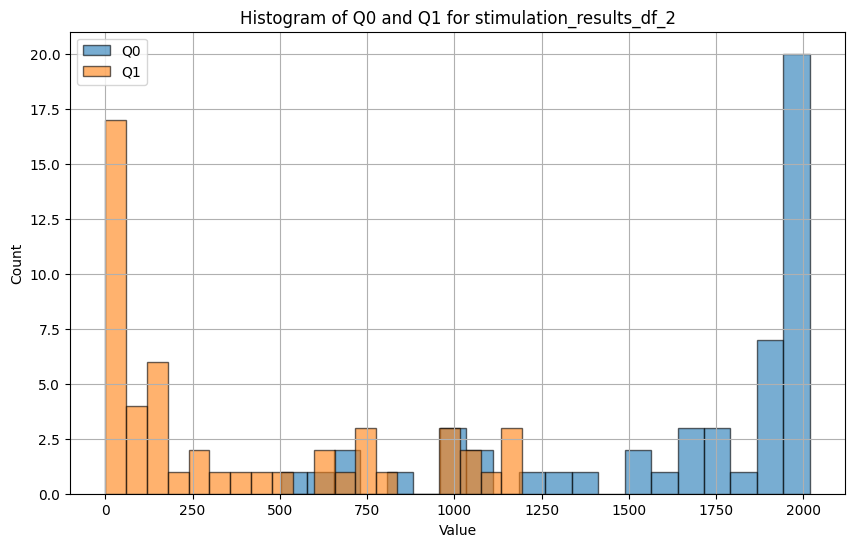

In [196]:
plot_Q0_Q1_distribution(f"{status}_{model_prefix}", dfs[1:])

##### 每一個 profits 對 Baseline 的 Deviation

Plot saved as plots/plot_profits_deviation_box_plot_test_med_with_holding_cost_0_100_S1_202502121653.png


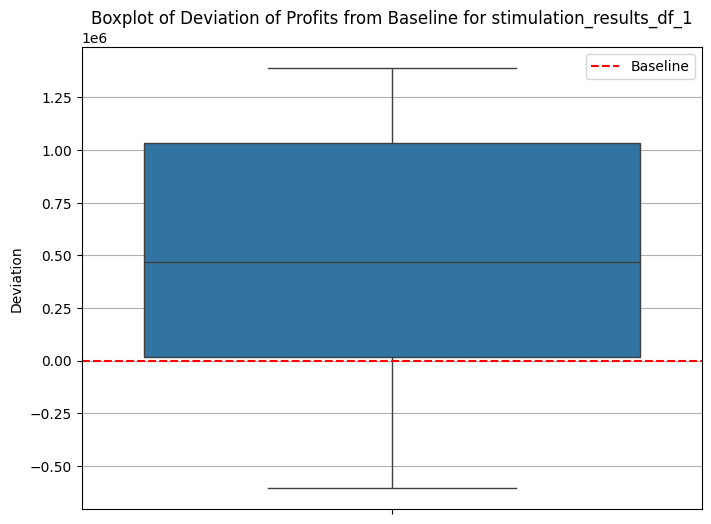

Plot saved as plots/plot_profits_deviation_box_plot_test_med_with_holding_cost_0_100_S2_202502121653.png


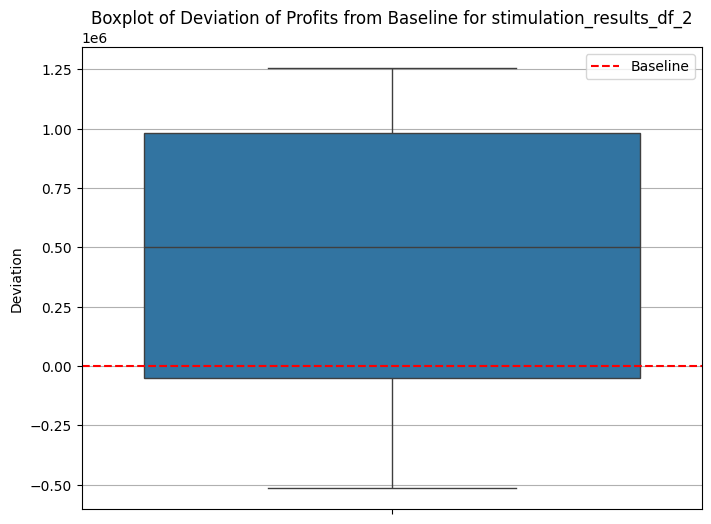

Skipping stimulation_results_df_3: Missing 'profits' column.
Skipping stimulation_results_df_4: Missing 'profits' column.
Skipping stimulation_results_df_5: Missing 'profits' column.
Skipping stimulation_results_df_6: Missing 'profits' column.
Skipping stimulation_results_df_7: Missing 'profits' column.
Skipping stimulation_results_df_8: Missing 'profits' column.


In [197]:
plot_profits_deviation_box_plot(
    f"{status}_{model_prefix}", dfs[1:], baseline_avg_profits
)

#### 訓練 vs. 測試

與各自的 Baseline 相比

Plot saved as plots/plot_relative_profit_comparison_test_med_with_holding_cost_0_100_202502121653.png


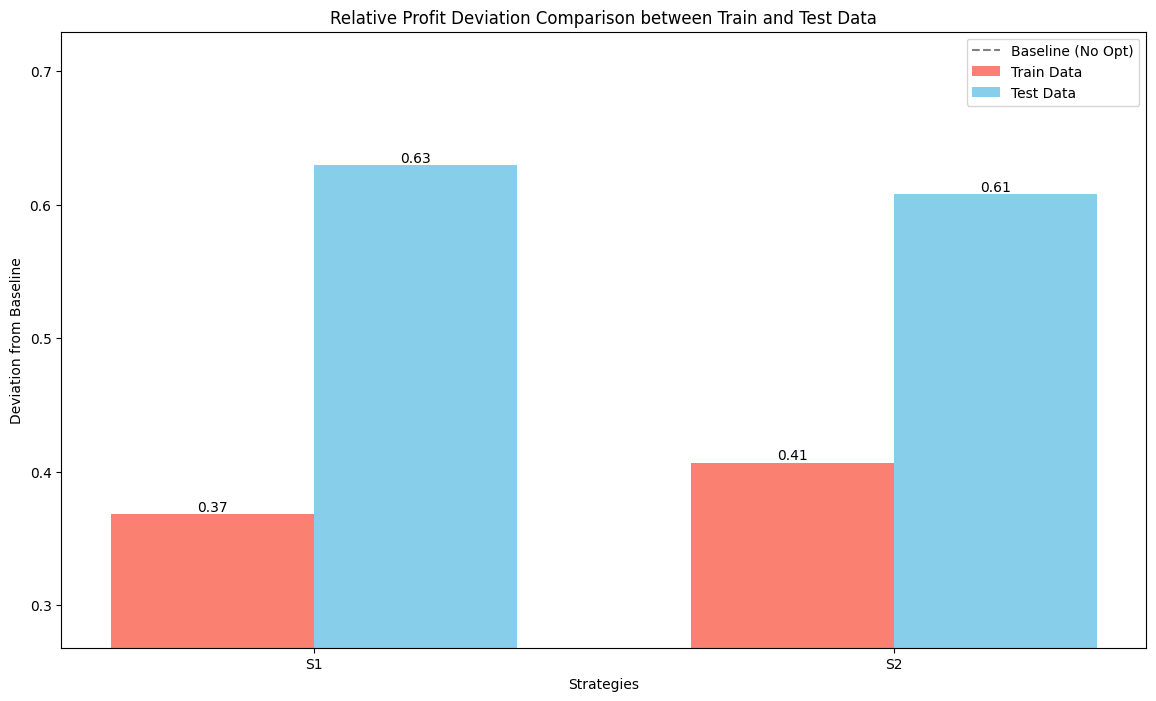

In [198]:
# Plot the comparison
plot_relative_profit_comparison(
    save_type=f"{status}_{model_prefix}",
    train_baseline_profit=baseline_avg_profits,
    test_baseline_profit=test_baseline_avg_profits,
    test_max_profits=test_max_profits,
    train_max_profits=train_max_profits,
)

#### Root Analysis

將參數 show 出來比較與分析

### Preparation

In [199]:
# 將變數名稱存取為此 Margin 特別的變數
# overview
low_test_results_df_1 = test_results_df_1
low_test_results_df_2 = test_results_df_2
low_test_results_df_3 = test_results_df_3
low_test_results_df_4 = test_results_df_4
low_test_results_df_5 = test_results_df_5
low_test_results_df_6 = test_results_df_6
low_test_results_df_7 = test_results_df_7
low_test_results_df_8 = test_results_df_8

# max stimulation result
low_test_stimulation_results_df_1 = test_stimulation_results_df_1
low_test_stimulation_results_df_2 = test_stimulation_results_df_2
low_test_stimulation_results_df_3 = test_stimulation_results_df_3
low_test_stimulation_results_df_4 = test_stimulation_results_df_4
low_test_stimulation_results_df_5 = test_stimulation_results_df_5
low_test_stimulation_results_df_6 = test_stimulation_results_df_6
low_test_stimulation_results_df_7 = test_stimulation_results_df_7
low_test_stimulation_results_df_8 = test_stimulation_results_df_8

# max value
low_test_baseline_profit = test_baseline_avg_profits
low_test_max_profit_for_s1 = test_max_profits[0]
low_test_max_profit_for_s2 = test_max_profits[1]
low_test_max_profit_for_s3 = test_max_profits[2]
low_test_max_profit_for_s4 = test_max_profits[3]
low_test_max_profit_for_s5 = test_max_profits[4]
low_test_max_profit_for_s6 = test_max_profits[5]
low_test_max_profit_for_s7 = test_max_profits[6]
low_test_max_profit_for_s8 = test_max_profits[7]